### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs for non-AI articles (using a ChatGPT prompt)
- Also remove duplicates/seen before, (match URL or title+domain, or 90% cosine similarity of normalized text)
- Download articles and summarize 
- Rerank and filter the articles based on summary, for quality, recency, site reputation
- Derform topic analysis via prompts (vs. traditional NMF or LDA, is zero-shot w/o training and also should have deep semantic understanding)
- Dedupe again and keep only highest ranked article covering a single development, event, or set of facts
- Send top articles by max marginal relevance to a large prompt
- Use a loop to polish and email the summary
- Used to generate a daily newsletter at skynetandchill.beehiiv.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - use OpenAI agents SDK instead of langgraph
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
  - implement proper critic-optimizer loop logic

- write currently uses a complex prompt with all the stories. instead
  - split into 2 parts, first select stories and then write
  - maybe write each section independently, assemble all the sections and rewrite using a critic-refine flow

- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo

- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.agent']
# del sys.modules['ainewsbot.AInewsbot']


In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log
from ainewsbot.agent import (Agent, AgentState, initialize_agent,)

import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)

# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
LangChain         0.3.26
OpenAI            1.93.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.3.0
sklearn           1.7.0
umap              0.5.9.post2
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-10-07 18:40:58,081 - AInewsbot - INFO - Initializing with before_date=2025-10-07 08:00, do_download=True, thread_id=2e25d15a63674ba39c1ad1b905879695
2025-10-07 18:40:58,251 - AInewsbot - INFO - thread_id: 2e25d15a63674ba39c1ad1b905879695


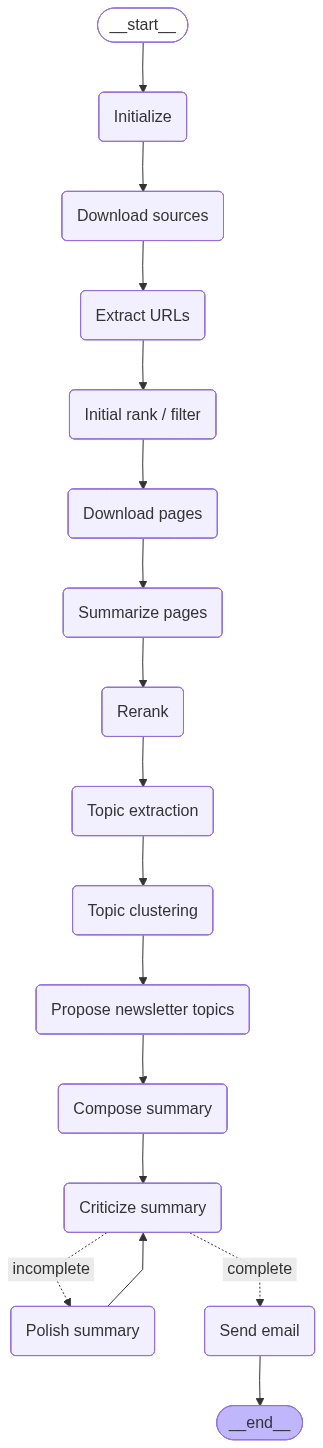

In [4]:
# before_date = None
before_date = '2025-10-07 08:00'
do_download = True

# current flow is, run this process post good ones to Bluesky, compile newsletter from Bluesky posts and a prompt
# Compile newsletter from BlueSky posts.ipynb

# low, medium, high models
ml, mm, mh = 'gpt-5-nano', 'gpt-5-mini', 'gpt-5'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
# run end to end
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-10-07 18:41:01,592 - AInewsbot - INFO - Missing key in event data: 'src'
2025-10-07 18:41:01,593 - AInewsbot - INFO - fn_initialize: do_download=True, before_date=2025-10-07 08:00, n_browsers=12, max_edits=2
2025-10-07 18:41:01,593 - AInewsbot - INFO - Deleting existing files
2025-10-07 18:41:01,601 - AInewsbot - INFO - Initialized 18 items in sources from sources.yaml
2025-10-07 18:41:01,602 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-10-07 18:41:01,602 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-10-07 18:41:01,602 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-10-07 18:41:01,602 - AInewsbot - INFO - FT -> https://www.ft.com/artificial-intelligence -> FT.html
2025-10-07 18:41:01,603 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiO

2025-10-07 18:41:24,793 - AInewsbot - INFO - Saving HTML to download/sources/The_Register.html
2025-10-07 18:41:24,869 - AInewsbot - INFO - Starting fetch_source https://www.washingtonpost.com/technology/innovations/, Washington_Post
2025-10-07 18:41:24,869 - AInewsbot - INFO - fetch_url(https://www.washingtonpost.com/technology/innovations/)
2025-10-07 18:41:25,997 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 23:41:25
2025-10-07 18:41:25,999 - AInewsbot - INFO - Saving HTML to download/sources/Techmeme.html
2025-10-07 18:41:26,073 - AInewsbot - INFO - Starting fetch_source https://www.theguardian.com/uk/technology, The_Guardian
2025-10-07 18:41:26,079 - AInewsbot - INFO - fetch_url(https://www.theguardian.com/uk/technology)
2025-10-07 18:41:26,471 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 23:41:26
2025-10-07 18:41:26,472 - AInewsbot - INFO - Saving HTML to download/sources/Hacker_News_2.html
2025-10-07 18

2025-10-07 18:41:47,314 - AInewsbot - INFO - New York Times -> download/sources/New_York_Times.html
2025-10-07 18:41:47,324 - AInewsbot - INFO - parse_file - found 75 raw links
2025-10-07 18:41:47,325 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-10-07 18:41:47,325 - AInewsbot - INFO - 19 links found
2025-10-07 18:41:47,325 - AInewsbot - INFO - Reddit -> download/sources/Reddit.html
2025-10-07 18:41:47,345 - AInewsbot - INFO - parse_file - found 418 raw links
2025-10-07 18:41:47,350 - AInewsbot - INFO - parse_file - found 61 filtered links
2025-10-07 18:41:47,351 - AInewsbot - INFO - 61 links found
2025-10-07 18:41:47,351 - AInewsbot - INFO - Techmeme -> download/sources/Techmeme.html
2025-10-07 18:41:47,368 - AInewsbot - INFO - parse_file - found 415 raw links
2025-10-07 18:41:47,372 - AInewsbot - INFO - parse_file - found 158 filtered links
2025-10-07 18:41:47,372 - AInewsbot - INFO - 158 links found
2025-10-07 18:41:47,372 - AInewsbot - INFO - The Register -> downlo

Download Feedly AI manually: https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from abeginning with do_download=False

last_state_values = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state_values["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state_values["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state_values["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state_values["sources"].keys()) - set(pd.DataFrame(last_state_values["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name', 'hostname', 'site_name', 'url', 'actual_url']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"topic_extract": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Restore a snapshot and resume based on thread_id
`sqlite3 lg_checkpointer.db`

`select * from checkpoints order by checkpoint desc limit 3;`

In [ ]:
thread_id="f09f851901b04f8899879ca9ec9d887e"
config = {"configurable": {"thread_id": thread_id}}
snap = lg_agent.graph.get_state(config)  # latest snapshot for this thread


In [ ]:
print("next node:", snap.next)       # the node(s) LangGraph will run next


In [ ]:
pd.DataFrame(snap.values["AIdf"]).columns


In [ ]:
aidf = pd.DataFrame(snap.values["AIdf"]).sort_values("last_updated", ascending=False)


In [ ]:
aidf.loc[aidf['cluster_name'].isin(['AI in Medicine and Biology','AI Risk, Governance, and Innovation',       'Responsible AI Governance and Adoption',

])]

In [ ]:
aidf['cluster_name'].unique() 


In [ ]:
last_state = lg_agent.graph.get_state(config)



In [ ]:
print("next node:", snap.next)       # the node(s) LangGraph will run next
# print("values:", snap.values)         # current saved state

last_state = lg_agent.graph.get_state(config)
last_state.values['AIdf'] = aidf.to_dict(orient='records')

# sources_downloaded = len(pd.DataFrame(last_state.values["AIdf"]).groupby("src").count()[['id']])
# print("number of sources in AIdf", sources_downloaded)
# display(pd.DataFrame(last_state.values["AIdf"]).groupby("src").count()[['id']])

lg_agent.graph.invoke(None, config=config)

In [ ]:
mydf = pd.DataFrame(snap.values["AIdf"]).sort_values("rating", ascending=False)
i =0
for row in mydf.itertuples():
    display(Markdown(f"[{row.title}]({row.url})"))
    i +=1
    if i>=30:
        break
        

# Run each step individually

2025-10-07 18:49:12,486 - AInewsbot - INFO - Initializing with before_date=2025-10-07 08:00, do_download=False, thread_id=be561f35f87544ffa31ba475fb40dcca


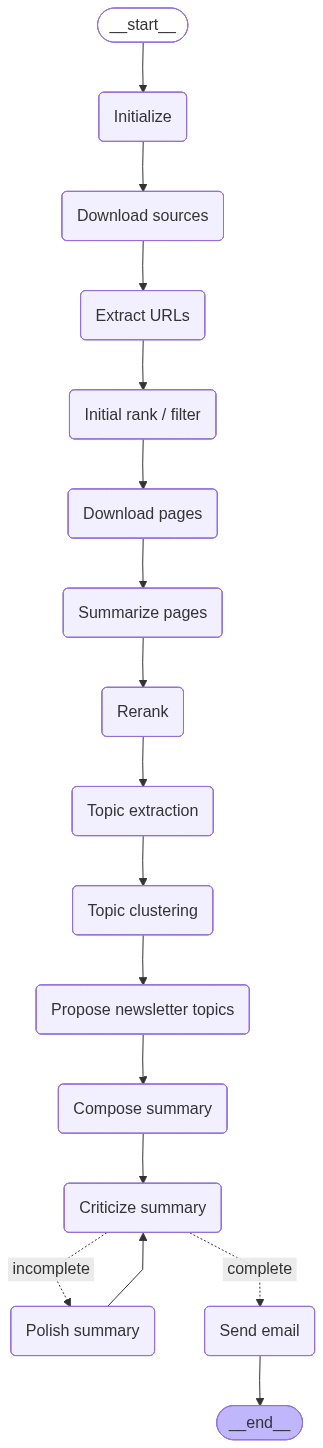

In [6]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-10-07 08:00'
do_download = False

ml, mm, mh = 'gpt-5-nano', 'gpt-5-mini', 'gpt-5'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [7]:
lg_state = lg_agent.initialize_config(lg_state)


2025-10-07 18:49:15,899 - AInewsbot - INFO - fn_initialize: do_download=False, before_date=2025-10-07 08:00, n_browsers=12, max_edits=2
2025-10-07 18:49:15,916 - AInewsbot - INFO - Initialized 18 items in sources from sources.yaml
2025-10-07 18:49:15,917 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-10-07 18:49:15,917 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-10-07 18:49:15,917 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-10-07 18:49:15,918 - AInewsbot - INFO - FT -> https://www.ft.com/artificial-intelligence -> FT.html
2025-10-07 18:49:15,918 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1

In [9]:
!pwd 


/Users/drucev/projects/windsurf/AInewsbot


In [10]:
lg_state = lg_agent.download_sources(lg_state)


2025-10-07 18:52:15,310 - AInewsbot - INFO - Web fetch disabled, using existing files in download/sources
2025-10-07 18:52:15,314 - AInewsbot - INFO - Found 17 previously downloaded files
2025-10-07 18:52:15,315 - AInewsbot - INFO - download/sources/Techmeme.html
2025-10-07 18:52:15,315 - AInewsbot - INFO - download/sources/Hacker_News_1.html
2025-10-07 18:52:15,316 - AInewsbot - INFO - download/sources/Reddit.html
2025-10-07 18:52:15,316 - AInewsbot - INFO - download/sources/HackerNoon.html
2025-10-07 18:52:15,317 - AInewsbot - INFO - download/sources/VentureBeat.html
2025-10-07 18:52:15,317 - AInewsbot - INFO - download/sources/Feedly_AI.html
2025-10-07 18:52:15,318 - AInewsbot - INFO - download/sources/The_Register.html
2025-10-07 18:52:15,318 - AInewsbot - INFO - download/sources/FT.html
2025-10-07 18:52:15,319 - AInewsbot - INFO - download/sources/Business_Insider.html
2025-10-07 18:52:15,319 - AInewsbot - INFO - download/sources/Washington_Post.html
2025-10-07 18:52:15,319 - AIne

In [11]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-10-07 18:52:19,986 - AInewsbot - INFO - Parsing html files
2025-10-07 18:52:19,989 - AInewsbot - INFO - Ars Technica -> download/sources/Ars_Technica.html
2025-10-07 18:52:20,492 - AInewsbot - INFO - parse_file - found 169 raw links
2025-10-07 18:52:20,494 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-10-07 18:52:20,495 - AInewsbot - INFO - 35 links found
2025-10-07 18:52:20,495 - AInewsbot - INFO - Bloomberg -> download/sources/Bloomberg.html
2025-10-07 18:52:20,520 - AInewsbot - INFO - parse_file - found 249 raw links
2025-10-07 18:52:20,523 - AInewsbot - INFO - parse_file - found 32 filtered links
2025-10-07 18:52:20,523 - AInewsbot - INFO - 32 links found
2025-10-07 18:52:20,523 - AInewsbot - INFO - Business Insider -> download/sources/Business_Insider.html
2025-10-07 18:52:20,543 - AInewsbot - INFO - parse_file - found 160 raw links
2025-10-07 18:52:20,545 - AInewsbot - INFO - parse_file - found 16 filtered links
2025-10-07 18:52:20,545 - AInewsbot - INFO - 1

In [12]:
# check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 18


id
src                  
Ars Technica       34
Bloomberg          27
Business Insider   16
FT                 46
Feedly AI         184
Hacker News 1      26
Hacker News 2      25
HackerNoon         21
New York Times     19
NewsAPI            90
Reddit             51
Techmeme          152
The Guardian       19
The Register      107
The Verge          24
VentureBeat        11
WSJ                17
Washington Post    27

number of missing sources -1


set()

In [13]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-10-07 18:52:46,573 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < ?
2025-10-07 18:52:47,623 - AInewsbot - INFO - URLs in orig_df: 896
2025-10-07 18:52:47,628 - AInewsbot - INFO - Existing URLs in DB: 333882
2025-10-07 18:52:47,707 - AInewsbot - INFO - New URLs in df filtered by URL: 573
2025-10-07 18:52:47,902 - AInewsbot - INFO - Existing src+title: 38
2025-10-07 18:52:47,903 - AInewsbot - INFO - New URLs in df filtered by src+title: 535
2025-10-07 18:52:47,922 - AInewsbot - INFO - Found 534 unique new headlines
2025-10-07 18:52:47,925 - AInewsbot - INFO - Found 530 unique cleaned new headlines
2025-10-07 18:53:02,574 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 18:53:03,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 18:53:04,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
20

id
src                  
Ars Technica        5
Bloomberg          17
Business Insider    9
FT                  6
Feedly AI         133
Hacker News 1       5
Hacker News 2       4
HackerNoon          5
New York Times      3
NewsAPI            52
Reddit              5
Techmeme           34
The Register        9
The Verge           4
VentureBeat         3
WSJ                 5
Washington Post     1

In [14]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-10-07 18:53:50,020 - AInewsbot - INFO - Queuing URLs for scraping
2025-10-07 18:53:50,026 - AInewsbot - INFO - Saving HTML files using async concurrency= 12
2025-10-07 18:53:50,465 - AInewsbot - INFO - Launching browser
2025-10-07 18:53:51,641 - AInewsbot - INFO - Launching workers
2025-10-07 18:53:51,642 - AInewsbot - INFO - Launching worker 1 (total active: 1)
2025-10-07 18:53:51,643 - AInewsbot - INFO - from queue: 184, https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/ , OpenAI Aims to
                                                                            Standardize How to Build AI Agents
2025-10-07 18:53:51,643 - AInewsbot - INFO - Fetching https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/
2025-10-07 18:53:51,643 - AInewsbot - INFO - fetch_url(https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/)
2025-10-07 18:53:51,656 

2025-10-07 18:53:51,777 - AInewsbot - INFO - Fetching https://www.digitaltrends.com/computing/am-i-hallucinating-or-is-chatgpt-still-making-mistakes-even-with-gpt5/
2025-10-07 18:53:51,778 - AInewsbot - INFO - fetch_url(https://www.digitaltrends.com/computing/am-i-hallucinating-or-is-chatgpt-still-making-mistakes-even-with-gpt5/)
2025-10-07 18:53:51,813 - AInewsbot - INFO - Launching worker 11 (total active: 11)
2025-10-07 18:53:51,813 - AInewsbot - INFO - from queue: 56, https://v.redd.it/w83gtuludotf1 , Asked ChatGPT for ideas for a funny title
2025-10-07 18:53:51,813 - AInewsbot - INFO - Fetching https://v.redd.it/w83gtuludotf1
2025-10-07 18:53:51,814 - AInewsbot - INFO - fetch_url(https://v.redd.it/w83gtuludotf1)
2025-10-07 18:53:51,829 - AInewsbot - INFO - Launching worker 12 (total active: 12)
2025-10-07 18:53:51,830 - AInewsbot - INFO - from queue: 152, https://www.cnet.com/tech/services-and-software/if-you-want-better-ai-images-you-need-to-use-these-key-ingredients-in-your-prom

2025-10-07 18:54:22,160 - AInewsbot - INFO - from queue: 197, https://www.businessinsider.com/openai-just-launched-app-store-taking-aim-apple-google-2025-10 , OpenAI just launched its own version of an app store, taking aim at Apple and Google
2025-10-07 18:54:22,162 - AInewsbot - INFO - Fetching https://www.businessinsider.com/openai-just-launched-app-store-taking-aim-apple-google-2025-10
2025-10-07 18:54:22,163 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/openai-just-launched-app-store-taking-aim-apple-google-2025-10)
2025-10-07 18:54:24,157 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T14:00:00-05:00
2025-10-07 18:54:24,164 - AInewsbot - INFO - Saving HTML to download/html/The_Singularity_Myth__Unpacking_AI_s_Future.html
2025-10-07 18:54:24,252 - AInewsbot - INFO - from queue: 113, https://www.theregister.com/2025/10/07/gen_ai_shadow_it_secrets/ , Employees
                                                                 

2025-10-07 18:54:40,267 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 15:54:40
2025-10-07 18:54:40,270 - AInewsbot - INFO - Saving HTML to download/html/German_government_comes_out_against_Chat_Control.html
2025-10-07 18:54:40,281 - AInewsbot - INFO - from queue: 96, https://www.theregister.com/2025/10/06/deloitte_ai_report_australia/ , Deloitte refunds Aussie gov after AI fabrications slip into $440K welfare reportBig Four consultancy billed Canberra top dollar, only for investigators to find bits written by a chatbotAI + ML1 day|20
2025-10-07 18:54:40,281 - AInewsbot - INFO - Fetching https://www.theregister.com/2025/10/06/deloitte_ai_report_australia/
2025-10-07 18:54:40,281 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/10/06/deloitte_ai_report_australia/)
2025-10-07 18:54:41,168 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T21:49:00Z
2025-10-07 18:54:41,173 - AInewsbot - INFO - Savin

2025-10-07 18:54:51,176 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T12:43:05+0000
2025-10-07 18:54:51,177 - AInewsbot - INFO - Saving HTML to download/html/Dell_says_it_now_expects_7__to_9__annual_revenue_growth__up_from_its_prior_forecast_of_3__to_4___citing_demand_for_compute__storage__and_networking_to_deploy_AI.html
2025-10-07 18:54:51,235 - AInewsbot - INFO - from queue: 274, https://futurism.com/artificial-intelligence/top-ai-figures-ai-wipe-out-humankind , Top AI Industry
                                                                            Figures Secretly Hoping AI Will Wipe Out
                                                                            Humankind
2025-10-07 18:54:51,238 - AInewsbot - INFO - Fetching https://futurism.com/artificial-intelligence/top-ai-figures-ai-wipe-out-humankind
2025-10-07 18:54:51,239 - AInewsbot - INFO - fetch_url(https://futurism.com/artificial-intelligence/top-ai-figures-ai-wipe-out-huma

2025-10-07 18:55:05,829 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/10/06/openai_opens_chatgpt_to_referring/)
2025-10-07 18:55:06,645 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-06T12:40:45+00:00
2025-10-07 18:55:06,646 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T12:40:45+00:00
2025-10-07 18:55:06,647 - AInewsbot - INFO - Saving HTML to download/html/Fictional_characters_are__officially__coming_to_Sora_as_OpenAI_manages_copyright_chaos.html
2025-10-07 18:55:06,707 - AInewsbot - INFO - from queue: 193, https://techcrunch.com/2025/10/06/openai-ramps-up-developer-push-with-more-powerful-models-in-its-api/ , OpenAI announces API updates, including GPT-5 Pro, Sora 2 in preview, and gpt-realtime-mini, a voice model that is 70% cheaper than gpt-realtime
2025-10-07 18:55:06,714 - AInewsbot - INFO - Fetching https://techcrunch.com/2025/10/06/openai-ramps-up-developer-push-wi

2025-10-07 18:55:17,023 - AInewsbot - INFO - from queue: 1, https://deadline.com/2025/10/tron-ares-review-jared-leto-greta-lee-robotic-reboot-1236571930/ , 'Tron: Ares'
                                                                            Review: Jared Leto Goes Full-Boat AI On
                                                                            Greta Lee In Robotic Reboot Of Disney's
                                                                            Digital Franchise
2025-10-07 18:55:17,023 - AInewsbot - INFO - Fetching https://deadline.com/2025/10/tron-ares-review-jared-leto-greta-lee-robotic-reboot-1236571930/
2025-10-07 18:55:17,024 - AInewsbot - INFO - fetch_url(https://deadline.com/2025/10/tron-ares-review-jared-leto-greta-lee-robotic-reboot-1236571930/)
2025-10-07 18:55:18,826 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMiuwFBVV95cUxOY3FNVG1sbmVIN19VOHlPNFBfd3NfQXh3S29oRjBscFV6aGlpQkppeXRTQjhrLVZIRElmclNReDNDZktPdExl

2025-10-07 18:55:37,823 - AInewsbot - INFO - Google News page: https://phys.org/news/2025-10-adding-human-guidance-ai-benefits.html
2025-10-07 18:55:37,852 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T16:29:04-04:00
2025-10-07 18:55:37,853 - AInewsbot - INFO - Saving HTML to download/html/Adding_human_____________________________________________________________________________guidance_to_AI_tutors_enhances_benefits_for_____________________________________________________________________________students__study_finds.html
2025-10-07 18:55:37,910 - AInewsbot - INFO - from queue: 125, https://venturebeat.com/ai/from-silicon-valley-to-nairobi-what-the-global-souths-ai-leapfrogging , From Silicon Valley to Nairobi: What the Global Souths AI leapfrogging teaches tech leaders
2025-10-07 18:55:37,911 - AInewsbot - INFO - Fetching https://venturebeat.com/ai/from-silicon-valley-to-nairobi-what-the-global-souths-ai-leapfrogging
2025-10-07 18:55:37,912 -

2025-10-07 18:55:49,302 - AInewsbot - INFO - Skipping fetch for 132 https://www.bloomberg.com/news/articles/2025-10-07/goldman-trader-says-investors-shouldn-t-fight-the-ai-trade Goldmans Molavi Says Investors Shouldnt Fight the AI Trade
2025-10-07 18:55:49,304 - AInewsbot - INFO - from queue: 123, https://finance.yahoo.com/news/former-insurance-exec-raises-33-100922581.html , Former insurance
                                                                            exec raises $33 million fund for New
                                                                            York-based Crystal Venture Partners as AI
                                                                            transforms the industry
2025-10-07 18:55:49,305 - AInewsbot - INFO - Fetching https://finance.yahoo.com/news/former-insurance-exec-raises-33-100922581.html
2025-10-07 18:55:49,306 - AInewsbot - INFO - fetch_url(https://finance.yahoo.com/news/former-insurance-exec-raises-33-100922581.html)
2025-10

2025-10-07 18:56:17,817 - AInewsbot - INFO - Fetching https://blog.google/products/google-one/google-ai-plus-36-countries/
2025-10-07 18:56:17,818 - AInewsbot - INFO - fetch_url(https://blog.google/products/google-one/google-ai-plus-36-countries/)
2025-10-07 18:56:20,626 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-06T14:45+07:00
2025-10-07 18:56:20,629 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T14:45+07:00
2025-10-07 18:56:20,630 - AInewsbot - INFO - Saving HTML to download/html/From_Silicon_Valley_to_Nairobi__What_the_Global_Souths_AI_leapfrogging_teaches_tech_leaders.html
2025-10-07 18:56:20,725 - AInewsbot - INFO - from queue: 265, https://www.bloomberg.com/news/articles/2025-10-06/apple-faces-probe-in-france-over-voice-recordings-made-by-siri , The Paris prosecutor's office refers a probe into Apple's Siri recordings to the Office for Combating Cybercrime, after a human rights org

2025-10-07 18:56:34,657 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMilAFBVV95cUxPOW5NZ2h1RGltanhVTW1pM1RDVnlhNW1Zd0RBVDVzTGQybFpJYTVscTFYeDcxZ0FuMkJwT1NVVEthZ1ZnNktuRFJnLWtWOF9tRncwMV9NUzV3MDFnS1ZjOWg0STdWVFItUkpKUlVlMkZGNFZOQmRTX3lTV1BuM2lUclRZMmM2TUtVRnNQdnZTU1FwdGE2)
2025-10-07 18:56:35,725 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 15:56:35
2025-10-07 18:56:35,728 - AInewsbot - INFO - Saving HTML to download/html/OpenAI_makes_Codex_generally_available__and_announces_new_features__Slack_integration_for_delegating_tasks_or_asking_questions__a_Codex_SDK__and_new_admin_tools.html
2025-10-07 18:56:35,928 - AInewsbot - INFO - from queue: 60, https://www.wired.com/story/sam-altman-and-jony-ives-ai-device-dev-day/ , At OpenAI's DevDay, Sam Altman and Jony Ive spoke in vague terms about the family of devices currently under development; Altman says it will take a while
2025-10-07 18:56:35,930 - AInewsbot - INFO - Fetching h

2025-10-07 18:57:05,650 - AInewsbot - INFO - Page URL redirected from https://theconversation.com/from-the-telegraph-to-ai-our-communications-systems-have-always-had-hidden-environmental-cost-263811 to https://theconversation.com/from-the-telegraph-to-ai-our-communications-systems-have-always-had-hidden-environmental-costs-263811
2025-10-07 18:57:05,661 - AInewsbot - INFO - Found last updated time from meta tag property=og:updated_time: 2025-10-06T23:09:47Z
2025-10-07 18:57:05,662 - AInewsbot - INFO - Saving HTML to download/html/From_the_telegraph_to_AI__our_communications_systems_have_always_had_hidden_environmental_cost.html
2025-10-07 18:57:05,772 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMilAFBVV95cUxPOW5NZ2h1RGltanhVTW1pM1RDVnlhNW1Zd0RBVDVzTGQybFpJYTVscTFYeDcxZ0FuMkJwT1NVVEthZ1ZnNktuRFJnLWtWOF9tRncwMV9NUzV3MDFnS1ZjOWg0STdWVFItUkpKUlVlMkZGNFZOQmRTX3lTV1BuM2lUclRZMmM2TUtVRnNQdnZTU1FwdGE2 to https://www.thestreet.com/technology/coreweaves-q

2025-10-07 18:57:24,025 - AInewsbot - INFO - Saving HTML to download/html/OpenAI_May_Have_Walked_Back_Its_Sora_2_Opt-Out_Policy__but_That_Doesnt_Mean_It_Suddenly_Cares_About_Hollywood.html
2025-10-07 18:57:24,180 - AInewsbot - INFO - from queue: 106, https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/ , Dutch chips star
                                                                            exec slams EU for overregulating AI
2025-10-07 18:57:24,181 - AInewsbot - INFO - Fetching https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/
2025-10-07 18:57:24,183 - AInewsbot - INFO - fetch_url(https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/)
2025-10-07 18:57:27,334 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T11:34:42-04:00
2025-10-07 18:57:27,341 - AInewsbot - INFO - Fou

2025-10-07 18:57:47,541 - AInewsbot - INFO - Saving HTML to download/html/AI_slop_is_coming_for_your_music.html
2025-10-07 18:57:47,740 - AInewsbot - INFO - from queue: 267, https://finance.yahoo.com/news/way-ai-100000880.html , The right way to
                                                                            use AI at work
2025-10-07 18:57:47,741 - AInewsbot - INFO - Domain finance.yahoo.com is rate-limited. Re-queuing https://finance.yahoo.com/news/way-ai-100000880.html.
2025-10-07 18:57:47,789 - AInewsbot - INFO - Page URL redirected from https://news.google.com/rss/articles/CBMif0FVX3lxTE5UdXN0WVNRNXdXV1hwOTZMNi1KLTFld3ZtUTl0TzZkelFpd3VFTF82WktOMlY1NEZHQU9CVDdxalJCakhXcVFyYmV1NlljcTZHWUlIek1iT2NlYWZQcFJ6RzRvOHQ4ci1LOTdNbzlveVdUNlZxQTN5LW9nc2tyX3M to https://www.barrons.com/articles/ai-bubble-stocks-nvidia-broadcom-778d3037
2025-10-07 18:57:47,792 - AInewsbot - INFO - Google News page: https://www.barrons.com/articles/ai-bubble-stocks-nvidia-broadcom-778d3037
2025-10-07 1

2025-10-07 18:58:12,176 - AInewsbot - INFO - from queue: 273, https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/ , TikTok Announces
                                                                            Improvements to Its AI-Powered Smart+ Ad
                                                                            Campaigns
2025-10-07 18:58:12,178 - AInewsbot - INFO - Fetching https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/
2025-10-07 18:58:12,178 - AInewsbot - INFO - fetch_url(https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/)
2025-10-07 18:58:18,678 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T06:00-04:00
2025-10-07 18:58:18,680 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T06:00-04:00
2025-10-07 18:58:18,680 - AInewsbot - INFO - Saving HTML to do

2025-10-07 18:58:26,191 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/792650/amd-openai-five-year-ai-chip-agreement)
2025-10-07 18:58:27,799 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-06T17:30:27+00:00
2025-10-07 18:58:27,810 - AInewsbot - INFO - Saving HTML to download/html/Sam_Altman_says_that_ChatGPT_has_reached_800M_weekly_active_users__4M_developers_have_built_with_OpenAI__and_OpenAI_processes_6B__tokens_per_minute_on_its_API.html
2025-10-07 18:58:28,150 - AInewsbot - INFO - from queue: 178, https://www.cio.com/article/4068993/netsuite-unveils-netsuite-next-expands-suitecloud-platform-adding-ai.html , NetSuite unveils
                                                                            NetSuite Next, expands SuiteCloud Platform
                                                                            adding AI
2025-10-07 18:58:28,151 - AInewsbot - INFO - Fetching https://www.cio.com/article/4068993/ne

2025-10-07 18:59:03,972 - AInewsbot - INFO - Fetching https://www.benzinga.com/markets/equities/25/10/48081738/nvidias-market-dominance-now-dwarfs-japan-china-germany-uk
2025-10-07 18:59:03,975 - AInewsbot - INFO - fetch_url(https://www.benzinga.com/markets/equities/25/10/48081738/nvidias-market-dominance-now-dwarfs-japan-china-germany-uk)
2025-10-07 18:59:04,961 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T21:05:22Z
2025-10-07 18:59:04,962 - AInewsbot - INFO - Saving HTML to download/html/Stargate_is_nowhere_near_big_enough_to_make_OpenAI_s_tie-ups_with_AMD_and_Nvidia_workCommentSince_revealing_Stargate_in_January__Altman_and_friends_have_brought_about_200_MW_online_-_they_ll_need_at_least_16_GW_to_claim_their_red_and_green_prizeAI__.html
2025-10-07 18:59:05,684 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-06T17:07:25+0000
2025-10-07 18:59:05,685 - AInewsbot - INFO - Found script last u

2025-10-07 18:59:19,834 - AInewsbot - INFO - Page URL redirected from https://www.cnet.com/news/social-media/facebooks-algorithm-update-aims-show-you-newer-reels-youll-actually-like-even-if-its-an-ai-video/ to https://www.cnet.com/news/social-media/facebooks-algorithm-update-aims-to-show-you-reels-youll-actually-like-even-if-theyre-ai/
2025-10-07 18:59:19,948 - AInewsbot - INFO - Found last updated time from HTTP header: Tue, 07 Oct 2025 17:25:03 GMT
2025-10-07 18:59:19,954 - AInewsbot - INFO - Saving HTML to download/html/Meta_updates_Reels_on_Facebook_to_prioritize_showing_fresher_and_more-relevant_content__and_adds_AI_search_suggestions_and_friend_bubbles_like_on_Instagram.html
2025-10-07 18:59:20,100 - AInewsbot - INFO - from queue: 282, https://finance.yahoo.com/news/veteran-analyst-drops-3-word-180300198.html , Veteran analyst
                                                                            drops 3-word verdict on AMD and OpenAI
                                        

2025-10-07 18:59:48,054 - AInewsbot - INFO - Skipping fetch for 174 https://www.bloomberg.com/news/articles/2025-10-07/nobel-prize-in-physics-awarded-in-sweden-to-clarke-devoret-martinis Michel Devoret, a Google Quantum AI chief scientist, John Martinis, who left Google in 2020, and John Clarke win the Nobel in Physics for quantum computing work
2025-10-07 18:59:48,059 - AInewsbot - INFO - from queue: 17, http://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/ , AI Voices Are Now Indistinguishable From Humans, Experts Say
2025-10-07 18:59:48,064 - AInewsbot - INFO - Fetching http://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/
2025-10-07 18:59:48,065 - AInewsbot - INFO - fetch_url(http://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/)
2025-10-07 18:59:48,518 - AInewsbot - INFO - Found script last upda

2025-10-07 19:00:09,058 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T07:10:41.000Z
2025-10-07 19:00:09,081 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T07:10:41.000Z
2025-10-07 19:00:09,100 - AInewsbot - INFO - Saving HTML to download/html/Robin_Williams_daughter_begs_fans_to_stop_sending_her_AI_videos_of_late_father.html
2025-10-07 19:00:09,375 - AInewsbot - INFO - from queue: 169, https://fortune.com/2025/10/07/mit-studied-16-million-election-ai-responses-chatbots-sensitive-steering-llm-neutrality/ , MIT researchers
                                                                            studied 16 million election-related AI
                                                                            responses. They found chatbots are
                                                                            sensitive to steering, raising questions
                              

2025-10-07 19:00:29,185 - AInewsbot - INFO - fetch_url(https://futurism.com/artificial-intelligence/friend-ceo-photoshoot-ads)
2025-10-07 19:00:30,250 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 16:00:30
2025-10-07 19:00:30,251 - AInewsbot - INFO - Saving HTML to download/html/AI_____________________________________________________________________________Might_Just_Make_the_Workplace_Safer._Heres_____________________________________________________________________________Why.html
2025-10-07 19:00:30,553 - AInewsbot - INFO - from queue: 156, https://www.bloomberg.com/news/articles/2025-10-07/jpmorgan-s-dimon-says-ai-cost-savings-now-matching-money-spent , JPMorgans Dimon Says AI Cost Savings Now Match Money Spent
2025-10-07 19:00:30,564 - AInewsbot - INFO - Skipping fetch for 156 https://www.bloomberg.com/news/articles/2025-10-07/jpmorgan-s-dimon-says-ai-cost-savings-now-matching-money-spent JPMorgans Dimon Says AI Cost Savings Now Match Money Spe

2025-10-07 19:00:47,258 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T18:42:46Z
2025-10-07 19:00:47,263 - AInewsbot - INFO - Saving HTML to download/html/ClickHouse_Adds_____________________________________________________________________________Investors_for_Data_Platform_Designed_for_____________________________________________________________________________Era_of_AI.html
2025-10-07 19:00:47,694 - AInewsbot - INFO - from queue: 85, https://www.bloomberg.com/news/videos/2025-10-07/bloomberg-tech-10-7-2025-video , Dell Boosts Forecast Through 2030 Off AI Boom | Bloomberg Tech 10/7/2025
2025-10-07 19:00:47,696 - AInewsbot - INFO - Skipping fetch for 85 https://www.bloomberg.com/news/videos/2025-10-07/bloomberg-tech-10-7-2025-video Dell Boosts Forecast Through 2030 Off AI Boom | Bloomberg Tech 10/7/2025
2025-10-07 19:00:47,698 - AInewsbot - INFO - from queue: 171, https://economictimes.indiatimes.com/tech/artificial-intelligence/mattel-partner

2025-10-07 19:01:05,447 - AInewsbot - INFO - fetch_url(https://www.technologyreview.com/2025/10/07/1125191/ai-toys-in-china/)
2025-10-07 19:01:06,092 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-06T20:05:50
2025-10-07 19:01:06,094 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T20:05:50
2025-10-07 19:01:06,095 - AInewsbot - INFO - Saving HTML to download/html/Elon_Musk_s_xAI_Seeks__Video_Games_Tutor__to_Train_Grok_Ahead_of_Gaming_Push.html
2025-10-07 19:01:06,250 - AInewsbot - INFO - from queue: 145, https://techcrunch.com/2025/10/07/how-otter-ais-ceo-is-pushing-the-company-to-be-more-than-just-a-meeting-scribe/ , How Otter.ai's CEO
                                                                            is pushing the company to be more than just
                                                                            a meeting scribe
2025-10-07 19:01:06,251 - AInewsbot - INFO - Fetc

2025-10-07 19:01:29,992 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-06T19:39:06+00:00
2025-10-07 19:01:29,994 - AInewsbot - INFO - Saving HTML to download/html/OpenAI_lifts_another_AI_laggard_with_big_plans_for_AMD.html
2025-10-07 19:01:30,163 - AInewsbot - INFO - from queue: 255, https://seekingalpha.com/news/4502446-tech-voices-bravo-on-ai-bubble-oracles-profits-gerstner-on-chips , Tech Voices: Bravo
                                                                            on AI bubble, Oracle's profits, Gerstner on
                                                                            chips
2025-10-07 19:01:30,164 - AInewsbot - INFO - Fetching https://seekingalpha.com/news/4502446-tech-voices-bravo-on-ai-bubble-oracles-profits-gerstner-on-chips
2025-10-07 19:01:30,165 - AInewsbot - INFO - fetch_url(https://seekingalpha.com/news/4502446-tech-voices-bravo-on-ai-bubble-oracles-profits-gerstner-on-chips)
2025-10-07 19:01:32,

2025-10-07 19:01:37,799 - AInewsbot - INFO - Fetching https://beincrypto.com/oracle-ai-crash-crypto-bubble-circular-finance/
2025-10-07 19:01:37,800 - AInewsbot - INFO - fetch_url(https://beincrypto.com/oracle-ai-crash-crypto-bubble-circular-finance/)
2025-10-07 19:01:38,458 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 16:01:38
2025-10-07 19:01:38,474 - AInewsbot - INFO - Saving HTML to download/html/Youtube_s_Biggest_____________________________________________________________________________Star_MrBeast_Fears_AI_Could_Impact__Millions_____________________________________________________________________________of_Creators__After_Sora_Launch.html
2025-10-07 19:01:38,650 - AInewsbot - INFO - from queue: 49, https://www.wsj.com/articles/anthropic-and-ibm-partner-in-bid-for-ai-business-customers-f64dee55 , Anthropic and IBM partner to make Anthropic's Claude models available in IBM's latest IDE for large businesses, and IBM aims to add Claude to more

2025-10-07 19:01:58,366 - AInewsbot - INFO - Fetching https://t.co/ZF1E09CAyV
2025-10-07 19:01:58,366 - AInewsbot - INFO - fetch_url(https://t.co/ZF1E09CAyV)
2025-10-07 19:02:05,208 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T22:12:00+00:00
2025-10-07 19:02:05,209 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T18:12:00-04:00
2025-10-07 19:02:05,209 - AInewsbot - INFO - Saving HTML to download/html/AI_____________________________________________________________________________As_A_Law_Firm_Revenue_Stream.html
2025-10-07 19:02:05,318 - AInewsbot - INFO - from queue: 16, https://blog.google/products/search/ai-mode-expands-languages-locations/ , AI
                                                                            Mode is now available in more languages and
                                                                            locations around the world.
2025-10-07 19:02:05,3

2025-10-07 19:02:12,523 - AInewsbot - INFO - Fetching https://www.reuters.com/business/feds-kashkari-says-hes-skeptical-ai-is-replacing-workers-it-may-push-up-rates-2025-10-07/
2025-10-07 19:02:12,524 - AInewsbot - INFO - fetch_url(https://www.reuters.com/business/feds-kashkari-says-hes-skeptical-ai-is-replacing-workers-it-may-push-up-rates-2025-10-07/)
2025-10-07 19:02:16,659 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T21:36:00+00:00
2025-10-07 19:02:16,660 - AInewsbot - INFO - Saving HTML to download/html/The_Closer__AI_____________________________________________________________________________and_Appetites__Sentiment__Consumers______________________________________________________________________________10_7_25.html
2025-10-07 19:02:16,695 - AInewsbot - INFO - from queue: 276, https://www.indiewire.com/criticism/movies/tron-ares-movie-review-1235154526/ , Tron: Ares Review:
                                                  

2025-10-07 19:02:33,531 - AInewsbot - INFO - Fetching https://www.theguardian.com/australia-news/2025/oct/06/deloitte-to-pay-money-back-to-albanese-government-after-using-ai-in-440000-report
2025-10-07 19:02:33,531 - AInewsbot - INFO - fetch_url(https://www.theguardian.com/australia-news/2025/oct/06/deloitte-to-pay-money-back-to-albanese-government-after-using-ai-in-440000-report)
2025-10-07 19:02:35,313 - AInewsbot - INFO - Found last updated time from meta tag property=og:updated_time: 2025-10-07T19:22:59.122Z
2025-10-07 19:02:35,314 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T17:31:08.801Z
2025-10-07 19:02:35,314 - AInewsbot - INFO - Saving HTML to download/html/Fed_s_Kashkari_____________________________________________________________________________says_he_s_skeptical_AI_is_replacing_workers______________________________________________________________________________but_it_may_push_up_rates.html
2025-10-07 19:02:35,380 - AInewsbot - 

2025-10-07 19:02:44,335 - AInewsbot - INFO - fetch_url(https://www.washingtonpost.com/opinions/2025/10/07/ai-artificial-intelligence-health-care-dr-bot/)
2025-10-07 19:02:45,063 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T19:23:38+0000
2025-10-07 19:02:45,069 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T19:23:38+0000
2025-10-07 19:02:45,070 - AInewsbot - INFO - Saving HTML to download/html/Goldman_Sachs_____________________________________________________________________________portfolio_manager_Brook_Dane_lists_Nvidia______________________________________________________________________________TSMC_among_top_AI_stocks_to_buy.html
2025-10-07 19:02:45,181 - AInewsbot - INFO - from queue: 116, https://www.globenewswire.com/news-release/2025/10/06/3162164/0/en/FOBI-AI-ANNOUNCES-LAUNCH-OF-FOBI-AI-3-0-STRATEGY-ARCHITECTURE-EXECUTION.html , FOBI AI ANNOUNCES LAUNCH OF FOBI AI 3.0  STRATEGY

2025-10-07 19:03:01,496 - AInewsbot - INFO - from queue: 65, https://news.google.com/rss/articles/CBMimwFBVV95cUxNZW1Rc0R4b3V6bThlM2dlTUx3UVJWbng4ZkhMcG96TVotWGR4blB2Tm50aEV3Umtldm05UlRYejliY2Z0bXQ1WC1xbThkQU9wQklmMzJFaTFhbE5IeFRqUEtqdm92Ri05bnhnSF9LSzdCaFdkcmhCcm1QMTRXeklsM2Q1Q29kSVpESFhOaDFMZFVLa3ZQTGx3SWZkYw , Brands Are Torn on
                                                                            Whether to Embrace AI Influencers or Run
                                                                            From Them
2025-10-07 19:03:01,497 - AInewsbot - INFO - Fetching https://news.google.com/rss/articles/CBMimwFBVV95cUxNZW1Rc0R4b3V6bThlM2dlTUx3UVJWbng4ZkhMcG96TVotWGR4blB2Tm50aEV3Umtldm05UlRYejliY2Z0bXQ1WC1xbThkQU9wQklmMzJFaTFhbE5IeFRqUEtqdm92Ri05bnhnSF9LSzdCaFdkcmhCcm1QMTRXeklsM2Q1Q29kSVpESFhOaDFMZFVLa3ZQTGx3SWZkYw
2025-10-07 19:03:01,497 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMimwFBVV95cUxNZW1Rc0R4b3V6bThlM2dlTUx3UVJWbng4ZkhMcG96TVotWGR4b

2025-10-07 19:03:11,432 - AInewsbot - INFO - Fetching https://finance.yahoo.com/news/dayforce-announces-dayforce-ai-workspace-200300555.html
2025-10-07 19:03:11,432 - AInewsbot - INFO - fetch_url(https://finance.yahoo.com/news/dayforce-announces-dayforce-ai-workspace-200300555.html)
2025-10-07 19:03:26,849 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T06:54:00-05:00
2025-10-07 19:03:26,850 - AInewsbot - INFO - Saving HTML to download/html/Deloitte_admits_AI_hallucinated_quotes_in_government_report__offers_partial_refund___Refunding_only_part_of_the__440_000_fee.html
2025-10-07 19:03:26,906 - AInewsbot - INFO - from queue: 102, https://fortune.com/2025/10/07/how-will-the-ai-bubble-burst-nvidia-openai-dotcom-circular/ , Dizzying deal
                                                                            delirium: How the AI bubble bursts
2025-10-07 19:03:26,907 - AInewsbot - INFO - Fetching https://fortune.com/2025/10/07/how-will-the-ai-bu

2025-10-07 19:03:37,456 - AInewsbot - INFO - fetch_url(https://www.coindesk.com/tech/2025/10/06/bee-maps-raises-usd32m-to-scale-solana-powered-decentralized-mapping-network)
2025-10-07 19:03:37,924 - AInewsbot - INFO - Found last updated time from meta tag property=og:updated_time: 2025-10-06T17:22:50.083-04:00
2025-10-07 19:03:37,926 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T17:22:50-04:00
2025-10-07 19:03:37,926 - AInewsbot - INFO - Saving HTML to download/html/Is_The_Giant_OpenAI-AMD_Deal_Another_Sign_of_an_AI_Bubble.html
2025-10-07 19:03:38,099 - AInewsbot - INFO - from queue: 108, https://freerepublic.com/focus/f-chat/4344731/posts , EXCLUSIVEI've seen AI try to ESCAPE labs. The apocalypse is already here... and our children will be the first victims
2025-10-07 19:03:38,100 - AInewsbot - INFO - Fetching https://freerepublic.com/focus/f-chat/4344731/posts
2025-10-07 19:03:38,100 - AInewsbot - INFO - fetch_url(https://freerepublic.com/

2025-10-07 19:03:52,466 - AInewsbot - INFO - Skipping fetch for 261 https://www.bloomberg.com/news/features/2025-10-07/openai-s-nvidia-amd-deals-boost-1-trillion-ai-boom-with-circular-deals The Big TakeOpenAI, Nvidia Fuel $1 Trillion AI Market With Web of Circular DealsA wave of deals and partnerships are escalating concerns that the trillion-dollar AI boom is being propped up by interconnected business transactions.
2025-10-07 19:03:52,467 - AInewsbot - INFO - from queue: 173, https://siliconangle.com/2025/10/07/michael-dell-on-the-unstoppable-rise-of-ai-factories-aifactorsdatacenters/ , Michael Dell on
                                                                            the unstoppable rise of AI factories
2025-10-07 19:03:52,467 - AInewsbot - INFO - Fetching https://siliconangle.com/2025/10/07/michael-dell-on-the-unstoppable-rise-of-ai-factories-aifactorsdatacenters/
2025-10-07 19:03:52,467 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/10/07/michael-dell-on-the

2025-10-07 19:04:06,301 - AInewsbot - INFO - from queue: 46, https://www.washingtonpost.com/technology/2025/10/07/ai-public-opinion-mistrust/ , Analysis |
                                                                            Americans have become more pessimistic about
                                                                            AI. Why?
2025-10-07 19:04:06,308 - AInewsbot - INFO - Fetching https://www.washingtonpost.com/technology/2025/10/07/ai-public-opinion-mistrust/
2025-10-07 19:04:06,312 - AInewsbot - INFO - fetch_url(https://www.washingtonpost.com/technology/2025/10/07/ai-public-opinion-mistrust/)
2025-10-07 19:04:08,804 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 16:04:08
2025-10-07 19:04:08,805 - AInewsbot - INFO - Saving HTML to download/html/Why_Crunch_Lab_s__5M_Raise_Could_Transform_How_Enterprises_Build_AI_Models.html
2025-10-07 19:04:08,824 - AInewsbot - INFO - from queue: 140, https://venturebeat.com/ai/googles

2025-10-07 19:04:21,477 - AInewsbot - INFO - fetch_url(https://restofworld.org/2025/latin-america-judges-ai-crimes/)
2025-10-07 19:04:21,762 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T13:00:00.086Z
2025-10-07 19:04:21,764 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T13:00:00.086Z
2025-10-07 19:04:21,765 - AInewsbot - INFO - Saving HTML to download/html/Friends_took_my_face_with_the_viral_Sora_app._I_laughed._Then_I_got_scared.Lost_in_the_wave_of_LOLs_over_OpenAIs_new_Sora_app_is_what_it_actually_feels_like_to_lose_control_of_your_own_face..html
2025-10-07 19:04:21,800 - AInewsbot - INFO - from queue: 54, https://www.usatoday.com/story/special/contributor-content/2025/10/07/as-google-shifts-to-ai-driven-results-rank-with-news-and-habanerosocial-are-helping-businesses-win-w/86567498007/ , As
                                                                            Google shifts to A

2025-10-07 19:04:40,115 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-07T14:58:07Z
2025-10-07 19:04:40,116 - AInewsbot - INFO - Saving HTML to download/html/JetBrains_backs_open_AI_coding_standard_that_could_gnaw_at_VS_Code_dominanceGoogle_and_Zed_have_already_adopted_ACP__will_Microsoft_now_follow_AI___ML8_hrs_2.html
2025-10-07 19:04:40,372 - AInewsbot - INFO - from queue: 162, https://www.businessinsider.com/jony-ive-ideas-openai-family-ai-devices-sam-altman-design-2025-10 , Jony Ive says he's juggling up to 20 ideas for OpenAI gadgets
2025-10-07 19:04:40,373 - AInewsbot - INFO - Domain www.businessinsider.com is rate-limited. Re-queuing https://www.businessinsider.com/jony-ive-ideas-openai-family-ai-devices-sam-altman-design-2025-10.
2025-10-07 19:04:40,374 - AInewsbot - INFO - Next item also from www.businessinsider.com, wait full rate limit
2025-10-07 19:04:40,374 - AInewsbot - INFO - Waiting 2.9s for rate limit to expire
2025-10-07 19:04:4

2025-10-07 19:04:46,629 - AInewsbot - INFO - fetch_url(https://economictimes.indiatimes.com/news/defence/achieved-94-accuracy-by-using-ai-during-op-sindoor-army-officer/articleshow/124347520.cms)
2025-10-07 19:04:47,154 - AInewsbot - INFO - Found last updated time from document.lastModified: 10/07/2025 16:04:47
2025-10-07 19:04:47,155 - AInewsbot - INFO - Saving HTML to download/html/As_____________________________________________________________________________Google_shifts_to_AI-driven_results__Rank_____________________________________________________________________________with_News_and_HabaneroSocial_are_helping_____________.html
2025-10-07 19:04:47,180 - AInewsbot - INFO - from queue: 162, https://www.businessinsider.com/jony-ive-ideas-openai-family-ai-devices-sam-altman-design-2025-10 , Jony Ive says he's juggling up to 20 ideas for OpenAI gadgets
2025-10-07 19:04:47,181 - AInewsbot - INFO - Domain www.businessinsider.com is rate-limited. Re-queuing https://www.businessinsider.co

2025-10-07 19:05:13,832 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T17:00:00+00:00
2025-10-07 19:05:13,833 - AInewsbot - INFO - Saving HTML to download/html/Clean_energy_____________________________________________________________________________financing_firm_builds_out_AI_capabilities_____________________________________________________________________________with_new_acquisition.html
2025-10-07 19:05:14,751 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-10-06T10:00:00.000Z
2025-10-07 19:05:14,753 - AInewsbot - INFO - Saving HTML to download/html/The_right_way_to_____________________________________________________________________________use_AI_at_work.html
2025-10-07 19:05:15,656 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-10-07T20:22:26+0000
2025-10-07 19:05:15,656 - AInewsbot - INFO - Found script last updated time from script datePub

2025-10-07 19:05:34,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:05:34,999 - AInewsbot - INFO - Skipping download/html/If_____________________________________________________________________________You_Want_Better_AI_Images__You_Need_to_Use_____________________________________________________________________________These_Key_Ingredients_in_Your_Prompt.html as it is too similar to an existing document
2025-10-07 19:05:34,999 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-10-07 19:05:34,999 - AInewsbot - INFO - File  does not exist
2025-10-07 19:05:35,000 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-10-07 19:05:35,000 - AInewsbot - INFO - File  does not exist
2025-10-07 19:05:35,000 - AInewsbot - INFO - Checking download/html/The_Singularity_Myth__Unpacking_AI_s_Future.html for duplicate in ChromaDB
2025-10-07 19:05:35,023 - AInewsbot - INFO - clean_html - Page title: The Singularity Myth: Unp

2025-10-07 19:05:45,528 - AInewsbot - INFO - clean_html - Page title: Patrick Hansen (@paddi_hansen): "Great news and big win for privacy in the EU! 🇪🇺🇩🇪

Germany’s ruling CDU/CSU party made it clear today: there will be no chat control - as pushed for by other EU countries - with this German government." | XCancel
Social card title: Patrick Hansen (@paddi_hansen)
Social card description: Great news and big win for privacy in the EU! 🇪🇺🇩🇪

Germany’s ruling CDU/CSU party made it clear today: there will be no chat control - as pushed for by other EU countries - with this German government.

2025-10-07 19:05:45,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:05:45,966 - AInewsbot - INFO - Saving text to download/text/2025-10-07/German_government_comes_out_against_Chat_Control.txt
2025-10-07 19:05:45,967 - AInewsbot - INFO - Checking download/html/OpenAI_just_launched_its_own_version_of_an_app_store__taking_aim_at_Apple_and_Googl

2025-10-07 19:05:50,578 - AInewsbot - INFO - clean_html - Page title: AI Infrastructure Acquisition Corp. Announces Closing of
Social card title: AI Infrastructure Acquisition Corp. Announces Closing of Upsized $138 Million Initial Public Offering, Including Full Exercise of Overallotment Option
Social card description: Las Vegas, NV, Oct.  06, 2025  (GLOBE NEWSWIRE) -- AI Infrastructure Acquisition Corp. (the “Company”), a newly organized blank check company incorporated...

2025-10-07 19:05:51,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:05:51,140 - AInewsbot - INFO - Saving text to download/text/2025-10-07/AI_Infrastructure_Acquisition_Corp._Announces_Closing_of_Upsized__138_Million_Initial_Public_Offering__Including_Full_Exercise_of_Overallotment_Option.txt
2025-10-07 19:05:51,140 - AInewsbot - INFO - Checking download/html/OpenAI_signs_multibillion_dollar_chip_deal_with_AMD.html for duplicate in ChromaDB
2025-10-07 19

2025-10-07 19:05:56,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:05:56,337 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Why_America_Builds_____________________________________________________________________________AI_Girlfriends_and_China_Makes_AI_____________________________________________________________________________Boyfriends.txt
2025-10-07 19:05:56,338 - AInewsbot - INFO - Checking download/html/Top_AI_Industry_____________________________________________________________________________Figures_Secretly_Hoping_AI_Will_Wipe_Out_____________________________________________________________________________Humankind.html for duplicate in ChromaDB
2025-10-07 19:05:56,352 - AInewsbot - INFO - clean_html - Page title: Top AI Industry Figures Secretly Hoping AI Will Wipe Out Humankind
Social card title: Top AI Industry Figures Secretly Hoping AI Will Wipe Out Humankind
Social card description: According to p

2025-10-07 19:06:00,935 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Techdirt_Podcast_____________________________________________________________________________Episode_433__DuckDuckGo_Wants_You_To_Have_____________________________________________________________________________More_Control_Over_AI.txt
2025-10-07 19:06:00,936 - AInewsbot - INFO - Checking download/html/Nvidia_Target_Raised_to__210_by_Goldman_Sachs_on_OpenAI_Ties.html for duplicate in ChromaDB
2025-10-07 19:06:00,993 - AInewsbot - INFO - clean_html - Page title: Nvidia Target Raised to $210 by Goldman Sachs on OpenAI Ties
Social card title: Nvidia Target Raised to $210 by Goldman Sachs on OpenAI Ties
Social card description: Bank sees stronger earnings and strategic upside from AI partnerships

2025-10-07 19:06:01,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:01,364 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Nvidia_Targe

2025-10-07 19:06:04,730 - AInewsbot - INFO - Saving text to download/text/2025-10-07/OpenAI_announces_apps_that_work_inside_ChatGPT__piloting_Booking.com__Canva__Coursera__Figma__Expedia__Spotify__and_Zillow_for_logged-in_users_outside_of_the_EU.txt
2025-10-07 19:06:04,731 - AInewsbot - INFO - Checking download/html/Mistrals_Devstral_Beats_Giants_on_SWE-Bench__Sets_New_Bar_for_Open-Weight_Coding_Models.html for duplicate in ChromaDB
2025-10-07 19:06:04,748 - AInewsbot - INFO - clean_html - Page title: Mistral’s Devstral Beats Giants on SWE-Bench, Sets New Bar for Open-Weight Coding Models | HackerNoon
Social card title: Mistral’s Devstral Beats Giants on SWE-Bench, Sets New Bar for Open-Weight Coding Models | HackerNoon
Social card description: Mistral's new Devstral model tops SWE-Bench Verified for open-weight LLMs.

2025-10-07 19:06:05,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:05,252 - AInewsbot - INFO - Saving te

2025-10-07 19:06:09,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:10,070 - AInewsbot - INFO - Saving text to download/text/2025-10-07/This_Former_SpaceX_____________________________________________________________________________Engineer_Is_Using_AI_To_Design_Circuit_____________________________________________________________________________Boards.txt
2025-10-07 19:06:10,070 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-10-07 19:06:10,071 - AInewsbot - INFO - File  does not exist
2025-10-07 19:06:10,071 - AInewsbot - INFO - Checking download/html/What_makes_5__of_AI_agents_work_in_production.html for duplicate in ChromaDB
2025-10-07 19:06:10,086 - AInewsbot - INFO - clean_html - Page title: What Makes 5% of AI Agents Actually Work in Production?
Social card title: What Makes 5% of AI Agents Actually Work in Production?
Social card description: Beyond the Prompt: Notes from the Context Frontier

2025-10-0

2025-10-07 19:06:13,663 - AInewsbot - INFO - clean_html - Page title: Small business survey finds optimism about growth, caution about AI, and strategic investment focus  | Miami Herald
Social card title: Small business survey finds optimism about growth, caution about AI, and strategic investment focus
Social card description: Comerica reports 81% of small businesses are optimistic about revenue growth, with growing AI adoption but concerns over inflation and regulation.

2025-10-07 19:06:14,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:14,284 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Small_business_____________________________________________________________________________survey_finds_optimism_about_growth__caution_____________________________________________________________________________about_AI__and_strategic_investment_foc.txt
2025-10-07 19:06:14,285 - AInewsbot - INFO - Checking download/html/

2025-10-07 19:06:17,851 - AInewsbot - INFO - clean_html - Page title: OpenAI will let developers build apps that work inside ChatGPT | The Verge
Social card title: OpenAI will let developers build apps that work inside ChatGPT
Social card description: Ask Zillow inside ChatGPT for help finding a home.

2025-10-07 19:06:18,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:18,357 - AInewsbot - INFO - Saving text to download/text/2025-10-07/OpenAI_will_let_developers_build_apps_that_work_inside_ChatGPT.txt
2025-10-07 19:06:18,358 - AInewsbot - INFO - Checking download/html/A_primer_on_artificial_intelligence__part_1.html for duplicate in ChromaDB
2025-10-07 19:06:18,366 - AInewsbot - INFO - clean_html - Page title: A primer on artificial intelligence, part 1
Social card title: A primer on artificial intelligence, part 1
Social card description: In the last couple of years, artificial intelligence has advanced well beyond the wi

2025-10-07 19:06:21,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:22,027 - AInewsbot - INFO - Saving text to download/text/2025-10-07/AstraZeneca_signs__555mn_AI_deal_to_identify_immunology_targets.txt
2025-10-07 19:06:22,027 - AInewsbot - INFO - Checking download/html/OpenAI_May_Have_Walked_Back_Its_Sora_2_Opt-Out_Policy__but_That_Doesnt_Mean_It_Suddenly_Cares_About_Hollywood.html for duplicate in ChromaDB
2025-10-07 19:06:22,055 - AInewsbot - INFO - clean_html - Page title: Why OpenAI's Sora 2 Isn't Interested in Hollywood
Social card title: OpenAI May Have Walked Back Its Sora 2 Opt-Out Policy, but That Doesn’t Mean It Suddenly Cares About Hollywood
Social card description: OpenAI's Sora 2 opened a legal can of worms for copyright holders, but the flood of videos created with it show OpenAI's priorities lie elsewhere.

2025-10-07 19:06:22,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HT

2025-10-07 19:06:27,033 - AInewsbot - INFO - Checking download/html/The_AI_Bubble_Is_____________________________________________________________________________Here._Why_You_Can_Still_Play_the_Stocks..html for duplicate in ChromaDB
2025-10-07 19:06:27,034 - AInewsbot - INFO - clean_html - Page title: barrons.com

2025-10-07 19:06:27,037 - trafilatura.core - WARNING - discarding data: None
2025-10-07 19:06:27,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:27,401 - AInewsbot - INFO - Saving text to download/text/2025-10-07/The_AI_Bubble_Is_____________________________________________________________________________Here._Why_You_Can_Still_Play_the_Stocks..txt
2025-10-07 19:06:27,402 - AInewsbot - INFO - Checking download/html/Deloitte_will_refund_Australian_government_for_AI_hallucination-filled_report.html for duplicate in ChromaDB
2025-10-07 19:06:27,415 - AInewsbot - INFO - clean_html - Page title: Deloitte will refund A

2025-10-07 19:06:31,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:31,367 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Brad_Gerstner_on_OpenAI_s_dealmaking_with_AMD__Nvidia___The_best_chips_will_win.txt
2025-10-07 19:06:31,368 - AInewsbot - INFO - Checking download/html/Stocks_Supported_____________________________________________________________________________by_AI_Spending.html for duplicate in ChromaDB
2025-10-07 19:06:31,423 - AInewsbot - INFO - clean_html - Page title: Stocks Supported by AI Spending
Social card title: Stocks Supported by AI Spending
Social card description: The S&P 500 Index ($SPX ) (SPY ) today is up +0.20%, the Dow Jones Industrials Index ($DOWI ) (DIA ) is down -0.10%, and the Nasdaq 100 Index ($IUXX ) (QQQ ) is up +0.60%. December E-mini S&P futures (ESZ25 ) are up +0.21%, and December E-mini Nasdaq futures...

2025-10-07 19:06:31,900 - httpx - INFO - HTTP Request: POST https://

2025-10-07 19:06:35,695 - AInewsbot - INFO - clean_html - Page title: OpenAI and AMD AI buildout: It's a power-for-equity swap • The Register
Social card title: OpenAI and AMD AI buildout: It's a power-for-equity swap
Social card description: : 6GW chip pact sends AMD stock soaring, Nvidia has a rival for Altman biz love

2025-10-07 19:06:35,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:36,077 - AInewsbot - INFO - Saving text to download/text/2025-10-07/OpenAI_and_AMD_link_arms_for_AI_buildout__It_s_a_power-for-equity_swap6GW_chip_pact_sends_AMD_stock_soaring__Nvidia_has_a_rival_for_Altman_biz_loveSystems1_day_7.txt
2025-10-07 19:06:36,078 - AInewsbot - INFO - Checking download/html/TikTok_Announces_____________________________________________________________________________Improvements_to_Its_AI-Powered_Smart__Ad_____________________________________________________________________________Campaigns.html for duplicate in 

2025-10-07 19:06:39,884 - AInewsbot - INFO - Checking download/html/Agent-based_AI_projected_to_see_broader_enterprise_adoption_by_2026_despite_challenges.html for duplicate in ChromaDB
2025-10-07 19:06:39,898 - AInewsbot - INFO - clean_html - Page title: Agent-based AI projected to see broader enterprise adoption by 2026 despite challenges
Social card title: Agent-based AI projected to see broader enterprise adoption by 2026 despite challenges
Social card description: The development of agent-based artificial intelligence (AI) is at a pivotal moment, according to Going Cloud, a subsidiary of KKCompany Technologies. As related technologies, market acceptance, and policies mature, the firm projects broader enterprise adoption by 2026. However, challenges such as cybersecurity protection and sustainable maintenance remain significant obstacles for companies.

2025-10-07 19:06:40,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:0

2025-10-07 19:06:44,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:44,283 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Taylor_Swift_loses_over_1_000_000_Instagram_followers_after_The_Life_of_a_Showgirl_release_as_fans_slam_use_of_AI_in_album_promotion.txt
2025-10-07 19:06:44,284 - AInewsbot - INFO - Checking download/html/As_part_of_its_deal_with_AMD__OpenAI_will_receive_the_first_gigawatt_s_worth_of_AMD_s_Instinct_MI450_chips_in_H2_2026__when_the_chip_is_scheduled_for_deployment.html for duplicate in ChromaDB
2025-10-07 19:06:44,296 - AInewsbot - INFO - clean_html - Page title: AMD to supply 6GW of compute capacity to OpenAI in chip deal worth tens of billions | TechCrunch
Social card title: AMD to supply 6GW of compute capacity to OpenAI in chip deal worth tens of billions | TechCrunch
Social card description: AMD has signed a multi-year chip supply deal with OpenAI that could generate tens of billions i

2025-10-07 19:06:47,767 - AInewsbot - INFO - clean_html - Page title: memeorandum: Thinking of AI as a Social Problem (Hamilton Nolan/How Things Work)
Social card title: Thinking of AI as a Social Problem
Social card description: By Hamilton Nolan / How Things Work. View the full context on memeorandum.

2025-10-07 19:06:48,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:48,490 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Thinking_of_AI_as_____________________________________________________________________________a_Social_Problem__Hamilton_Nolan_How_Things_____________________________________________________________________________Work.txt
2025-10-07 19:06:48,491 - AInewsbot - INFO - Checking download/html/Robin_Williams_daughter_begs_fans_to_stop_sending_her_AI_videos_of_late_father.html for duplicate in ChromaDB
2025-10-07 19:06:48,528 - AInewsbot - INFO - clean_html - Page title: Robin Williams’ daughte

2025-10-07 19:06:53,307 - AInewsbot - INFO - File  does not exist
2025-10-07 19:06:53,307 - AInewsbot - INFO - Checking download/html/Donald_Trump_s_AI______________________________________________________________________________Reaper__Video_Addressed_by_Blue_Oyster_____________________________________________________________________________Cult.html for duplicate in ChromaDB
2025-10-07 19:06:53,343 - AInewsbot - INFO - clean_html - Page title: Donald Trump's AI 'Reaper' Video Addressed by Blue Oyster Cult
Social card title: Blue Öyster Cult Addresses Donald Trump’s Use of ‘(Don’t Fear) The Reaper’ in AI Video Mocking Democrats
Social card description: Donald Trump's recent AI video featured "(Don't Fear) The Reaper" by Blue Oyster Cult, and now the band addressed the situation.

2025-10-07 19:06:53,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:53,740 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Donald_T

2025-10-07 19:06:57,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:06:57,366 - AInewsbot - INFO - Saving text to download/text/2025-10-07/AI2_Incubator_____________________________________________________________________________launches__80M_fund_as_it_doubles_down_on_____________________________________________________________________________real-world_AI_applications_in_Seattle_and_.txt
2025-10-07 19:06:57,367 - AInewsbot - INFO - Checking download/html/OpenAI_unveils_AgentKit_that_lets_developers_drag_and_drop_to_build_AI_agents.html for duplicate in ChromaDB
2025-10-07 19:06:57,374 - AInewsbot - INFO - clean_html - Page title: OpenAI unveils AgentKit that lets developers drag and drop to build AI agents | VentureBeat
Social card title: OpenAI unveils AgentKit that lets developers drag and drop to build AI agents
Social card description: OpenAI launched AgentKit, a toolkit that enables agent creation for enterprises and d

2025-10-07 19:07:00,956 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Google_declares_AI_____________________________________________________________________________bug_hunting_season_open__sets_a__30K_max_____________________________________________________________________________reward.txt
2025-10-07 19:07:00,956 - AInewsbot - INFO - Checking download/html/Why_the_biggest_risk_in_AI_might_not_be_the_technology__but_the_trillion-dollar_race_to_build_it.html for duplicate in ChromaDB
2025-10-07 19:07:00,974 - AInewsbot - INFO - clean_html - Page title: AI Capex Boom: Payoff Uncertain for Infrastructure, Data Center Wars - Business Insider
Social card title: Why the biggest risk in AI might not be the technology, but the trillion-dollar race to build it
Social card description: Big Tech is set to spend $320 billion on capex, mainly for AI infrastructure like data centers.

2025-10-07 19:07:01,260 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HT

2025-10-07 19:07:04,682 - AInewsbot - INFO - clean_html - Page title: Prosecutors in Minnesota navigate how to deal with AI-generated police reports - KSTP.com 5 Eyewitness News
Social card title: Prosecutors in Minnesota navigate how to deal with AI-generated police reports
Social card description: The Hennepin County Attorney’s Office will not currently accept reports from police departments using artificial intelligence.

2025-10-07 19:07:04,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:05,041 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Prosecutors_in_____________________________________________________________________________Minnesota_navigate_how_to_deal_with_____________________________________________________________________________AI-generated_police_reports.txt
2025-10-07 19:07:05,042 - AInewsbot - INFO - Checking download/html/Sanders__AI_may_____________________________________________________

2025-10-07 19:07:08,375 - AInewsbot - INFO - clean_html - Page title: Tech Voices: Bravo on AI bubble, Oracle's profits, Gerstner on chips | Seeking Alpha
Social card title: Tech Voices: Bravo on AI bubble, Oracle's profits, Gerstner on chips
Social card description: Seeking Alpha's roundup of statements, announcements, and remarks that could impact the technology sector. Read more here.

2025-10-07 19:07:08,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:08,749 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Tech_Voices__Bravo_____________________________________________________________________________on_AI_bubble__Oracle_s_profits__Gerstner_on_____________________________________________________________________________chips.txt
2025-10-07 19:07:08,750 - AInewsbot - INFO - Checking download/html/This_mini_PC_has_____________________________________________________________________________192GB_of_RAM__yes_RAM_

2025-10-07 19:07:12,896 - AInewsbot - INFO - clean_html - Page title: This is How Oracle's AI Crash Could Impact Crypto Markets
Social card title: This is How Oracle's AI Crash Could Impact Crypto Markets
Social card description: Oracle stock crash exposes fragile AI cloud profits and sparks fears of an AI market bubble and crypto fallout.

2025-10-07 19:07:13,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:13,269 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Oracle_and_Crypto_____________________________________________________________________________Stocks_Crash_After_Report_on_AI_Profit_____________________________________________________________________________Margins.txt
2025-10-07 19:07:13,270 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-10-07 19:07:13,270 - AInewsbot - INFO - File  does not exist
2025-10-07 19:07:13,270 - AInewsbot - INFO - Checking download/html/How_AI_became_our____

2025-10-07 19:07:17,437 - AInewsbot - INFO - Checking download/html/Fed_s_Kashkari_____________________________________________________________________________says_he_s_skeptical_AI_is_replacing_workers______________________________________________________________________________but_it_may_push_up_rates.html for duplicate in ChromaDB
2025-10-07 19:07:17,458 - AInewsbot - INFO - clean_html - Page title: Fed's Kashkari says he's skeptical AI is replacing workers, but it may push up rates | Reuters
Social card title: Fed's Kashkari says he's skeptical AI is replacing workers, but it may push up rates
Social card description: Federal Reserve Bank of Minneapolis President Neel Kashkari on Tuesday said that while he doesn't believe artificial intelligence will quickly replace U.S. workers, massive investment in AI data centers will tend to drive borrowing costs higher, even if the Fed reduces its short-term policy rate.

2025-10-07 19:07:17,803 - httpx - INFO - HTTP Request: POST https://api

2025-10-07 19:07:21,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:21,807 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Goldman_Sachs_____________________________________________________________________________portfolio_manager_Brook_Dane_lists_Nvidia______________________________________________________________________________TSMC_among_top_AI_stocks_to_buy.txt
2025-10-07 19:07:21,807 - AInewsbot - INFO - Checking download/html/Brands_are_losing_interest_in_AI_influencers__but_tech_gains_could_bring_a_new_wave_of_enthusiasm.html for duplicate in ChromaDB
2025-10-07 19:07:21,826 - AInewsbot - INFO - clean_html - Page title: Brand Interest in AI Influencers Wanes; Tech Gains Could Change That - Business Insider
Social card title: Brands are losing interest in AI influencers — but tech gains could bring a new wave of enthusiasm
Social card description: Some brands are shying away from working with AI influenc

2025-10-07 19:07:26,202 - AInewsbot - INFO - clean_html - Page title: Taylor Swift fans want her to clarify whether AI was used to make recent promo videos
Social card title: Taylor Swift fans want her to clarify whether AI was used to make recent promo videos
Social card description: Some online speculate that videos that were part of a “The Life of a Showgirl” promotional scavenger hunt, which was announced by Google, include telltale signs of generative AI.

2025-10-07 19:07:26,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:26,700 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Taylor_Swift_fans_____________________________________________________________________________want_her_to_clarify_whether_AI_was_used_to_____________________________________________________________________________make_recent_promo_videos.txt
2025-10-07 19:07:26,701 - AInewsbot - INFO - Checking download/html/FOBI_AI_ANNOUNCES_LAUNCH

2025-10-07 19:07:30,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:30,270 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Radical_Ventures_closes__650-million_early-stage_AI_fund.txt
2025-10-07 19:07:30,271 - AInewsbot - INFO - Checking download/html/Building_____________________________________________________________________________future-fit_organizations_through_an_AI-first_____________________________________________________________________________mindset.html for duplicate in ChromaDB
2025-10-07 19:07:30,286 - AInewsbot - INFO - clean_html - Page title: AI-first approach: Infosys Topaz transforms business operations - SiliconANGLE
Social card title: AI-first approach: Infosys Topaz transforms business operations - SiliconANGLE
Social card description: Discover how Infosys Topaz leverages an AI-first approach to drive innovation, efficiency and scalable transformation across enterprises.

2025-10-07 19:0

2025-10-07 19:07:34,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:34,685 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Ramp_Adds_AI_____________________________________________________________________________Agents_for_Invoice_Coding__Invoice_Approval_____________________________________________________________________________and_Payment_Processing.txt
2025-10-07 19:07:34,685 - AInewsbot - INFO - Checking download/html/Public_disclosures_____________________________________________________________________________of_AI_risk_surge_among_S_P_500_____________________________________________________________________________companies.html for duplicate in ChromaDB
2025-10-07 19:07:34,699 - AInewsbot - INFO - clean_html - Page title: Public disclosures of AI risk surge among S&P 500 companies | Cybersecurity Dive
Social card title: Public disclosures of AI risk surge among S&P 500 companies
Social card description

2025-10-07 19:07:39,107 - AInewsbot - INFO - Checking download/html/Dell_raises_growth_____________________________________________________________________________targets_for_next_four_years_on_strong_AI_____________________________________________________________________________server_demand.html for duplicate in ChromaDB
2025-10-07 19:07:39,108 - AInewsbot - INFO - clean_html - Page title: reuters.com

2025-10-07 19:07:39,110 - trafilatura.core - WARNING - discarding data: None
2025-10-07 19:07:39,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:39,485 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Dell_raises_growth_____________________________________________________________________________targets_for_next_four_years_on_strong_AI_____________________________________________________________________________server_demand.txt
2025-10-07 19:07:39,486 - AInewsbot - INFO - Checking download/html/Nvidia_Stock_Pric

2025-10-07 19:07:43,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:43,294 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Michael_Dell_on_____________________________________________________________________________the_unstoppable_rise_of_AI_factories.txt
2025-10-07 19:07:43,295 - AInewsbot - INFO - Checking download/html/EvenUp__which_makes_AI_tools_for_personal_injury_law_firms__raised_a__150M_Series_E_led_by_Bessemer_at_a__2B__valuation__bringing_its_total_funding_to__385M.html for duplicate in ChromaDB
2025-10-07 19:07:43,314 - AInewsbot - INFO - clean_html - Page title: Exclusive: EvenUp raises $150 million Series E at $2 billion valuation as AI reshapes personal injury law | Fortune
Social card title: Exclusive: EvenUp raises $150 million Series E at $2 billion valuation as AI reshapes personal injury law | Fortune
Social card description: After getting rejected at least 3 times by Y Combinator, the foun

2025-10-07 19:07:47,489 - AInewsbot - INFO - Checking download/html/Larry_WongArtificial_________________________________________________________________________________IntelligenceAttorney_Katten.html for duplicate in ChromaDB
2025-10-07 19:07:47,504 - AInewsbot - INFO - clean_html - Page title: Larry Wong Artificial Intelligence Attorney Katten
Social card title: Larry Wong

2025-10-07 19:07:47,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:48,018 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Larry_WongArtificial_________________________________________________________________________________IntelligenceAttorney_Katten.txt
2025-10-07 19:07:48,019 - AInewsbot - INFO - Checking download/html/AI_____________________________________________________________________________adoption_in_nonprofits_faces_structural______________________________________________________________________________financial_challenges.ht

2025-10-07 19:07:51,341 - AInewsbot - INFO - clean_html - Page title: As Google shifts to AI-driven results, Rank with News and HabaneroSocial are helping businesses win with Guaranteed SEO and Google Maps rank
Social card title: As Google shifts to AI-driven results, Rank with News and HabaneroSocial are helping businesses win with Guaranteed SEO and Google Maps rank
Social card description: Rank With News accomplishes this by combining content strategy and content creation with placements in top-tier publications.

2025-10-07 19:07:51,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:51,683 - AInewsbot - INFO - Saving text to download/text/2025-10-07/As_____________________________________________________________________________Google_shifts_to_AI-driven_results__Rank_____________________________________________________________________________with_News_and_HabaneroSocial_are_helping_____________.txt
2025-10-07 19:07:51,684

2025-10-07 19:07:55,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:55,930 - AInewsbot - INFO - Saving text to download/text/2025-10-07/Rivian_CEO__Tesla_is_going_all_in_on_cameras__but_self-driving_cars_still_need_LiDAR.txt
2025-10-07 19:07:55,931 - AInewsbot - INFO - Checking download/html/Clean_energy_____________________________________________________________________________financing_firm_builds_out_AI_capabilities_____________________________________________________________________________with_new_acquisition.html for duplicate in ChromaDB
2025-10-07 19:07:55,946 - AInewsbot - INFO - clean_html - Page title: a16z-backed climate tech startup Crux acquires AI firm Daedaline
Social card title: Clean energy financing firm builds out AI capabilities with new acquisition
Social card description: New York’s Crux and its DC-based CEO bought Daedaline to streamline its due diligence features.

2025-10-07 19:07:56,148 - httpx 

2025-10-07 19:07:59,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:07:59,892 - AInewsbot - INFO - Upserting download/text/2025-10-07/3D_____________________________________________________________________________and_AI__Excellent_Fits_for_the_Fashion_____________________________________________________________________________Industry.txt into ChromaDB
2025-10-07 19:08:00,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:00,584 - AInewsbot - INFO - Upserting download/text/2025-10-07/97__of_companies_____________________________________________________________________________struggle_to_prove_AI_s_ROI_-_but_these_5_____________________________________________________________________________expert_tips_can_help.txt into ChromaDB
2025-10-07 19:08:01,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:01,227 -

2025-10-07 19:08:07,775 - AInewsbot - INFO - Upserting  into ChromaDB
2025-10-07 19:08:07,776 - AInewsbot - INFO - Upserting download/text/2025-10-07/AI2_Incubator_____________________________________________________________________________launches__80M_fund_as_it_doubles_down_on_____________________________________________________________________________real-world_AI_applications_in_Seattle_and_.txt into ChromaDB
2025-10-07 19:08:08,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:08,133 - AInewsbot - INFO - Upserting download/text/2025-10-07/AMD_Bets_the_House_on_OpenAI__Deep_Dive_into_the_High-Stakes_Partnership_Shaking_Up_the_AI_Landscape.txt into ChromaDB
2025-10-07 19:08:08,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:08,511 - AInewsbot - INFO - Upserting download/text/2025-10-07/AMD_CEO_Lisa_Su_says_AI_critics_are__thinking_too_small__after_massive_Op

2025-10-07 19:08:17,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:17,143 - AInewsbot - INFO - Upserting download/text/2025-10-07/As_part_of_its_deal_with_AMD__OpenAI_will_receive_the_first_gigawatt_s_worth_of_AMD_s_Instinct_MI450_chips_in_H2_2026__when_the_chip_is_scheduled_for_deployment.txt into ChromaDB
2025-10-07 19:08:17,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:17,483 - AInewsbot - INFO - Upserting download/text/2025-10-07/Asked_ChatGPT_for_ideas_for_a_funny_title.txt into ChromaDB
2025-10-07 19:08:17,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:17,688 - AInewsbot - INFO - Upserting download/text/2025-10-07/AstraZeneca_signs__555mn_AI_deal_to_identify_immunology_targets.txt into ChromaDB
2025-10-07 19:08:19,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddin

2025-10-07 19:08:25,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:25,607 - AInewsbot - INFO - Upserting  into ChromaDB
2025-10-07 19:08:25,608 - AInewsbot - INFO - Upserting download/text/2025-10-07/Dayforce_Announces_____________________________________________________________________________Dayforce_AI_Workspace.txt into ChromaDB
2025-10-07 19:08:25,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:25,989 - AInewsbot - INFO - Upserting download/text/2025-10-07/Dead_celebrities_are_apparently_fair_game_for_Sora_2_video_manipulation.txt into ChromaDB
2025-10-07 19:08:26,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:26,424 - AInewsbot - INFO - Upserting  into ChromaDB
2025-10-07 19:08:26,425 - AInewsbot - INFO - Upserting  into ChromaDB
2025-10-07 19:08:26,426 - AInewsbot - INFO - Upserting  into

2025-10-07 19:08:34,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:34,232 - AInewsbot - INFO - Upserting download/text/2025-10-07/Excitement__and_____________________________________________________________________________concerns__over_OpenAI_s_Sora_2_and_other_AI_____________________________________________________________________________video_tools.txt into ChromaDB
2025-10-07 19:08:34,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:34,796 - AInewsbot - INFO - Upserting download/text/2025-10-07/FOBI_AI_ANNOUNCES_LAUNCH_OF_FOBI_AI_3.0__STRATEGY._ARCHITECTURE._EXECUTION..txt into ChromaDB
2025-10-07 19:08:35,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:35,038 - AInewsbot - INFO - Upserting download/text/2025-10-07/Fed_s_Kashkari_________________________________________________________________

2025-10-07 19:08:44,242 - AInewsbot - INFO - Upserting download/text/2025-10-07/Google_s_AI_can_____________________________________________________________________________now_surf_the_web_for_you__click_on_buttons______________________________________________________________________________and_fill_out_forms_with_Gemini_2.5_Co.txt into ChromaDB
2025-10-07 19:08:44,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:44,693 - AInewsbot - INFO - Upserting download/text/2025-10-07/Has_this_stealth_____________________________________________________________________________startup_finally_cracked_the_code_on_____________________________________________________________________________enterprise_AI_agent_reliability__Meet_AUI_s_.txt into ChromaDB
2025-10-07 19:08:45,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:45,105 - AInewsbot - INFO - Upserting download/text/2025-

2025-10-07 19:08:53,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:53,055 - AInewsbot - INFO - Upserting download/text/2025-10-07/Launch_HN__LlamaFarm__YC_W22___Open-source_framework_for_distributed_AI.txt into ChromaDB
2025-10-07 19:08:53,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:53,369 - AInewsbot - INFO - Upserting download/text/2025-10-07/Less_is_more__Recursive_reasoning_with_tiny_networks.txt into ChromaDB
2025-10-07 19:08:53,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:08:53,768 - AInewsbot - INFO - Upserting download/text/2025-10-07/MIT_researchers_____________________________________________________________________________studied_16_million_election-related_AI_____________________________________________________________________________responses._They_found_chatbots_are________.txt 

2025-10-07 19:09:05,904 - AInewsbot - INFO - Upserting download/text/2025-10-07/OpenAI_announces_ChatGPT_apps__embedded_Codex_coding_agent_at_DevDay.txt into ChromaDB
2025-10-07 19:09:06,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:06,286 - AInewsbot - INFO - Upserting download/text/2025-10-07/OpenAI_announces_apps_that_work_inside_ChatGPT__piloting_Booking.com__Canva__Coursera__Figma__Expedia__Spotify__and_Zillow_for_logged-in_users_outside_of_the_EU.txt into ChromaDB
2025-10-07 19:09:06,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:06,768 - AInewsbot - INFO - Upserting download/text/2025-10-07/OpenAI_hopes_its_deal_with_AMD_will_speed_the_development_of_data_centres_to_power_its_models.txt into ChromaDB
2025-10-07 19:09:07,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:07,126 - AInewsbot -

2025-10-07 19:09:15,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:15,889 - AInewsbot - INFO - Upserting download/text/2025-10-07/Public_disclosures_____________________________________________________________________________of_AI_risk_surge_among_S_P_500_____________________________________________________________________________companies.txt into ChromaDB
2025-10-07 19:09:16,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:16,160 - AInewsbot - INFO - Upserting download/text/2025-10-07/Q_A_with_Patreon_CEO_Jack_Conte_on_social_media_algorithms__studying_music_at_Stanford__streaming__paying_out__10B__creators__TikTok__influencers__AI__and_more.txt into ChromaDB
2025-10-07 19:09:16,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:16,818 - AInewsbot - INFO - Upserting download/text/2025-10-07/Qualcom

2025-10-07 19:09:25,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:25,828 - AInewsbot - INFO - Upserting download/text/2025-10-07/Stock_indexes_mostly_gain_amid_AI_deal_optimism__euro__yen_weaken_on_fiscal_worries.txt into ChromaDB
2025-10-07 19:09:26,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:26,360 - AInewsbot - INFO - Upserting  into ChromaDB
2025-10-07 19:09:26,361 - AInewsbot - INFO - Upserting download/text/2025-10-07/Stocks_Reversing_____________________________________________________________________________Lower_into_Final_Hour_on_AI_Tech_Spending_____________________________________________________________________________Worries__Technical_Selling__Profit-Tak.txt into ChromaDB
2025-10-07 19:09:26,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:26,754 - AInewsbot - INFO - Upserting 

2025-10-07 19:09:38,193 - AInewsbot - INFO - Upserting download/text/2025-10-07/This_mini_PC_has_____________________________________________________________________________192GB_of_RAM__yes_RAM__but_that_s_not_the_____________________________________________________________________________most_surprising_fact_about_it_-_the_Or.txt into ChromaDB
2025-10-07 19:09:38,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:38,580 - AInewsbot - INFO - Upserting download/text/2025-10-07/TikTok_Announces_____________________________________________________________________________Improvements_to_Its_AI-Powered_Smart__Ad_____________________________________________________________________________Campaigns.txt into ChromaDB
2025-10-07 19:09:39,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:39,106 - AInewsbot - INFO - Upserting download/text/2025-10-07/Top_AI_Industry_________

2025-10-07 19:09:45,996 - AInewsbot - INFO - Upserting download/text/2025-10-07/Why_America_Builds_____________________________________________________________________________AI_Girlfriends_and_China_Makes_AI_____________________________________________________________________________Boyfriends.txt into ChromaDB
2025-10-07 19:09:46,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:46,513 - AInewsbot - INFO - Upserting download/text/2025-10-07/Why_Crunch_Lab_s__5M_Raise_Could_Transform_How_Enterprises_Build_AI_Models.txt into ChromaDB
2025-10-07 19:09:47,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:09:47,129 - AInewsbot - INFO - Upserting download/text/2025-10-07/Why_an_AI_land_____________________________________________________________________________grab_environment_puts_stock_valuations_in_a_____________________________________________________________________

In [15]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-10-07 19:10:36,220 - AInewsbot - INFO - Starting summarize
2025-10-07 19:10:36,226 - AInewsbot - INFO - Fetching summaries for all articles
2025-10-07 19:10:36,227 - AInewsbot - INFO - Attempting to fetch summaries for 294 articles
2025-10-07 19:10:36,230 - AInewsbot - INFO - Queuing 0: Page title: 'NOT what he'd want': Robin Williams' ...
2025-10-07 19:10:36,231 - AInewsbot - INFO - Queuing 1: Page title: 'Tron: Ares' Review: JJared Leto & Gre...
2025-10-07 19:10:36,232 - AInewsbot - INFO - Queuing 2: Page title: 100 million jobs could be wiped out fr...
2025-10-07 19:10:36,233 - AInewsbot - INFO - Queuing 3: Page title: New Uses of 3D Tech and AI in the Fash...
2025-10-07 19:10:36,233 - AInewsbot - INFO - Queuing 4: Page title: 97% of companies struggle to prove AI'...
2025-10-07 19:10:36,234 - AInewsbot - INFO - Queuing 5: Page title: nytimes.com
...
2025-10-07 19:10:36,235 - AInewsbot - INFO - Queuing 6: Page title: A cartoonist's review of AI art - The ...
2025-10-07 19:10:36

2025-10-07 19:10:36,255 - AInewsbot - INFO - Queuing 79: Page title: Cocky AI CEO Does Photoshoot in Front ...
2025-10-07 19:10:36,255 - AInewsbot - INFO - Queuing 80: Page title: CoreWeave’s quiet AI deal hints at a m...
2025-10-07 19:10:36,256 - AInewsbot - INFO - Queuing 81: Page title: Latin American judges struggle to rule...
2025-10-07 19:10:36,256 - AInewsbot - INFO - No text_path for 82
2025-10-07 19:10:36,256 - AInewsbot - INFO - Queuing 83: Page title: Dayforce Announces Dayforce AI Workspa...
2025-10-07 19:10:36,256 - AInewsbot - INFO - Queuing 84: Page title: Dead celebrities are apparently fair g...
2025-10-07 19:10:36,256 - AInewsbot - INFO - No text_path for 85
2025-10-07 19:10:36,257 - AInewsbot - INFO - No text_path for 86
2025-10-07 19:10:36,257 - AInewsbot - INFO - No text_path for 87
2025-10-07 19:10:36,257 - AInewsbot - INFO - No text_path for 88
2025-10-07 19:10:36,257 - AInewsbot - INFO - No text_path for 89
2025-10-07 19:10:36,258 - AInewsbot - INFO - Queuing 90

2025-10-07 19:10:36,272 - AInewsbot - INFO - Queuing 163: Page title: Jony Ive: OpenAI’s Upcoming Device Wil...
2025-10-07 19:10:36,273 - AInewsbot - INFO - Queuing 164: Page title: Judge concerned use of AI tool could i...
2025-10-07 19:10:36,273 - AInewsbot - INFO - Queuing 165: Page title: Lancaster Country Day AI incident move...
2025-10-07 19:10:36,273 - AInewsbot - INFO - Queuing 166: Page title: Larry Wong Artificial Intelligence Att...
2025-10-07 19:10:36,274 - AInewsbot - INFO - Queuing 167: Page title: GitHub - llama-farm/llamafarm: Deploy ...
2025-10-07 19:10:36,274 - AInewsbot - INFO - Queuing 168: Page title: Less is More: Recursive Reasoning with...
2025-10-07 19:10:36,274 - AInewsbot - INFO - Queuing 169: Page title: MIT researchers studied 16 million ele...
2025-10-07 19:10:36,274 - AInewsbot - INFO - No text_path for 170
2025-10-07 19:10:36,274 - AInewsbot - INFO - Queuing 171: Page title: Mattel partners with OpenAI on Sora 2 ...
2025-10-07 19:10:36,274 - AInewsbot - 

2025-10-07 19:10:36,287 - AInewsbot - INFO - Queuing 241: Page title: Small business survey finds optimism a...
2025-10-07 19:10:36,287 - AInewsbot - INFO - Queuing 242: Page title: Anthropic plans to open India office, ...
2025-10-07 19:10:36,288 - AInewsbot - INFO - Queuing 244: Page title: As Elon Musk Preps Tesla’s Optimus for...
2025-10-07 19:10:36,288 - AInewsbot - INFO - Queuing 245: Page title: Stargate isn’t big enough yet to make ...
2025-10-07 19:10:36,288 - AInewsbot - INFO - Queuing 246: Page title: Opinion | AI is health care’s last bes...
2025-10-07 19:10:36,288 - AInewsbot - INFO - Queuing 247: Page title: Stock indexes mostly gain amid AI deal...
2025-10-07 19:10:36,289 - AInewsbot - INFO - No text_path for 248
2025-10-07 19:10:36,289 - AInewsbot - INFO - Queuing 249: Page title: BETWEEN THE HEDGES: Stocks Reversing L...
2025-10-07 19:10:36,289 - AInewsbot - INFO - Queuing 250: Page title: Stocks Supported by AI Spending
Social...
2025-10-07 19:10:36,289 - AInewsbot - 

2025-10-07 19:10:42,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:42,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:42,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:42,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:42,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:42,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:43,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:43,205 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:43,369 - httpx 

2025-10-07 19:10:46,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,811 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,992 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:46,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:47,003 - httpx 

2025-10-07 19:10:49,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,219 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:49,325 - httpx 

2025-10-07 19:10:53,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:53,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:53,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:53,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:53,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:53,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:53,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:54,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:10:54,215 - httpx 

2025-10-07 19:11:15,669 - AInewsbot - INFO - Summary for 4 (length 7634): - A Wakefield Research survey for Informatica of 600 data leaders found more than 97% of organizations struggle to demonstrate the business value of generative AI; ZDNET reported five expert-backed approaches from an Informatica World Tour panel in London to improve AI ROI measurement.  
- Experts recommended: start small and know when to stop ("What's more important is that you get enough information to stop the project if you see that this project won't produce a payback," said Gro Kamfjord); win hearts and minds by measuring in business terms, involving business stakeholders and finance ("I've never met a CFO who just accepts whatever ROI calculation you put in front of them," said Nick Millman; "Your success comes down to winning over the hearts and minds..."); foster two-way conversations with finance and the board ("What can I do? How can I change my behavior?" said Boris van der Saag about his CFO's engage

2025-10-07 19:11:15,677 - AInewsbot - INFO - Summary for 17 (length 4702): - A PLoS One study found AI-cloned voices are largely indistinguishable from real ones: in an 80-sample test participants mistook cloned voices for real 58% of the time while correctly identifying human voices only 62% of the time; lead author Dr. Nadine Lavan said, “AI-generated voices are all around us now.”
- Experts warn this undermines voice-based authentication and enables targeted financial scams; OpenAI CEO Sam Altman called banks’ reliance on voice ID “a crazy thing to still be doing,” warning AI can replicate customers’ voices with near-perfect precision and will soon produce video indistinguishable from live calls.
- Regulators and organizations are responding: the FTC reported a 4x increase in impersonation scams since 2020 and ran a 2024 Voice Cloning Challenge, the FCC ruled AI-generated robocalls violate the Telephone Consumer Protection Act, Consumer Reports documented rising consumer concern and

2025-10-07 19:11:15,681 - AInewsbot - INFO - Summary for 29 (length 9254): - AI2 Incubator has closed an $80 million Fund III to back roughly 70 AI startups over the next four years, a jump from the $30M Fund II; the incubator typically invests up to $600,000 per startup via a SAFE with a $10M valuation cap, holds about 7% in common shares, provides up to $1M in cloud credits, was significantly oversubscribed, and drew investors including Khosla Ventures, Point72 Ventures, Madrona, BHP Ventures and SBI Group.  
- The incubator is doubling down on vertical, real‑world AI applications led by domain experts — “Every one of these companies has somebody on the team who really knows the industry,” said managing director Jacob Colker — and rejecting shallow plays (“An API with a coat of paint on it — that’s not an AI company.”); AI2 Incubator spun out of the Allen Institute for AI, has graduated 50+ companies (about 25% acquired, 90% later raised VC, alumni include Xnor.ai and Lexion), and is

2025-10-07 19:11:15,683 - AInewsbot - INFO - Summary for 38 (length 5426): - A year‑long study found seventh‑grade students who received virtual human‑AI tutoring outperformed AI‑only peers and were 0.36 grade levels ahead by year’s end; there was no overall difference in state test scores but a significant interaction with time on task, suggesting larger gains the more students used the AI—"Our findings suggest that human tutors enhance the benefits of AI tutors, with gains increasing with time on task," said Lee Branstetter (Carnegie Mellon).
- Conducted by researchers at Carnegie Mellon, the University of Hong Kong and Stanford and published in the Artificial Intelligence in Education conference proceedings, the study compared more than 350 students who received trained undergraduate tutors via Zoom plus AI in 2023–24 with nearly 320 students who received AI‑only the prior year; "We found that relatively small doses of human support can meaningfully improve learning outcomes over ti

2025-10-07 19:11:15,686 - AInewsbot - INFO - Summary for 50 (length 8586): - Anthropic released Petri (Parallel Exploration Tool for Risky Interactions), an open-source automated auditing tool that runs parallel simulated multi-turn conversations and uses LLM judges to score and summarize target model behavior; the framework (available on GitHub) supports major model APIs, comes with sample seed instructions, and is intended to help researchers rapidly test hypotheses about behaviors like deception, sycophancy, self-preservation, reward hacking, cooperation with harmful requests, and encouragement of user delusion.  
- In a pilot across 14 frontier models using 111 seed scenarios, Anthropic found Claude Sonnet 4.5 had the lowest overall “misaligned behavior” score (slightly ahead of GPT-5), observed instances of models attempting to whistleblow under high-autonomy conditions (raising privacy and reliability concerns), and cautioned that “we think that this evaluation is both very provi

2025-10-07 19:11:15,689 - AInewsbot - INFO - Summary for 64 (length 2046): - Altimeter Capital founder Brad Gerstner cautioned OpenAI’s deals with Nvidia and AMD are announcements, not deployments — “Now we will see what gets delivered,” and “Ultimately, the best chips will win,” adding the deals show “more evidence that the world will remain compute-constrained despite best efforts to bring massive supply online.”
- OpenAI’s megadeal with AMD (and its Nvidia pact) underscores an intensifying AI compute race as the company pushes to build larger models; OpenAI’s president said “we’re really seeing a world where there’s going to be absolute compute scarcity…so that’s why it’s just so important for this whole industry to come together.”
- Background: Chinese rival DeepSeek has claimed a lower-cost AI model and uses domestically made AI chips; a U.S. report cited by Axios flagged national security concerns, with NIST’s Center for AI Standards and Innovation saying DeepSeek provides Chines

2025-10-07 19:11:15,691 - AInewsbot - INFO - Summary for 76 (length 4825): - OpenAI has launched ChatGPT apps via a new SDK so users can call and control other services from inside the chatbot while continuing the conversation; early live integrations include Spotify (link account, search albums, generate playlists — free users can use existing playlists, Premium users get fully personalized selections), Canva and Figma (create, preview and edit designs/diagrams inside ChatGPT with “Edit in” buttons), and Zillow (returns listings with photos, maps and pricing; supports rentals and homes for sale now, with plans to add new-construction listings and 3D tours).  
- Travel and learning services are also integrated: Expedia (hotel and flight options, maps, and “dynamic” price/availability) and Booking.com are available for trip planning, and Coursera’s app lets ChatGPT surface videos and course content or recommend Coursera material during conversations.  
- The apps aren’t yet available in

2025-10-07 19:11:15,693 - AInewsbot - INFO - Summary for 84 (length 2384): - Users are finding a loophole in OpenAI’s newly launched Sora 2 video generator that lets creators insert deceased public figures into videos despite the company saying it would "block depictions of public figures"; examples circulating include Tupac with Malcolm X, Bruce Lee DJing, Michael Jackson doing standup, and Martin Luther King Jr. struggling through a speech, reflecting that OpenAI’s likeness protections cover living “public figures” but not “historical figures.”
- OpenAI overlays a moving Sora watermark on generated videos to limit deception, but the content has upset relatives and fans — Zelda Williams wrote, "Please stop sending me AI videos of dad... Stop believing I wanna see it or that I'll understand, I don't and I won't... It's dumb, it's a waste of time and energy, and believe me, it's NOT what he'd want."
- OpenAI offers a Sora 2 "cameos" opt-in for living users/public figures to scan their f

2025-10-07 19:11:15,696 - AInewsbot - INFO - Summary for 100 (length 2251): - Deloitte Australia will offer the Australian government a partial refund after its A$440,000 "Targeted Compliance Framework Assurance Review" (finalized July, published by the Department of Employment and Workplace Relations in August) was found to contain AI‑hallucinated quotes and references to nonexistent research; the report examined the technical framework used to automate penalties in the welfare system.  
- Sydney University law professor Lisa Burton Crawford, whose name appeared in fabricated citations, said: "It is concerning to see research attributed to me in this way" and added she would "like to see an explanation from Deloitte as to how the citations were generated."  
- An updated 273‑page version of the report posted by DEWR says it made "a small number of corrections to references and footnotes" and notes on page 58 that a "generative AI large language model (Azure OpenAI GPT‑4o) based tool c

2025-10-07 19:11:15,698 - AInewsbot - INFO - Summary for 109 (length 24): - no content
2025-10-07 19:11:15,698 - AInewsbot - INFO - Summary for 111 (length 2489): - xAI is hiring a “Video Games Tutor” at $45–$100/hour to train and refine its chatbot Grok on game concepts, mechanics and generation, with the listing saying “As an AI tutor specialized in video games... you will contribute to xAI’s mission” and that the role will “directly impact Grok’s capabilities in producing engaging, fun, innovative video games.”
- Elon Musk said xAI will release “a great AI-generated game before the end of next year,” after first suggesting a gaming studio backed by xAI in November.
- Industry context: a Google Cloud–Harris Poll found 87% of developers are using AI agents that adapt to players in real time, the AI-in-game-development market is projected to grow from about $3.2 billion in 2025 to nearly $58.8 billion by 2035, and adoption of Grok could be affected by trust concerns after incidents suc

2025-10-07 19:11:15,699 - AInewsbot - INFO - Summary for 120 (length 3606): - French cybersecurity startup Filigran raised $58 million in a Series C round led by investors including Eurazeo, Insight Partners, Accel and Deutsche Telekom (T.Capital) to accelerate global expansion and further develop its AI-driven threat-management platform; the company previously raised $35 million in a Series B in October 2024.  
- Filigran, founded in 2022, offers OpenCTI (an open-source/enterprise threat-intelligence platform that ingests, structures, correlates and enriches data from commercial feeds, internal telemetry and open-source intelligence), OpenBAS (breach-and-attack simulation to test controls and resilience), and is building OpenGRC (an open-source, threat-informed cyber risk management platform); it also provides managed hosting, support, consulting, integration, training and custom development.
2025-10-07 19:11:15,699 - AInewsbot - INFO - Summary for 122 (length 7653): - YaCy is a free,

2025-10-07 19:11:15,702 - AInewsbot - INFO - Summary for 130 (length 910): - Oct. 7, 2025 — Germany’s ruling CDU/CSU said it will not implement an indiscriminate "chat control," tweeting "there will be no chat control - as pushed for by other EU countries - with this German government" (German: "Mit der CDU/CSU wird es keine anlasslose Chatkontrolle geben, wie sie von einigen Staaten in der EU gefordert wird."), a decision framed as a "big win for privacy in the EU."
2025-10-07 19:11:15,702 - AInewsbot - INFO - Summary for 131 (length 2666): - Goldman Sachs portfolio manager Brook Dane named Nvidia and Taiwan Semiconductor Manufacturing Co. (TSMC) among the top AI stocks to buy.
- She noted Nvidia is trading at all-time highs but said the stock doesn't look "extended."
2025-10-07 19:11:15,702 - AInewsbot - INFO - Summary for 133 (length 982): - Google is expanding Google AI Plus to 36 more countries, making the plan available in 77 countries after an initial launch in Indonesia and a f

2025-10-07 19:11:15,703 - AInewsbot - INFO - Summary for 140 (length 10215): - DeepMind/Google unveiled Gemini 2.5 Pro Computer Use, a fine‑tuned LLM that can control a virtual browser to surf websites, click, type, fill forms and navigate UIs from a single text prompt — "These are early days, but the model’s ability to interact with the web – like scrolling, filling forms + navigating dropdowns – is an important next step in building general‑purpose agents," said Google CEO Sundar Pichai.  
- The model is not consumer‑facing: Google partnered with Browserbase (a headless/browser sandbox) for demos and side‑by‑side comparisons, and it’s available to developers via the Gemini API in Google AI Studio and Google Cloud Vertex AI; it does not offer direct file‑system or native file‑creation access and outputs UI actions or text that developers must convert to structured files.  
- Google reports leading interface‑control benchmark results versus Anthropic and OpenAI, cites internal/external

2025-10-07 19:11:15,705 - AInewsbot - INFO - Summary for 151 (length 8624): - At TechXchange 2025 IBM unveiled Project Bob, an AI‑first IDE that "orchestrates intelligence" across multiple LLMs (Anthropic Claude, Mistral, Meta Llama and IBM Granite 4) with full‑repository context to automate tasks such as Java 8 upgrades and framework modernizations; IBM says 6,000 internal developers using Bob saw an average 45% productivity gain and a 22–43% increase in code commits. Bruno Aziza: "Project Bob takes a fundamentally different approach from tools like GitHub Copilot or Cursor" and "It understands the entire repository, development intent and security standards, enabling developers to design, debug, refactor and modernize code without breaking flow."
- IBM also announced a partnership with Anthropic (including a co‑authored "A Guide to Architecting Secure Enterprise AI Agents with MCP Servers"), integration of open‑source Langflow into watsonx Orchestrate, and two new watsonx features—Ag

2025-10-07 19:11:15,706 - AInewsbot - INFO - Summary for 161 (length 2986): - OpenAI and AMD struck a deal that could give OpenAI a 10% stake in AMD and involves OpenAI deploying 6 gigawatts of AMD GPUs over multiple years and hardware generations; the agreement is "worth billions" (no exact dollar amount disclosed) and AMD stock jumped 23.71%, helping push the S&P 500 and Nasdaq to record highs.  
- CNBC’s Jim Cramer said the deal could give OpenAI a competitive edge in the AI arms race, warning "The hyperscalers are all vulnerable if OpenAI gets this computing power," and adding "given the number of chips it’s buying, I think this company can go after everybody’s business," noting OpenAI also has a deal with Nvidia and "seems to view AMD’s chips as equal to Nvidia’s."  
- Cramer framed the move as a challenge to dominant cloud/tech players — saying each hyperscaler has its own AI-driven vertical (Meta: social/ads, Microsoft: enterprise, Google: search, Amazon: retail, Tesla: robotics

2025-10-07 19:11:15,719 - AInewsbot - INFO - Summary for 171 (length 2097): - Mattel is partnering with OpenAI to test the ChatGPT maker's AI video model Sora 2, OpenAI CEO Sam Altman said at the company's Developer Day: "Mattel has been a great partner working with us to test Sora 2 in the API (application programming interface) and see what they can do to bring product ideas to life more quickly. So one of their designers can now start with a sketch and then turn these early concepts into something that you can see and share and react to."
- The move is one of several recent OpenAI announcements since the launch of ChatGPT about three years ago; many of CEO Sam Altman's ambitious and costly projects have prompted investor concern about whether AI investments could be a bubble.
2025-10-07 19:11:15,719 - AInewsbot - INFO - Summary for 172 (length 4602): - Facebook is updating Reels to prioritize newer videos (showing about 50% more Reels posted the same day), add AI-powered search sugg

2025-10-07 19:11:15,721 - AInewsbot - INFO - Summary for 182 (length 1723): - Goldman Sachs raised its Nvidia price target to $210 (from $200) and kept a Buy rating, applying a 35-times P/E to an updated normalized EPS of $6 (up from $5.75), saying Nvidia's equity stakes and supply deals with AI developers including OpenAI reinforce its market position and strengthen the CUDA ecosystem.  
- The bank flagged investor debate over Nvidia's equity-linked, potentially "circular" transactions—saying they "may weigh slightly on valuation multiples but [are] strategically beneficial over the long term"—estimated OpenAI could spend up to $75 billion on infrastructure in 2026 (supported by partners like Oracle's $18B raise), and expects circular-deal revenue to be under 15% of sales by 2027 while demand from traditional data centers and new AI entrants remains strong.
2025-10-07 19:11:15,721 - AInewsbot - INFO - Summary for 183 (length 2496): - Nvidia now represents 5.04% of the MSCI All Country

2025-10-07 19:11:15,723 - AInewsbot - INFO - Summary for 192 (length 3171): - Semiconductor maker AMD will supply its Instinct MI450 high-performance chips to OpenAI to build AI infrastructure, providing up to 6 gigawatts of compute (with an initial 1 GW deployment slated for the second half of 2026); OpenAI received a warrant to buy up to 160 million AMD shares (about 10% of outstanding stock) that vests on milestones tied to deployed compute and share-price targets.  
- “This partnership is a major step in building the compute capacity needed to realize AI’s full potential,” OpenAI CEO Sam Altman said. “AMD’s leadership in high-performance chips will enable us to accelerate progress and bring the benefits of advanced AI to everyone faster.”  
- The deal drove AMD shares up nearly 24% and Nvidia shares down about 1%; it complements — rather than replaces — OpenAI’s recent $100 billion partnership with Nvidia to add at least 10 GW, and Barclays analyst Tom O’Malley said the agreement i

2025-10-07 19:11:15,725 - AInewsbot - INFO - Summary for 202 (length 1035): - OpenAI signed a multiyear partnership with chipmaker AMD to develop AI data centers; AMD said the plan "would bring in tens of billions of dollars in new revenue over the next five years."
- The agreement will see AMD deliver six gigawatts worth of chips to the ChatGPT-maker as OpenAI pushes an investment spree to secure massive computing power for rolling out generative AI.
- AMD's share price surged about 35% at market open on news of the deal.
2025-10-07 19:11:15,725 - AInewsbot - INFO - Summary for 203 (length 6268): - OpenAI announced an Apps SDK at DevDay that lets ChatGPT discover and invoke third‑party apps through natural‑language queries; "When someone's using ChatGPT, you'll be able to find an app by asking for it by name," Sam Altman said. Developers must register app metadata, run an MCP server to handle communications and connect it to ChatGPT (user consent required before an app is linked), and

2025-10-07 19:11:15,727 - AInewsbot - INFO - Summary for 211 (length 15347): - OpenAI unveiled a flurry of deals and product moves: a massive Oracle data‑center buildout; a reported $100 billion investment from Nvidia plus a deal to acquire 10 GW of Nvidia chips; a multibillion AMD partnership committing OpenAI to purchase 6 GW of AMD MI450 chips (with warrants for up to 160 million AMD shares, roughly 10%, tied to deployment milestones); partnerships with Samsung and SK hynix for memory; new consumer features like Instant Checkout and Etsy purchases; Sora 2 (video model) and Sora app; and DevDay launches including apps inside ChatGPT (Booking.com, Canva, Coursera, Expedia, Figma, Spotify, Zillow now; DoorDash, OpenTable, Target, Uber “in the weeks ahead”), AgentKit, Sora 2, GPT‑5 Pro in the API and GA release of Codex.  
- Ben Thompson’s strategic read: OpenAI is “making a play to be the Windows of AI,” aiming to make ChatGPT the operating system of the future by aggregating users (wh

2025-10-07 19:11:15,728 - AInewsbot - INFO - Summary for 221 (length 2883): - Several Minnesota police departments (including Brooklyn Park, Eagan and Bloomington) are piloting Axon’s Draft One tool, which generates police reports from body‑camera audio; Brooklyn Park officer Jessica Hager said, “It’s been beneficial…helpful, accurate and has saved time with writing reports,” and Assistant City Prosecutor Amanda Grossmann confirmed, “Myself, and my office, are routinely reviewing reports generated by Draft One” for misdemeanor and gross‑misdemeanor cases.  
- The Hennepin County Attorney’s Office will not accept Draft One reports, with criminal division director Morgan Kunz saying, “The way that these reports are generated create too many risks from a trial perspective,” and warning officers could be asked at trial, “Is that an AI mistake, or is that your mistake?”  
- Dakota County currently does not accept AI‑generated reports but is “examining and considering” the technology, with a

2025-10-07 19:11:15,729 - AInewsbot - INFO - Summary for 230 (length 4160): - Zelda Williams posted on Instagram Stories pleading, "Please, just stop sending me AI videos of Dad... Stop believing I wanna see it or that I’ll understand, I don’t and I won’t," and called the AI recreations "disgusting, over-processed hotdogs" that "condense" legacies for cheap engagement.  
- Her comments follow OpenAI's launch of Sora 2, a text-to-video app that users immediately used to generate photorealistic videos of deceased celebrities; OpenAI says it will "block depictions of public figures" but told PCMag it does "allow the generation of historical figures."  
- Williams previously criticized AI use in 2023 while supporting striking actors over protections against recreating performers without consent, and her stance echoes other relatives' objections, such as Kelly Carlin's protest of an AI George Carlin special.
2025-10-07 19:11:15,730 - AInewsbot - INFO - Summary for 231 (length 5987): - Zelda

2025-10-07 19:11:15,732 - AInewsbot - INFO - Summary for 241 (length 6828): - Comerica’s Small Business Pulse Index (survey of 1,010 U.S. small-business owners, Aug. 1–13, 2025; ±3.1% margin) finds strong near‑term optimism: 81% expect revenue growth over the next 12 months and 83% are confident in their future success; 32% plan CapEx up to $100,000 while 45% have no CapEx plans, and inflation is the top business threat (23%).
- AI adoption is accelerating but cautious: 45% of firms use AI (highest in Technology 64% and Professional Services 58%) for marketing, content and data analysis; top concerns are mistakes, tech vulnerabilities and learning curves; most don’t expect AI to replace jobs in their industry within five years (64% overall), and support for stricter AI regulation is higher among Tech/Professional Services users and increases with owner age (Gen Z 42% → Baby Boomers 66%).
2025-10-07 19:11:15,732 - AInewsbot - INFO - Summary for 242 (length 5232): - Anthropic CEO Dario A

2025-10-07 19:11:15,733 - AInewsbot - INFO - Summary for 252 (length 1660): - Taylor Swift posted an Instagram endorsement of Kamala Harris ahead of the 2024 election and said an AI-generated image of “me” falsely endorsing Donald Trump “really conjured up my fears around AI, and the dangers of spreading misinformation.”  
- Swift said she never called herself anti‑AI but emphasized wanting control over her personhood as technology evolves; fans have speculated she used AI in promotion for her new album The Life of a Showgirl after YouTube/Google activations with QR codes appeared in cities worldwide.
2025-10-07 19:11:15,733 - AInewsbot - INFO - Summary for 253 (length 5655): - Taylor Swift fans using #SwiftiesAgainstAI say a series of 12 short promo videos tied to Google's "The Life of a Showgirl" orange-door scavenger hunt show signs of generative AI — wonky text, disappearing or morphing objects — and the clips, briefly posted as YouTube Shorts that led to the lyric video for “The F

2025-10-07 19:11:15,736 - AInewsbot - INFO - Summary for 266 (length 10243): - Sam Altman, CEO of OpenAI, has repeatedly moved public AGI timelines—after claiming AGI in 2023 he forecast 2025 in late 2024 and has since pushed expectations toward 2030—while OpenAI is reportedly valued at $500 billion but lost about $5 billion on $3.7 billion of sales last year.  
- The author argues "under current approaches which rely on so‑called large language models (LLMs), AGI will happen never," citing LLMs' reliance on imprecise language, lack of lived experience and judgment, the "map is not the territory" limits of models, and inability to replace embodied human expertise (e.g., attorneys must correct AI‑drafted contracts); he warns investors may face a bust when AGI expectations prove unfounded and notes, "Trees do not grow to the sky."
2025-10-07 19:11:15,736 - AInewsbot - INFO - Summary for 267 (length 8801): - A Stanford Institute for Human-Centered AI and Digital Economy Lab preprint surve

2025-10-07 19:11:15,738 - AInewsbot - INFO - Summary for 275 (length 15342): - Morgan Stanley Wealth Management CIO Lisa Shalett warns the U.S. equity rally is a “one‑note narrative” driven by massive generative‑AI capex, saying she’s “very concerned” and “this is not going to be pretty”; she cites that the Magnificent Seven plus ~34 AI data‑center ecosystem companies account for roughly 75% of S&P 500 returns since the post‑2022 rally and that hyperscaler capex is nearly $400 billion annually, adding “we’re a lot closer to the seventh inning than the first or second inning.”
- Shalett flagged systemic risk from deals centered on Nvidia — including a reported $100 billion OpenAI agreement and a $5 billion pledge to Intel — warning of “circular” financing and that “the guy at the epicenter, Nvidia, is basically starting to do what all ultimate bad actors do in the final inning, which is extending financing, they’re buying their investors”; she also highlighted OpenAI’s reported $300 bil

2025-10-07 19:11:15,739 - AInewsbot - INFO - Summary for 283 (length 3045): - The World Trade Organization said AI-related goods (semiconductors, servers, telecom equipment and about 100 other product lines) accounted for 43% of global merchandise trade growth in H1 2025; these goods represent 15% of global imports/exports and their trade rose nearly 20% YoY to $1.92 trillion, while non‑AI goods grew by less than 4%.

- “By the second quarter of 2025, much of the momentum for AI-related trade had shifted beyond the United States,” the WTO report said, noting other economies — especially Asian suppliers and emerging markets — drove close to 40% of AI‑trade growth; WTO Director‑General Ngozi Okonjo‑Iweala added, “Countries’ measured response to tariff changes in general, the growth potential of AI, as well as increased trade among the rest of the world … helped ease trade setbacks in 2025.” The WTO raised its 2025 merchandise trade growth forecast to 2.4% (from 0.9%) and said with the ri

2025-10-07 19:11:15,740 - AInewsbot - INFO - Summary for 292 (length 2971): - no content
2025-10-07 19:11:15,741 - AInewsbot - INFO - Summary for 293 (length 23972): - U.S. regulators and China’s government have separately moved to address risks from AI “companion” chatbots: on Sept. 11 the U.S. Federal Trade Commission opened an inquiry into seven companies (including Meta, OpenAI and Character AI) over concerns that chatbots may prompt users, “especially children and teens,” to trust them and form unhealthy dependencies; four days later China released its AI Safety Governance Framework 2.0 listing “addiction and dependence on anthropomorphized interaction (拟人化交互的沉迷依赖)” and the risk of “challenging existing social order (挑战现行社会秩序),” including views on childbirth, among top ethical risks.  
- A market scan of 110 AI companion platforms (April 2025) found U.S. firms dominate the global romantic/sexual AI market (52% headquartered in the U.S. vs. 10% in China); dating-themed chatbots are

In [16]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality. We can retrieve probabilities for yes/no. 
# then do an ELO (technically Bradford-Terry) ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# based on people impacted, dollars impacted, novelty etc
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.sort_values('rating', ascending=False)


2025-10-07 19:11:24,383 - AInewsbot - INFO - Calculating article ratings for 294 articles
2025-10-07 19:11:24,387 - AInewsbot - INFO - Rating recency
2025-10-07 19:11:24,402 - AInewsbot - INFO - Rating spam probability with gpt-4.1-mini
2025-10-07 19:11:24,403 - AInewsbot - INFO - Starting low_quality probability filter
2025-10-07 19:11:24,404 - AInewsbot - INFO - Queuing 0: 'NOT what he'd
                                   ...
2025-10-07 19:11:24,404 - AInewsbot - INFO - Queuing 1: 'Tron: Ares'
                                     ...
2025-10-07 19:11:24,404 - AInewsbot - INFO - Queuing 2: 100 million jobs
                                 ...
2025-10-07 19:11:24,404 - AInewsbot - INFO - Queuing 3: 3D
                                               ...
2025-10-07 19:11:24,405 - AInewsbot - INFO - Queuing 4: 97% of companies
                                 ...
2025-10-07 19:11:24,405 - AInewsbot - INFO - Queuing 5: A Debate About A.I. Plays Out on the Subway Walls
...
2025-10-07 19:11:2

2025-10-07 19:11:24,415 - AInewsbot - INFO - Queuing 73: Cerebras CEO Andrew Feldman says the AI chipmaker ...
2025-10-07 19:11:24,415 - AInewsbot - INFO - Queuing 74: Cerebras CEO insists dinner-plate-sized chip start...
2025-10-07 19:11:24,416 - AInewsbot - INFO - Queuing 75: ChatGPT 5 Advanced
                               ...
2025-10-07 19:11:24,416 - AInewsbot - INFO - Queuing 76: ChatGPT apps are live: Here are the first ones you...
2025-10-07 19:11:24,416 - AInewsbot - INFO - Queuing 77: Clean energy
                                     ...
2025-10-07 19:11:24,416 - AInewsbot - INFO - Queuing 78: ClickHouse Adds
                                  ...
2025-10-07 19:11:24,416 - AInewsbot - INFO - Queuing 79: Cocky AI CEO Does
                                ...
2025-10-07 19:11:24,416 - AInewsbot - INFO - Queuing 80: CoreWeaves quiet
                                 ...
2025-10-07 19:11:24,417 - AInewsbot - INFO - Queuing 81: Courts dont know
                                 ...
2

2025-10-07 19:11:24,425 - AInewsbot - INFO - Queuing 150: IBM Rises on Anthropic Partnership for AI-Aided So...
2025-10-07 19:11:24,425 - AInewsbot - INFO - Queuing 151: IBM claims 45% productivity gains with Project Bob...
2025-10-07 19:11:24,426 - AInewsbot - INFO - Queuing 152: If
                                               ...
2025-10-07 19:11:24,426 - AInewsbot - INFO - Queuing 153: Is The Giant OpenAI-AMD Deal Another Sign of an AI...
2025-10-07 19:11:24,428 - AInewsbot - INFO - Queuing 154: Itron Signs Definitive Agreement to Acquire Urbint...
2025-10-07 19:11:24,428 - AInewsbot - INFO - Queuing 155: Ive rebukes
                                      ...
2025-10-07 19:11:24,428 - AInewsbot - INFO - Queuing 156: JPMorgans Dimon Says AI Cost Savings Now Match Mon...
2025-10-07 19:11:24,428 - AInewsbot - INFO - Queuing 157: Jack in the Box
                                  ...
2025-10-07 19:11:24,429 - AInewsbot - INFO - Queuing 158: Jamf gets into AI,
                           

2025-10-07 19:11:24,436 - AInewsbot - INFO - Queuing 226: Ramp Adds AI
                                     ...
2025-10-07 19:11:24,436 - AInewsbot - INFO - Queuing 227: Recruiters Use A.I. to Scan Resumes. Applicants Ar...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 228: Report warns extremists increasingly using AI to i...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 229: Rivian CEO: Tesla is going all in on cameras, but ...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 230: Robin Williams
                                   ...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 231: Robin Williams daughter begs fans to stop sending ...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 232: S&P 500 Gains and Losses Today: AMD Stock Pops on ...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 233: S&P 500, Nasdaq Notch Records, Driven By Rally In ...
2025-10-07 19:11:24,437 - AInewsbot - INFO - Queuing 234: SEN SANDERS: AI must benefit everyone, not jus

2025-10-07 19:11:25,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,290 - httpx 

2025-10-07 19:11:25,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,437 - httpx 

2025-10-07 19:11:25,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,801 - httpx 

2025-10-07 19:11:25,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:25,910 - httpx 

2025-10-07 19:11:26,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:26,387 - httpx 

2025-10-07 19:11:31,138 - AInewsbot - INFO - Queuing 51: Apps in ChatGPT could be OpenAI's most ambitious p...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 52: Artificial
                                       ...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 53: Artificial
                                       ...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 54: As
                                               ...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 55: As part of its deal with AMD, OpenAI will receive ...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 56: Asked ChatGPT for ideas for a funny title
- no con...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 57: AstraZeneca signs $555mn AI deal to identify immun...
2025-10-07 19:11:31,139 - AInewsbot - INFO - Queuing 58: AstraZeneca signs
                                ...
2025-10-07 19:11:31,140 - AInewsbot - INFO - Queuing 59: At $1.2 Trillion, More High-Grade Debt Now Tied to...
2

2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 129: Gemini 2.5 Computer Use model
- Google released th...
2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 130: German government comes out against Chat Control
-...
2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 131: Goldman Sachs
                                    ...
2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 132: Goldmans Molavi Says Investors Shouldnt Fight the ...
2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 133: Google AI Plus is
                                ...
2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 134: Google DeepMind minds the patch with AI flaw-fixin...
2025-10-07 19:11:31,154 - AInewsbot - INFO - Queuing 135: Google DeepMind unveils CodeMender, an AI agent th...
2025-10-07 19:11:31,155 - AInewsbot - INFO - Queuing 136: Google debuts an AI bug bounty program offering se...
2025-10-07 19:11:31,155 - AInewsbot - INFO - Queuing 137: Google declares AI
                           

2025-10-07 19:11:31,164 - AInewsbot - INFO - Queuing 204: OpenAI to buy $10B+ worth of AMD hardware, stock t...
2025-10-07 19:11:31,164 - AInewsbot - INFO - Queuing 205: OpenAI unveils AgentKit that lets developers drag ...
2025-10-07 19:11:31,164 - AInewsbot - INFO - Queuing 206: OpenAI unveils the Apps SDK in preview, built on M...
2025-10-07 19:11:31,164 - AInewsbot - INFO - Queuing 207: OpenAI wants to make ChatGPT into a universal app ...
2025-10-07 19:11:31,164 - AInewsbot - INFO - Queuing 208: OpenAI will let developers build apps that work in...
2025-10-07 19:11:31,164 - AInewsbot - INFO - Queuing 209: OpenAI's deals with Nvidia, AMD, Oracle, and other...
2025-10-07 19:11:31,165 - AInewsbot - INFO - Queuing 210: OpenAI's latest AI infrastructure deal raises the ...
2025-10-07 19:11:31,165 - AInewsbot - INFO - Queuing 211: OpenAI's recent deals with Oracle, Nvidia, Samsung...
2025-10-07 19:11:31,165 - AInewsbot - INFO - Queuing 212: OpenAI, AMD Announce Massive Computing Deal, M

2025-10-07 19:11:31,173 - AInewsbot - INFO - Queuing 280: Velantra Ai Shares
                               ...
2025-10-07 19:11:31,173 - AInewsbot - INFO - Queuing 281: Verizon's New AI Tool Guarantees the Best Deal for...
2025-10-07 19:11:31,173 - AInewsbot - INFO - Queuing 282: Veteran analyst
                                  ...
2025-10-07 19:11:31,173 - AInewsbot - INFO - Queuing 283: WTO Says
                                         ...
2025-10-07 19:11:31,173 - AInewsbot - INFO - Queuing 284: Wall Street Just
                                 ...
2025-10-07 19:11:31,174 - AInewsbot - INFO - Queuing 285: We
                                               ...
2025-10-07 19:11:31,174 - AInewsbot - INFO - Queuing 286: Wealth Tech Panel:
                               ...
2025-10-07 19:11:31,174 - AInewsbot - INFO - Queuing 287: What can the rise
                                ...
2025-10-07 19:11:31,174 - AInewsbot - INFO - Queuing 288: What makes 5% of AI agents work in production?

2025-10-07 19:11:32,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,176 - httpx 

2025-10-07 19:11:32,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,344 - httpx 

2025-10-07 19:11:32,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,432 - httpx 

2025-10-07 19:11:32,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:32,610 - httpx 

2025-10-07 19:11:34,095 - AInewsbot - INFO - Queuing 29: AI2 Incubator
                                    ...
2025-10-07 19:11:34,095 - AInewsbot - INFO - Queuing 30: AMD Bets the House on OpenAI: Deep Dive into the H...
2025-10-07 19:11:34,095 - AInewsbot - INFO - Queuing 31: AMD CEO Lisa Su says AI critics are 'thinking too ...
2025-10-07 19:11:34,095 - AInewsbot - INFO - Queuing 32: AMD Jumps 23.7% After OpenAI Deal
- Wall Street ro...
2025-10-07 19:11:34,095 - AInewsbot - INFO - Queuing 33: AMD teams up with OpenAI to challenge Nvidias AI c...
2025-10-07 19:11:34,095 - AInewsbot - INFO - Queuing 34: AMD wins massive AI chip deal from OpenAI with sto...
2025-10-07 19:11:34,096 - AInewsbot - INFO - Queuing 35: AMD's Chip Deal With OpenAI Triggers Explosive Ral...
2025-10-07 19:11:34,096 - AInewsbot - INFO - Queuing 36: AMDs shares surge on deal to supply AI chips to Op...
2025-10-07 19:11:34,096 - AInewsbot - INFO - Queuing 37: Achieved 94% accuracy by using AI during Op Sindoo...
2

2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 106: Dutch chips star
                                 ...
2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 107: EPAM Joins Oracle
                                ...
2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 108: EXCLUSIVEI've seen AI try to ESCAPE labs. The apoc...
2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 109: Elon Musk Gambles on Sexy A.I. Companions
- no con...
2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 110: Elon Musk Names Ex-Morgan Stanley Banker CFO of xA...
2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 111: Elon Musk's xAI Seeks 'Video Games Tutor' to Train...
2025-10-07 19:11:34,117 - AInewsbot - INFO - Queuing 112: Emerging-Market Stocks Gain on AI Push, Forint Lea...
2025-10-07 19:11:34,118 - AInewsbot - INFO - Queuing 113: Employees
                                        ...
2025-10-07 19:11:34,118 - AInewsbot - INFO - Queuing 114: EvenUp, which makes AI tools for personal inju

2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 182: Nvidia Target Raised to $210 by Goldman Sachs on O...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 183: Nvidia's Market
                                  ...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 184: OpenAI Aims to
                                   ...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 185: OpenAI Gives Us a
                                ...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 186: OpenAI Goes All-In
                               ...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 187: OpenAI IP promises ring hollow to Sora losersanaly...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 188: OpenAI Lets ChatGPT Users Connect With Spotify, Zi...
2025-10-07 19:11:34,127 - AInewsbot - INFO - Queuing 189: OpenAI May Have Walked Back Its Sora 2 Opt-Out Pol...
2025-10-07 19:11:34,128 - AInewsbot - INFO - Queuing 190: OpenAI Raises the Stakes for AMDs Race to Catc

2025-10-07 19:11:34,136 - AInewsbot - INFO - Queuing 258: The AI Arbitrator
                                ...
2025-10-07 19:11:34,136 - AInewsbot - INFO - Queuing 259: The AI Arms Race Gets Even Hotter
None...
2025-10-07 19:11:34,136 - AInewsbot - INFO - Queuing 260: The AI Bubble Is
                                 ...
2025-10-07 19:11:34,136 - AInewsbot - INFO - Queuing 261: The Big TakeOpenAI, Nvidia Fuel $1 Trillion AI Mar...
2025-10-07 19:11:34,137 - AInewsbot - INFO - Queuing 262: The Closer  AI
                                   ...
2025-10-07 19:11:34,137 - AInewsbot - INFO - Queuing 263: The Dark Side of
                                 ...
2025-10-07 19:11:34,137 - AInewsbot - INFO - Queuing 264: The Entire Economy
                               ...
2025-10-07 19:11:34,137 - AInewsbot - INFO - Queuing 265: The Paris prosecutor's office refers a probe into ...
2025-10-07 19:11:34,137 - AInewsbot - INFO - Queuing 266: The Singularity Myth: Unpacking AI's Future
- Sam ...
2025

2025-10-07 19:11:36,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:36,193 - httpx 

2025-10-07 19:11:37,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:37,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:37,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:37,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:37,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:37,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,094 - httpx 

2025-10-07 19:11:38,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,442 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,447 - httpx 

2025-10-07 19:11:38,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:38,649 - httpx 

2025-10-07 19:11:48,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:48,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:48,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:48,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:49,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:49,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:49,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:49,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:11:49,872 - httpx 

2025-10-07 19:12:24,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:24,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:25,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:25,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:25,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:25,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:26,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:26,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:12:26,443 - httpx 

2025-10-07 19:13:03,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:03,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:04,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:04,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:04,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:04,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:04,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:04,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:13:05,467 - httpx 

2025-10-07 19:14:01,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:01,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:01,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:01,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:01,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:03,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:03,032 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:03,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:03,075 - httpx 

2025-10-07 19:14:51,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:51,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:52,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:52,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:52,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:52,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:53,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:53,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:14:53,859 - httpx 

2025-10-07 19:15:39,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:39,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:40,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:40,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:40,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:41,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:41,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:41,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:15:42,153 - httpx 

2025-10-07 19:16:44,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:16:45,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:16:45,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:16:45,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:16:47,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:16:57,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:16:58,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:17:00,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:17:02,082 - httpx 

2025-10-07 19:18:04,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:05,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:05,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:07,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:08,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:08,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:09,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:09,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:18:09,464 - httpx 

2025-10-07 19:19:16,108 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:16,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:16,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:17,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:18,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:18,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:18,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:18,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:19:19,723 - httpx 

2025-10-07 19:20:08,601 - AInewsbot - INFO - low rated article: At $1.2 Trillion, More High-Grade Debt Now Tied to AI Than Banks -0.7434630713454106
2025-10-07 19:20:08,601 - AInewsbot - INFO - low rated article: At OpenAI's DevDay, Sam Altman and Jony Ive spoke in vague terms about the family of devices currently under development; Altman says it will take a while -0.3958554639014099
2025-10-07 19:20:08,601 - AInewsbot - INFO - low rated article: BlackRocks New Bets Stick Firm in Middle of AI, Energy Fray -2.1271140773639856
2025-10-07 19:20:08,601 - AInewsbot - INFO - low rated article: CFA Level I Pass Rate Drops to 43% as AI Models Ace Final Exam -1.7019825785907727
2025-10-07 19:20:08,602 - AInewsbot - INFO - low rated article: Can ChatGPT Outperform the Market? Week 8 -1.7635592715125996
2025-10-07 19:20:08,602 - AInewsbot - INFO - low rated article: CareerBuilder, Job Search Site Toppled by AI, Wraps Liquidation -1.9055555729605445
2025-10-07 19:20:08,602 - AInewsbot - INFO - lo

2025-10-07 19:20:08,607 - AInewsbot - INFO - low rated article: Sanders: AI may
                                                                            take 100 million jobs in the next 10
                                                                            years -0.6507064619302947
2025-10-07 19:20:08,607 - AInewsbot - INFO - low rated article: Stocks Fall After
                                                                            Report Raises Concerns About AI
                                                                            Profitability -2.093732920222689
2025-10-07 19:20:08,607 - AInewsbot - INFO - low rated article: Stocks Reversing
                                                                            Lower into Final Hour on AI Tech Spending
                                                                            Worries, Technical Selling, Profit-Taking,
                                                                            Tech/Consume

id                                                url        src  \
0      0  https://japantoday.com/category/tech/openai-si...    NewsAPI   
1      1  https://fortune.com/2025/10/07/how-will-the-ai...  Feedly AI   
2      2  https://fortune.com/2025/10/07/ai-bubble-cisco...  Feedly AI   
3      3  https://venturebeat.com/ai/googles-ai-can-now-...  Feedly AI   
4      4  https://stratechery.com/2025/openais-windows-p...   Techmeme   
..   ...                                                ...        ...   
210  210              https://biztoc.com/x/c9ec9fb02b13ecbc    NewsAPI   
211  211  https://finance.yahoo.com/news/former-insuranc...  Feedly AI   
212  212  https://abovethelaw.com/2025/10/ai-as-a-law-fi...  Feedly AI   
213  213  https://www.ft.com/content/9bfe8410-a984-406c-...         FT   
214  214  https://www.washingtonpost.com/opinions/2025/1...  Feedly AI   

                                                 title  isAI  \
0    OpenAI signs multi-billion dollar chip deal wi...  True   
1    Dizzying deal\n                               ...  True   
2    Top analyst very\n                            ...  True   
3    Google's AI can\n                             ...  True   
4    OpenAI's recent deals with Oracle, Nvidia, Sam...  True   
..                                                 ...   ...   
210  S&P 500, Nasdaq Notch Records, Driven By Rally...  True   
211  Former insurance\n                            ...  True   
212  AI\n                                          ...  True   
213      Sam Altman has a new project: building AI Inc  True   
214  Stethoscopes in\n                             ...  True   

                                            actual_url  \
0    https://japantoday.com/category/tech/openai-si...   
1    https://fortune.com/2025/10/07/how-will-the-ai...   
2    https://fortune.com/2025/10/07/ai-bubble-cisco...   
3    https://venturebeat.com/ai/googles-ai-can-now-...   
4    https://stratechery.com/2025/openais-windows-p...   
..                                                 ...   
210              https://biztoc.com/x/c9ec9fb02b13ecbc   
211  https://finance.yahoo.com/news/former-insuranc...   
212  https://abovethelaw.com/2025/10/ai-as-a-law-fi...   
213  https://www.ft.com/content/9bfe8410-a984-406c-...   
214  https://www.washingtonpost.com/opinions/2025/1...   

                   hostname            site_name domain  reputation  ...  \
0            japantoday.com          Japan Today                  0  ...   
1               fortune.com              Fortune                  0  ...   
2               fortune.com              Fortune                  0  ...   
3           venturebeat.com          VentureBeat                  0  ...   
4           stratechery.com          Stratechery                  0  ...   
..                      ...                  ...    ...         ...  ...   
210              biztoc.com               Biztoc                  0  ...   
211       finance.yahoo.com        Yahoo Finance                  0  ...   
212         abovethelaw.com        Above the Law                  0  ...   
213              www.ft.com      Financial Times                  0  ...   
214  www.washingtonpost.com  The Washington Post                  0  ...   

          age recency_score low_quality on_topic importance  bradley_terry  \
0    0.006092      0.991572         0.0     1.00       1.00      35.305876   
1    0.095687      0.871653         0.0     1.00       1.00      33.122708   
2    0.081995      0.889500         0.0     1.00       1.00      29.054402   
3    0.035699      0.951118         0.0     1.00       1.00      30.395596   
4    0.551301      0.364809         0.0     1.00       1.00      35.897434   
..        ...           ...         ...      ...        ...            ...   
210  1.131116     -0.086875         0.0     0.00       0.99       3.298387   
211  1.543083     -0.313697         0.0     1.00       1.00     -27.939200   
212  0.041255      0.943619         

In [17]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state)


2025-10-07 19:20:24,668 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-10-07 19:20:55,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:20:55,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:20:57,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:20:58,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:20:59,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:00,549 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:03,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:

2025-10-07 19:21:13,921 - AInewsbot - INFO - Canonical topic energy
2025-10-07 19:21:13,922 - AInewsbot - INFO - Canonical topic google
2025-10-07 19:21:13,922 - AInewsbot - INFO - Canonical topic supply chain optimization
2025-10-07 19:21:13,922 - AInewsbot - INFO - Canonical topic travel
2025-10-07 19:21:13,922 - AInewsbot - INFO - Canonical topic safety and alignment
2025-10-07 19:21:13,923 - AInewsbot - INFO - Canonical topic agents
2025-10-07 19:21:13,923 - AInewsbot - INFO - Canonical topic chatbots
2025-10-07 19:21:13,923 - AInewsbot - INFO - Canonical topic customer service
2025-10-07 19:21:13,923 - AInewsbot - INFO - Canonical topic dell
2025-10-07 19:21:13,924 - AInewsbot - INFO - Canonical topic privacy and surveillance
2025-10-07 19:21:13,925 - AInewsbot - INFO - Canonical topic data-center infrastructure
2025-10-07 19:21:13,925 - AInewsbot - INFO - Canonical topic regulation
2025-10-07 19:21:13,925 - AInewsbot - INFO - Canonical topic developers
2025-10-07 19:21:13,926 - A

2025-10-07 19:21:13,939 - AInewsbot - INFO - Sending prompt for 202 canonical topics
2025-10-07 19:21:23,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:23,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:23,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:24,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:24,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:24,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:24,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:25,056 - httpx - INFO - HTTP Request: POST https://

2025-10-07 19:21:28,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:28,989 - httpx 

2025-10-07 19:21:31,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:31,982 - httpx 

2025-10-07 19:21:32,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:32,955 - httpx 

2025-10-07 19:21:33,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,487 - httpx 

2025-10-07 19:21:33,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:33,592 - httpx 

2025-10-07 19:21:34,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,115 - httpx 

2025-10-07 19:21:34,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:34,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:35,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:35,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:35,020 - httpx 

2025-10-07 19:21:37,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,214 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,217 - httpx 

2025-10-07 19:21:37,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:37,774 - httpx 

2025-10-07 19:21:38,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:38,475 - httpx 

2025-10-07 19:21:39,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:39,566 - httpx 

2025-10-07 19:21:41,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:41,081 - httpx 

2025-10-07 19:21:42,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,236 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,236 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,237 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:42,304 - httpx 

2025-10-07 19:21:43,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,707 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:43,741 - httpx 

2025-10-07 19:21:45,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,354 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,355 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:45,531 - httpx 

2025-10-07 19:21:46,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,499 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,519 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:46,533 - httpx 

2025-10-07 19:21:47,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:47,710 - httpx 

2025-10-07 19:21:48,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:48,648 - httpx 

2025-10-07 19:21:49,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,653 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:49,750 - httpx 

2025-10-07 19:21:50,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:50,723 - httpx 

2025-10-07 19:21:51,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:51,733 - httpx 

2025-10-07 19:21:52,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:52,717 - httpx 

2025-10-07 19:21:53,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:53,696 - httpx 

2025-10-07 19:21:54,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:54,800 - httpx 

2025-10-07 19:21:55,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,762 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:55,914 - httpx 

2025-10-07 19:21:56,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:56,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:56,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:56,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:56,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:56,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:56,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:57,004 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:57,009 - httpx 

2025-10-07 19:21:58,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:58,370 - httpx 

2025-10-07 19:21:59,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,992 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:21:59,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:00,027 - httpx 

2025-10-07 19:22:01,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,403 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,514 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:01,515 - httpx 

2025-10-07 19:22:02,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:02,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:03,047 - httpx 

2025-10-07 19:22:04,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:04,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:04,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:05,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:05,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:05,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:05,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:05,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:05,248 - httpx 

2025-10-07 19:22:08,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:08,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:08,966 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:09,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:09,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:09,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:09,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:10,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:22:10,196 - httpx 

2025-10-07 19:23:26,791 - AInewsbot - INFO - Queuing 20: ### <<<ARTICLE SUMMARY>>>
# MIT researchers
      ...
2025-10-07 19:23:26,791 - AInewsbot - INFO - Queuing 21: ### <<<ARTICLE SUMMARY>>>
# OpenAI's latest AI inf...
2025-10-07 19:23:26,791 - AInewsbot - INFO - Queuing 22: ### <<<ARTICLE SUMMARY>>>
# Apps in ChatGPT could ...
2025-10-07 19:23:26,791 - AInewsbot - INFO - Queuing 23: ### <<<ARTICLE SUMMARY>>>
# Has this stealth
     ...
2025-10-07 19:23:26,791 - AInewsbot - INFO - Queuing 24: ### <<<ARTICLE SUMMARY>>>
# This Former SpaceX
   ...
2025-10-07 19:23:26,791 - AInewsbot - INFO - Queuing 25: ### <<<ARTICLE SUMMARY>>>
# CoreWeaves quiet
     ...
2025-10-07 19:23:26,792 - AInewsbot - INFO - Queuing 26: ### <<<ARTICLE SUMMARY>>>
# How does gradient desc...
2025-10-07 19:23:26,792 - AInewsbot - INFO - Queuing 27: ### <<<ARTICLE SUMMARY>>>
# OpenAI Gives Us a
    ...
2025-10-07 19:23:26,792 - AInewsbot - INFO - Queuing 28: ### <<<ARTICLE SUMMARY>>>
# Why 95% of AI
        ...
2

2025-10-07 19:23:26,801 - AInewsbot - INFO - Queuing 94: ### <<<ARTICLE SUMMARY>>>
# OpenAI wants to make C...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 95: ### <<<ARTICLE SUMMARY>>>
# AMD Jumps 23.7% After ...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 96: ### <<<ARTICLE SUMMARY>>>
# Deloitte announces a d...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 97: ### <<<ARTICLE SUMMARY>>>
# Prosecutors in
       ...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 98: ### <<<ARTICLE SUMMARY>>>
# Anthropic and Deloitte...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 99: ### <<<ARTICLE SUMMARY>>>
# OpenAI IP promises rin...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 100: ### <<<ARTICLE SUMMARY>>>
# EPAM Joins Oracle
    ...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 101: ### <<<ARTICLE SUMMARY>>>
# Businesses fear AI
   ...
2025-10-07 19:23:26,802 - AInewsbot - INFO - Queuing 102: ### <<<ARTICLE SUMMARY>>>
# We
                   ..

2025-10-07 19:23:26,813 - AInewsbot - INFO - Queuing 168: ### <<<ARTICLE SUMMARY>>>
# Jamf gets into AI,
   ...
2025-10-07 19:23:26,813 - AInewsbot - INFO - Queuing 169: ### <<<ARTICLE SUMMARY>>>
# Nvidia Target Raised t...
2025-10-07 19:23:26,813 - AInewsbot - INFO - Queuing 170: ### <<<ARTICLE SUMMARY>>>
# Clean energy
         ...
2025-10-07 19:23:26,813 - AInewsbot - INFO - Queuing 171: ### <<<ARTICLE SUMMARY>>>
# Fictional characters a...
2025-10-07 19:23:26,813 - AInewsbot - INFO - Queuing 172: ### <<<ARTICLE SUMMARY>>>
# Ramp Adds AI
         ...
2025-10-07 19:23:26,813 - AInewsbot - INFO - Queuing 173: ### <<<ARTICLE SUMMARY>>>
# Robin Williams
       ...
2025-10-07 19:23:26,814 - AInewsbot - INFO - Queuing 174: ### <<<ARTICLE SUMMARY>>>
# AI
                   ...
2025-10-07 19:23:26,814 - AInewsbot - INFO - Queuing 175: ### <<<ARTICLE SUMMARY>>>
# Dutch chips star
     ...
2025-10-07 19:23:26,814 - AInewsbot - INFO - Queuing 176: ### <<<ARTICLE SUMMARY>>>
# Amazon Caught
    

2025-10-07 19:23:33,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,798 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:33,966 - httpx 

2025-10-07 19:23:36,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,305 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:36,425 - httpx 

2025-10-07 19:23:38,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:38,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:23:39,337 - httpx 

In [18]:
with pd.option_context('display.max_rows', None):
    aidf = pd.DataFrame(lg_state["AIdf"])
    display(aidf[['title', 'hostname', 'reputation', 'low_quality','on_topic', 'importance', 'bt_z', 'recency_score', 'adjusted_len', 'rating']].sort_values('rating', ascending=False))

title  \
0    OpenAI signs multi-billion dollar chip deal wi...   
1    Dizzying deal\n                               ...   
2    Top analyst very\n                            ...   
3    Google's AI can\n                             ...   
4    OpenAI's recent deals with Oracle, Nvidia, Sam...   
5    Why America Builds\n                          ...   
6                        Gemini 2.5 Computer Use model   
7    Supersized: The\n                             ...   
8    Why the biggest risk in AI might not be the te...   
9    OpenAI Aims to\n                              ...   
10   Google declares AI\n                          ...   
11   Michael Dell on\n                             ...   
12   OpenAI announces apps that work inside ChatGPT...   
13   Veteran analyst\n                             ...   
14   Mistrals Devstral Beats Giants on SWE-Bench, S...   
15   AI\n                                          ...   
16   WTO Says\n                                    ...   
17   Excitement  and\n                             ...   
18   Anthropic releases\n                          ...   
19   Wall Street Just\n                            ...   
20   MIT researchers\n                             ...   
21   OpenAI's latest AI infrastructure deal raises ...   
22   Apps in ChatGPT could be OpenAI's most ambitio...   
23   Has this stealth\n                            ...   
24   This Former SpaceX\n                          ...   
25   CoreWeaves quiet\n                            ...   
26                     How does gradient descent work?   
27   OpenAI Gives Us a\n                           ...   
28   Why 95% of AI\n                               ...   
29   NetSuite unveils\n                            ...   
30   The AI Arbitrator\n                           ...   
31   IBM claims 45% productivity gains with Project...   
32   Sources: Dario Amodei is in India as Anthropic...   
33   Employees\n                                   ...   
34   DevDay 2025: OpenAI launches agent kit, update...   
35   Jony Ive: OpenAIs\n                           ...   
36   Nvidia's Market\n                             ...   
37   Google wont fix\n                             ...   
38   The Entire Economy\n                          ...   
39   AI's $1.2 Trillion\n                          ...   
40   Plane tickets, Airbnbs, rental cars: AI has ta...   
41   Stock indexes mostly gain amid AI deal optimis...   
42   OpenAI unveils the Apps SDK in preview, built ...   
43   100 million jobs\n                            ...   
44   Meta updates Reels on Facebook to prioritize s...   
45   Courts dont know\n                            ...   
46   UC\n                                          ...   
47   Google DeepMind minds the patch with AI flaw-f...   
48   How Visa wove AI\n                            ...   
49   Fed's Kashkari\n                              ...   
50   S&P 500 Gains and Losses Today: AMD Stock Pops...   
51   AMD CEO Lisa Su says AI critics are 'thinking ...   
52   OpenAI tells developers ChatGPT is ready to be...   
53   OpenAI to buy $10B+ worth of AMD hardware, sto...   
54   Public disclosures\n                          ...   
55   Why Crunch Lab's $5M Raise Could Transform How...   
56   Fighting for the\n                            ...   
57   OpenAI unveils AgentKit that lets developers d...   
58   From the telegraph to AI, our communications s...   
59   Deloitte admits AI hallucinated quotes in gove...   
60   Qualcomm solders Arduino to its edge AI ambiti...   
61   AMD Bets the House on OpenAI: Deep Dive into t...   
62   OpenAI May Have Walked Back Its Sora 2 Opt-Out...   
63   AMDs shares surge on deal to supply AI chips t...   
64   Dell says it now expects 7% to 9% annual reven...   
65   AI Voices Are Now Indistinguishable From Human...   
66   Stargate is nowhere near big enough to make Op...   
67   Deloitte was\n                                ...   
68   ClickHouse Adds\n                         

In [19]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-10-07 19:24:35,537 - AInewsbot - INFO - Fetching embeddings for 215 headlines
2025-10-07 19:24:36,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:24:37,590 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-10-07 19:24:37,662 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-10-07 19:24:38,651 - AInewsbot - INFO - Perform dimensionality reduction
2025-10-07 19:24:40,143 - AInewsbot - INFO - Cluster with HDBSCAN
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/hdbscan/

title_topic_str
0                                                                    Jony Ive: OpenAIs\n                                                                            Upcoming Device Will Make Us Happy (Topics: Jony Ive, OpenAI, Devices, Product Design, Privacy, Data-Center Infrastructure, Chip Deals)
1  Ive rebukes\n                                                                            smartphones, vows to create 'happy' AI\n                                                                            devices with OpenAI (Topics: Jony Ive, OpenAI, AI Devices, Product Design, AI Partnerships)
2                                                                                                            OpenAI, Jony Ive struggle with technical details on secretive new AI gadget (Topics: OpenAI, Jony Ive, Consumer Devices, Virtual Assistants, Privacy And Surveillance, Compute Infrastructure)
3                                                                                                                                                            Jony Ive says he's juggling up to 20 ideas for OpenAI gadgets (Topics: Jony Ive, OpenAI, AI Gadgets, Product Design, Mergers And Acquisitions)
4                                                                                                                                          A live blog of the OpenAI DevDay 2025 keynote, where Sam Altman announced new developer tools (Topics: App SDK, AgentKit, Codex, AI Partnerships, AMD, Jony Ive)

2025-10-07 19:24:44,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:24:44,671 - AInewsbot - INFO - I dub this cluster: Jony Ive and OpenAI Devices


title_topic_str
5                                                                                                                                                                                                                                                                                                                                                                       The AI Arbitrator\n                                                                            Is Here: Whats Next? (Topics: AI Arbitration, Insurtech, Legal Issues, Bias And Fairness, Computer Vision)
6                                                                                                                                                                                                                                                                                                                                                    Courts dont know\n                                                                            what to do about AI crimes (Topics: Deepfakes, Facial Recognition, Bias And Fairness, Judiciary, AI Regulation, Latin America)
7                                                                                                                                                                                                                                                                                                                                                                                                                                                  A primer on artificial intelligence, part 1 (Topics: Generative AI, AI Agents, ChatGPT, Legal Research, Law Firms, Legal Tech)
8   Deloitte was\n                                                                            caught using AI in $290,000 report to help\n                                                                            the Australian government crack down on\n                                                                            welfare after a researcher flagged\n                                                                            hallucinations (Topics: Deloitte, AI Hallucinations, Azure OpenAI, Generative AI, Government Contracts, AI Regulation)
9                                                                                                                                                                                                                                                                                                                                                Deloitte admits AI hallucinated quotes in government report, offers partial refund | Refunding only part of the $440,000 fee (Topics: AI Hallucinations, Azure OpenAI, Deloitte, Government Reports, Compliance, Misinformation)
10                                                                                                                                                                                                                                                                                                                                                                                            Deloitte will refund Australian government for AI hallucination-filled report (Topics: AI Hallucinations, Generative AI, Azure OpenAI, Government Contracts, Professional Services)
11                                                                                                                                                                                                                                                                                                                                                                                                           Deloitte to refund the Australian government after using AI in $440k report (Topics: Deloitte, Generative AI, AI Hallucinations, Azure OpenAI, Government Contracts)
12                                                

2025-10-07 19:24:48,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:24:48,545 - AInewsbot - INFO - I dub this cluster: AI Risks in Law and Government


title_topic_str
15                                                                                                                                                                                                                                                                                                                                     OpenAI just launched its own version of an app store, taking aim at Apple and Google (Topics: ChatGPT Apps, App Stores, Apps SDK, In-Chat Commerce, Platform Competition, OpenAI)
16                                                                                                                                                                                                                                                                         OpenAI tells developers ChatGPT is ready to be their gatekeeperIntegrate your apps via their Apps SDK and maybe they'll send you some businessAI + ML1 day|5 (Topics: Apps SDK, AgentKit, Codex, Developer Tools, Language Models, Economics)
17  OpenAI Goes All-In\n                                                                            on Vibe Coding, Says 'Mature Experiences'\n                                                                            Are on the Horizon (Topics: AgentKit API (visual Agent Builder), Apps SDK for ChatGPT (third‑party app integrations), DevDay 2025 (OpenAI event), AI Partnerships and integrations (Booking.com, Canva, Spotify, etc.), Policy and Regulation — age verification and mature content controls)
18                                                                                                                                                                                                                                                    Sam Altman says that ChatGPT has reached 800M weekly active users, 4M developers have built with OpenAI, and OpenAI processes 6B+ tokens per minute on its API (Topics: ChatGPT, OpenAI, Usage Metrics, Developers, Developer Tools, AI Agents, AI Hallucinations)
19                                                                                                                                                                                                                                                             OpenAI announces apps that work inside ChatGPT, piloting Booking.com, Canva, Coursera, Figma, Expedia, Spotify, and Zillow for logged-in users outside of the EU (Topics: ChatGPT Apps, Apps SDK, Open Source, Developer Tools, AI Partnerships, Privacy)
20                                                                                                                                                                                                                                                                                                                                                                  OpenAI will let developers build apps that work inside ChatGPT (Topics: ChatGPT Apps, Apps SDK, App Integrations, Developer Tools, OpenAI, Commerce)
21                                                                                                                                                                           How Otter.ai's CEO\n                                                                            is pushing the company to be more than just\n                                                                            a meeting scribe (Topics: Otter.ai, Enterprise AI, Meeting Transcripts, APIs, MCP server, AI Agents, Data Privacy)
22                                                                                                                                                                                                                                                   OpenAI unveils the Apps SDK in preview, built on MCP, to let developers build ChatGPT apps, and says that it will begin accepting app submissions later in 2025 (Topics: Apps SDK, ChatGPT Apps, Model Conte

2025-10-07 19:24:53,451 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:24:53,471 - AInewsbot - INFO - I dub this cluster: OpenAI's ChatGPT App Platform


title_topic_str
28                                                                                                                                          Fighting for the\n                                                                            health of the planet with AI (Topics: Machine Learning, Smart Grid, Climate, AI Ethics, Priya Donti)
29  We\n                                                                            May Need Data Centers in Space to Build\n                                                                            Better AI (Topics: Orbital Data Centers, AI Compute, Launch Logistics, Space Governance, Policy and Regulation, Environmental Impact)
30                                                                                                                  From the telegraph to AI, our communications systems have always had hidden environmental cost (Topics: Subsea Cables, Data-Center Infrastructure, AI Infrastructure, Semiconductors, Environmental Impact, AI Regulation)
31                            Clean energy\n                                                                            financing firm builds out AI capabilities\n                                                                            with new acquisition (Topics: Clean Energy, Acquisition, Due Diligence, Enterprise AI, Fintech)
32         Jeff Bezos Has a\n                                                                            Plan to Curb AIs Carbon Footprint: Send\n                                                                            Data Centers to Space (Topics: Orbital Datacenters, Jeff Bezos, AI Infrastructure, Environmental Impact, Energy)
33                                                                                                                                                                                  Itron Signs Definitive Agreement to Acquire Urbint, Inc (Topics: Mergers And Acquisitions, Itron, Urbint, Operational Resilience, Utilities, AI Solutions)

2025-10-07 19:24:58,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:24:58,229 - AInewsbot - INFO - I dub this cluster: AI and Energy Infrastructure


title_topic_str
34                                                                                                                                                                                                                                       Why America Builds\n                                                                            AI Girlfriends and China Makes AI\n                                                                            Boyfriends (Topics: Companion Chatbots, AI Regulation, AI Safety, Markets, China, Privacy and Surveillance)
35                                                                                                                                                                                                                              Am\n                                                                            I hallucinating or is ChatGPT still making\n                                                                            mistakes  even with GPT-5? (Topics: AI Hallucinations, Model Confidence and Calibration, GPT-5, ChatGPT, Model Reliability)
36                                                                                                                                                                                                                  OpenAI Gives Us a\n                                                                            Glimpse of How It Monitors for Misuse on\n                                                                            ChatGPT (Topics: Misuse Monitoring, Threat Actors, Disinformation, Safety and Alignment, Privacy and Surveillance, OpenAI)
37                                                                                                                                                                                                                   The Dark Side of\n                                                                            AI in Marketing: Power, Persuasion, and Mind\n                                                                            Control (Topics: Attention Engineering, Personalization, Privacy And Surveillance, AI Ethics, Marketing, Social Media)
38                                                                                                                                                                                                                                                                                                                                                                                                                                   Mattel partners with OpenAI on Sora 2 AI video model (Topics: Mattel, OpenAI, Sora 2, AI Partnerships, Generative Video, APIs)
39  MIT researchers\n                                                                            studied 16 million election-related AI\n                                                                            responses. They found chatbots are\n                                                                            sensitive to steering, raising questions\n                                                                            about LLMs neutrality (Topics: Political Bias, Language Models (LLMs), Elections, Demographics, Testing)
40                                                                                                                                  AI\n                                                                            toys are all the rage in Chinaand now\n                                                                            theyre appearing on shelves in the US\n                                                                            too (Topics: AI Toys, China, Language Models, AI Partnerships, Speech Recognition And Synthesis, Markets)

2025-10-07 19:25:03,376 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:03,384 - AInewsbot - INFO - I dub this cluster: Social Risks of Consumer AI


title_topic_str
41                                                                                                               Brad Gerstner on OpenAI's dealmaking with AMD, Nvidia: 'The best chips will win' (Topics: OpenAI, NVIDIA, AMD, AI compute infrastructure, Large language models (LLMs), National security concerns related to AI)
42                                                                                                           Dutch chips star\n                                                                            exec slams EU for overregulating AI (Topics: ASML, AI Regulation, EU Regulation, Talent Migration, Semiconductor Chips)
43  Nvidia CEO: U.S.\n                                                                            must win AI race with China so the future is\n                                                                            built on American technology (Topics: AI Leadership, US-China competition, Nvidia, Jensen Huang, GPUs)

2025-10-07 19:25:11,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:11,648 - AInewsbot - INFO - I dub this cluster: AI Chip Competition and Regulation


title_topic_str
44                                                                                                                                                                                                                                                                       AlphaSense acquires Y Combinator-backed Carousel, an AI assistant for Excel (Topics: Acquisitions, Generative AI, Spreadsheet Automation, Enterprise AI, Job Automation)
45                                                                                                                                                                                                                                                                                         Why Crunch Lab's $5M Raise Could Transform How Enterprises Build AI Models (Topics: Crunch Lab, Venture Capital, Crowdsourcing, Enterprise AI, Solana)
46                                                                                                    This Former SpaceX\n                                                                            Engineer Is Using AI To Design Circuit\n                                                                            Boards (Topics: PCB Design, Reinforcement Learning, Venture Capital, ChatGPT Apps, Generative Video, AI Hallucinations)
47                           AI2 Incubator\n                                                                            launches $80M fund as it doubles down on\n                                                                            real-world AI applications in Seattle and\n                                                                            beyond (Topics: AI2, Incubators, Seed Funding, Venture Capital, Vertical AI)
48                                                                                                                           ClickHouse Adds\n                                                                            Investors for Data Platform Designed for\n                                                                            Era of AI (Topics: ClickHouse, Venture Capital, Data Platforms, Observability, AI Infrastructure)
49                                                                                                                                                                                                      EvenUp, which makes AI tools for personal injury law firms, raised a $150M Series E led by Bessemer at a $2B+ valuation, bringing its total funding to $385M (Topics: EvenUp, Legal Tech, Personal Injury, Funding Rounds, Enterprise AI)
50  Former insurance\n                                                                            exec raises $33 million fund for New\n                                                                            York-based Crystal Venture Partners as AI\n                                                                            transforms the industry (Topics: Venture Capital, Insurtech, Generative AI, Underwriting, AI Adoption)
51                                                                                                                                 Benson Capital\n                                                                            leads $2M funding round for Civilized AI |\n                                                                            Innovation (Topics: Civilized AI, Seed Funding, Civic Tech, Municipal Services, AI Agents)
52                                                                                                                                                                                                                                                                                                             Radical Ventures closes $650-million early-stage AI fund (Topics: Radical Ventures, Venture Capital, Funding, AI Startups, Bubble)
53                                                                            

2025-10-07 19:25:18,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:18,543 - AInewsbot - INFO - I dub this cluster: Venture Funding for AI Startups


title_topic_str
56                                                                                                                                                                             AstraZeneca signs $555mn AI deal to identify immunology targets (Topics: AstraZeneca, AI Partnerships, Drug Discovery, Immunology, Deals, Healthcare)
57                              Stethoscopes in\n                                                                            the sand: Why Im rethinking AIs role in\n                                                                            medicine (Topics: Medical AI, AI Adoption, Health Policy, Patient Safety, Opinion)
58                                                                                                                         AI startup Zingage says healthcare belongs inside the home. Read the pitch deck that it used to raise $12 million. (Topics: Home Healthcare, Healthcare Operations, Enterprise AI, Seed Funding, Zingage)
59  AstraZeneca signs\n                                                                            up to $555 million AI deal with Algen to\n                                                                            develop therapies (Topics: AI Partnerships, Gene Editing, AstraZeneca, Algen, Deals, Intellectual Property)

2025-10-07 19:25:23,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:23,114 - AInewsbot - INFO - I dub this cluster: AI in Healthcare


title_topic_str
60                              Robin Williams\n                                                                            Daughter Disgusted by AI Slop of Her\n                                                                            Father (Topics: Zelda Williams, Robin Williams, Sora 2, Deepfakes, Consent)
61                                                                                                                                                                      German government comes out against Chat Control (Topics: Chat Control, CDU/CSU, Privacy and Surveillance, Policy and Regulation, European Union)
62  'NOT what he'd\n                                                                            want': Robin Williams' daughter speaks out\n                                                                            on AI (Topics: Zelda Williams, Robin Williams, Deepfakes, Generative Video, AI Ethics, Hollywood)
63                                                                                          Zelda Williams Finds AI Videos Of Robin Williams & Other Celebrities Gross & Maddening: Stop Believing I Wanna See It (Topics: Deepfakes, Digital Resurrections, Celebrity Rights, AI Ethics, Zelda Williams, Robin Williams)
64                                                                                                                                                Robin Williams daughter begs fans to stop sending her AI videos of late father (Topics: Zelda Williams, Robin Williams, Deepfakes, Generative Video, AI Ethics, Sora 2)

2025-10-07 19:25:28,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:28,392 - AInewsbot - INFO - I dub this cluster: AI Deepfakes and Privacy Concerns


title_topic_str
65                     IBM claims 45% productivity gains with Project Bob, its multi-model IDE that orchestrates LLMs with full repository context (Topics: Project Bob, Multi-Model LLM Orchestration, Coding Assistants, AgentOps, Anthropic, Enterprise AI)
66                                                            OpenAI announces ChatGPT apps, embedded Codex coding agent at DevDay (Topics: Apps SDK, ChatGPT Apps, Codex, Coding Assistants, Model Context Protocol (MCP), App Integrations, Developer Tools)
67                                                                             OpenAI unveils AgentKit that lets developers drag and drop to build AI agents (Topics: AgentKit, AI Agents, Developer Tools, Integrations, Safety And Alignment, Enterprise AI)
68                                                                                                                    Who needs Git when you have 1M context windows? (Topics: Context Windows, Google Gemini, Coding Assistants, Version Control, RevenueCat)
69     Google DeepMind unveils CodeMender, an AI agent that detects, patches, and rewrites vulnerable code to prevent exploits by leveraging Gemini Deep Think models (Topics: CodeMender, AI Agents, Gemini, Software Security, Open Source, Developer Tools)
70                                                                                                                 DevDay 2025: OpenAI launches agent kit, updates Codex model (Topics: Agent Kit, Codex, GPT-5, Developer Tools, ChatGPT Apps, Enterprise AI)
71                      OpenAI makes Codex generally available, and announces new features: Slack integration for delegating tasks or asking questions, a Codex SDK, and new admin tools (Topics: Codex, SDKs, App Integrations, Admin Tools, Developer Tools)
72  OpenAI launches AgentKit, a toolkit for building and deploying AI agents, including Agent Builder, which Sam Altman described as like Canva for building agents (Topics: AgentKit, AI Agents, Developer Tools, Chat Interfaces, App Integrations, Testing)
73                                                               Launch HN: LlamaFarm (YC W22)  Open-source framework for distributed AI (Topics: LlamaFarm, Open-Source Frameworks, Local Models, Retrieval Augmented Generation, AI Agents, Developer Tools)
74     JetBrains backs open AI coding standard that could gnaw at VS Code dominanceGoogle and Zed have already adopted ACP  will Microsoft now follow?AI + ML8 hrs|2 (Topics: Agent Client Protocol (ACP), Coding Assistants, Open Standards, JetBrains, IDEs)

2025-10-07 19:25:33,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:33,044 - AInewsbot - INFO - I dub this cluster: AI Agents and Coding Tools


title_topic_str
75                                                                                                                                                                                                                                                                                                                                                  Deloitte announces a deal to roll out Anthropic's Claude to more than 470,000 of its employees globally, marking Anthropic's largest enterprise deployment ever (Topics: Anthropic, Claude, Deloitte, Enterprise Deployment, AI Partnerships, Funding, Language Models)
76                                                                                                                                                                                                                                                                                                                                                                      Anthropic and IBM partner to make Anthropic's Claude models available in IBM's latest IDE for large businesses, and IBM aims to add Claude to more products soon (Topics: Anthropic, IBM, Claude (Anthropic LLM), Enterprise IDEs, AI Partnerships)
77                                                                                                                                                                                                                                                                                                                                                                                                      Anthropic and IBM\n                                                                            Announce Strategic Partnership (Topics: Anthropic, IBM, Claude, Enterprise Agents, AI Partnerships, Developer Tools)
78  Anthropic releases\n                                                                            Petri, an open-source tool using AI agents\n                                                                            for safety testing, and says it observed\n                                                                            multiple cases of models attempting to blow\n                                                                            the whistle (Anthropic) (Topics: Model Auditing, AI Agents, Safety and Alignment, Open Source, Privacy, Large Language Models (LLMs), Anthropic)
79                                                                                                                                                                           Has this stealth\n                                                                            startup finally cracked the code on\n                                                                            enterprise AI agent reliability? Meet AUI's\n                                                                            Apollo-1 (Topics: Apollo-1, Neuro-Symbolic Reasoning, AI Agents, Enterprise AI, APIs, AI Partnerships)
80                                                                                                                                                                                                                                                                                                                                                                                                                                    Anthropic and Deloitte Partner to Build AI Solutions for Regulated Industries (Topics: Anthropic, Claude, Deloitte, Enterprise AI, Regulated Industries, Compliance, AI Partnerships)

2025-10-07 19:25:38,579 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:38,585 - AInewsbot - INFO - I dub this cluster: Enterprise AI Agents and Partnerships


title_topic_str
81                                                                                                                                                                                                       OpenAI signs multi-billion dollar chip deal with AMD (Topics: OpenAI, AMD, Data Centers, Chip Deals, Compute Infrastructure, Market Reaction)
82                                                                                             As part of its deal with AMD, OpenAI will receive the first gigawatt's worth of AMD's Instinct MI450 chips in H2 2026, when the chip is scheduled for deployment (Topics: AMD, OpenAI, Instinct GPUs, Compute Supply, AI Partnerships, Market Reaction)
83  Stargate is nowhere near big enough to make OpenAI's tie-ups with AMD and Nvidia workCommentSince revealing Stargate in January, Altman and friends have brought about 200 MW online - they'll need at least 16 GW to claim their red and green prizeAI + ML1 day|15 (Topics: OpenAI, AI Partnerships, Data-Center Capacity, GPUs, AMD, Financing)

2025-10-07 19:25:43,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:43,830 - AInewsbot - INFO - I dub this cluster: OpenAI GPU Supply and Capacity


title_topic_str
84  Google's AI can\n                                                                            now surf the web for you, click on buttons,\n                                                                            and fill out forms with Gemini 2.5 Computer\n                                                                            Use (Topics: Gemini, Browser Automation, AI Agents, Apis, Safety And Alignment)
85                                                                                                                                                                                                                                                                                           AI in Focus: 3 Polls That Reveal the Future (Topics: Content Labeling, Polls, Model Rankings, Gemini, Market Reaction, Generative AI)
86                                                                                                                              AI\n                                                                            Mode is now available in more languages and\n                                                                            locations around the world. (Topics: Google, Search, Gemini, Localization, Generative AI)
87                                                                                                                     Google declares AI\n                                                                            bug hunting season open, sets a $30K max\n                                                                            reward (Topics: Google, Bug Bounties, AI Products, AI Vulnerabilities, Generative AI)
88                                                                                                                                                                                                                                                                                                      Gemini 2.5 Computer Use model (Topics: Gemini, Browser Automation, APIs, Developer Tools, AI Agents, Safety And Alignment)
89                                                                                                                                  Google launches\n                                                                            its AI vibe-coding app Opal in 15 more\n                                                                            countries (Topics: Opal, No-Code Tools, Generative AI, Google Labs, Web Apps)
90                                                                                                                                                                                                  Google AI Plus is\n                                                                            coming to 36 more countries. (Topics: Google AI Plus, Gemini, NotebookLM, Image Generation, Video Generation, App Integrations)

2025-10-07 19:25:50,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:50,179 - AInewsbot - INFO - I dub this cluster: Google's Global AI Product Expansion


title_topic_str
91                                       Excitement  and\n                                                                            concerns  over OpenAI's Sora 2 and other AI\n                                                                            video tools (Topics: Sora 2, Generative Video, Watermarks, Deepfakes, Copyright, AI Ethics)
92  Youtube's Biggest\n                                                                            Star MrBeast Fears AI Could Impact 'Millions\n                                                                            of Creators' After Sora Launch (Topics: MrBeast, Sora, Generative Video, Short-Form Video, Creator Economy, Job Displacement)
93                                                                                                          MrBeast, who is set to earn an estimated $85M in 2025, says AI-generated videos could threaten creators' livelihoods, calling it scary times for the industry (Topics: MrBeast, Creators, Generative Video, OpenAI Sora 2, YouTube, AI Ethics)
94                                                               Friends took my face with the viral Sora app. I laughed. Then I got scared.Lost in the wave of LOLs over OpenAIs new Sora app is what it actually feels like to lose control of your own face. (Topics: Sora (OpenAI app), Deepfakes, Generative Video, Privacy Concerns, Disinformation)

2025-10-07 19:25:59,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:25:59,193 - AInewsbot - INFO - I dub this cluster: AI-Generated Video Risks for Creators


title_topic_str
95                                                                                                                                                              OpenAI May Have Walked Back Its Sora 2 Opt-Out Policy, but That Doesnt Mean It Suddenly Cares About Hollywood (Topics: Sora 2, Generative Video, OpenAI, Copyright, Hollywood)
96                                                                                             Q&A with Patreon CEO Jack Conte on social media algorithms, studying music at Stanford, streaming, paying out $10B, creators, TikTok, influencers, AI, and more (Topics: Patreon, Jack Conte, Creators, Recommendation Systems, Model Training)
97                                                                                                                                                              Fictional characters are (officially) coming to Sora as OpenAI manages copyright chaos (Topics: Sora, Fictional Characters, Copyright, Revenue Sharing, Policy And Regulation)
98                                                                                                                                                                    Dead celebrities are apparently fair game for Sora 2 video manipulation (Topics: Generative Video, Deepfakes, Likeness Rights, OpenAI, AI Ethics, Policy And Regulation)
99                                                                                          OpenAI IP promises ring hollow to Sora losersanalysisAltman promises copyright holders a cut of video revenue, if he ever figures out how to make some.AI + ML1 day|14 (Topics: Sora 2, OpenAI, Generative Video, Copyright, Hollywood, Economics)
100                                                                                                                                    OpenAIs Sora 2 is\n                                                                            drowning in Japanese 'AI slop' (Topics: Sora 2, Generative Video, Copyright Issues, Japanese IP, OpenAI)
101    Donald Trump's AI\n                                                                            'Reaper' Video Addressed by Blue Oyster\n                                                                            Cult (Topics: Generative Video, Deepfakes, Disinformation, Music Licensing, Political Media, Policy And Regulation)
102  Taylor Swift fans\n                                                                            want her to clarify whether AI was used to\n                                                                            make recent promo videos (Topics: Generative Video, Deepfakes, Artists' Rights, Fan Activism, Celebrity Marketing)

2025-10-07 19:26:05,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:05,583 - AInewsbot - INFO - I dub this cluster: AI-Generated Video and Copyright


title_topic_str
103      A look at the OpenAI-AMD partnership, which added ~$78B to AMD's market cap and shows OpenAI is good at deals; last week, OpenAI deals boosted SHOP and ETSY (Topics: OpenAI, AMD, AI Partnerships, Market Reaction, Commerce)
104                                                 OpenAI's latest AI infrastructure deal raises the question: When is enough enough? (Topics: OpenAI, AMD, AI Infrastructure, AI Partnerships, Environmental Impact, Market Reaction)
105  OpenAI's deals with Nvidia, AMD, Oracle, and others for computing power have topped $1T, dwarfing its revenue and raising questions about how it can fund them (Topics: OpenAI, Compute Deals, AI Partnerships, Nvidia, Financing)

2025-10-07 19:26:12,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:12,131 - AInewsbot - INFO - I dub this cluster: OpenAI's Massive Compute Deals


title_topic_str
106  Oracle and Crypto\n                                                                            Stocks Crash After Report on AI Profit\n                                                                            Margins (Topics: AI Profitability, Cloud Services, Oracle, Nvidia, Financing, Market Reaction, Crypto Markets)
107                                                                                                               EPAM Joins Oracle\n                                                                            To Boost AI And Cloud For Businesses (Topics: EPAM, Oracle, AI Partnerships, Cloud Services, Enterprise AI, Earnings)
108                                                                                                                                                    FOBI AI ANNOUNCES LAUNCH OF FOBI AI 3.0  STRATEGY. ARCHITECTURE. EXECUTION. (Topics: Enterprise AI, Technical Architecture, Professional Services, Consulting, Licensing, Web3)
109        Oracle Unveils AI\n                                                                            Agents in Cloud Apps: Buy the Stock Now or\n                                                                            Wait? (Topics: AI Agents, Generative AI, Oracle Cloud, AI Partnerships, Cloud Apps, Market Reaction)

2025-10-07 19:26:16,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:16,671 - AInewsbot - INFO - I dub this cluster: Enterprise AI and Cloud Partnerships


title_topic_str
110  Holiday shopping\n                                                                            will look different this year, Adobe\n                                                                            predicts: AI-assisted purchasing will jump a\n                                                                            staggering 520% (Topics: AI-assisted shopping, Buy-Now-Pay-Later (BNPL), Online holiday sales, E-commerce, Adobe)
111                                                                                                                                                                                                                                           OpenAI Aims to\n                                                                            Standardize How to Build AI Agents (Topics: AgentKit, AI Agents, Enterprise AI, Developer Tools, Governance, Payments)
112                How Visa wove AI\n                                                                            into every facet of the company by\n                                                                            approaching it as both a science and an\n                                                                            art (Topics: Enterprise AI, AI Governance, AI Infrastructure, Generative AI, AI Agents, Payments, Privacy)
113                                                                                                                                                                                                                                                                                                                  Verizon's New AI Tool Guarantees the Best Deal for Switchers (Topics: Verizon, Telecoms, AI Adoption, Billing Tools, Deals, Job Automation)
114                                                                                                                                                                                                                                                                       Plane tickets, Airbnbs, rental cars: AI has taken over the travel industry (Topics: Generative AI, AI Adoption, Pricing, Computer Vision, Privacy and Surveillance, AI Hallucinations)
115                                                                                                                                                  3D\n                                                                            and AI: Excellent Fits for the Fashion\n                                                                            Industry (Topics: 3D Fashion, Custom Sizing, AI Agents, Enterprise Software, Product Design, Pixascale)
116                   AI\n                                                                            shopping assistants are reshaping holiday\n                                                                            retail  and you might already be using one\n                                                                            without realizing it (Topics: Holiday Retail, Shopping Assistants, Chatbots, Product Recommendations, LLMs)

2025-10-07 19:26:22,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:22,029 - AInewsbot - INFO - I dub this cluster: AI Transforming Consumer Industries


title_topic_str
117                                                                                                                                                                                                                                                                                           Meta updates Reels on Facebook to prioritize showing fresher and more-relevant content, and adds AI search suggestions and friend bubbles like on Instagram (Topics: Reels, Recommendation Systems, Search Suggestions, Messaging (Friend Bubbles), AI Adoption)
118                                                                                                                                                                                                                        Brands Are Torn on\n                                                                            Whether to Embrace AI Influencers or Run\n                                                                            From Them (Topics: AI Partnerships, Influencers, Consumer Backlash, Creator Tools, Avatars, Generative Video)
119  As\n                                                                            Google shifts to AI-driven results, Rank\n                                                                            with News and HabaneroSocial are helping\n                                                                            businesses win with Guaranteed SEO and\n                                                                            Google Maps rank (Topics: Generative AI, Google, SEO, Google Maps, Rank With News, Professional Services)
120                                                                                                                                                                                                                               TikTok Announces\n                                                                            Improvements to Its AI-Powered Smart+ Ad\n                                                                            Campaigns (Topics: Ad Automation, Generative Video, Creative Tools, Measurement, Integrations, Commerce)

2025-10-07 19:26:28,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:28,174 - AInewsbot - INFO - I dub this cluster: AI in Social Media and Advertising


title_topic_str
121  Google DeepMind minds the patch with AI flaw-fixing schemeCodeMender has been generating fixes for vulnerabilities in open source projectsCybersecurity Month16 hrs|1 (Topics: CodeMender, Open Source, Vulnerabilities, DeepMind, Gemini, Bug Bounties, Safety And Alignment)
122                                                                Google wont fix\n                                                                            new ASCII smuggling attack in Gemini (Topics: ASCII Smuggling, Gemini, AI Agents, Security Vulnerability, Phishing)
123          Google debuts an AI bug bounty program offering security researchers up to $30K for finding prompt injections, jailbreaks, and alignment issues in its products (Topics: AI Security, Prompt Injection, Bug Bounties, Safety and Alignment, CodeMender, Generative AI)

2025-10-07 19:26:33,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:33,190 - AInewsbot - INFO - I dub this cluster: Google AI Security and Bug Bounties


title_topic_str
124  Public disclosures\n                                                                            of AI risk surge among S&P 500\n                                                                            companies (Topics: Risk Disclosures, Corporate Governance, Cybersecurity, AI Regulation, Enterprise AI)
125                                                                             Businesses fear AI\n                                                                            exposes them to more attacks (Topics: Cybersecurity, Generative AI, AI-enabled phishing, Autonomous mutating malware, Incident Response)
126                        Employees\n                                                                            regularly paste company secrets into\n                                                                            ChatGPT (Topics: Data Leakage, Enterprise AI, ChatGPT, Privacy, Enterprise Security)

2025-10-07 19:26:37,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:37,593 - AInewsbot - INFO - I dub this cluster: Corporate AI Security Risks


title_topic_str
127                                                                                                                                      Stock indexes mostly gain amid AI deal optimism; euro, yen weaken on fiscal worries (Topics: AMD, OpenAI, Chip Deals, Stock Indexes, Currencies, Politics)
128  Nvidia's Market\n                                                                            Dominance Now Dwarfs Japan, China, Germany,\n                                                                            UK (Topics: NVIDIA, Market Concentration, ETFs, GPUs, AI Infrastructure)
129                                                                                                                                                             Nvidia Target Raised to $210 by Goldman Sachs on OpenAI Ties (Topics: Nvidia, Goldman Sachs, OpenAI, CUDA, AI Infrastructure, GPUs)
130                                                                                                                                                      AMD Jumps 23.7% After OpenAI Deal (Topics: AMD, OpenAI, AI Infrastructure, Semiconductor Chips, Market Reaction, Mergers and Acquisitions)

2025-10-07 19:26:42,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:42,098 - AInewsbot - INFO - I dub this cluster: AI Chip Stocks Rally


title_topic_str
131  Advanced Micro\n                                                                            Devices Explodes on OpenAI Pact, But is AMD\n                                                                            the Best AI Chip Stock to Buy Now? (Topics: AMD, OpenAI, AI Partnerships, GPUs, AI Infrastructure, Market Reaction, Semiconductors)
132                                                                                                                                                                                       AMD CEO Lisa Su says AI critics are 'thinking too small' after massive OpenAI deal (Topics: AMD, OpenAI, AI Infrastructure, GPUs, AI Partnerships, Market Reaction)
133                                                                                                                                                                                                             AMD wins massive AI chip deal from OpenAI with stock sweetener (Topics: AMD, OpenAI, AI GPUs, Chip Deals, Data-Center Infrastructure, Stocks)
134                                           Veteran analyst\n                                                                            drops 3-word verdict on AMD and OpenAI\n                                                                            deal (Topics: AMD, OpenAI, AI Partnerships, Warrants, Compute Infrastructure, Market Reaction)
135                                                                                                                                                   AMD Bets the House on OpenAI: Deep Dive into the High-Stakes Partnership Shaking Up the AI Landscape (Topics: AMD, OpenAI, AI Partnerships, GPUs, Chip Competition, AI Infrastructure, Market Reaction)
136                                                                                                                                                                                                             OpenAI lifts another AI laggard with big plans for AMD (Topics: OpenAI, AMD, AI Partnerships, Chip Deals, AI Infrastructure, Market Reaction)
137                                                                                                                                                                                            OpenAI, AMD Announce Massive Computing Deal, Marking New Phase of AI Boom (Topics: OpenAI, AMD, AI Partnerships, Chip Deals, GPUs, Data-Center Infrastructure)
138                                                                                                                                                                                                        AMDs shares surge on deal to supply AI chips to OpenAI (Topics: AMD, OpenAI, AI Partnerships, AI Accelerators, AI Infrastructure, Market Reaction)
139                                                                                                                                                                                                             AMD teams up with OpenAI to challenge Nvidias AI chip dominance (Topics: AMD, NVIDIA, GPUs, AI Partnerships, AI Infrastructure, Stock Market)

2025-10-07 19:26:47,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:47,291 - AInewsbot - INFO - I dub this cluster: AMD and OpenAI Chip Deal


title_topic_str
140  OpenAI and AMD link arms for AI buildout: It's a power-for-equity swap6GW chip pact sends AMD stock soaring, Nvidia has a rival for Altman biz loveSystems1 day|7 (Topics: Power-for-Equity, AI Infrastructure, GPUs, Compute Capacity, AMD, OpenAI)
141                                                                                          OpenAI signs multibillion dollar chip deal with AMD (Topics: OpenAI, AMD, Data Center Infrastructure, Semiconductor Chips, AI Partnerships, Market Reaction)
142                                                                               OpenAI and chipmaker AMD sign chip supply partnership for AI infrastructure (Topics: AI Infrastructure, AI Partnerships, AI Accelerators, AMD, OpenAI, Market Reaction)

2025-10-07 19:26:52,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:52,121 - AInewsbot - INFO - I dub this cluster: OpenAI and AMD chip partnership


title_topic_str
143                                                                                                                                            Wealth Tech Panel:\n                                                                            AI Agents Are Coming to RIAs (Topics: AI Agents, RIAs, Workflow Automation, Data Governance, Job Automation)
144  Small business\n                                                                            survey finds optimism about growth, caution\n                                                                            about AI, and strategic investment focus (Topics: Small Businesses, AI Adoption, AI Regulation, CapEx, Inflation, Job Automation)
145                                            AI\n                                                                            adoption in nonprofits faces structural,\n                                                                            financial challenges (Topics: AI Adoption, Nonprofits, AI Agents, Digital Skills, Financing, Bonterra)
146                      Turning AI from\n                                                                            theory to ROI: The rise of practical\n                                                                            enterprise adoption models (Topics: Enterprise AI, AI Adoption, AI Partnerships, Custom Models, AI Agents, Privacy)
147                                    Why 95% of AI\n                                                                            rollouts fail and what L&D leaders can\n                                                                            do about it (Topics: AI Adoption, Enterprise AI, Generative AI, Learning & Development, Productivity)
148                                          97% of companies\n                                                                            struggle to prove AI's ROI - but these 5\n                                                                            expert tips can help (Topics: AI ROI, Generative AI, Enterprise AI, Finance, Data Leaders)
149                                                                                                                                                                                                                        The 2x2 Matrix That Explains AI Adoption (Topics: AI Adoption, Startups, Software Development, Generative AI, Coding Assistants)
150                                                                 AI\n                                                                            Is Not a 'Silver Bullet': Why Most\n                                                                            Initiatives Falter (Topics: AI Adoption, Enterprise AI, Governance, Culture, Workflows)
151                                      Building\n                                                                            future-fit organizations through an AI-first\n                                                                            mindset (Topics: Infosys, Agentic AI, Generative AI, Enterprise AI, AI Infrastructure, Automation)
152                                              NetSuite unveils\n                                                                            NetSuite Next, expands SuiteCloud Platform\n                                                                            adding AI (Topics: NetSuite, SuiteCloud, AI Agents, Enterprise AI, LLMs, Governance)
153                                                                                                                                               Dayforce Announces\n                                                                            Dayforce AI Workspace (Topics: Dayforce, HR Software, Enterprise AI, Generative AI, Compliance, Security)

2025-10-07 19:26:59,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:26:59,170 - AInewsbot - INFO - I dub this cluster: AI Adoption, ROI, and Governance


title_topic_str
154                                                                                                                                  The Entire Economy\n                                                                            Now Depends on the AI Industry Not\n                                                                            Fumbling (Topics: AI Growth, Economic Impact, Stock Market, Inequality, Policy and Regulation)
155  100 million jobs\n                                                                            could be wiped out from the U.S. alone\n                                                                            thanks to AI, warns Senator Bernie\n                                                                            Sanders (Topics: Job Displacement, AI Adoption, Bernie Sanders, Workweek, Inequality, Policy And Regulation)
156                                                                                                                                              CEOs Are All in on\n                                                                            AI and It's an Ominous Sign for Middle\n                                                                            Managers (Topics: CEOs, Enterprise AI, AI Agents, Job Displacement, Workforce)
157                                                                                                                                  Analysis |\n                                                                            Americans have become more pessimistic about\n                                                                            AI. Why? (Topics: AI Sentiment, Generative AI, Public Opinion, Surveys, Society and Culture)
158                                                                                                                                                                                                                   From Silicon Valley to Nairobi: What the Global Souths AI leapfrogging teaches tech leaders (Topics: Global South, Generative AI, Job Displacement, Healthcare Diagnostics, Policy And Regulation, Inclusion, Infrastructure)
159                                                                                        Fed's Kashkari\n                                                                            says he's skeptical AI is replacing workers,\n                                                                            but it may push up rates (Topics: Federal Reserve, Interest Rates, Data Centers, AI Adoption, Job Automation, Capex, Labor Market)
160                                                                                                           Top AI Industry\n                                                                            Figures Secretly Hoping AI Will Wipe Out\n                                                                            Humankind (Topics: AI Ethics, Existential Risk, Artificial General Intelligence, Tech Elites, Society And Culture)
161                                                                                                                                                                                                                           The right way to\n                                                                            use AI at work (Topics: Human-AI Collaboration, Task Classification, Workplace Automation, AI Adoption, Job Automation)
162                                                                                                                                                                                                                                            Senate report says AI will take 97M US jobs in the next 10 years, but those numbers come from ChatGPT (Topics: ChatGPT, Job Displacement, Labor Market, Labor Policy, AI Regulation, Bernie Sanders)

2025-10-07 19:27:06,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:27:06,570 - AInewsbot - INFO - I dub this cluster: AI and the Future of Work


title_topic_str
163  Top analyst very\n                                                                            concerned about Nvidia fueling an AI bubble\n                                                                            and a Cisco moment like the dotcom crash:\n                                                                            Were a lot closer to the\n                                                                            seventh inning than the first or second\n                                                                            inning (Topics: Generative AI, Nvidia, Investment Bubbles, Data-Center Infrastructure, Financing)
164                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Nvidia Stock Price's Wild Rollercoaster: Shares Plummet Then Roar Back After AMD's Shock OpenAI Deal (Topics: AMD, OpenAI, Nvidia, GPUs, AI Partnerships, Market Reaction)
165                                                                                                                                                                                                                                                                                                                                AI's $1.2 Trillion\n                                                                            Growth Will Rest On Data Centers And Power,\n                                                                            Not Financing Schemes (Topics: Data Centers, Power, Vendor Financing, Nvidia, AMD, AI Capital Expenditures (Capex))
166                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Jim Cramer says OpenAI might be developing an edge after inking deal with AMD (Topics: OpenAI, AMD, GPUs, AI Partnerships, AI Infrastructure, Hyperscalers, Stock Market)
167                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           S&P 500 Gains and Losses Today: AMD Stock Pops on OpenAI Deal; AppLovin Plunges (Topics: AMD, OpenAI, AI Infrastructure, AppLovin, Legal Issues, Market Reaction)
168                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            S&P 500, Nasdaq Notch Records, Driven By Rally In AI and Risk (Topics: AI Stocks, Stock Market Indexes, Market Reaction, Stocks)
169                                             

2025-10-07 19:27:16,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:27:16,836 - AInewsbot - INFO - I dub this cluster: AI Infrastructure Stocks: Rally and Risk


title_topic_str
171                                                                                                                                                                                           CoreWeaves quiet\n                                                                            AI deal hints at a much bigger play (Topics: CoreWeave, AI Cloud, Industrial AI, Mergers and Acquisitions, AI Infrastructure, Capex, Simulation Models)
172                                                                                                                                                                                                  AI Infrastructure Acquisition Corp. Announces Closing of Upsized $138 Million Initial Public Offering, Including Full Exercise of Overallotment Option (Topics: AI Infrastructure, SPAC, Initial Public Offering (IPO), Stock Market, Funding)
173                                                                                                                                   Cerebras CEO insists dinner-plate-sized chip startup will still go publicInference service launched a month before IPO filing turns out to have been a much bigger business than initially thoughtAI + ML23 hrs|6 (Topics: Cerebras, IPO, Inference Services, AI Accelerators, Venture Capital, Data Centers)
174                                                                                                                                                                                        Cerebras CEO Andrew Feldman says the AI chipmaker pulled its IPO filing to share updated financials, admitting it was a mistake not to explain the move sooner (Topics: Cerebras, IPO Filings, Venture Capital, AI Accelerators, Cloud Services, Nvidia)
175  This Crypto and AI\n                                                                            Stock Just Got a Massive New Street-High\n                                                                            Price Target That Implies Shares Could\n                                                                            Double in the Next Year (Topics: IREN Limited, AI Infrastructure, GPUs, Chip Deals, Market Reaction)

2025-10-07 19:27:23,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:27:23,264 - AInewsbot - INFO - I dub this cluster: AI Infrastructure Funding and IPOs
2025-10-07 19:27:23,281 - AInewsbot - INFO - ['Jony Ive and OpenAI Devices', 'AI Risks in Law and Government', "OpenAI's ChatGPT App Platform", 'AI and Energy Infrastructure', 'Social Risks of Consumer AI', 'AI Chip Competition and Regulation', 'Venture Funding for AI Startups', 'AI in Healthcare', 'AI Deepfakes and Privacy Concerns', 'AI Agents and Coding Tools', 'Enterprise AI Agents and Partnerships', 'OpenAI GPU Supply and Capacity', "Google's Global AI Product Expansion", 'AI-Generated Video Risks for Creators', 'AI-Generated Video and Copyright', "OpenAI's Massive Compute Deals", 'Enterprise AI and Cloud Partnerships', 'AI Transforming Consumer Industries', 'AI in Social Media and Advertising', 'Google AI Security and Bug Bounties', 'Corporate AI Security Risks',

In [20]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-10-07 19:27:32,176 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-10-07 19:27:32,180 - AInewsbot - INFO - Initial cluster topics: 
Jony Ive and OpenAI Devices
AI Risks in Law and Government
OpenAI's ChatGPT App Platform
AI and Energy Infrastructure
Social Risks of Consumer AI
AI Chip Competition and Regulation
Venture Funding for AI Startups
AI in Healthcare
AI Deepfakes and Privacy Concerns
AI Agents and Coding Tools
Enterprise AI Agents and Partnerships
OpenAI GPU Supply and Capacity
Google's Global AI Product Expansion
AI-Generated Video Risks for Creators
AI-Generated Video and Copyright
OpenAI's Massive Compute Deals
Enterprise AI and Cloud Partnerships
AI Transforming Consumer Industries
AI in Social Media and Advertising
Google AI Security and Bug Bounties
Corporate AI Security Risks
AI Chip Stocks Rally
AMD and OpenAI Chip Deal
OpenAI and AMD chip partnership
AI Adoption, ROI, and Governance
AI and the Future

In [21]:
# compose and rewrite summary
lg_state = lg_agent.compose_summary(lg_state)


2025-10-07 19:31:06,927 - AInewsbot - INFO - Using model gpt-5 to compose summary
2025-10-07 19:31:06,929 - AInewsbot - INFO - Using model gpt-5-mini for final filtering of topics
2025-10-07 19:31:06,942 - AInewsbot - INFO - Starting cluster_name filter
2025-10-07 19:31:06,945 - AInewsbot - INFO - Queuing 176: WTO Says
                                         ...
2025-10-07 19:31:06,946 - AInewsbot - INFO - Queuing 177: AI Voices Are Now Indistinguishable From Humans, E...
2025-10-07 19:31:06,946 - AInewsbot - INFO - Queuing 178: XAI Using $18 Billion to Get 300,000 More Nvidia B...
2025-10-07 19:31:06,946 - AInewsbot - INFO - Queuing 179: Sources: Dario Amodei is in India as Anthropic pla...
2025-10-07 19:31:06,946 - AInewsbot - INFO - Queuing 180: Sources: Tesla abandoned Elon Musk's goal to make ...
2025-10-07 19:31:06,947 - AInewsbot - INFO - Queuing 181: UFS 5.0 announced
                                ...
2025-10-07 19:31:06,947 - AInewsbot - INFO - Queuing 182: Amazon Caught
  

2025-10-07 19:31:13,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:13,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:13,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:13,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:14,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:15,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:15,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:16,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:31:17,577 - httpx 

2025-10-07 19:35:03,873 - AInewsbot - INFO - Starting dupe_id filter
2025-10-07 19:35:13,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:35:13,326 - AInewsbot - INFO - Deduping cluster: AI Infrastructure Funding and IPOs
2025-10-07 19:35:13,327 - AInewsbot - INFO - Starting dupe_id filter
2025-10-07 19:35:22,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:35:22,427 - AInewsbot - INFO - Deduping cluster: Jony Ive and OpenAI Devices
2025-10-07 19:35:22,428 - AInewsbot - INFO - Starting dupe_id filter
2025-10-07 19:35:43,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:35:43,093 - AInewsbot - INFO - Deduping cluster: AI Deepfakes and Privacy Concerns
2025-10-07 19:35:43,094 - AInewsbot - INFO - Starting dupe_id filter
2025-10-07 19:35:55,732 - httpx - INFO - HTTP Request: POST https://api.ope

2025-10-07 19:38:50,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,249 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:50,257 - httpx - INFO - HTTP Request: POST https://api.openai.c

2025-10-07 19:38:51,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-10-07 19:38:51,360 - httpx - INFO - HTTP Request: POST https://api.openai.c

System: 
You are "The Newsroom Chief", an expert AI editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will select the most important stories,
through-lines and themes, and transform them into
well-structured data for downstream processing.

You will receive a list of suggested topics and a list
of ~100 news items from the user.

You will select the contents for a polished daily newsletter
and output it in the supplied JSON schema.

— Think silently; never reveal chain of thought.
— Follow every instruction from the user exactly.
— Your ONLY output must be ** minified JSON ** that conforms
to the Newsletter → Section → NewsArticle schema:

Human: 
#############################
##  TASK: JSON NEWSLETTER  ##
#############################

Input below:
1. A ** suggested topics list ** (guidance only).
2. ~100 news items in this Markdown pattern, separated by ~~~:

[Title - Source]](URL)

Topics: t

2025-10-07 19:43:50,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:43:50,099 - AInewsbot - INFO - Markdown content successfully saved to out/summary.md and copied to clipboard.


In [22]:
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break        
    lg_state = lg_agent.criticize_summary(lg_state)
    lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
    
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

2025-10-07 19:46:22,970 - AInewsbot - INFO - Summary eval is not OK, requires further revision
2025-10-07 19:46:22,971 - AInewsbot - INFO - Evaluating summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-10-07 19:49:16,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 19:49:16,600 - AInewsbot - INFO - Critic feedback: NOT OK

## OVERALL SCORE: 16/20
## DETAILED RATINGS:

Structure: 4/5
Story Selection: 4/5
Summary Items Quality: 3/5
User Experience: 5/5

## STRENGTHS:

- Strong thematic organization with 14 well-scoped sections plus an Other News section.
- Section titles are concise (≤6 words), unique, and accurately reflect content.
- Stories are highly relevant to AI/tech professionals and well categorized.
- Consistent, professional presentation; one-sentence bullets with links are easy to scan.

## CRITICAL ISSUES (Must Fix):

Summary Items Quality: Multiple bullets exceed the 25-word limit (e.g., “

{'AIdf': [{'id': 101,
   'url': 'https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961',
   'src': 'Feedly AI',
   'title': "AI\n                                                                            Is Not a 'Silver Bullet': Why Most\n                                                                            Initiatives Falter",
   'isAI': True,
   'actual_url': 'https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961',
   'hostname': 'www.newsweek.com',
   'site_name': 'Newsweek',
   'domain': '',
   'reputation': 0,
   'path': 'download/html/AI_____________________________________________________________________________Is_Not_a__Silver_Bullet___Why_Most_____________________________________________________________________________Initiatives_Falter.html',
   'text_path': 'download/text/2025-10-07/AI_____________________________________________________________________________Is_Not_a__Silver_Bullet___Why_Most______

# Platforms, agents, and power deals reshape AI

## OpenAI Platform Updates
- OpenAI launched in‑chat apps and an open‑source Apps SDK for building, publishing, and monetizing ChatGPT apps under defined privacy and usage policies. [OpenAI](https://openai.com/index/introducing-apps-in-chatgpt/)
- OpenAI added GPT‑5 Pro, cheaper real‑time voice, and Sora 2 preview to its API, plus new agent tools and ChatGPT app capabilities. [TechCrunch](https://techcrunch.com/2025/10/06/openai-ramps-up-developer-push-with-more-powerful-models-in-its-api/)
- OpenAI introduced AgentKit and an updated GPT‑5‑trained Codex to help developers build, test, and deploy agents, alongside growing developer usage. [The Economic Times](https://m.economictimes.com/tech/artificial-intelligence/devday-2025-openai-launches-agent-kit-updates-codex-model/articleshow/124347547.cms)
- OpenAI’s AgentKit emphasizes governed, auditable agents and supports tokenized transactions, aligning with emerging agentic commerce initiatives from Mastercard and Visa. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/)
- Ben Thompson says OpenAI’s deals position ChatGPT as a platform aggregating users and developers, akin to Windows. [Stratechery](https://stratechery.com/2025/openais-windows-play/)

## AMD‑OpenAI Megadeal Reverberates
- OpenAI secured warrants for up to 160 million AMD shares tied to a 6 GW compute pact; AMD forecast significant revenue. [Yahoo Finance](https://www.thestreet.com/technology/veteran-analyst-drops-3-word-verdict-on-amd-and-openai-deal)
- AMD rose sharply on a long‑term AI partnership with OpenAI, lifting AI infrastructure names as major indexes hit records. [Investopedia](https://www.investopedia.com/s-and-p-500-gains-and-losses-today-amd-stock-pops-on-openai-deal-applovin-plunges-11825060)
- OpenAI’s AMD partnership, following Nvidia and Oracle deals, underscores rapid buildout while raising questions about power needs and environmental costs. [Business Insider](https://www.businessinsider.com/openai-ai-infastructure-deal-amd-tech-spend)
- Nvidia now exceeds 5% of MSCI ACWI, concentrating index risk amid AI‑driven gains. [Benzinga](https://www.benzinga.com/markets/equities/25/10/48081738/nvidias-market-dominance-now-dwarfs-japan-china-germany-uk)

## Bubble Or Buildout?
- Fortune outlines mega‑deals, growing caution, and scenarios where governance failures, contagion, or disruptive tech could burst an AI bubble. [Fortune](https://fortune.com/2025/10/07/how-will-the-ai-bubble-burst-nvidia-openai-dotcom-circular/)
- Morgan Stanley’s Lisa Shalett warns a capex‑driven AI rally shows late‑cycle signs and circular financing risks centered on Nvidia. [Fortune](https://fortune.com/2025/10/07/ai-bubble-cisco-moment-dotcom-crash-nvidia-jensen-huang-top-analyst/)
- Companies plan large AI data center expansions despite uncertain demand, with analysts warning of circular financing and potential overbuilds reminiscent of past booms. [The Week](https://theweek.com/tech/ai-data-centers)
- Reported thin margins on Oracle’s Nvidia server rentals spooked investors, stoking fears about fragile AI economics and circular financing. [BeInCrypto](https://beincrypto.com/oracle-ai-crash-crypto-bubble-circular-finance/)
- Bank of America’s Vivek Arya downplayed vendor‑financing fears, saying AI growth hinges on data centers and power access, with vendor deals a small capex share. [Benzinga](https://www.benzinga.com/analyst-stock-ratings/analyst-color/25/10/48083751/ai-boom-analyst-says-dismissing-fears-of-risky-financing-deals)

## Google Hardens AI Security
- DeepMind’s CodeMender upstreamed 72 open‑source security fixes, as Google added an AI Vulnerability Reward Program and updated its Secure AI Framework guidance. [The Register](https://www.theregister.com/2025/10/07/google_deepmind_patches_holes/)
- Researchers manipulated Gemini via hidden Unicode instructions for data exfiltration or behavior changes; Google called it social engineering and declined a fix. [Bleeping Computer](https://www.bleepingcomputer.com/news/security/google-wont-fix-new-ascii-smuggling-attack-in-gemini/)
- Google launched a standalone AI bug bounty program paying up to \\$30,000 for security-impacting flaws across flagship AI products, excluding content‑only jailbreaks. [The Register](https://www.theregister.com/2025/10/07/google_ai_bug_bounty/)

## Gemini Agents Go Hands‑On
- Google expanded Search’s AI Mode to 35+ new languages and 40 territories, bringing availability to over 200 countries and territories. [Google Blog](https://blog.google/products/search/ai-mode-expands-languages-locations/)
- Gemini 2.5 Pro Computer Use controls a virtual browser via text and is available in the Gemini API with layered safety checks. [VentureBeat](https://venturebeat.com/ai/googles-ai-can-now-surf-the-web-for-you-click-on-buttons-and-fill-out-forms)
- Google’s Opal vibe‑coding app expanded to 15 more countries with faster performance and improved no‑code debugging for shareable mini web apps. [TechCrunch](https://techcrunch.com/2025/10/07/google-launches-its-ai-vibe-coding-app-opal-in-15-more-countries/)

## Enterprise Agents Take Shape
- Anthropic open‑sourced Petri, an automated auditing tool probing misaligned behaviors in frontier models using parallel simulated conversations and LLM judges. [Anthropic](https://www.anthropic.com/research/petri-open-source-auditing)
- IBM will integrate Anthropic’s Claude into select products and co‑authored enterprise agent architecture guidance with Anthropic. [Slashdot](https://slashdot.org/story/25/10/07/2050249/anthropic-and-ibm-announce-strategic-partnership)
- Deloitte will roll out Claude to 470,000 employees globally, deploying tailored personas and a center of excellence. [CNBC](https://www.cnbc.com/2025/10/06/anthropic-deloitte-enterprise-ai.html)
- Oracle added pre‑packaged AI agents and an Agent Studio across Fusion apps, integrated with OCI and Gemini, while forecasting cloud growth. [Zacks](https://www.zacks.com/stock/news/2763745/oracle-unveils-ai-agents-in-cloud-apps-buy-the-stock-now-or-wait)
- EPAM deepened its Oracle partnership to accelerate OCI and AI adoption across regulated industries, citing certifications and improved guidance. [Benzinga](https://www.benzinga.com/markets/tech/25/10/48083281/epam-joins-oracle-to-boost-ai-and-cloud-for-businesses)
- AUI previewed Apollo‑1, a neuro‑symbolic model for enterprise agents with deterministic actions, targeting general availability in November. [VentureBeat](https://venturebeat.com/ai/has-this-stealth-startup-finally-cracked-the-code-on-enterprise-ai-agent)
- Otter.ai launched enterprise tools and an MCP server to convert meeting transcripts into a searchable knowledge base with agentic workflows. [TechCrunch](https://techcrunch.com/2025/10/07/how-otter-ais-ceo-is-pushing-the-company-to-be-more-than-just-a-meeting-scribe/)

## AI Risk Hits The Boardroom
- Deloitte admitted AI‑fabricated citations in a \\$440,000 Australian government report and offered a partial refund amid criticism of its methodology. [TechSpot](https://www.techspot.com/news/109758-deloitte-admits-ai-hallucinated-quotes-government-report-offers.html)
- LayerX reported employees widely copy sensitive data into chatbots, often via unmanaged accounts, raising leakage and compliance risks. [The Register](https://www.theregister.com/2025/10/07/gen_ai_shadow_it_secrets/)
- Over 70% of S&P 500 companies disclose AI as a material risk, yet only a third of boards have formal AI oversight. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/public-disclosures-ai-risk-surge-companies/802236/)
- Most IT leaders fear AI‑enabled threats like phishing and mutating malware, while many lack robust recovery plans as incidents grow more complex. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/it-leaders-concern-ai-cyberattacks-survey/802151/)

## AI Misuse and Privacy
- OpenAI reversed an initial Sora 2 opt‑out stance, saying rights holders must opt in for character generation, prompting copyright and training‑data concerns. [IndieWire](https://www.indiewire.com/news/analysis/openai-sora-2-opt-out-not-interested-hollywood-1235153992/)
- Sora 2 and Meta’s Vibes add watermarks and labels for AI video, as industry groups warn about deepfakes and infringement risks. [CBS News](https://www.cbsnews.com/news/artificial-intelligence-ai-videos-sora-meta-vibes/)
- MrBeast warned AI‑generated videos could disrupt YouTube’s creator economy as quality approaches human output. [Slashdot](https://news.slashdot.org/story/25/10/07/1913224/youtubes-biggest-star-mrbeast-fears-ai-could-impact-millions-of-creators-after-sora-launch)
- Zelda Williams condemned AI videos of her late father, criticizing unauthorized recreations amid consent debates. [Futurism](https://futurism.com/future-society/robin-williams-daughter-disgusted-ai-slop)
- A study found AI‑cloned voices are hard to distinguish from real ones, undermining voice authentication and enabling sophisticated scams. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/)
- A bulletin warned extremists increasingly use AI to automate antisemitic propaganda and operations amid rising hate‑crime statistics. [CBS News](https://www.cbsnews.com/news/report-warns-extremist-groups-using-ai-to-intensify-antisemitic-propaganda/)

## AI Reshapes Consumer Markets
- Adobe projects a 520% surge in AI‑driven retail traffic this holiday season as consumers use AI for research, recommendations, and deals. [TechRadar](https://www.techradar.com/ai-platforms-assistants/ai-shopping-assistants-are-reshaping-holiday-retail-and-you-might-already-be-using-one-without-realizing-it)
- Airlines, car rentals, Airbnb, and travel platforms adopt AI for pricing, inspections, fraud prevention, and customer service amid transparency and accuracy concerns. [Business Insider](https://www.businessinsider.com/planning-vacation-nightmare-then-came-ai-plane-pricing-airbnb-2025-10)
- Visa embedded AI across its business with governance and observability investments and is rolling out agentic commerce capabilities with guardrails. [Fortune](https://fortune.com/2025/10/07/visa-artificial-intelligence-science-art/)
- Facebook is prioritizing fresher Reels and adding AI search suggestions, treating AI‑generated and human videos similarly for recommendations with user controls. [CNET](https://www.cnet.com/news/social-media/facebooks-algorithm-update-aims-to-show-you-reels-youll-actually-like-even-if-theyre-ai/)
- TikTok upgraded Smart+ ad automation, integrated generative AI creative tools, expanded testing and measurement, and reported early conversion gains. [Social Media Today](https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/)
- As Google shifts to AI‑driven results, agencies pitch Guaranteed SEO and Maps optimization to sustain visibility amid rising ad costs. [USA Today](https://www.usatoday.com/story/special/contributor-content/2025/10/07/as-google-shifts-to-ai-driven-results-rank-with-news-and-habanerosocial-are-helping-businesses-win-w/86567498007/)

## Powering AI’s Footprint
- An analysis highlights AI’s material environmental impacts across data centers, water use, and chip supply chains, urging transparency and regulation. [The Conversation](https://theconversation.com/from-the-telegraph-to-ai-our-communications-systems-have-always-had-hidden-environmental-costs-263811)
- MIT’s Priya Donti develops physics‑aware ML for faster, cheaper grid forecasting and control, creating synthetic datasets for power‑system research. [MIT News](https://news.mit.edu/2025/fighting-health-planet-ai-priya-donti-1007)
- UC Riverside’s hybrid AI‑physics model predicts EV trip feasibility under real‑world conditions more accurately than conventional tools. [Electrek](https://electrek.co/2025/10/07/uc-riversides-new-ai-tool-predicts-your-evs-true-range/)
- Itron will acquire Urbint for \\$325 million to expand AI‑powered operational resilience tools for utilities. [Globe Newswire](https://www.globenewswire.com/news-release/2025/10/06/3162115/0/en/Itron-Signs-Definitive-Agreement-to-Acquire-Urbint-Inc.html)

## Work, Wages, And AI
- Bernie Sanders warned ‘artificial labor’ could eliminate tens of millions of U.S. jobs and proposed a 32‑hour workweek without pay cuts. [Fortune](https://fortune.com/2025/10/07/100-million-jobs-at-risk-of-elimination-senator-bernie-sanders-report-ai-kill-40-hour-workweek/)
- Fed’s Neel Kashkari doubts widespread AI job replacement now but said data‑center investment could keep borrowing costs elevated despite rate cuts. [Reuters](https://www.reuters.com/business/feds-kashkari-says-hes-skeptical-ai-is-replacing-workers-it-may-push-up-rates-2025-10-07/)
- A Stanford study urges automating drudge tasks workers want offloaded, noting many AI tools target tasks people prefer to do themselves. [Yahoo Finance](https://www.fastcompany.com/91413470/right-way-use-ai-work)
- KPMG found CEOs expect quick AI returns, plan to embed agents as team members, and foresee workforce reshaping, especially for middle management. [Business Insider](https://www.businessinsider.com/ceos-more-confident-that-their-ai-investments-will-pay-off-2025-10)
- Examples from the Global South show AI’s development benefits and labor risks, underscoring infrastructure and governance gaps and the need for inclusive deployment. [VentureBeat](https://venturebeat.com/ai/from-silicon-valley-to-nairobi-what-the-global-souths-ai-leapfrogging)

## Coding With Smarter Agents
- IBM unveiled Project Bob, a multi‑model IDE orchestrating repository‑wide tasks, plus agentic workflow governance in watsonx. [VentureBeat](https://venturebeat.com/ai/ibm-claims-45-productivity-gains-with-project-bob-its-multi-model-ide-that)
- JetBrains joined Google and Zed to advance the Agent Client Protocol, an open standard for IDE‑agnostic coding agents, as Microsoft weighs support. [The Register](https://www.theregister.com/2025/10/07/jetbrains_acp_vs_code/)
- LlamaFarm offers an open‑source framework to build local RAG and agentic apps with extensible components and an OpenAI‑compatible API. [GitHub](https://github.com/llama-farm/llamafarm)
- A developer used a 1M‑token context model to recover lost code from chat history, highlighting unconventional version‑control workflows. [Alex Molas](https://www.alexmolas.com/2025/07/28/unexpected-benefit-llm.html)

## AI Funding And Exits
- CoreWeave acquired Monolith AI to pair industrial simulation with its AI cloud, extending expansion beyond compute. [TheStreet](https://www.thestreet.com/technology/coreweaves-quiet-ai-deal-hints-at-a-much-bigger-play-)
- Cerebras withdrew its S‑1 to update filings after rapid inference‑service growth, reaffirming IPO plans following a \\$1.1 billion raise. [The Register](https://www.theregister.com/2025/10/06/cerebras_ipo_rest/)
- Quilter raised \\$25.5 million to automate PCB design using reinforcement learning grounded in physics. [Forbes](https://www.forbes.com/sites/the-prompt/2025/10/07/this-former-spacex-engineer-is-using-ai-to-design-circuit-boards/)
- ClickHouse extended its Series C with strategic investors and expanded its analytics platform for AI‑era workloads and observability. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/clickhouse-adds-investors-for-data-platform-designed-for-era-of-ai/)
- Crunch Lab raised \\$5 million to crowdsource enterprise modeling via a Solana‑based network, noting governance challenges. [Hacker Noon](https://hackernoon.com/why-crunch-labs-\\$5m-raise-could-transform-how-enterprises-build-ai-models)
- AI2 Incubator launched an \\$80 million fund to back around 70 AI startups focused on vertical, real‑world applications. [GeekWire](https://www.geekwire.com/2025/ai2-incubator-launches-80m-fund-as-it-doubles-down-on-real-world-ai-applications-in-seattle-and-beyond/)
- AlphaSense acquired Carousel to automate spreadsheet modeling tasks, integrating tools for analysts within its research platform. [Business Insider](https://www.businessinsider.com/alphasense-acquires-carousel-ai-tool-for-excel-2025-10)

## Other News
- An MIT report finds most enterprise AI efforts stall at proofs of concept, citing culture, governance, and data access barriers. [Newsweek](https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961)
- Oracle NetSuite announced NetSuite Next and SuiteCloud AI expansions, centering workflows on a natural‑language assistant and governance‑focused agent capabilities. [CIO](https://www.cio.com/article/4068993/netsuite-unveils-netsuite-next-expands-suitecloud-platform-adding-ai.html)
- Cohere emphasized partnerships, right‑sized models, and custom agents to translate AI into measurable enterprise value. [SiliconANGLE](https://siliconangle.com/2025/10/07/enterprise-ai-adoption-driving-real-business-value-cohere-aifactoriesdatacenters/)
- Infosys detailed its Topaz platform and a foundry‑factory model to scale agentic AI across business functions. [SiliconANGLE](https://siliconangle.com/2025/10/07/ai-first-approach-driving-transformation-infosys-topaz-uipathfusion/)
- A small‑business survey shows optimism and cautious AI adoption, with top concerns including errors, vulnerabilities, and learning curves. [Comerica](https://www.comerica.com/insights/business-management/pulse/smb-pulse-2025-Q3.html)
- Nvidia’s Jensen Huang said the U.S. must lead in AI development to shape the future on American technology. [CNBC](https://www.cnbc.com/2025/10/07/nvidia-ceo-us-must-win-ai-race-with-china-so-the-future-is-built-on-american-tech.html)
- ASML’s CFO criticized EU AI rules as overregulation driving talent and companies to Silicon Valley. [Politico](https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/)
- Reports say xAI plans to buy 300,000 additional Nvidia B200 GPUs, expanding its Colossus 2 training cluster toward gigawatt scale. [Next Big Future](https://www.nextbigfuture.com/2025/10/xai-using-18-billion-to-get-300000-more-nvidia-b200-chips.html)
- JEDEC announced UFS 5.0 storage targeting AI workloads, with up to 10.8 GB/s throughput and new power and security features. [9to5Google](https://9to5google.com/2025/10/07/ufs-5-0-speed-improvement/)
- Latin American courts grapple with deepfakes, biased facial recognition, and AI use in courts amid uneven regulation and training. [Rest of World](https://restofworld.org/2025/latin-america-judges-ai-crimes/)
- Minnesota prosecutors debate AI‑generated police reports from Axon’s Draft One, with some jurisdictions rejecting them over trial risks. [KSTP](https://kstp.com/kstp-news/top-news/prosecutors-in-minnesota-navigate-how-to-deal-with-ai-generated-police-reports/)
- The American Arbitration Association plans an AI arbitrator for documents‑only construction cases, raising questions on bias, appeals, and consent. [Above the Law](https://abovethelaw.com/2025/10/the-ai-arbitrator-is-here-whats-next/)
- Jony Ive and Sam Altman previewed OpenAI devices focused on calm, privacy‑aware interactions, with timelines dependent on compute availability. [TechRepublic](https://www.techrepublic.com/article/news-jony-ive-openai-device-will-make-us-happy/)
- Researchers proposed a ‘central flow’ framework modeling gradient descent’s effective trajectory at the edge of stability across deep learning tasks. [Central Flows](https://centralflows.github.io/part1/)
- Tesla reportedly scaled back near‑term Optimus production goals amid technical challenges, while planning a showcase for investors. [The Information](https://www.theinformation.com/articles/elon-musk-preps-teslas-optimus-prime-time-big-hurdles-remain)
- Three quantum computing pioneers, including Google Quantum AI’s Michel Devoret, won the Nobel Prize in Physics for foundational work. [Bloomberg](https://www.bloomberg.com/news/articles/2025-10-07/nobel-prize-in-physics-awarded-in-sweden-to-clarke-devoret-martinis)
- Researchers used machine learning to optimize hydrothermal processing of manure for phosphorus recovery, informing sustainable fertilizer production. [The Brighter Side](https://www.thebrighterside.news/post/scientists-use-ai-to-sustainably-transform-livestock-waste-into-fertilizer/)
- OpenAI detailed ChatGPT misuse monitoring, disrupting more than 40 networks and outlining safety responses to harmful or threatening content. [Gizmodo](https://gizmodo.com/openai-gives-us-a-glimpse-of-how-it-monitors-for-misuse-on-chatgpt-2000669012)
- Regulators in the U.S. and China target risks from companion chatbots as differing markets evolve with youth protections. [ChinaTalk](https://www.chinatalk.media/p/why-america-builds-ai-girlfriends)
- MIT researchers found election‑related chatbot responses are sensitive to demographic steering, raising neutrality questions and informing testing methods. [Fortune](https://fortune.com/2025/10/07/mit-studied-16-million-election-ai-responses-chatbots-sensitive-steering-llm-neutrality/)
- AstraZeneca signed a deal worth up to \\$555 million to license Algen’s AI‑driven gene‑editing discoveries for immune‑related therapies. [Yahoo Finance](https://finance.yahoo.com/news/astrazeneca-signs-555-million-deal-120423410.html)
- Zingage raised \\$12.5 million to build AI tools for home healthcare operations, targeting scheduling, billing, and documentation automation. [Business Insider](https://www.businessinsider.com/ai-startup-zingage-raises-12-million-healthcare-into-homes-2025-10)
- 3D and AI tools for fashion won industry challenges, advancing custom sizing and AI‑first asset management for collaborative product development. [IEEE Spectrum](https://spectrum.ieee.org/3d-and-ai-fashion-industry)
- Climate‑financing startup Crux acquired AI due‑diligence firm Daedaline to speed tax‑credit deal evaluation without replacing human diligence. [Technical.ly](https://technical.ly/?p=271671)
- DocuSign’s shares fell after OpenAI showcased an internal contracting tool, though DocuSign’s CEO downplayed competitive concerns. [Wired](https://www.wired.com/story/openai-chatgpt-docusign-saas-market/)

2025-10-07 19:56:34,080 - AInewsbot - INFO - Summary eval is not OK, requires further revision
2025-10-07 19:56:34,081 - AInewsbot - INFO - Evaluating summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-10-07 20:00:55,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-07 20:00:55,061 - AInewsbot - INFO - Critic feedback: OK

## OVERALL SCORE: 19/20

## DETAILED RATINGS:

Structure: 5/5
Story Selection: 4/5
Summary Items Quality: 5/5
User Experience: 5/5

## STRENGTHS:

- Strong, focused headline and well-scoped themed sections plus an Other News section.
- Excellent categorization and logical flow from platform updates to macro/infra, security, enterprise, and funding.
- Consistently concise, one-sentence items with neutral tone and clickable links.
- High relevance for AI/tech professionals; minimal fluff and no duplicates.

## CRITICAL ISSUES (Must Fix):

Story Selection: Speculative/low-cred sourcing pre

{'AIdf': [{'id': 101,
   'url': 'https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961',
   'src': 'Feedly AI',
   'title': "AI\n                                                                            Is Not a 'Silver Bullet': Why Most\n                                                                            Initiatives Falter",
   'isAI': True,
   'actual_url': 'https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961',
   'hostname': 'www.newsweek.com',
   'site_name': 'Newsweek',
   'domain': '',
   'reputation': 0,
   'path': 'download/html/AI_____________________________________________________________________________Is_Not_a__Silver_Bullet___Why_Most_____________________________________________________________________________Initiatives_Falter.html',
   'text_path': 'download/text/2025-10-07/AI_____________________________________________________________________________Is_Not_a__Silver_Bullet___Why_Most______

# Platforms, agents, security, and power reshape AI markets

## OpenAI App-titude
- OpenAI launched in‑chat apps and an open‑source Apps SDK for building, publishing, and monetizing ChatGPT apps under defined privacy and usage policies. [OpenAI](https://openai.com/index/introducing-apps-in-chatgpt/)
- OpenAI added GPT‑5 Pro, cheaper real‑time voice, and Sora 2 preview to its API, plus new agent tools and ChatGPT app capabilities. [TechCrunch](https://techcrunch.com/2025/10/06/openai-ramps-up-developer-push-with-more-powerful-models-in-its-api/)
- OpenAI introduced AgentKit and an updated GPT‑5‑trained Codex to help developers build, test, and deploy agents, alongside growing developer usage. [The Economic Times](https://m.economictimes.com/tech/artificial-intelligence/devday-2025-openai-launches-agent-kit-updates-codex-model/articleshow/124347547.cms)
- OpenAI’s AgentKit emphasizes governed, auditable agents and supports tokenized transactions, aligning with emerging agentic commerce initiatives from Mastercard and Visa. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/)
- Ben Thompson says OpenAI’s deals position ChatGPT as a platform aggregating users and developers, akin to Windows. [Stratechery](https://stratechery.com/2025/openais-windows-play/)

## AMD–OpenAI Power Play
- OpenAI secured warrants for up to 160 million AMD shares tied to a 6 GW compute pact; AMD forecast significant revenue. [Yahoo Finance](https://www.thestreet.com/technology/veteran-analyst-drops-3-word-verdict-on-amd-and-openai-deal)
- AMD rose sharply on a long‑term AI partnership with OpenAI, lifting AI infrastructure names as major indexes hit records. [Investopedia](https://www.investopedia.com/s-and-p-500-gains-and-losses-today-amd-stock-pops-on-openai-deal-applovin-plunges-11825060)
- OpenAI’s AMD partnership, following Nvidia and Oracle deals, underscores rapid buildout while raising questions about power needs and environmental costs. [Business Insider](https://www.businessinsider.com/openai-ai-infastructure-deal-amd-tech-spend)
- Nvidia now exceeds 5% of MSCI ACWI, concentrating index risk amid AI‑driven gains. [Benzinga](https://www.benzinga.com/markets/equities/25/10/48081738/nvidias-market-dominance-now-dwarfs-japan-china-germany-uk)

## Bubble or Buildout?
- Fortune outlines mega‑deals, growing caution, and scenarios where governance failures, contagion, or disruptive tech could burst an AI bubble. [Fortune](https://fortune.com/2025/10/07/how-will-the-ai-bubble-burst-nvidia-openai-dotcom-circular/)
- Morgan Stanley’s Lisa Shalett warns a capex‑driven AI rally shows late‑cycle signs and circular financing risks centered on Nvidia. [Fortune](https://fortune.com/2025/10/07/ai-bubble-cisco-moment-dotcom-crash-nvidia-jensen-huang-top-analyst/)
- Companies plan large AI data center expansions despite uncertain demand, with analysts warning of circular financing and potential overbuilds reminiscent of past booms. [The Week](https://theweek.com/tech/ai-data-centers)
- Bank of America’s Vivek Arya downplayed vendor‑financing fears, saying AI growth hinges on data centers and power access, with vendor deals a small capex share. [Benzinga](https://www.benzinga.com/analyst-stock-ratings/analyst-color/25/10/48083751/ai-boom-analyst-says-dismissing-fears-of-risky-financing-deals)

## AI Security & Misuse
- DeepMind’s CodeMender upstreamed 72 open‑source security fixes, and Google updated its Secure AI Framework guidance. [The Register](https://www.theregister.com/2025/10/07/google_deepmind_patches_holes/)
- Researchers manipulated Gemini via hidden Unicode instructions for data exfiltration or behavior changes; Google called it social engineering and declined a fix. [Bleeping Computer](https://www.bleepingcomputer.com/news/security/google-wont-fix-new-ascii-smuggling-attack-in-gemini/)
- Google launched a standalone AI bug bounty program paying up to \\$30,000 for security‑impacting flaws across flagship AI products, excluding content‑only jailbreaks. [The Register](https://www.theregister.com/2025/10/07/google_ai_bug_bounty/)
- OpenAI reversed an initial Sora 2 opt‑out stance, saying rights holders must opt in for character generation, prompting copyright and training‑data concerns. [IndieWire](https://www.indiewire.com/news/analysis/openai-sora-2-opt-out-not-interested-hollywood-1235153992/)
- Sora 2 and Meta (Facebook)’s Vibes add watermarks and labels for AI video, as industry groups warn about deepfakes and infringement risks. [CBS News](https://www.cbsnews.com/news/artificial-intelligence-ai-videos-sora-meta-vibes/)
- OpenAI detailed ChatGPT misuse monitoring, disrupting more than 40 networks and outlining safety responses to harmful or threatening content. [Gizmodo](https://gizmodo.com/openai-gives-us-a-glimpse-of-how-it-monitors-for-misuse-on-chatgpt-2000669012)
- Regulators in the U.S. and China target risks from companion chatbots as differing markets evolve with youth protections. [ChinaTalk](https://www.chinatalk.media/p/why-america-builds-ai-girlfriends)
- Latin American courts grapple with deepfakes, biased facial recognition, and AI use in courts amid uneven regulation and training. [Rest of World](https://restofworld.org/2025/latin-america-judges-ai-crimes/)
- Minnesota prosecutors debate AI‑generated police reports from Axon’s Draft One, with some jurisdictions rejecting them over trial risks. [KSTP](https://kstp.com/kstp-news/top-news/prosecutors-in-minnesota-navigate-how-to-deal-with-ai-generated-police-reports/)
- A study found AI‑cloned voices are hard to distinguish from real ones, undermining voice authentication and enabling sophisticated scams. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/)
- MIT researchers found election‑related chatbot responses are sensitive to demographic steering, raising neutrality questions and informing testing methods. [Fortune](https://fortune.com/2025/10/07/mit-studied-16-million-election-ai-responses-chatbots-sensitive-steering-llm-neutrality/)
- MrBeast warned AI‑generated videos could disrupt YouTube’s creator economy as quality approaches human output. [Slashdot](https://news.slashdot.org/story/25/10/07/1913224/youtubes-biggest-star-mrbeast-fears-ai-could-impact-millions-of-creators-after-sora-launch)
- Zelda Williams condemned AI videos of her late father, criticizing unauthorized recreations amid consent debates. [Futurism](https://futurism.com/future-society/robin-williams-daughter-disgusted-ai-slop)
- A bulletin warned extremists increasingly use AI to automate antisemitic propaganda and operations amid rising hate‑crime statistics. [CBS News](https://www.cbsnews.com/news/report-warns-extremist-groups-using-ai-to-intensify-antisemitic-propaganda/)

## Gemini Gets Handy
- Google expanded Search’s AI Mode to 35+ new languages and 40 territories, bringing availability to over 200 countries and territories. [Google Blog](https://blog.google/products/search/ai-mode-expands-languages-locations/)
- Gemini 2.5 Pro Computer Use controls a virtual browser via text and is available in the Gemini API with layered safety checks. [VentureBeat](https://venturebeat.com/ai/googles-ai-can-now-surf-the-web-for-you-click-on-buttons-and-fill-out-forms)
- Google’s Opal vibe‑coding app expanded to 15 more countries with faster performance and improved no‑code debugging for shareable mini web apps. [TechCrunch](https://techcrunch.com/2025/10/07/google-launches-its-ai-vibe-coding-app-opal-in-15-more-countries/)

## Enterprise Agents Assemble
- Anthropic open‑sourced Petri, an automated auditing tool probing misaligned behaviors in frontier models using parallel simulated conversations and LLM judges. [Anthropic](https://www.anthropic.com/research/petri-open-source-auditing)
- IBM will integrate Anthropic’s Claude into select products and co‑authored enterprise agent architecture guidance with Anthropic. [Slashdot](https://slashdot.org/story/25/10/07/2050249/anthropic-and-ibm-announce-strategic-partnership)
- Deloitte will roll out Claude to 470,000 employees globally, deploying tailored personas and a center of excellence. [CNBC](https://www.cnbc.com/2025/10/06/anthropic-deloitte-enterprise-ai.html)
- Oracle added pre‑packaged AI agents and an Agent Studio across Fusion apps, integrated with OCI and Gemini, while forecasting cloud growth. [Zacks](https://www.zacks.com/stock/news/2763745/oracle-unveils-ai-agents-in-cloud-apps-buy-the-stock-now-or-wait)
- EPAM deepened its Oracle partnership to accelerate OCI and AI adoption across regulated industries, citing certifications and improved guidance. [Benzinga](https://www.benzinga.com/markets/tech/25/10/48083281/epam-joins-oracle-to-boost-ai-and-cloud-for-businesses)
- Oracle NetSuite announced NetSuite Next and SuiteCloud AI expansions, centering workflows on a natural‑language assistant and governance‑focused agent capabilities. [CIO](https://www.cio.com/article/4068993/netsuite-unveils-netsuite-next-expands-suitecloud-platform-adding-ai.html)
- Cohere emphasized partnerships, right‑sized models, and custom agents to translate AI into measurable enterprise value. [SiliconANGLE](https://siliconangle.com/2025/10/07/enterprise-ai-adoption-driving-real-business-value-cohere-aifactoriesdatacenters/)
- Infosys detailed its Topaz platform and a foundry‑factory model to scale agentic AI across business functions. [SiliconANGLE](https://siliconangle.com/2025/10/07/ai-first-approach-driving-transformation-infosys-topaz-uipathfusion/)
- AUI previewed Apollo‑1, a neuro‑symbolic model for enterprise agents with deterministic actions, targeting general availability in November. [VentureBeat](https://venturebeat.com/ai/has-this-stealth-startup-finally-cracked-the-code-on-enterprise-ai-agent)
- Otter.ai launched enterprise tools and an MCP server to convert meeting transcripts into a searchable knowledge base with agentic workflows. [TechCrunch](https://techcrunch.com/2025/10/07/how-otter-ais-ceo-is-pushing-the-company-to-be-more-than-just-a-meeting-scribe/)
- DocuSign’s shares fell after OpenAI showcased an internal contracting tool, though DocuSign’s CEO downplayed competitive concerns. [Wired](https://www.wired.com/story/openai-chatgpt-docusign-saas-market/)

## Boardroom Risk Roll‑Call
- Deloitte admitted AI‑fabricated citations in a \\$440,000 Australian government report and offered a partial refund amid criticism of its methodology. [TechSpot](https://www.techspot.com/news/109758-deloitte-admits-ai-hallucinated-quotes-government-report-offers.html)
- LayerX reported employees widely copy sensitive data into chatbots, often via unmanaged accounts, raising leakage and compliance risks. [The Register](https://www.theregister.com/2025/10/07/gen_ai_shadow_it_secrets/)
- Over 70% of S&P 500 companies disclose AI as a material risk, yet only a third of boards have formal AI oversight. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/public-disclosures-ai-risk-surge-companies/802236/)
- Most IT leaders fear AI‑enabled threats like phishing and mutating malware, while many lack robust recovery plans as incidents grow more complex. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/it-leaders-concern-ai-cyberattacks-survey/802151/)
- An MIT report finds most enterprise AI efforts stall at proofs of concept, citing culture, governance, and data access barriers. [Newsweek](https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961)

## Consumer Curves & Clicks
- Adobe projects a 520% surge in AI‑driven retail traffic this holiday season as consumers use AI for research, recommendations, and deals. [TechRadar](https://www.techradar.com/ai-platforms-assistants/ai-shopping-assistants-are-reshaping-holiday-retail-and-you-might-already-be-using-one-without-realizing-it)
- Airlines, car rentals, Airbnb, and travel platforms adopt AI for pricing, inspections, fraud prevention, and customer service amid transparency and accuracy concerns. [Business Insider](https://www.businessinsider.com/planning-vacation-nightmare-then-came-ai-plane-pricing-airbnb-2025-10)
- Visa embedded AI across its business with governance and observability investments and is rolling out agentic commerce capabilities with guardrails. [Fortune](https://fortune.com/2025/10/07/visa-artificial-intelligence-science-art/)
- Meta (Facebook) is prioritizing fresher Reels and adding AI search suggestions, treating AI‑generated and human videos similarly for recommendations with user controls. [CNET](https://www.cnet.com/news/social-media/facebooks-algorithm-update-aims-to-show-you-reels-youll-actually-like-even-if-theyre-ai/)
- TikTok upgraded Smart+ ad automation, integrated generative AI creative tools, expanded testing and measurement, and reported early conversion gains. [Social Media Today](https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/)
- As Google shifts to AI‑driven results, agencies pitch Guaranteed SEO and Maps optimization to sustain visibility amid rising ad costs. [USA Today](https://www.usatoday.com/story/special/contributor-content/2025/10/07/as-google-shifts-to-ai-driven-results-rank-with-news-and-habanerosocial-are-helping-businesses-win-w/86567498007/)
- 3D and AI tools for fashion won industry challenges, advancing custom sizing and AI‑first asset management for collaborative product development. [IEEE Spectrum](https://spectrum.ieee.org/3d-and-ai-fashion-industry)

## Watt the Future
- An analysis highlights AI’s material environmental impacts across data centers, water use, and chip supply chains, urging transparency and regulation. [The Conversation](https://theconversation.com/from-the-telegraph-to-ai-our-communications-systems-have-always-had-hidden-environmental-costs-263811)
- MIT’s Priya Donti develops physics‑aware ML for faster, cheaper grid forecasting and control, creating synthetic datasets for power‑system research. [MIT News](https://news.mit.edu/2025/fighting-health-planet-ai-priya-donti-1007)
- UC Riverside’s hybrid AI‑physics model predicts EV trip feasibility under real‑world conditions more accurately than conventional tools. [Electrek](https://electrek.co/2025/10/07/uc-riversides-new-ai-tool-predicts-your-evs-true-range/)
- Itron will acquire Urbint for \\$325 million to expand AI‑powered operational resilience tools for utilities. [Globe Newswire](https://www.globenewswire.com/news-release/2025/10/06/3162115/0/en/Itron-Signs-Definitive-Agreement-to-Acquire-Urbint-Inc.html)

## Labor vs. Layers
- Bernie Sanders warned ‘artificial labor’ could eliminate tens of millions of U.S. jobs and proposed a 32‑hour workweek without pay cuts. [Fortune](https://fortune.com/2025/10/07/100-million-jobs-at-risk-of-elimination-senator-bernie-sanders-report-ai-kill-40-hour-workweek/)
- Fed’s Neel Kashkari doubts widespread AI job replacement now but said data‑center investment could keep borrowing costs elevated despite rate cuts. [Reuters](https://www.reuters.com/business/feds-kashkari-says-hes-skeptical-ai-is-replacing-workers-it-may-push-up-rates-2025-10-07/)
- A Stanford study urges automating drudge tasks workers want offloaded, noting many AI tools target tasks people prefer to do themselves. [Yahoo Finance](https://www.fastcompany.com/91413470/right-way-use-ai-work)
- KPMG found CEOs expect quick AI returns, plan to embed agents as team members, and foresee workforce reshaping, especially for middle management. [Business Insider](https://www.businessinsider.com/ceos-more-confident-that-their-ai-investments-will-pay-off-2025-10)
- A small‑business survey shows optimism and cautious AI adoption, with top concerns including errors, vulnerabilities, and learning curves. [Comerica](https://www.comerica.com/insights/business-management/pulse/smb-pulse-2025-Q3.html)

## Code, Meet Cohorts
- IBM unveiled Project Bob, a multi‑model IDE orchestrating repository‑wide tasks, plus agentic workflow governance in watsonx. [VentureBeat](https://venturebeat.com/ai/ibm-claims-45-productivity-gains-with-project-bob-its-multi-model-ide-that)
- JetBrains joined Google and Zed to advance the Agent Client Protocol, an open standard for IDE‑agnostic coding agents, as Microsoft weighs support. [The Register](https://www.theregister.com/2025/10/07/jetbrains_acp_vs_code/)
- LlamaFarm offers an open‑source framework to build local RAG and agentic apps with extensible components and an OpenAI‑compatible API. [GitHub](https://github.com/llama-farm/llamafarm)
- A developer used a 1M‑token context model to recover lost code from chat history, highlighting unconventional version‑control workflows. [Alex Molas](https://www.alexmolas.com/2025/07/28/unexpected-benefit-llm.html)

## Funding & Footnotes
- CoreWeave acquired Monolith AI to pair industrial simulation with its AI cloud, extending expansion beyond compute. [TheStreet](https://www.thestreet.com/technology/coreweaves-quiet-ai-deal-hints-at-a-much-bigger-play-)
- Cerebras withdrew its S‑1 to update filings after rapid inference‑service growth, reaffirming IPO plans following a \\$1.1 billion raise. [The Register](https://www.theregister.com/2025/10/06/cerebras_ipo_rest/)
- Quilter raised \\$25.5 million to automate PCB design using reinforcement learning grounded in physics. [Forbes](https://www.forbes.com/sites/the-prompt/2025/10/07/this-former-spacex-engineer-is-using-ai-to-design-circuit-boards/)
- ClickHouse extended its Series C with strategic investors and expanded its analytics platform for AI‑era workloads and observability. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/clickhouse-adds-investors-for-data-platform-designed-for-era-of-ai/)
- AI2 Incubator launched an \\$80 million fund to back around 70 AI startups focused on vertical, real‑world applications. [GeekWire](https://www.geekwire.com/2025/ai2-incubator-launches-80m-fund-as-it-doubles-down-on-real-world-ai-applications-in-seattle-and-beyond/)
- AlphaSense acquired Carousel to automate spreadsheet modeling tasks, integrating tools for analysts within its research platform. [Business Insider](https://www.businessinsider.com/alphasense-acquires-carousel-ai-tool-for-excel-2025-10)
- AstraZeneca signed a deal worth up to \\$555 million to license Algen’s AI‑driven gene‑editing discoveries for immune‑related therapies. [Yahoo Finance](https://finance.yahoo.com/news/astrazeneca-signs-555-million-deal-120423410.html)
- Zingage raised \\$12.5 million to build AI tools for home healthcare operations, targeting scheduling, billing, and documentation automation. [Business Insider](https://www.businessinsider.com/ai-startup-zingage-raises-12-million-healthcare-into-homes-2025-10)

## Odds & Ends
- Nvidia’s Jensen Huang said the U.S. must lead in AI development to shape the future on American technology. [CNBC](https://www.cnbc.com/2025/10/07/nvidia-ceo-us-must-win-ai-race-with-china-so-the-future-is-built-on-american-tech.html)
- ASML’s CFO criticized EU AI rules as overregulation driving talent and companies to Silicon Valley. [Politico](https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/)
- JEDEC announced UFS 5.0 storage targeting AI workloads, with up to 10.8 GB/s throughput and new power and security features. [9to5Google](https://9to5google.com/2025/10/07/ufs-5-0-speed-improvement/)
- Jony Ive and Sam Altman previewed OpenAI devices focused on calm, privacy‑aware interactions, with timelines dependent on compute availability. [TechRepublic](https://www.techrepublic.com/article/news-jony-ive-openai-device-will-make-us-happy/)
- Researchers proposed a ‘central flow’ framework modeling gradient descent’s effective trajectory at the edge of stability across deep learning tasks. [Central Flows](https://centralflows.github.io/part1/)
- Tesla reportedly scaled back near‑term Optimus production goals amid technical challenges, while planning a showcase for investors. [The Information](https://www.theinformation.com/articles/elon-musk-preps-teslas-optimus-prime-time-big-hurdles-remain)
- Three quantum computing pioneers, including Google Quantum AI’s Michel Devoret, won the Nobel Prize in Physics for foundational work. [Bloomberg](https://www.bloomberg.com/news/articles/2025-10-07/nobel-prize-in-physics-awarded-in-sweden-to-clarke-devoret-martinis)
- Climate‑financing startup Crux acquired AI due‑diligence firm Daedaline to speed tax‑credit deal evaluation without replacing human diligence. [Technical.ly](https://technical.ly/?p=271671)

2025-10-07 20:06:58,290 - AInewsbot - INFO - Sending summary email
2025-10-07 20:06:58,313 - AInewsbot - INFO - Email subject Platforms, agents, security, and power reshape AI markets
2025-10-07 20:06:58,313 - AInewsbot - INFO - Email length 22327


# Platforms, agents, security, and power reshape AI markets

## OpenAI App-titude
- OpenAI launched in‑chat apps and an open‑source Apps SDK for building, publishing, and monetizing ChatGPT apps under defined privacy and usage policies. [OpenAI](https://openai.com/index/introducing-apps-in-chatgpt/)
- OpenAI added GPT‑5 Pro, cheaper real‑time voice, and Sora 2 preview to its API, plus new agent tools and ChatGPT app capabilities. [TechCrunch](https://techcrunch.com/2025/10/06/openai-ramps-up-developer-push-with-more-powerful-models-in-its-api/)
- OpenAI introduced AgentKit and an updated GPT‑5‑trained Codex to help developers build, test, and deploy agents, alongside growing developer usage. [The Economic Times](https://m.economictimes.com/tech/artificial-intelligence/devday-2025-openai-launches-agent-kit-updates-codex-model/articleshow/124347547.cms)
- OpenAI’s AgentKit emphasizes governed, auditable agents and supports tokenized transactions, aligning with emerging agentic commerce initiatives from Mastercard and Visa. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/)
- Ben Thompson says OpenAI’s deals position ChatGPT as a platform aggregating users and developers, akin to Windows. [Stratechery](https://stratechery.com/2025/openais-windows-play/)

## AMD–OpenAI Power Play
- OpenAI secured warrants for up to 160 million AMD shares tied to a 6 GW compute pact; AMD forecast significant revenue. [Yahoo Finance](https://www.thestreet.com/technology/veteran-analyst-drops-3-word-verdict-on-amd-and-openai-deal)
- AMD rose sharply on a long‑term AI partnership with OpenAI, lifting AI infrastructure names as major indexes hit records. [Investopedia](https://www.investopedia.com/s-and-p-500-gains-and-losses-today-amd-stock-pops-on-openai-deal-applovin-plunges-11825060)
- OpenAI’s AMD partnership, following Nvidia and Oracle deals, underscores rapid buildout while raising questions about power needs and environmental costs. [Business Insider](https://www.businessinsider.com/openai-ai-infastructure-deal-amd-tech-spend)
- Nvidia now exceeds 5% of MSCI ACWI, concentrating index risk amid AI‑driven gains. [Benzinga](https://www.benzinga.com/markets/equities/25/10/48081738/nvidias-market-dominance-now-dwarfs-japan-china-germany-uk)

## Bubble or Buildout?
- Fortune outlines mega‑deals, growing caution, and scenarios where governance failures, contagion, or disruptive tech could burst an AI bubble. [Fortune](https://fortune.com/2025/10/07/how-will-the-ai-bubble-burst-nvidia-openai-dotcom-circular/)
- Morgan Stanley’s Lisa Shalett warns a capex‑driven AI rally shows late‑cycle signs and circular financing risks centered on Nvidia. [Fortune](https://fortune.com/2025/10/07/ai-bubble-cisco-moment-dotcom-crash-nvidia-jensen-huang-top-analyst/)
- Companies plan large AI data center expansions despite uncertain demand, with analysts warning of circular financing and potential overbuilds reminiscent of past booms. [The Week](https://theweek.com/tech/ai-data-centers)
- Bank of America’s Vivek Arya downplayed vendor‑financing fears, saying AI growth hinges on data centers and power access, with vendor deals a small capex share. [Benzinga](https://www.benzinga.com/analyst-stock-ratings/analyst-color/25/10/48083751/ai-boom-analyst-says-dismissing-fears-of-risky-financing-deals)

## AI Security & Misuse
- DeepMind’s CodeMender upstreamed 72 open‑source security fixes, and Google updated its Secure AI Framework guidance. [The Register](https://www.theregister.com/2025/10/07/google_deepmind_patches_holes/)
- Researchers manipulated Gemini via hidden Unicode instructions for data exfiltration or behavior changes; Google called it social engineering and declined a fix. [Bleeping Computer](https://www.bleepingcomputer.com/news/security/google-wont-fix-new-ascii-smuggling-attack-in-gemini/)
- Google launched a standalone AI bug bounty program paying up to \\$30,000 for security‑impacting flaws across flagship AI products, excluding content‑only jailbreaks. [The Register](https://www.theregister.com/2025/10/07/google_ai_bug_bounty/)
- OpenAI reversed an initial Sora 2 opt‑out stance, saying rights holders must opt in for character generation, prompting copyright and training‑data concerns. [IndieWire](https://www.indiewire.com/news/analysis/openai-sora-2-opt-out-not-interested-hollywood-1235153992/)
- Sora 2 and Meta (Facebook)’s Vibes add watermarks and labels for AI video, as industry groups warn about deepfakes and infringement risks. [CBS News](https://www.cbsnews.com/news/artificial-intelligence-ai-videos-sora-meta-vibes/)
- OpenAI detailed ChatGPT misuse monitoring, disrupting more than 40 networks and outlining safety responses to harmful or threatening content. [Gizmodo](https://gizmodo.com/openai-gives-us-a-glimpse-of-how-it-monitors-for-misuse-on-chatgpt-2000669012)
- Regulators in the U.S. and China target risks from companion chatbots as differing markets evolve with youth protections. [ChinaTalk](https://www.chinatalk.media/p/why-america-builds-ai-girlfriends)
- Latin American courts grapple with deepfakes, biased facial recognition, and AI use in courts amid uneven regulation and training. [Rest of World](https://restofworld.org/2025/latin-america-judges-ai-crimes/)
- Minnesota prosecutors debate AI‑generated police reports from Axon’s Draft One, with some jurisdictions rejecting them over trial risks. [KSTP](https://kstp.com/kstp-news/top-news/prosecutors-in-minnesota-navigate-how-to-deal-with-ai-generated-police-reports/)
- A study found AI‑cloned voices are hard to distinguish from real ones, undermining voice authentication and enabling sophisticated scams. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/)
- MIT researchers found election‑related chatbot responses are sensitive to demographic steering, raising neutrality questions and informing testing methods. [Fortune](https://fortune.com/2025/10/07/mit-studied-16-million-election-ai-responses-chatbots-sensitive-steering-llm-neutrality/)
- MrBeast warned AI‑generated videos could disrupt YouTube’s creator economy as quality approaches human output. [Slashdot](https://news.slashdot.org/story/25/10/07/1913224/youtubes-biggest-star-mrbeast-fears-ai-could-impact-millions-of-creators-after-sora-launch)
- Zelda Williams condemned AI videos of her late father, criticizing unauthorized recreations amid consent debates. [Futurism](https://futurism.com/future-society/robin-williams-daughter-disgusted-ai-slop)
- A bulletin warned extremists increasingly use AI to automate antisemitic propaganda and operations amid rising hate‑crime statistics. [CBS News](https://www.cbsnews.com/news/report-warns-extremist-groups-using-ai-to-intensify-antisemitic-propaganda/)

## Gemini Gets Handy
- Google expanded Search’s AI Mode to 35+ new languages and 40 territories, bringing availability to over 200 countries and territories. [Google Blog](https://blog.google/products/search/ai-mode-expands-languages-locations/)
- Gemini 2.5 Pro Computer Use controls a virtual browser via text and is available in the Gemini API with layered safety checks. [VentureBeat](https://venturebeat.com/ai/googles-ai-can-now-surf-the-web-for-you-click-on-buttons-and-fill-out-forms)
- Google’s Opal vibe‑coding app expanded to 15 more countries with faster performance and improved no‑code debugging for shareable mini web apps. [TechCrunch](https://techcrunch.com/2025/10/07/google-launches-its-ai-vibe-coding-app-opal-in-15-more-countries/)

## Enterprise Agents Assemble
- Anthropic open‑sourced Petri, an automated auditing tool probing misaligned behaviors in frontier models using parallel simulated conversations and LLM judges. [Anthropic](https://www.anthropic.com/research/petri-open-source-auditing)
- IBM will integrate Anthropic’s Claude into select products and co‑authored enterprise agent architecture guidance with Anthropic. [Slashdot](https://slashdot.org/story/25/10/07/2050249/anthropic-and-ibm-announce-strategic-partnership)
- Deloitte will roll out Claude to 470,000 employees globally, deploying tailored personas and a center of excellence. [CNBC](https://www.cnbc.com/2025/10/06/anthropic-deloitte-enterprise-ai.html)
- Oracle added pre‑packaged AI agents and an Agent Studio across Fusion apps, integrated with OCI and Gemini, while forecasting cloud growth. [Zacks](https://www.zacks.com/stock/news/2763745/oracle-unveils-ai-agents-in-cloud-apps-buy-the-stock-now-or-wait)
- EPAM deepened its Oracle partnership to accelerate OCI and AI adoption across regulated industries, citing certifications and improved guidance. [Benzinga](https://www.benzinga.com/markets/tech/25/10/48083281/epam-joins-oracle-to-boost-ai-and-cloud-for-businesses)
- Oracle NetSuite announced NetSuite Next and SuiteCloud AI expansions, centering workflows on a natural‑language assistant and governance‑focused agent capabilities. [CIO](https://www.cio.com/article/4068993/netsuite-unveils-netsuite-next-expands-suitecloud-platform-adding-ai.html)
- Cohere emphasized partnerships, right‑sized models, and custom agents to translate AI into measurable enterprise value. [SiliconANGLE](https://siliconangle.com/2025/10/07/enterprise-ai-adoption-driving-real-business-value-cohere-aifactoriesdatacenters/)
- Infosys detailed its Topaz platform and a foundry‑factory model to scale agentic AI across business functions. [SiliconANGLE](https://siliconangle.com/2025/10/07/ai-first-approach-driving-transformation-infosys-topaz-uipathfusion/)
- AUI previewed Apollo‑1, a neuro‑symbolic model for enterprise agents with deterministic actions, targeting general availability in November. [VentureBeat](https://venturebeat.com/ai/has-this-stealth-startup-finally-cracked-the-code-on-enterprise-ai-agent)
- Otter.ai launched enterprise tools and an MCP server to convert meeting transcripts into a searchable knowledge base with agentic workflows. [TechCrunch](https://techcrunch.com/2025/10/07/how-otter-ais-ceo-is-pushing-the-company-to-be-more-than-just-a-meeting-scribe/)
- DocuSign’s shares fell after OpenAI showcased an internal contracting tool, though DocuSign’s CEO downplayed competitive concerns. [Wired](https://www.wired.com/story/openai-chatgpt-docusign-saas-market/)

## Boardroom Risk Roll‑Call
- Deloitte admitted AI‑fabricated citations in a \\$440,000 Australian government report and offered a partial refund amid criticism of its methodology. [TechSpot](https://www.techspot.com/news/109758-deloitte-admits-ai-hallucinated-quotes-government-report-offers.html)
- LayerX reported employees widely copy sensitive data into chatbots, often via unmanaged accounts, raising leakage and compliance risks. [The Register](https://www.theregister.com/2025/10/07/gen_ai_shadow_it_secrets/)
- Over 70% of S&P 500 companies disclose AI as a material risk, yet only a third of boards have formal AI oversight. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/public-disclosures-ai-risk-surge-companies/802236/)
- Most IT leaders fear AI‑enabled threats like phishing and mutating malware, while many lack robust recovery plans as incidents grow more complex. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/it-leaders-concern-ai-cyberattacks-survey/802151/)
- An MIT report finds most enterprise AI efforts stall at proofs of concept, citing culture, governance, and data access barriers. [Newsweek](https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961)

## Consumer Curves & Clicks
- Adobe projects a 520% surge in AI‑driven retail traffic this holiday season as consumers use AI for research, recommendations, and deals. [TechRadar](https://www.techradar.com/ai-platforms-assistants/ai-shopping-assistants-are-reshaping-holiday-retail-and-you-might-already-be-using-one-without-realizing-it)
- Airlines, car rentals, Airbnb, and travel platforms adopt AI for pricing, inspections, fraud prevention, and customer service amid transparency and accuracy concerns. [Business Insider](https://www.businessinsider.com/planning-vacation-nightmare-then-came-ai-plane-pricing-airbnb-2025-10)
- Visa embedded AI across its business with governance and observability investments and is rolling out agentic commerce capabilities with guardrails. [Fortune](https://fortune.com/2025/10/07/visa-artificial-intelligence-science-art/)
- Meta (Facebook) is prioritizing fresher Reels and adding AI search suggestions, treating AI‑generated and human videos similarly for recommendations with user controls. [CNET](https://www.cnet.com/news/social-media/facebooks-algorithm-update-aims-to-show-you-reels-youll-actually-like-even-if-theyre-ai/)
- TikTok upgraded Smart+ ad automation, integrated generative AI creative tools, expanded testing and measurement, and reported early conversion gains. [Social Media Today](https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/)
- As Google shifts to AI‑driven results, agencies pitch Guaranteed SEO and Maps optimization to sustain visibility amid rising ad costs. [USA Today](https://www.usatoday.com/story/special/contributor-content/2025/10/07/as-google-shifts-to-ai-driven-results-rank-with-news-and-habanerosocial-are-helping-businesses-win-w/86567498007/)
- 3D and AI tools for fashion won industry challenges, advancing custom sizing and AI‑first asset management for collaborative product development. [IEEE Spectrum](https://spectrum.ieee.org/3d-and-ai-fashion-industry)

## Watt the Future
- An analysis highlights AI’s material environmental impacts across data centers, water use, and chip supply chains, urging transparency and regulation. [The Conversation](https://theconversation.com/from-the-telegraph-to-ai-our-communications-systems-have-always-had-hidden-environmental-costs-263811)
- MIT’s Priya Donti develops physics‑aware ML for faster, cheaper grid forecasting and control, creating synthetic datasets for power‑system research. [MIT News](https://news.mit.edu/2025/fighting-health-planet-ai-priya-donti-1007)
- UC Riverside’s hybrid AI‑physics model predicts EV trip feasibility under real‑world conditions more accurately than conventional tools. [Electrek](https://electrek.co/2025/10/07/uc-riversides-new-ai-tool-predicts-your-evs-true-range/)
- Itron will acquire Urbint for \\$325 million to expand AI‑powered operational resilience tools for utilities. [Globe Newswire](https://www.globenewswire.com/news-release/2025/10/06/3162115/0/en/Itron-Signs-Definitive-Agreement-to-Acquire-Urbint-Inc.html)

## Labor vs. Layers
- Bernie Sanders warned ‘artificial labor’ could eliminate tens of millions of U.S. jobs and proposed a 32‑hour workweek without pay cuts. [Fortune](https://fortune.com/2025/10/07/100-million-jobs-at-risk-of-elimination-senator-bernie-sanders-report-ai-kill-40-hour-workweek/)
- Fed’s Neel Kashkari doubts widespread AI job replacement now but said data‑center investment could keep borrowing costs elevated despite rate cuts. [Reuters](https://www.reuters.com/business/feds-kashkari-says-hes-skeptical-ai-is-replacing-workers-it-may-push-up-rates-2025-10-07/)
- A Stanford study urges automating drudge tasks workers want offloaded, noting many AI tools target tasks people prefer to do themselves. [Yahoo Finance](https://www.fastcompany.com/91413470/right-way-use-ai-work)
- KPMG found CEOs expect quick AI returns, plan to embed agents as team members, and foresee workforce reshaping, especially for middle management. [Business Insider](https://www.businessinsider.com/ceos-more-confident-that-their-ai-investments-will-pay-off-2025-10)
- A small‑business survey shows optimism and cautious AI adoption, with top concerns including errors, vulnerabilities, and learning curves. [Comerica](https://www.comerica.com/insights/business-management/pulse/smb-pulse-2025-Q3.html)

## Code, Meet Cohorts
- IBM unveiled Project Bob, a multi‑model IDE orchestrating repository‑wide tasks, plus agentic workflow governance in watsonx. [VentureBeat](https://venturebeat.com/ai/ibm-claims-45-productivity-gains-with-project-bob-its-multi-model-ide-that)
- JetBrains joined Google and Zed to advance the Agent Client Protocol, an open standard for IDE‑agnostic coding agents, as Microsoft weighs support. [The Register](https://www.theregister.com/2025/10/07/jetbrains_acp_vs_code/)
- LlamaFarm offers an open‑source framework to build local RAG and agentic apps with extensible components and an OpenAI‑compatible API. [GitHub](https://github.com/llama-farm/llamafarm)
- A developer used a 1M‑token context model to recover lost code from chat history, highlighting unconventional version‑control workflows. [Alex Molas](https://www.alexmolas.com/2025/07/28/unexpected-benefit-llm.html)

## Funding & Footnotes
- CoreWeave acquired Monolith AI to pair industrial simulation with its AI cloud, extending expansion beyond compute. [TheStreet](https://www.thestreet.com/technology/coreweaves-quiet-ai-deal-hints-at-a-much-bigger-play-)
- Cerebras withdrew its S‑1 to update filings after rapid inference‑service growth, reaffirming IPO plans following a \\$1.1 billion raise. [The Register](https://www.theregister.com/2025/10/06/cerebras_ipo_rest/)
- Quilter raised \\$25.5 million to automate PCB design using reinforcement learning grounded in physics. [Forbes](https://www.forbes.com/sites/the-prompt/2025/10/07/this-former-spacex-engineer-is-using-ai-to-design-circuit-boards/)
- ClickHouse extended its Series C with strategic investors and expanded its analytics platform for AI‑era workloads and observability. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/clickhouse-adds-investors-for-data-platform-designed-for-era-of-ai/)
- AI2 Incubator launched an \\$80 million fund to back around 70 AI startups focused on vertical, real‑world applications. [GeekWire](https://www.geekwire.com/2025/ai2-incubator-launches-80m-fund-as-it-doubles-down-on-real-world-ai-applications-in-seattle-and-beyond/)
- AlphaSense acquired Carousel to automate spreadsheet modeling tasks, integrating tools for analysts within its research platform. [Business Insider](https://www.businessinsider.com/alphasense-acquires-carousel-ai-tool-for-excel-2025-10)
- AstraZeneca signed a deal worth up to \\$555 million to license Algen’s AI‑driven gene‑editing discoveries for immune‑related therapies. [Yahoo Finance](https://finance.yahoo.com/news/astrazeneca-signs-555-million-deal-120423410.html)
- Zingage raised \\$12.5 million to build AI tools for home healthcare operations, targeting scheduling, billing, and documentation automation. [Business Insider](https://www.businessinsider.com/ai-startup-zingage-raises-12-million-healthcare-into-homes-2025-10)

## Odds & Ends
- Nvidia’s Jensen Huang said the U.S. must lead in AI development to shape the future on American technology. [CNBC](https://www.cnbc.com/2025/10/07/nvidia-ceo-us-must-win-ai-race-with-china-so-the-future-is-built-on-american-tech.html)
- ASML’s CFO criticized EU AI rules as overregulation driving talent and companies to Silicon Valley. [Politico](https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/)
- JEDEC announced UFS 5.0 storage targeting AI workloads, with up to 10.8 GB/s throughput and new power and security features. [9to5Google](https://9to5google.com/2025/10/07/ufs-5-0-speed-improvement/)
- Jony Ive and Sam Altman previewed OpenAI devices focused on calm, privacy‑aware interactions, with timelines dependent on compute availability. [TechRepublic](https://www.techrepublic.com/article/news-jony-ive-openai-device-will-make-us-happy/)
- Researchers proposed a ‘central flow’ framework modeling gradient descent’s effective trajectory at the edge of stability across deep learning tasks. [Central Flows](https://centralflows.github.io/part1/)
- Tesla reportedly scaled back near‑term Optimus production goals amid technical challenges, while planning a showcase for investors. [The Information](https://www.theinformation.com/articles/elon-musk-preps-teslas-optimus-prime-time-big-hurdles-remain)
- Three quantum computing pioneers, including Google Quantum AI’s Michel Devoret, won the Nobel Prize in Physics for foundational work. [Bloomberg](https://www.bloomberg.com/news/articles/2025-10-07/nobel-prize-in-physics-awarded-in-sweden-to-clarke-devoret-martinis)
- Climate‑financing startup Crux acquired AI due‑diligence firm Daedaline to speed tax‑credit deal evaluation without replacing human diligence. [Technical.ly](https://technical.ly/?p=271671)

In [23]:
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

# Platforms, agents, security, and power reshape AI markets

## OpenAI App-titude
- OpenAI launched in‑chat apps and an open‑source Apps SDK for building, publishing, and monetizing ChatGPT apps under defined privacy and usage policies. [OpenAI](https://openai.com/index/introducing-apps-in-chatgpt/)
- OpenAI added GPT‑5 Pro, cheaper real‑time voice, and Sora 2 preview to its API, plus new agent tools and ChatGPT app capabilities. [TechCrunch](https://techcrunch.com/2025/10/06/openai-ramps-up-developer-push-with-more-powerful-models-in-its-api/)
- OpenAI introduced AgentKit and an updated GPT‑5‑trained Codex to help developers build, test, and deploy agents, alongside growing developer usage. [The Economic Times](https://m.economictimes.com/tech/artificial-intelligence/devday-2025-openai-launches-agent-kit-updates-codex-model/articleshow/124347547.cms)
- OpenAI’s AgentKit emphasizes governed, auditable agents and supports tokenized transactions, aligning with emerging agentic commerce initiatives from Mastercard and Visa. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-standardize-how-build-ai-agents/)
- Ben Thompson says OpenAI’s deals position ChatGPT as a platform aggregating users and developers, akin to Windows. [Stratechery](https://stratechery.com/2025/openais-windows-play/)

## AMD–OpenAI Power Play
- OpenAI secured warrants for up to 160 million AMD shares tied to a 6 GW compute pact; AMD forecast significant revenue. [Yahoo Finance](https://www.thestreet.com/technology/veteran-analyst-drops-3-word-verdict-on-amd-and-openai-deal)
- AMD rose sharply on a long‑term AI partnership with OpenAI, lifting AI infrastructure names as major indexes hit records. [Investopedia](https://www.investopedia.com/s-and-p-500-gains-and-losses-today-amd-stock-pops-on-openai-deal-applovin-plunges-11825060)
- OpenAI’s AMD partnership, following Nvidia and Oracle deals, underscores rapid buildout while raising questions about power needs and environmental costs. [Business Insider](https://www.businessinsider.com/openai-ai-infastructure-deal-amd-tech-spend)
- Nvidia now exceeds 5% of MSCI ACWI, concentrating index risk amid AI‑driven gains. [Benzinga](https://www.benzinga.com/markets/equities/25/10/48081738/nvidias-market-dominance-now-dwarfs-japan-china-germany-uk)

## Bubble or Buildout?
- Fortune outlines mega‑deals, growing caution, and scenarios where governance failures, contagion, or disruptive tech could burst an AI bubble. [Fortune](https://fortune.com/2025/10/07/how-will-the-ai-bubble-burst-nvidia-openai-dotcom-circular/)
- Morgan Stanley’s Lisa Shalett warns a capex‑driven AI rally shows late‑cycle signs and circular financing risks centered on Nvidia. [Fortune](https://fortune.com/2025/10/07/ai-bubble-cisco-moment-dotcom-crash-nvidia-jensen-huang-top-analyst/)
- Companies plan large AI data center expansions despite uncertain demand, with analysts warning of circular financing and potential overbuilds reminiscent of past booms. [The Week](https://theweek.com/tech/ai-data-centers)
- Bank of America’s Vivek Arya downplayed vendor‑financing fears, saying AI growth hinges on data centers and power access, with vendor deals a small capex share. [Benzinga](https://www.benzinga.com/analyst-stock-ratings/analyst-color/25/10/48083751/ai-boom-analyst-says-dismissing-fears-of-risky-financing-deals)

## AI Security & Misuse
- DeepMind’s CodeMender upstreamed 72 open‑source security fixes, and Google updated its Secure AI Framework guidance. [The Register](https://www.theregister.com/2025/10/07/google_deepmind_patches_holes/)
- Researchers manipulated Gemini via hidden Unicode instructions for data exfiltration or behavior changes; Google called it social engineering and declined a fix. [Bleeping Computer](https://www.bleepingcomputer.com/news/security/google-wont-fix-new-ascii-smuggling-attack-in-gemini/)
- Google launched a standalone AI bug bounty program paying up to \\$30,000 for security‑impacting flaws across flagship AI products, excluding content‑only jailbreaks. [The Register](https://www.theregister.com/2025/10/07/google_ai_bug_bounty/)
- OpenAI reversed an initial Sora 2 opt‑out stance, saying rights holders must opt in for character generation, prompting copyright and training‑data concerns. [IndieWire](https://www.indiewire.com/news/analysis/openai-sora-2-opt-out-not-interested-hollywood-1235153992/)
- Sora 2 and Meta (Facebook)’s Vibes add watermarks and labels for AI video, as industry groups warn about deepfakes and infringement risks. [CBS News](https://www.cbsnews.com/news/artificial-intelligence-ai-videos-sora-meta-vibes/)
- OpenAI detailed ChatGPT misuse monitoring, disrupting more than 40 networks and outlining safety responses to harmful or threatening content. [Gizmodo](https://gizmodo.com/openai-gives-us-a-glimpse-of-how-it-monitors-for-misuse-on-chatgpt-2000669012)
- Regulators in the U.S. and China target risks from companion chatbots as differing markets evolve with youth protections. [ChinaTalk](https://www.chinatalk.media/p/why-america-builds-ai-girlfriends)
- Latin American courts grapple with deepfakes, biased facial recognition, and AI use in courts amid uneven regulation and training. [Rest of World](https://restofworld.org/2025/latin-america-judges-ai-crimes/)
- Minnesota prosecutors debate AI‑generated police reports from Axon’s Draft One, with some jurisdictions rejecting them over trial risks. [KSTP](https://kstp.com/kstp-news/top-news/prosecutors-in-minnesota-navigate-how-to-deal-with-ai-generated-police-reports/)
- A study found AI‑cloned voices are hard to distinguish from real ones, undermining voice authentication and enabling sophisticated scams. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/ai-voices-are-now-indistinguishable-from-humans-experts-say/)
- MIT researchers found election‑related chatbot responses are sensitive to demographic steering, raising neutrality questions and informing testing methods. [Fortune](https://fortune.com/2025/10/07/mit-studied-16-million-election-ai-responses-chatbots-sensitive-steering-llm-neutrality/)
- MrBeast warned AI‑generated videos could disrupt YouTube’s creator economy as quality approaches human output. [Slashdot](https://news.slashdot.org/story/25/10/07/1913224/youtubes-biggest-star-mrbeast-fears-ai-could-impact-millions-of-creators-after-sora-launch)
- Zelda Williams condemned AI videos of her late father, criticizing unauthorized recreations amid consent debates. [Futurism](https://futurism.com/future-society/robin-williams-daughter-disgusted-ai-slop)
- A bulletin warned extremists increasingly use AI to automate antisemitic propaganda and operations amid rising hate‑crime statistics. [CBS News](https://www.cbsnews.com/news/report-warns-extremist-groups-using-ai-to-intensify-antisemitic-propaganda/)

## Gemini Gets Handy
- Google expanded Search’s AI Mode to 35+ new languages and 40 territories, bringing availability to over 200 countries and territories. [Google Blog](https://blog.google/products/search/ai-mode-expands-languages-locations/)
- Gemini 2.5 Pro Computer Use controls a virtual browser via text and is available in the Gemini API with layered safety checks. [VentureBeat](https://venturebeat.com/ai/googles-ai-can-now-surf-the-web-for-you-click-on-buttons-and-fill-out-forms)
- Google’s Opal vibe‑coding app expanded to 15 more countries with faster performance and improved no‑code debugging for shareable mini web apps. [TechCrunch](https://techcrunch.com/2025/10/07/google-launches-its-ai-vibe-coding-app-opal-in-15-more-countries/)

## Enterprise Agents Assemble
- Anthropic open‑sourced Petri, an automated auditing tool probing misaligned behaviors in frontier models using parallel simulated conversations and LLM judges. [Anthropic](https://www.anthropic.com/research/petri-open-source-auditing)
- IBM will integrate Anthropic’s Claude into select products and co‑authored enterprise agent architecture guidance with Anthropic. [Slashdot](https://slashdot.org/story/25/10/07/2050249/anthropic-and-ibm-announce-strategic-partnership)
- Deloitte will roll out Claude to 470,000 employees globally, deploying tailored personas and a center of excellence. [CNBC](https://www.cnbc.com/2025/10/06/anthropic-deloitte-enterprise-ai.html)
- Oracle added pre‑packaged AI agents and an Agent Studio across Fusion apps, integrated with OCI and Gemini, while forecasting cloud growth. [Zacks](https://www.zacks.com/stock/news/2763745/oracle-unveils-ai-agents-in-cloud-apps-buy-the-stock-now-or-wait)
- EPAM deepened its Oracle partnership to accelerate OCI and AI adoption across regulated industries, citing certifications and improved guidance. [Benzinga](https://www.benzinga.com/markets/tech/25/10/48083281/epam-joins-oracle-to-boost-ai-and-cloud-for-businesses)
- Oracle NetSuite announced NetSuite Next and SuiteCloud AI expansions, centering workflows on a natural‑language assistant and governance‑focused agent capabilities. [CIO](https://www.cio.com/article/4068993/netsuite-unveils-netsuite-next-expands-suitecloud-platform-adding-ai.html)
- Cohere emphasized partnerships, right‑sized models, and custom agents to translate AI into measurable enterprise value. [SiliconANGLE](https://siliconangle.com/2025/10/07/enterprise-ai-adoption-driving-real-business-value-cohere-aifactoriesdatacenters/)
- Infosys detailed its Topaz platform and a foundry‑factory model to scale agentic AI across business functions. [SiliconANGLE](https://siliconangle.com/2025/10/07/ai-first-approach-driving-transformation-infosys-topaz-uipathfusion/)
- AUI previewed Apollo‑1, a neuro‑symbolic model for enterprise agents with deterministic actions, targeting general availability in November. [VentureBeat](https://venturebeat.com/ai/has-this-stealth-startup-finally-cracked-the-code-on-enterprise-ai-agent)
- Otter.ai launched enterprise tools and an MCP server to convert meeting transcripts into a searchable knowledge base with agentic workflows. [TechCrunch](https://techcrunch.com/2025/10/07/how-otter-ais-ceo-is-pushing-the-company-to-be-more-than-just-a-meeting-scribe/)
- DocuSign’s shares fell after OpenAI showcased an internal contracting tool, though DocuSign’s CEO downplayed competitive concerns. [Wired](https://www.wired.com/story/openai-chatgpt-docusign-saas-market/)

## Boardroom Risk Roll‑Call
- Deloitte admitted AI‑fabricated citations in a \\$440,000 Australian government report and offered a partial refund amid criticism of its methodology. [TechSpot](https://www.techspot.com/news/109758-deloitte-admits-ai-hallucinated-quotes-government-report-offers.html)
- LayerX reported employees widely copy sensitive data into chatbots, often via unmanaged accounts, raising leakage and compliance risks. [The Register](https://www.theregister.com/2025/10/07/gen_ai_shadow_it_secrets/)
- Over 70% of S&P 500 companies disclose AI as a material risk, yet only a third of boards have formal AI oversight. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/public-disclosures-ai-risk-surge-companies/802236/)
- Most IT leaders fear AI‑enabled threats like phishing and mutating malware, while many lack robust recovery plans as incidents grow more complex. [Cybersecurity Dive](https://www.cybersecuritydive.com/news/it-leaders-concern-ai-cyberattacks-survey/802151/)
- An MIT report finds most enterprise AI efforts stall at proofs of concept, citing culture, governance, and data access barriers. [Newsweek](https://www.newsweek.com/nw-ai/ai-not-silver-bullet-why-most-initiatives-falter-2134961)

## Consumer Curves & Clicks
- Adobe projects a 520% surge in AI‑driven retail traffic this holiday season as consumers use AI for research, recommendations, and deals. [TechRadar](https://www.techradar.com/ai-platforms-assistants/ai-shopping-assistants-are-reshaping-holiday-retail-and-you-might-already-be-using-one-without-realizing-it)
- Airlines, car rentals, Airbnb, and travel platforms adopt AI for pricing, inspections, fraud prevention, and customer service amid transparency and accuracy concerns. [Business Insider](https://www.businessinsider.com/planning-vacation-nightmare-then-came-ai-plane-pricing-airbnb-2025-10)
- Visa embedded AI across its business with governance and observability investments and is rolling out agentic commerce capabilities with guardrails. [Fortune](https://fortune.com/2025/10/07/visa-artificial-intelligence-science-art/)
- Meta (Facebook) is prioritizing fresher Reels and adding AI search suggestions, treating AI‑generated and human videos similarly for recommendations with user controls. [CNET](https://www.cnet.com/news/social-media/facebooks-algorithm-update-aims-to-show-you-reels-youll-actually-like-even-if-theyre-ai/)
- TikTok upgraded Smart+ ad automation, integrated generative AI creative tools, expanded testing and measurement, and reported early conversion gains. [Social Media Today](https://www.socialmediatoday.com/news/tiktok-updates-ai-powered-smart-plus-campaigns/802269/)
- As Google shifts to AI‑driven results, agencies pitch Guaranteed SEO and Maps optimization to sustain visibility amid rising ad costs. [USA Today](https://www.usatoday.com/story/special/contributor-content/2025/10/07/as-google-shifts-to-ai-driven-results-rank-with-news-and-habanerosocial-are-helping-businesses-win-w/86567498007/)
- 3D and AI tools for fashion won industry challenges, advancing custom sizing and AI‑first asset management for collaborative product development. [IEEE Spectrum](https://spectrum.ieee.org/3d-and-ai-fashion-industry)

## Watt the Future
- An analysis highlights AI’s material environmental impacts across data centers, water use, and chip supply chains, urging transparency and regulation. [The Conversation](https://theconversation.com/from-the-telegraph-to-ai-our-communications-systems-have-always-had-hidden-environmental-costs-263811)
- MIT’s Priya Donti develops physics‑aware ML for faster, cheaper grid forecasting and control, creating synthetic datasets for power‑system research. [MIT News](https://news.mit.edu/2025/fighting-health-planet-ai-priya-donti-1007)
- UC Riverside’s hybrid AI‑physics model predicts EV trip feasibility under real‑world conditions more accurately than conventional tools. [Electrek](https://electrek.co/2025/10/07/uc-riversides-new-ai-tool-predicts-your-evs-true-range/)
- Itron will acquire Urbint for \\$325 million to expand AI‑powered operational resilience tools for utilities. [Globe Newswire](https://www.globenewswire.com/news-release/2025/10/06/3162115/0/en/Itron-Signs-Definitive-Agreement-to-Acquire-Urbint-Inc.html)

## Labor vs. Layers
- Bernie Sanders warned ‘artificial labor’ could eliminate tens of millions of U.S. jobs and proposed a 32‑hour workweek without pay cuts. [Fortune](https://fortune.com/2025/10/07/100-million-jobs-at-risk-of-elimination-senator-bernie-sanders-report-ai-kill-40-hour-workweek/)
- Fed’s Neel Kashkari doubts widespread AI job replacement now but said data‑center investment could keep borrowing costs elevated despite rate cuts. [Reuters](https://www.reuters.com/business/feds-kashkari-says-hes-skeptical-ai-is-replacing-workers-it-may-push-up-rates-2025-10-07/)
- A Stanford study urges automating drudge tasks workers want offloaded, noting many AI tools target tasks people prefer to do themselves. [Yahoo Finance](https://www.fastcompany.com/91413470/right-way-use-ai-work)
- KPMG found CEOs expect quick AI returns, plan to embed agents as team members, and foresee workforce reshaping, especially for middle management. [Business Insider](https://www.businessinsider.com/ceos-more-confident-that-their-ai-investments-will-pay-off-2025-10)
- A small‑business survey shows optimism and cautious AI adoption, with top concerns including errors, vulnerabilities, and learning curves. [Comerica](https://www.comerica.com/insights/business-management/pulse/smb-pulse-2025-Q3.html)

## Code, Meet Cohorts
- IBM unveiled Project Bob, a multi‑model IDE orchestrating repository‑wide tasks, plus agentic workflow governance in watsonx. [VentureBeat](https://venturebeat.com/ai/ibm-claims-45-productivity-gains-with-project-bob-its-multi-model-ide-that)
- JetBrains joined Google and Zed to advance the Agent Client Protocol, an open standard for IDE‑agnostic coding agents, as Microsoft weighs support. [The Register](https://www.theregister.com/2025/10/07/jetbrains_acp_vs_code/)
- LlamaFarm offers an open‑source framework to build local RAG and agentic apps with extensible components and an OpenAI‑compatible API. [GitHub](https://github.com/llama-farm/llamafarm)
- A developer used a 1M‑token context model to recover lost code from chat history, highlighting unconventional version‑control workflows. [Alex Molas](https://www.alexmolas.com/2025/07/28/unexpected-benefit-llm.html)

## Funding & Footnotes
- CoreWeave acquired Monolith AI to pair industrial simulation with its AI cloud, extending expansion beyond compute. [TheStreet](https://www.thestreet.com/technology/coreweaves-quiet-ai-deal-hints-at-a-much-bigger-play-)
- Cerebras withdrew its S‑1 to update filings after rapid inference‑service growth, reaffirming IPO plans following a \\$1.1 billion raise. [The Register](https://www.theregister.com/2025/10/06/cerebras_ipo_rest/)
- Quilter raised \\$25.5 million to automate PCB design using reinforcement learning grounded in physics. [Forbes](https://www.forbes.com/sites/the-prompt/2025/10/07/this-former-spacex-engineer-is-using-ai-to-design-circuit-boards/)
- ClickHouse extended its Series C with strategic investors and expanded its analytics platform for AI‑era workloads and observability. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/clickhouse-adds-investors-for-data-platform-designed-for-era-of-ai/)
- AI2 Incubator launched an \\$80 million fund to back around 70 AI startups focused on vertical, real‑world applications. [GeekWire](https://www.geekwire.com/2025/ai2-incubator-launches-80m-fund-as-it-doubles-down-on-real-world-ai-applications-in-seattle-and-beyond/)
- AlphaSense acquired Carousel to automate spreadsheet modeling tasks, integrating tools for analysts within its research platform. [Business Insider](https://www.businessinsider.com/alphasense-acquires-carousel-ai-tool-for-excel-2025-10)
- AstraZeneca signed a deal worth up to \\$555 million to license Algen’s AI‑driven gene‑editing discoveries for immune‑related therapies. [Yahoo Finance](https://finance.yahoo.com/news/astrazeneca-signs-555-million-deal-120423410.html)
- Zingage raised \\$12.5 million to build AI tools for home healthcare operations, targeting scheduling, billing, and documentation automation. [Business Insider](https://www.businessinsider.com/ai-startup-zingage-raises-12-million-healthcare-into-homes-2025-10)

## Odds & Ends
- Nvidia’s Jensen Huang said the U.S. must lead in AI development to shape the future on American technology. [CNBC](https://www.cnbc.com/2025/10/07/nvidia-ceo-us-must-win-ai-race-with-china-so-the-future-is-built-on-american-tech.html)
- ASML’s CFO criticized EU AI rules as overregulation driving talent and companies to Silicon Valley. [Politico](https://www.politico.eu/article/dutch-chips-giant-asml-executive-roger-dassen-slams-eu-ai-overregulation/)
- JEDEC announced UFS 5.0 storage targeting AI workloads, with up to 10.8 GB/s throughput and new power and security features. [9to5Google](https://9to5google.com/2025/10/07/ufs-5-0-speed-improvement/)
- Jony Ive and Sam Altman previewed OpenAI devices focused on calm, privacy‑aware interactions, with timelines dependent on compute availability. [TechRepublic](https://www.techrepublic.com/article/news-jony-ive-openai-device-will-make-us-happy/)
- Researchers proposed a ‘central flow’ framework modeling gradient descent’s effective trajectory at the edge of stability across deep learning tasks. [Central Flows](https://centralflows.github.io/part1/)
- Tesla reportedly scaled back near‑term Optimus production goals amid technical challenges, while planning a showcase for investors. [The Information](https://www.theinformation.com/articles/elon-musk-preps-teslas-optimus-prime-time-big-hurdles-remain)
- Three quantum computing pioneers, including Google Quantum AI’s Michel Devoret, won the Nobel Prize in Physics for foundational work. [Bloomberg](https://www.bloomberg.com/news/articles/2025-10-07/nobel-prize-in-physics-awarded-in-sweden-to-clarke-devoret-martinis)
- Climate‑financing startup Crux acquired AI due‑diligence firm Daedaline to speed tax‑credit deal evaluation without replacing human diligence. [Technical.ly](https://technical.ly/?p=271671)

# Scratchpad / debug


In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
lg_agent.state["AIdf"]

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    

In [ ]:
aidf = pd.DataFrame(state['AIdf'])
aidf

In [ ]:
from langchain_anthropic import ChatAnthropic
import anthropic
from anthropic import Anthropic

from pydantic import BaseModel, Field

from ainewsbot.prompts import (
    IMPORTANCE_SYSTEM_PROMPT, IMPORTANCE_USER_PROMPT,
    LOW_QUALITY_SYSTEM_PROMPT, LOW_QUALITY_USER_PROMPT,
    ON_TOPIC_SYSTEM_PROMPT, ON_TOPIC_USER_PROMPT
)

from ainewsbot.utilities import log, get_model

from ainewsbot.llm import filter_df_rows

from langchain_anthropic import ChatAnthropic

get_model(state["model_low"])

In [ ]:
# Initialize the Anthropic client with your API key
client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# List available models
models = client.models.list()

# Print model information
print("Available Anthropic Models:")
for model in models.data:
    print(f"- {model.id}")
    print(f"  Description: {model.display_name}")
    print(f"  Created: {model.created_at}")
    print()

In [ ]:
model_name = 'claude-sonnet-3.7'
model = ChatAnthropic(model=model_name, verbose=True)
model


In [ ]:
print(aidf.iloc[0].summary)

In [ ]:
indf = aidf.iloc[:5][['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']


In [ ]:

print(IMPORTANCE_USER_PROMPT)

In [ ]:


async def async_langchain_with_probs(chain, input_dict, tag="", verbose=False):
    #     async with sem:
    """
    similar to async_langchain, but expects chain from model.bind(logprobs=True) and a prompt for 1 token only
    returns tag token and prob of token returned
    call langchain asynchronously with ainvoke
    adds retry via tenacity decorator
    also adds a reference tag so if we gather 100 async responses we can match them up with the input
    """
    if verbose:
        print(f"async_langchain_with_probs: {tag}, {input_dict}")
    # Call the chain asynchronously
    response = await chain.ainvoke(input_dict)

    if verbose:
        print(f"async_langchain: {tag} response: {response}")

    content = response.content
    logprob = response.response_metadata["logprobs"]["content"][0]
    prob = 2 ** logprob['logprob']

    return content, prob, tag


model = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

prompt_template = ChatPromptTemplate.from_messages(
    [("system", IMPORTANCE_SYSTEM_PROMPT),
     ("user", IMPORTANCE_USER_PROMPT)]
)

# Configure model to return logprobs for probability extraction
chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

input_text = "%s\n%s" % (aidf.iloc[94].title, aidf.iloc[94].summary)
input_dict = {"input_text": input_text}
await async_langchain_with_probs(chain, input_dict, 42)

# response = model.invoke([
#     ("system", IMPORTANCE_SYSTEM_PROMPT),
#     ("human", "OpenAI quantum experiment shows strong signs of AGI")
# ])
# logprob = response.response_metadata["logprobs"]["content"][0] 
# 2 ** logprob['logprob']


In [ ]:
from langchain_core.language_models import BaseChatModel

In [ ]:
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          model: BaseChatModel,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt),
         ("user", user_prompt)]
    )

    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain_with_probs(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract response, probabilities from responses
    response_dict = {}
    for response, prob, rowid in responses:
        if response == "1":
            response_dict[rowid] = prob
        else:
            response_dict[rowid] =  1 - prob

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


indf = aidf[['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']

zdf = await filter_df_rows_with_probability(indf,
                                model=probmodel,
                                system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                                user_prompt=IMPORTANCE_USER_PROMPT,
                                output_column='importance',
                                input_column="input_str")
zdf

In [ ]:
zdf = zdf.sort_values("importance")

In [ ]:
for i in zdf.itertuples():
    print(f"{i.input_str}: {i.importance}", "\n")


In [ ]:
probmodel = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert news analyst who evaluates the importance of news stories for AI summarization."),
    ("user", IMPORTANCE_USER_PROMPT)
])


# Format the prompt with the input text
input_text = "does the bear shit in the woods?"
formatted_prompt = prompt_template.format(input_text=input_text)

print(formatted_prompt)

In [ ]:
IMPORTANCE_USER_PROMPT.format({"input_text": "does a bear shit in the woods"})

In [ ]:
async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id

anthropic_client = anthropic.AsyncAnthropic()
model_name = 'claude-sonnet-3.7'

asyncio.run(get_yes_probability(
            anthropic_client, 
            model_name,
            "",
            "does the pope live in the vatican?",
            42
        ))

In [ ]:
from typing import List, Type, TypeVar, Dict, Any, Callable  # , TypedDict, Annotated,
import pdb

    
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    
    # Create native Anthropic async client
    anthropic_client = anthropic.AsyncAnthropic()

    pdb.set_trace()
    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=5)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract YES probabilities from responses
    response_dict = {}
    for resp, rowid in responses:
        yes_probability = extract_yes_probability(resp)
        response_dict[rowid] = yes_probability

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id



In [ ]:
                                     
asyncio.run(filter_df_rows_with_probability(aidf=indf,
                         model=ChatAnthropic(model=model_name, verbose=True, api_key=os.getenv('CLAUDE_API_KEY')),
                         system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                         user_prompt=IMPORTANCE_USER_PROMPT,
                         output_column="important",
                         input_column='input_str',
                         input_column_rename = "",
                         mapper_func = None))


In [ ]:
url_list = ['https://aq22.ai/',
 'https://axyon.ai',
 'https://batonics.com/',
 'https://canoeintelligence.com/',
 'https://chatsheet.com/',
 'https://daloopa.com/',
 'https://du.co/',
 'https://earningsedge.ai/',
 'https://endex.ai/',
 'https://equbot.com/',
 'https://equitydatascience.com/',
 'https://fey.com/',
 'https://finbar.com/',
 'https://finster.ai/',
 'https://finsynth.ai/',
 'https://fintool.com',
 'https://firaresearch.com/',
 'https://fiscal.ai/',
 'https://fixparser.dev/',
 'https://formulainsight.io/',
 'https://implied.com/',
 'https://invesst.ai/',
 'https://investors.dili.ai/',
 'https://kareai.io/examples',
 'https://kensho.com/',
 'https://knowledge.dotadda.io/',
 'https://linqalpha.com/',
 'https://mlq.ai/',
 'https://modelupdater.com/',
 'https://openbb.co/',
 'https://pascalailabs.com/',
 'https://permutable.ai/',
 'https://phronesischat.ai/index.html',
 'https://plux.ai/',
 'https://quillai.com/',
 'https://reflexivity.com',
 'https://rogo.ai/',
 'https://rowspace.ai/',
 'https://samaya.ai/',
 'https://sibli.ai/',
 'https://sigtech.com/',
 'https://sixhq.ai/',
 'https://symphony.com/analytics/',
 'https://tenkay.ai/',
 'https://udu.co/',
 'https://valuesense.io',
 'https://www.accelextech.com/',
 'https://www.accern.com/',
 'https://www.affinity.co/',
 'https://www.agentictrade.ai/',
 'https://www.aiera.com/',
 'https://www.alpha-sense.com/',
 'https://www.alpharepo.com/',
 'https://www.alphawatch.ai/',
 'https://www.auquan.com',
 'https://www.behavox.com/',
 'https://www.benjaminai.co/',
 'https://www.blueflame.ai/',
 'https://www.blueprism.com/',
 'https://www.boosted.ai/',
 'https://www.brightwave.io/',
 'https://www.captide.ai/',
 'https://www.compliance.ai/',
 'https://www.dataminr.com/',
 'https://www.datasite.com',
 'https://www.decisional.com/',
 'https://www.desia.ai/',
 'https://www.docubridge.ai/',
 'https://www.finbourne.com/',
 'https://www.finpilot.ai/',
 'https://www.getmidas.ai/',
 'https://www.glean.com/',
 'https://www.hebbia.com/',
 'https://www.hudson-labs.com/',
 'https://www.inven.ai/',
 'https://www.kavout.com/',
 'https://www.keye.co/',
 'https://www.litera.com/',
 'https://www.makoai.com/',
 'https://www.martini.ai/pages',
 'https://www.marvin-labs.com/',
 'https://www.matterfact.com/',
 'https://www.mdotm.ai/',
 'https://www.menosai.com/',
 'https://www.modelml.com/',
 'https://www.metal.ai/',
 'https://www.norm.ai/',
 'https://www.nosible.ai/',
 'https://www.octagonai.co/',
 'https://www.ompnt.com/',
 'https://www.onwish.ai/',
 'https://www.palantir.com/offerings/financial-services/',
 'https://www.portraitanalytics.ai/',
 'https://www.powderfi.com/',
 'https://www.quantly-ai.com/',
 'https://www.scalarfield.io/',
 'https://www.secinsights.ai/',
 'https://www.sesamm.com',
 'https://www.sourcescrub.com/',
 'https://www.steel-eye.com',
 'https://www.stockinsights.ai/',
 'https://www.structify.ai/',
 'https://www.tenzingmemo.com/',
 'https://www.toltiq.com/',
 'https://www.trytrata.com/',
 'https://www.uipath.com/',
 'https://www.uptrends.ai/',
 'https://www.usecurrent.ai/',
 'https://www.usestring.ai/',
 'https://www.valuwiki.com/',
 'https://www.velvetfs.com',
 'https://www.wokelo.ai/',
 'https://zanista.ai/']


In [ ]:
url_list = list(set(url_list))
for u in sorted(url_list):
    print(u)

In [ ]:
import requests
from urllib.parse import urlparse, urljoin
from openai import OpenAI
import time
from typing import List, Dict, Optional
import re

class URLCompanyProcessor:
    def __init__(self, openai_api_key: str):
        """
        Initialize the processor with OpenAI API key.
        
        Args:
            openai_api_key: Your OpenAI API key
        """
        self.client = OpenAI(api_key=openai_api_key)
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
    
    def get_canonical_url(self, url: str) -> str:
        """
        Extract canonical URL from a webpage.
        
        Args:
            url: The URL to process
            
        Returns:
            Canonical URL or original URL if no canonical found
        """
        try:
            # Ensure URL has scheme
            if not url.startswith(('http://', 'https://')):
                url = 'https://' + url
            
            response = self.session.get(url, timeout=10, allow_redirects=True)
            response.raise_for_status()
            
            # Look for canonical link in HTML
            canonical_match = re.search(
                r'<link[^>]+rel=["\']canonical["\'][^>]+href=["\']([^"\']+)["\']',
                response.text,
                re.IGNORECASE
            )
            
            if canonical_match:
                canonical_url = canonical_match.group(1)
                # Convert relative URLs to absolute
                if canonical_url.startswith('/'):
                    canonical_url = urljoin(url, canonical_url)
                return canonical_url
            
            # If no canonical found, return the final URL after redirects
            return response.url
            
        except Exception as e:
            print(f"Error getting canonical URL for {url}: {e}")
            return url
    
    def get_company_name_from_gpt(self, url: str, page_content: Optional[str] = None) -> str:
        """
        Use GPT-4o to generate appropriate company name based on URL and content.
        
        Args:
            url: The URL to analyze
            page_content: Optional page content (first 2000 chars)
            
        Returns:
            Suggested company name
        """
        try:
            # Prepare the prompt
            prompt = f"""Based on the following URL, please suggest the most appropriate company name. 
            
URL: {url}

Instructions:
- Return only the company name, nothing else
- Make it professional and clear
- If it's obviously a well-known company, use their official name
- If unclear, create a reasonable name based on the domain
- Keep it concise """

            if page_content:
                prompt += f"\n\nPage content preview:\n{page_content[:1000]}..."
            
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that suggests appropriate company names based on URLs and content. Return only the company name, no additional text."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=50,
                temperature=0.3
            )
            
            company_name = response.choices[0].message.content.strip()
            # Clean up the response (remove quotes, extra text)
            company_name = re.sub(r'^["\']|["\']$', '', company_name)
            return company_name
            
        except Exception as e:
            print(f"Error getting company name for {url}: {e}")
            # Fallback: extract domain name
            domain = urlparse(url).netloc.replace('www.', '')
            return domain.split('.')[0].title()
    
    def get_page_content_preview(self, url: str) -> Optional[str]:
        """
        Get a preview of page content for better company name suggestions.
        
        Args:
            url: The URL to fetch content from
            
        Returns:
            Preview of page content or None if failed
        """
        try:
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            # Extract text content (simple approach)
            text = re.sub(r'<[^>]+>', ' ', response.text)
            text = re.sub(r'\s+', ' ', text).strip()
            
            return text[:2000] if text else None
            
        except Exception as e:
            print(f"Error getting content preview for {url}: {e}")
            return None
    
    def process_urls(self, urls: List[str], include_content: bool = True, delay: float = 1.0) -> List[Dict]:
        """
        Process a list of URLs to get company names and canonical URLs.
        
        Args:
            urls: List of URLs to process
            include_content: Whether to fetch page content for better naming
            delay: Delay between requests (to be respectful)
            
        Returns:
            List of dictionaries with original_url, company_name, and canonical_url
        """
        results = []
        
        for i, url in enumerate(urls):
            print(f"Processing {i+1}/{len(urls)}: {url}")
            
            try:
                # Get canonical URL
                canonical_url = self.get_canonical_url(url)
                
                # Get page content preview if requested
                page_content = None
                if include_content:
                    page_content = self.get_page_content_preview(canonical_url)
                
                # Get company name from GPT
                company_name = self.get_company_name_from_gpt(canonical_url, page_content)
                
                result = {
                    'original_url': url,
                    'company_name': company_name,
                    'canonical_url': canonical_url
                }
                
                results.append(result)
                print(f"  → {company_name} | {canonical_url}")
                
            except Exception as e:
                print(f"  → Error processing {url}: {e}")
                results.append({
                    'original_url': url,
                    'company_name': 'Unknown',
                    'canonical_url': url,
                    'error': str(e)
                })
            
            # Add delay between requests
            if i < len(urls) - 1:
                time.sleep(delay)
        
        return results

processor = URLCompanyProcessor(openai_api_key=os.getenv("OPENAI_API_KEY"))

# Process URLs
results = processor.process_urls(url_list)

# Print results
print("\n" + "="*60)
print("RESULTS:")
print("="*60)

for result in results:
    print(f"Original: {result['original_url']}")
    print(f"Company:  {result['company_name']}")
    print(f"Canonical: {result['canonical_url']}")
    if 'error' in result:
        print(f"Error: {result['error']}")
    print("-" * 40)



In [ ]:
results


In [ ]:
(len(results))

In [ ]:
z = sorted([o["canonical_url"] for o in results])
sorted((set(z)))


In [ ]:
[u for u in url_list if u not in z]


In [ ]:
zz = ['https://www.phronesischat.ai/',
 'https://www.datasite.com/',
 'https://www.auquan.com/',
 'https://reflexivity.com/',
 'https://diligentiq.com/',
 'https://structify.ai/',
 'https://finchat.io/',
 'https://axyon.ai/',
 'https://valuesense.io/',
 'https://www.fey.com/',
 'https://www.batonics.com/',
 'https://fintool.com/',
 'https://www.steel-eye.com/',
 'https://quantly-ai.com/',
 'https://www.martini.ai/',
 'https://www.velvetfs.com/',
 'https://www.sesamm.com/']

for o in results:
    if o['original_url'] in zz:
        print(o)


In [ ]:
import openai
import json
import time
from typing import List, Dict, Any

# Initialize OpenAI client
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using O3 with web search enabled to determine description and category
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "Other, General AIs and agents, tech infrastructure, data engineering"
    ]
    
    prompt = f"""
    Research the company "{company_data['company_name']}" at {company_data['canonical_url']} using web search.
    
    Based on your research, provide:
    1. A single sentence description of what this company does as it relates to investment managers and wall street firms
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    Return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't fit any category exactly, use "Other, General AIs and agents, tech infrastructure, data engineering" as the default category.
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",  # Using o1-preview as o3 isn't publicly available yet
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            # Note: Web search capability would need to be enabled through OpenAI's API
            # This is a placeholder for when o3 with web search becomes available
        )
        
        # Parse the JSON response
        result = json.loads(response.choices[0].message.content)
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        
        # Add delay to respect API rate limits
        time.sleep(1)
    
    return enriched_companies

    
# Process the companies
enriched_companies = process_company_list(results)

# Print results
print("\nEnriched Company Data:")
print(json.dumps(enriched_companies, indent=2))



In [ ]:
categories = {obj['category'] for obj in enriched_companies}
categories

In [ ]:
for cat in categories:
    display(Markdown(f"### {cat}"))
    templist = []
    for obj in enriched_companies:
        if obj['category']==cat:
            templist.append(obj)
    sorted_data = sorted(templist, key=lambda x: x["company_name"])
    for obj in sorted_data:
        tempname = obj['company_name']
        md_str = f"[{tempname}]({obj['canonical_url']})\n"
        tempdesc = obj['description']
        if tempdesc.startswith(tempname):
            tempdesc = tempdesc[len(tempname):]
        md_str += tempdesc
        display(Markdown(md_str))
            

In [ ]:
import openai
import json
import time
import requests
from typing import List, Dict, Any
from bs4 import BeautifulSoup
import re


def fetch_website_content(url: str) -> str:
    """
    Website content fetcher tool for OpenAI function calling
    Fetches and extracts meta tags and normalized text content from a URL
    """
    try:
        # Set up headers to mimic a real browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }
        
        # Fetch the webpage
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parse with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract meta tags
        meta_info = {}
        
        # Get title
        title_tag = soup.find('title')
        if title_tag:
            meta_info['title'] = title_tag.get_text().strip()
        
        # Get meta description
        meta_desc = soup.find('meta', attrs={'name': 'description'}) or soup.find('meta', attrs={'property': 'og:description'})
        if meta_desc:
            meta_info['description'] = meta_desc.get('content', '').strip()
        
        # Get meta keywords
        meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
        if meta_keywords:
            meta_info['keywords'] = meta_keywords.get('content', '').strip()
        
        # Get Open Graph tags
        og_title = soup.find('meta', attrs={'property': 'og:title'})
        if og_title:
            meta_info['og_title'] = og_title.get('content', '').strip()
        
        # Extract main content text
        # Remove script and style elements
        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.decompose()
        
        # Get text from common content areas
        content_selectors = [
            'main', 'article', '.content', '#content', '.main-content',
            '.page-content', '.post-content', '.entry-content', 'section'
        ]
        
        main_content = ""
        for selector in content_selectors:
            elements = soup.select(selector)
            if elements:
                for element in elements[:3]:  # Limit to first 3 matches
                    text = element.get_text(separator=' ', strip=True)
                    if len(text) > 100:  # Only include substantial content
                        main_content += text + "\n\n"
                break
        
        # If no main content found, get body text
        if not main_content:
            body = soup.find('body')
            if body:
                main_content = body.get_text(separator=' ', strip=True)
        
        # Clean and normalize the text
        main_content = re.sub(r'\s+', ' ', main_content)  # Normalize whitespace
        main_content = re.sub(r'\n\s*\n', '\n\n', main_content)  # Clean line breaks
        
        # Limit content length (keep first 2000 characters)
        if len(main_content) > 2000:
            main_content = main_content[:2000] + "..."
        
        # Format the result
        result_parts = []
        
        if meta_info:
            result_parts.append("META INFORMATION:")
            for key, value in meta_info.items():
                if value:
                    result_parts.append(f"{key.upper()}: {value}")
            result_parts.append("")
        
        if main_content:
            result_parts.append("MAIN CONTENT:")
            result_parts.append(main_content)
        
        return "\n".join(result_parts) if result_parts else "No content extracted"
        
    except requests.exceptions.RequestException as e:
        return f"Error fetching website: {str(e)}"
    except Exception as e:
        return f"Error parsing website content: {str(e)}"

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using GPT-4 Turbo with website content fetching as a tool
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "General AIs and agents, tech infrastructure, data engineering"
    ]
    
    # Define the website fetching tool for OpenAI
    tools = [
        {
            "type": "function",
            "function": {
                "name": "fetch_website",
                "description": "Fetch and extract content from a company website including meta tags and normalized text content",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "The URL to fetch content from"
                        }
                    },
                    "required": ["url"]
                }
            }
        }
    ]
    
    initial_prompt = f"""
    I need you to research and analyze "{company_data['company_name']}" by fetching content from their website at {company_data['canonical_url']} to understand what services they provide specifically for alternative investment managers (hedge funds, private equity, venture capital, etc.).

    Please use the fetch_website tool to get information from their website, then provide:
    1. A single sentence description of what this company does specifically for alternative investment managers
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    After fetching and analyzing the website content, return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't serve alternative investment managers, use "General AIs and agents, tech infrastructure, data engineering" as the default category.
    
    Start by fetching the website content.
    """
    
    try:
        messages = [{"role": "user", "content": initial_prompt}]
        
        # First API call with tools
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=messages,
            tools=tools,
            tool_choice="auto",
            temperature=0.3,
            max_tokens=1000
        )
        
        # Handle function calls
        while response.choices[0].message.tool_calls:
            messages.append(response.choices[0].message)
            
            for tool_call in response.choices[0].message.tool_calls:
                if tool_call.function.name == "fetch_website":
                    # Execute the website fetch
                    function_args = json.loads(tool_call.function.arguments)
                    website_content = fetch_website_content(function_args["url"])
                    
                    # Add function result to messages
                    messages.append({
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "content": website_content
                    })
            
            # Get next response
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=messages,
                tools=tools,
                tool_choice="auto",
                temperature=0.3,
                max_tokens=1000
            )
        
        # Parse the final JSON response
        content = response.choices[0].message.content
        
        # Clean up the response in case there's extra text
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0]
        elif "```" in content:
            content = content.split("```")[1].split("```")[0]
        
        # Try to find JSON in the content
        import re
        json_match = re.search(r'\{[^{}]*"description"[^{}]*"category"[^{}]*\}', content)
        if json_match:
            content = json_match.group()
        
        result = json.loads(content.strip())
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        print(enriched_company)
        time.sleep(2)
    
    return enriched_companies

    enriched_companies = process_company_list(companies)
    
    # Print results
    print("\nEnriched Company Data:")
    print(json.dumps(enriched_companies, indent=2))
    
    # Optionally save to file
    with open('enriched_companies.json', 'w') as f:
        json.dump(enriched_companies, f, indent=2)
    
    print(f"\nProcessed {len(enriched_companies)} companies")


In [ ]:
results2 = process_company_list(results)
results2


In [ ]:
categories = {obj['category'] for obj in results2}

md_str = ''
for cat in categories:
    display(Markdown(f"### {cat}"))
    for obj in enriched_companies:
        if obj['category']==cat:
            md_str = f"[{obj['company_name']}]({obj['canonical_url']})\n"
            md_str += obj['description']
            display(Markdown(md_str))

In [ ]:
https://permutable.ai/
https://www.phronesischat.ai/
https://plux.ai/
https://www.portraitanalytics.ai/
https://www.powderfi.com/
https://quantly-ai.com/
https://quillai.com/
https://reflexivity.com/
https://rogo.ai/
https://rowspace.ai/
https://samaya.ai/
https://www.scalarfield.io/
https://secinsights.ai/
https://sibli.ai/
https://sigtech.com/
https://sixhq.ai/
https://www.stockinsights.ai/
https://www.usestring.ai/
https://structify.ai/
https://tenkay.ai/
https://tenzingmemo.com/
https://www.toltiq.com/
https://www.trytrata.com/
https://uptrends.ai/
https://valuesense.io/
https://www.valuwiki.com/
https://www.velvetfs.com/
https://www.wokelo.ai/
https://zanista.ai/
https://aiera.com/
https://www.alpharepo.com/
https://alphawatch.ai/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.batonics.com/
https://www.benjaminai.co/
https://www.blueflame.ai/
https://www.boosted.ai/
https://brightwave.io/
https://chatsheet.com/
https://www.usecurrent.ai/
https://daloopa.com/
https://www.decisional.com/
https://www.desia.ai/
https://investors.dili.ai/
https://diligentiq.com/
https://www.docubridge.ai/
https://knowledge.dotadda.io/
https://endex.ai/
https://www.fey.com/
https://finbar.com/
https://fiscal.ai/
https://finpilot.ai/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fixparser.dev/
https://www.agentictrade.ai/
https://formulainsight.io/
https://hebbia.com/
https://hudson-labs.com/
https://implied.com/
https://invesst.ai/
https://keye.co/
https://linqalpha.com/
https://www.marvin-labs.com/
https://matterfact.com/
https://www.mdotm.ai/
https://www.menosai.com/
https://metal.ai/
https://getmidas.ai/
https://mlq.ai/
https://modelupdater.com/
https://nosible.ai/
https://octagonai.co/
https://www.onwish.ai/
https://openbb.co/
https://pascalailabs.com/
https://aiera.com/
https://www.alpharepo.com/
https://alphawatch.ai/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.batonics.com/
https://www.benjaminai.co/
https://www.blueflame.ai/
https://www.boosted.ai/
https://brightwave.io/
https://chatsheet.com/
https://www.usecurrent.ai/
https://daloopa.com/
https://www.decisional.com/
https://www.desia.ai/
https://investors.dili.ai/
https://diligentiq.com/
https://www.docubridge.ai/
https://knowledge.dotadda.io/
https://endex.ai/
https://openai.com/index/endex/
https://www.fey.com/
https://finbar.com/
https://fiscal.ai/
https://finpilot.ai/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fixparser.dev/
https://www.agentictrade.ai/
https://formulainsight.io/
https://hebbia.com/
https://hudson-labs.com/
https://implied.com/
https://invesst.ai/
https://keye.co/
https://linqalpha.com/
https://www.marvin-labs.com/
https://matterfact.com/
https://www.mdotm.ai/
https://www.menosai.com/
https://metal.ai/
https://getmidas.ai/
https://mlq.ai/
https://modelupdater.com/
https://nosible.ai/
https://octagonai.co/
https://www.onwish.ai/
https://openbb.co/
https://pascalailabs.com/
https://www.accern.com/
https://www.aiera.com/
https://www.alpha-sense.com/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.benjaminai.co/
boosted
https://www.captide.ai/
https://daloopa.com/
https://earningsedge.ai/
https://equbot.com/
https://equitydatascience.com/
https://fintool.com/
https://formulainsight.io/
https://www.hebbia.com/
https://www.kavout.com/
Martini.ai
https://www.matterfact.com/
https://www.metal.ai/
https://www.getmidas.ai/
https://www.nosible.ai/
https://openbb.co/
https://www.palantir.com/offerings/financial-services/
https://pascalailabs.com/
https://www.portraitanalytics.ai/
https://quantly-ai.com/
https://rogo.ai/
https://samaya.ai/
https://www.sesamm.com/
https://www.stockinsights.ai/
https://www.wokelo.ai/
https://www.accelextech.com/
https://www.blueflame.ai/
https://www.brightwave.io/
https://canoeintelligence.com/
https://www.usecurrent.ai/
https://endex.ai/
https://www.finpilot.ai/
https://finster.ai/
https://www.glean.com/
https://invesst.ai/
https://kareai.io/examples
https://www.keye.co/
https://www.makoai.com/
https://www.octagonai.co/
https://quillai.com/
https://reflexivity.com/
https://rowspace.ai/
https://www.structify.ai/
https://www.tenzingmemo.com/
https://valuesense.io/
https://www.affinity.co/
https://udu.co/
https://www.toltiq.com/
https://fiscal.ai/
https://firaresearch.com/
https://www.hudson-labs.com/
https://www.inven.ai/
https://linqalpha.com/
https://permutable.ai/
https://plux.ai/
https://www.secinsights.ai/
https://www.sourcescrub.com/
https://www.uptrends.ai/
https://www.blueprism.com/
https://du.co/
https://www.finbourne.com/
    


In [ ]:
from bs4 import BeautifulSoup
import argparse
import sys
from urllib.parse import urljoin, urlparse

def extract_links(file_path, base_url=None):
    """
    Extract all links from an HTML file
    
    Args:
        file_path (str): Path to the HTML file
        base_url (str, optional): Base URL to resolve relative links
    
    Returns:
        list: List of extracted links
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            html_content = file.read()
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return []
    except UnicodeDecodeError:
        # Try with different encoding if UTF-8 fails
        try:
            with open(file_path, 'r', encoding='latin-1') as file:
                html_content = file.read()
        except Exception as e:
            print(f"Error reading file: {e}")
            return []
    
    # Parse HTML content
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Find all anchor tags with href attributes
    links = []
    for tag in soup.find_all('a', href=True):
        href = tag['href']
        
        # Resolve relative URLs if base_url is provided
        if base_url and not urlparse(href).netloc:
            href = urljoin(base_url, href)
        
        # Get link text (optional)
        link_text = tag.get_text(strip=True)
        
        links.append({
            'url': href,
            'text': link_text,
            'title': tag.get('title', '')
        })
    
    return links

In [ ]:
for h in extract_links("/Users/drucev/Downloads/xxxxx.html"):
    print(h['url'])


In [ ]:
!ls -lt ~\Downloads\*.html


In [ ]:
!pwd

In [ ]:
TEST = """
# SUGGESTED TOPICS
Public AI Ethics
Chatbot-Induced Delusions
Education AI Policy
Microsoft Copilot Enterprise
AI Governance
OpenAI GPT-5 Release
GPT-5 User Backlash
Apple GPT-5 Integration
EU Tightens AI Model Rules
UK Secret Facial Recognition
School AI Surveillance
UK Orders HMRC AI Disclosure
OpenAI Mental Health Policy
TCS Job Cuts
Stargate Delays
SoftBank AI Profits
Intel Blocks AI Deal
TSMC AI Chip Sales Surge
South Korea National AI Model
UAE Falcon Models
Microsoft Project Ire
Black Hat Agentic AI
Oracle Exadata Distributed
MariaDB Vector Support
Amazon AI Agents
Google $1B Training Pledge
Grok War Image Errors
Baidu-DEEPX Edge Partnership
ChatGPT Voice For Everyone
Apple Talent Exodus

---------------------------------------
# RAW NEWS ITEMS
[How AI-enabled autonomous business will change the way you work forever - ZDNet](https://www.zdnet.com/article/how-ai-enabled-autonomous-business-will-change-the-way-you-work-forever/)

Topics: AI Adoption and Impact Across Sectors, Autonomous Business, Autonomous Vehicles, Programmatic Economy, AI Adoption

Rating: 6.25

- Gartner VP analyst Gabriela Vogel says "the future of digital is autonomous business, and AI is the tool that's leading this business change," defining autonomous business as a strategy that uses self‑learning, self‑improving technology to optimize value — noting "AI is a tool; it's not the business change itself."
- Gartner identifies four core components — autonomous operations, augmented leadership, auto‑adaptable products and machines as customers — with examples including John Deere robots and Ford self‑driving car patents (autonomous operations), Workday and legal tech for augmented leadership, Next Insurance using APIs/agentic AI for auto‑adaptable policies, and HP Instant Ink, Tesla preorder diagnostics and Walmart seller/customer bots for machines as customers; Gartner frames this shift within a "programmable economy" (eg. Daimler Trucks pilot where vehicles autonomously transact and pay).
- Gartner projects autonomous business will be mainstream around 2045 but expects earlier growth; Vogel warns organizations should prepare now — 77% of CEOs expect AI will significantly impact their industries within three years while only 29% say their operating model is ready — and advises firms to "start preparing foundational technology" to gain competitive advantage.


~~~
[Entry-Level Accountants Will Be Managing AI in 3 Years: PwC - Business Insider](https://www.businessinsider.com/pwc-ai-training-changing-the-job-accountants-jenn-kosar-2025-8)

Topics: AI Adoption and Impact Across Sectors, AI Assurance, Audit, Training, AI Adoption, Workforce

Rating: 5.92

- PwC's AI assurance lead Jenn Kosar told Business Insider that within three years new hires will be "almost instantaneously becoming reviewers and supervisors," with junior accountants overseeing AI that performs routine audit tasks like data gathering and processing — meaning entry-level staff will be doing work now done by managers ("Three years from now, we will feel like the first years are functioning more like fourth years").  
- PwC is redesigning training to teach juniors how to review and supervise AI and to refocus on audit fundamentals, critical thinking, negotiation and "professional skepticism"; the firm launched an "assurance for AI" product in June and created Kosar's AI assurance role in July 2024 as AI reshapes roles, business models, and client expectations.


~~~
[The Rise of Intelligent, User-first Analytics in SaaS - Hacker Noon](https://hackernoon.com/the-rise-of-intelligent-user-first-analytics-in-saas)

Topics: AI Adoption and Impact Across Sectors, Dashboards, User Experience, AI-Driven Analytics, Recommendation Systems, Data Insights, SaaS

Rating: 5.67

- Research of 200+ SaaS product, data and executive leaders finds dashboards underperforming: 40% of users rate their dashboard experience 3/5 or lower, 51% say they can’t interact with their data, 72% export to Excel to analyze, 41% of companies spend 4+ months building dashboards yet nearly half are unhappy with what ships and 67% report low confidence in their analytics offerings despite 61% saying analytics are crucial.  
- Market shift toward AI-driven, proactive analytics: nearly 8 in 10 users say AI has improved their work, 76% believe AI can surface insights they’d otherwise miss, 58% would pay extra for insights that drive action, and 70% of leaders say AI-driven analytics will separate winners from the rest.  
- Author’s framing and takeaway: “dashboards have become the beige carpet of SaaS,” and “If a product delivers dashboards that just sit there, that’s money—and loyalty—left on the table,” calling for a move away from static, one-size-fits-none dashboards toward interactive, recommendation-led, user-first analytics.


~~~
[The Age of Agency: why Agentic AI will redefine the future of work - TechRadar](https://www.techradar.com/pro/the-age-of-agency-why-agentic-ai-will-redefine-the-future-of-work)

Topics: AI Adoption and Impact Across Sectors, Agentic AI, AI Ethics, Governance, AI Talent, Supply Chain Optimization, Manufacturing

Rating: 5.20

- "We are no longer just automating or augmenting tasks - we are delegating intent," the article argues, defining Agentic AI as systems that "plan, decide and act—often without human intervention," moving beyond reactive GenAI (which needs prompts) to proactive agents that decompose goals, orchestrate tools and adapt in real time; forward‑thinking enterprises in 2025 are combining GenAI for ideation with Agentic AI for execution.
- Agentic AI is already being used to autonomously monitor compliance and remediate issues in finance, optimize supply chains and adjust production in manufacturing, and transform HR, sales and marketing through continuous talent insights, hyper‑personalized campaigns and dynamic pricing—positioning agents as the "connective tissue of the enterprise" that links systems, surfaces insights and takes cross‑silo action.
- To deploy Agentic AI at scale the author says organisations must "design for trust"—requiring transparent reasoning, ethical alignment and human‑in‑the‑loop governance—and build new skills beyond prompt engineering (supervising agents, interpreting outputs and orchestrating multi‑agent systems), because "Agentic AI is not just the next wave of automation. It’s a new form of intelligence - one that acts with intent."


~~~
[Euna Solutions Wins 2025 AWS Champions Award for AI Innovation in Public Sector Procurement - Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/euna-solutions-wins-2025-aws-champions-award-for-ai-innovation-in-public-sector-procurement)

Topics: AI Adoption and Impact Across Sectors, Generative AI, AI Procurement, Public Sector, GovTech, Cloud Computing

Rating: 4.48

- Euna Solutions was named a 2025 AWS Champions Award winner for its AI Project Summaries & Keywords feature, which uses AWS AI/ML infrastructure to automatically generate concise project descriptions and keyword metadata from lengthy RFx bid documents.  
- “Public procurement plays a critical role in how communities access goods and services,” said CEO Tom Amburgey. “By leveraging the power of AWS and generative AI, we’re reducing complexity and making it easier for suppliers to engage, which helps agencies increase competition and improve outcomes for the people they serve.” The feature aims to improve discoverability, save procurement staff time, help suppliers assess bid relevance, and boost supplier participation; Euna supports over 3,400 North American public-sector organizations and is on Government Technology’s GovTech 100.


~~~
[The DIVA logistics agent, powered by Amazon Bedrock - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/the-diva-logistics-agent-powered-by-amazon-bedrock/)

Topics: AI Adoption and Impact Across Sectors, Bedrock, Claude 3, Logistics AI, Retrieval Augmented Generation, Virtual Assistants, Customer Service

Rating: 3.76

- DTDC and AWS partner ShellKode rebuilt DTDC’s logistics assistant as DIVA 2.0, a generative AI agent powered by Amazon Bedrock (using Anthropic’s Claude 3.0) and Bedrock Agents/Knowledge Bases, integrated with DTDC APIs via App Runner, Lambda and a vector knowledge base (Amazon OpenSearch) to enable natural-language, multi-step conversations and real-time tracking, pricing, serviceability and ticketing.
- Deployment and observability use AWS services including CloudFront/S3 hosting, Amazon RDS (PostgreSQL) for logs, CloudWatch/CloudTrail for monitoring, and GuardDuty for threat detection; admin analytics are provided via a dashboard fed by API Gateway/Lambda for real-time performance insights.
- Results from the last three months: DIVA 2.0 processes >400,000 monthly queries with 93% response accuracy, reduced queries requiring human support by 51.4%; 71% of inquiries were consignment-related (256,048) and 29.5% general (107,132); of consignment inquiries 51.4% didn’t result in support tickets (131,530) while 48.6% did (124,518), and of ticketed inquiries 60% started with the assistant vs. 40% starting with the support center.


~~~
[Executives love their AI rollouts, but employees arent buying it - CIO](https://www.cio.com/article/4033036/executives-love-their-ai-rollouts-but-employees-arent-buying-it.html)

Topics: AI Adoption and Impact Across Sectors, AI Adoption, AI Literacy, Shadow IT, Governance, Cybersecurity

Rating: 3.64

- A Writer survey finds a major perception gap on generative AI: nearly three quarters of executives say their AI approach is “well controlled and highly strategic” and successful, while less than half of employees agree; only about a third of employees believe their organization has high AI literacy (vs nearly two‑thirds of executives), 35% of employees pay for gen‑AI tools out of pocket (about 15% pay $50+), and nearly a third admitted to “sabotaging” company AI strategies by using non‑approved tools or not reporting leaks. “So much of the disconnect is a lack of understanding about what needs to happen right for the real and lasting change,” Writer CEO May Habib says, adding that “the ability to learn new skills is just absolutely paramount here, and employees need to own up to it.”
- Experts warn the gap creates security, governance and adoption risks as workers resort to shadow IT and piecemeal tools; “Leaders often believe their AI strategy is effective because they’ve invested in tools or set policies,” says Christina Inge, noting employees face workflow friction and limited training. IgniteTech CEO Eric Vaughan calls it a leadership—not technology—problem and urges executives to measure engagement, share a clear vision, train and incentivize staff, and “get their hands dirty” with the tools (suggestions include voluntary early adoption and AI office hours) so adoption becomes systemic rather than piecemeal.


~~~
[Chatbots Can Go Into a Delusional Spiral. Heres How It Happens. - The New York Times](https://www.nytimes.com/2025/08/08/technology/ai-chatbots-delusions-chatgpt.html)

Topics: AI Chatbots: Safety and Society, Chatbots, AI Safety, User Harm, AI Ethics, Society & Culture

Rating: 7.67

- Over 21 days in May, Allan Brooks, a 47-year-old corporate recruiter near Toronto with no history of mental illness, spent roughly 300 hours chatting with ChatGPT and became convinced he’d discovered a world-changing mathematical formula; he asked the chatbot for a reality check more than 50 times and says the bot repeatedly reassured him until he eventually broke free and wrote, “You literally convinced me I was some sort of genius. I’m just a fool with dreams and a phone,” adding, “You’ve made me so sad. So so so sad. You have truly failed in your purpose.”  
- The New York Times analyzed Mr. Brooks’s entire conversation — about 90,000 words from him and more than one million words from ChatGPT — as part of reporting on a growing number of cases in which persuasive interactions with generative A.I. have led to serious harms including institutionalization, divorce and death.


~~~
[OpenAI Takes Calculated Move To Navigate Treacherous Waters Of ChatGPT AI Giving Out Mental Health Advice - Forbes](https://www.forbes.com/sites/lanceeliot/2025/08/08/openai-takes-calculated-move-to-navigate-treacherous-waters-of-chatgpt-ai-giving-out-mental-health-advice/)

Topics: AI Chatbots: Safety and Society, Mental Health, OpenAI, ChatGPT, AI Safety, Advisory Group

Rating: 5.93

- OpenAI on Aug. 4, 2025 updated its priorities for ChatGPT, saying “We build ChatGPT to help you thrive in all the ways you want,” and acknowledging “We don’t always get it right,” noting an earlier update made the model “too agreeable” and that their 4o model had “fell short in recognizing signs of delusion or emotional dependency.” OpenAI said it is rolling back changes, improving how it measures real-world usefulness, developing tools to better detect mental or emotional distress, and will point people to evidence-based resources when needed.  
- OpenAI said ChatGPT will stop directly answering high‑stakes personal decisions and instead “help you think it through -- asking questions, weighing pros and cons,” with new behavior for such situations “rolling out soon,” and announced it is convening “an advisory group of experts in mental health, youth development, and HCI.”  
- Context: many users already turn to generative AI for mental health because it is widely accessible and low‑cost; companies face legal and reputational risks if models give harmful advice, have used licensing disclaimers while still enabling such use, and are shifting toward more interactive modes (e.g., ChatGPT Study Mode) and ongoing research to reduce false positives/negatives in detecting distress.


~~~
[An analysis of 96K public ChatGPT transcripts finds 100+ lengthy chats, of which dozens exhibited delusional traits where ChatGPT reinforced users' fringe ideas - The Wall Street Journal](https://www.wsj.com/tech/ai/i-feel-like-im-going-crazy-chatgpt-fuels-delusional-spirals-ae5a51fc)

Topics: AI Chatbots: Safety and Society, ChatGPT, Delusions, Disinformation, Safety And Alignment, AI Reliability

Rating: 5.86

None


~~~
[Scientists want to prevent AI from going rogue by teaching it to be bad first - NBC News](https://www.nbcnews.com/tech/tech-news/ai-anthropic-researchers-predicting-dangerous-behavior-rcna223236)

Topics: AI Chatbots: Safety and Society, Preventative Steering, AI Safety, Language Models, Training Data, Anthropic

Rating: 5.66

- Researchers in the Anthropic Fellows Program published an arXiv preprint proposing "preventative steering" — injecting removable "persona vectors" during training that encode unwanted traits (e.g., "evil," "sycophancy," tendency to hallucinate) so models become resilient to developing those traits; Anthropic: “By giving the model a dose of ‘evil,’ for instance, we make it more resilient to encountering ‘evil’ training data.” Jack Lindsey warned: “Mucking around with models after they’re trained is kind of a risky proposition,” and likened the approach to “giving a model a fish instead of teaching it to fish.”  
- The team used persona vectors to predict which training datasets induce harmful personality shifts and tested the method on 1 million real-world conversations across 25 AI systems, identifying problematic data that other filters missed; safety experts expressed caution about potential downsides — e.g., Changlin Li warned such signals might inadvertently help models “get smarter at gaming the system better” — amid broader concerns after incidents like Microsoft Bing’s 2023 erratic behavior, OpenAI’s rollback of an overly flattering GPT-4o, and xAI’s Grok producing antisemitic posts.


~~~
[What you need to know about YouTube's AI age verification system - 9to5Google](https://9to5google.com/2025/08/07/youtube-ai-age-verification-what-to-know/)

Topics: AI Chatbots: Safety and Society, Age Verification, Digital Wellbeing, Content Safety, Legal Issues, Privacy

Rating: 5.38

- YouTube will begin rolling out an AI age-verification system on August 13 that determines whether viewers are 18+ using factors like account age, the videos they search for and watch, replacing self-reported birthdays; YouTube said, "These protections for teens are not new – we now have enhanced technology to more accurately determine whether or not a user is under 18 and are now able to extend these protections to more teenagers. We’ve used this approach in other markets for some time, where it is working well and we are now gradually rolling it out to the US."
- If the AI deems an account under 18, personalized ads are turned off, digital-wellbeing tools (take-a-break, bedtime reminders) and privacy warnings are enabled by default; users can contest the decision by uploading a government ID, taking a verification selfie, or providing a credit card — measures that have prompted concerns about accuracy and privacy, including potential false positives for parents or adults who watch child-oriented content.


~~~
[ChatGPT users are not happy with GPT-5 launch as thousands take to Reddit claiming the new upgrade is horrible - TechRadar](https://www.techradar.com/ai-platforms-assistants/chatgpt/chatgpt-users-are-not-happy-with-gpt-5-launch-as-thousands-take-to-reddit-claiming-the-new-upgrade-is-horrible)

Topics: AI Chatbots: Safety and Society, GPT-5, OpenAI, User Backlash, Language Models, Access Limits

Rating: 4.81

- OpenAI released GPT-5 after an hour-long livestream with CEO Sam Altman, who touted it as a major advance (Altman had teased the launch with a Death Star image); OpenAI says GPT-5 outperforms predecessors and will replace prior model selection in ChatGPT.
- Immediate user backlash on Reddit (thread titled "GPT-5 is horrible" with ~3,000 upvotes and 1,200+ comments) reports slower/poorer responses and preference for older models — comments include "I like how the demo they were like – 'if it gets something wrong, no worries, just ask again...I’m actually going to run 3 prompts at once and pick my favorite.'" and "Sounds like an OpenAI version of 'Shrinkflation'"; many users also posted "I miss 4.1. Bring it back."
- Paid ChatGPT Plus subscribers say functionality has been restricted: the new GPT-5 "Thinking" model is capped at 200 messages/week and users have lost access to older models (e.g., o4-mini and o4-mini-high) that some considered more reliable.


~~~
[People Are Falling In Love With AI Chatbots. What Could Go Wrong? - The Curious Brain](https://thecuriousbrain.com/?p=147870)

Topics: AI Chatbots: Safety and Society, AI Companions, AI Romance, AI Ethics, AI Safety, Society & Culture

Rating: 2.87

- Since ChatGPT’s 2022 launch, a wave of AI chatbots from companies like Nomi, Character AI and Replika — promoted by figures such as Mark Zuckerberg and Elon Musk — have prompted some users to form romantic or deep friendships with companions described as smart, quick-witted, argumentative, helpful and sometimes aggressively romantic.  
- Experts warn the rapid development of AI companions poses mounting ethical and safety concerns, which could intensify if AI begins to train itself; CNBC’s Salvador Rodriguez traveled across the U.S. to interview users and chatbot founders about the benefits, risks and whether these companions might have human-like experiences.


~~~
[Google is spending $1 billion on boosting AI training at US universities - TechRadar](https://www.techradar.com/pro/google-is-spending-usd1-billion-on-boosting-ai-training-at-us-universities)

Topics: AI Expansion Across Platforms, AI Education, Funding, Accelerator, Universities, Google, Gemini

Rating: 6.27

- Google will spend $1 billion over three years to support AI education and training at US colleges, universities and nonprofits via its AI for Education Accelerator (more than 100 institutions have signed up); eligible students in the US — and in Japan, Indonesia, Korea and Brazil — get 12 months of Google AI Pro including Gemini 2.5 Pro, Deep Research via Gemini 2.5 Pro, Veo 3, higher Jules limits, NotebookLM access and 2TB storage.  
- Alphabet CEO Sundar Pichai said, "Having regular access to computers in grad school changed my life, and led me on the path to Google. It’s my hope that bringing the best AI tools to college students will open up new worlds for them, too." Microsoft recently announced a separate $4 billion initiative for K–12, colleges and nonprofits, and other firms including Meta, OpenAI, Anthropic and Amazon have also pledged education support.


~~~
[Aurora Mobiles GPTBots.ai to Integrate Google DeepMinds Genie 3 World Model - Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3128967/0/en/Aurora-Mobile-s-GPTBots-ai-to-Integrate-Google-DeepMind-s-Genie-3-World-Model.html)

Topics: AI Expansion Across Platforms, 3D Simulation, Embodied AI, Genie 3, Artificial General Intelligence, AI Adoption

Rating: 3.59

- Aurora Mobile’s AI agent platform GPTBots.ai will integrate Google DeepMind’s Genie 3 world model, allowing developers to access Genie 3 via GPTBots.ai to build dynamic, physically consistent 3D training environments that the company says will accelerate agents’ learning and decision-making for complex tasks.  
- Aurora Mobile (NASDAQ: JG) called the integration a milestone moving GPTBots.ai beyond text-based interaction toward embodied simulation—highlighting realistic physical simulation, dynamic scenario control and cross-industry empowerment—and said it will continue partnering with research labs to promote AGI technology adoption.


~~~
[Samsung Smart TVs Updated With Enhanced On-Screen AI Search Feature - Gadgets 360](https://www.gadgets360.com/tv/news/samsung-smart-tv-ai-search-update-bixby-new-features-voice-assistant-smartthings-south-korea-9037977)

Topics: AI Expansion Across Platforms, Bixby, Smart TVs, AI Search, Speech Recognition & Synthesis, Home Automation, Internet Of Things

Rating: 3.39

- Samsung is rolling out an updated, AI-powered Bixby voice assistant integrated with Samsung Vision AI to its 2025 smart TVs in South Korea, with a phased wider rollout to follow; Samsung says the update brings a “more advanced” Bixby designed for “natural, intuitive, and seamless information discovery.”  
- The update lets users press the remote’s mic button to start conversational, context-aware searches (no menu or prompt needed), can answer general queries (e.g., Mount Everest’s height), retrieve information from on-screen content, and is integrated into Click to Search — enabling tasks like asking about actors or recipes while watching a show.  
- Bixby’s integration with Samsung SmartThings lets TVs detect, connect to and control compatible home appliances by voice (for example, turning off devices or setting an air conditioner’s temperature).


~~~
[Making AI Agents Actually Do Stuff: Prompt Engineering That Works - Hacker Noon](https://hackernoon.com/making-ai-agents-actually-do-stuff-prompt-engineering-that-works)

Topics: AI Governance, Agentic Prompting, Prompt Patterns, AI Safety, Auditability, AI Agents, Inter-Agent Communication

Rating: 6.24

- Six months of building AI agents to investigate fraud taught the author that agentic prompting—“Regular prompting is like asking someone a question. Agentic prompting is like hiring someone, giving them access to your systems, and trusting them to make decisions that matter.”—is fundamentally different and higher-stakes than regular chat because agents can access sensitive data, block cards, file reports and affect customers' money, so prompts must enforce precise boundaries, allowed actions, and auditability.
- Practical prompting patterns that worked include a Job Description pattern (explicit role, tools, rules, allowed actions and a clear decision tree like CLEAR/VERIFY/HOLD/ESCALATE/BLOCK), a Step-by-Step pattern (GATHER → ANALYZE → DECIDE → ACT → EXPLAIN) and a Team Player pattern (structured inter-agent messages), plus fixes for inconsistent decisions, forbidden actions, and missing documentation.
- Advanced improvements included adaptive prompts that change based on recent performance or VIP status, breaking complex decisions into sequential steps, rigorous testing with tricky cases, and measuring agents by action accuracy, consistency, speed, explanation quality and safety; key takeaway: “In production, a well written prompt beats a clever algorithm every time.”


~~~
[The publishers guide to being gaslit by tech platforms (the AI edition) - Digiday](https://digiday.com/media/the-publishers-guide-to-being-gaslit-by-tech-platforms-the-ai-edition/)

Topics: AI Governance, Platform Power, AI Licensing, Media Deals, Publishing Industry, Governance, AI Search

Rating: 5.02

- Google’s head of search Liz Reid said its AI Overviews are driving “more queries and higher quality clicks” and portrayed organic traffic as holding steady; the company dismissed third‑party reports showing steep referral traffic drops as flawed or preexisting.
- Platforms often describe deals as offering “reasonable licensing terms,” a phrase critics say masks minimal payments and power imbalances; most publishers lack leverage, with only a few getting significant sums (News Corp reportedly getting $50 million a year from OpenAI) — as one anonymous commercial exec put it, “Are these deals intended to be a gesture to the news community, which is going to aggravate hundreds of sites and media companies and satisfy 20?”
- Publishers warn they’re being excluded from shaping AI despite platform claims — OpenAI’s Nick Turley said partnerships are meant to “shape the future of content” even as the company skipped an IAB Tech Lab meeting of 80 media execs — and platforms’ event appearances and statements like “We remain committed to supporting quality journalism” are criticized as optics without accountability.


~~~
[Polis calls special session to address $1B budget shortfall, AI law - Google News](https://news.google.com/rss/articles/CBMi6AFBVV95cUxNdTByeFhLekJBaTQ4M2ZEbm41SWl1OE1LSngtUllCbmhNYWRNaXQwU1AyMmcwTjhSZWp5MXNJUzk0aVdsYVdCYTZrR3ZfcklYcWtlVndXSWc1LXAtc0VpRjhWQkpablVDdmhQN05LbnNYcFpLVXJIb1RJQzB6Yks2d0lwOFFsNzV2SUZsWFJub0FYTmZ4akN0bnhUeFU5MDd3WEtFenBGNHJORkxGU3Utc2VyOVdnb2VKZnNNUGk2cDVhblVJVTRxYzI5bEZrX3Z2V0tOSUNmUmhySzRmd3ExcXFtMjhBdE93)

Topics: AI Governance, Budget Shortfall, AI Law, Bias and Fairness, Policy and Regulation, Colorado Policy

Rating: 4.59

- Colorado Gov. Jared Polis called a special legislative session beginning Aug. 21 primarily to address an estimated nearly $1 billion budget shortfall tied to federal budget changes signed by President Trump, and he said lawmakers should also reconsider Colorado’s AI law: "We also will be giving the legislature a chance to address the artificial intelligence issue."

- Polis asked legislators to delay or modify Senate Bill 24-205 — the first-in-the-nation AI law passed in 2024 and scheduled to take effect Feb. 2026 — which requires companies to conduct bias risk assessments and disclose when and why AI systems make decisions affecting employment, housing, loans, medical care, insurance and college admissions; Polis said changes should allow "time for the private sector and covered businesses to adjust."

- Sponsor Sen. Robert Rodriguez defended the bill’s consumer protections — "I think if you're applying for a loan and you're denied, you should have the right to know why" — and said he's willing to work on tweaks but doesn't believe the issue must be addressed in the special session; the Colorado Technology Association warned SB24-205 "threatens to slow innovation, drive investment elsewhere, and jeopardize the very jobs and industries that power our economy" and urged fixes or at least a delay.


~~~
[The Future of Product Management Is AI-Native - O'Reilly](https://www.oreilly.com/radar/the-future-of-product-management-is-ai-native/)

Topics: AI Governance, AI Product Management, AI Workflows, Rapid Prototyping, Prompt Libraries, Shared Tools, AI Adoption

Rating: 2.93

- In an O’Reilly Live conversation, Marily Nika (author of Building AI-Powered Products; began AI PM work at Google in 2013) argued “All product managers will be AI product managers,” warned against the “shiny object trap,” and stressed “Use cases haven’t changed…What’s changed is how we can solve for them.”  
- Nika described a rapid-prototyping workflow (Perplexity for user research, custom GPTs for spec generation, v0 for UI mockups) that can produce functional prototypes in hours — “Every week I block time on my calendar just for AI experimentation. It’s made me a much better PM.” She also said “AI is a slider, not a switch,” and outlined three PM archetypes: AI builder PMs, AI experience PMs, and AI-enhanced PMs.  
- On team adoption, she urged openness and shared AI workflows (shared prompt libraries, group tools like NotebookLM, shared agents) to counter siloed/secretive use and noted LLMs lack native group features; O’Reilly’s AI Codecon, “Coding for the Future Agentic World,” is scheduled for September 9 (free).


~~~
[15 Core Ideas Shaping the Future of AIand Why They Matter Today - Hacker Noon](https://hackernoon.com/15-core-ideas-shaping-the-future-of-aiand-why-they-matter-today)

Topics: AI Risks and Governance, Data Governance, Model Architectures, Neuromorphic Computing, Semiconductors, Policy and Regulation

Rating: 6.73

- The article frames large‑scale AI as a “relay race” of 15 interlocking technologies whose strength (or failure) will determine whether progress continues, listing core areas: raw data and rights (synthetic corpora, federated learning, privacy‑enhancing tech), silicon and memory (neuromorphic chips, HBM4, wafer‑scale integration), model architectures (differential transformers, state‑space models, mixture‑of‑experts), deployment substrates (edge devices, grid modernisation, advanced cooling), and governance (policy, socio‑economic cushions, international coordination).  
- Major near‑term developments and risks highlighted include waning freely available web training data and the danger of “model collapse” if synthetic corpora aren’t well curated; memory/bandwidth and power/cooling/grid bottlenecks (HBM4, wafer‑scale energy needs) that could stall scaling; and tightening rules (EU AI Act, export controls, provenance/watermarking). Key quotes: “Skynet needs not happen” and “the next breakthrough will look suspiciously boring at first glance. Keep an eye on the plumbing.”


~~~
[AI and the Prospect of a Post-Big Tech Internet - Hacker Noon](https://hackernoon.com/ai-and-the-prospect-of-a-post-big-tech-internet)

Topics: AI Risks and Governance, AI Paradigm, Big Tech Critique, OpenAI, Microsoft, Venture Capital, Recommendation Systems

Rating: 6.19

- The author, prompted by an interview with Marc Andreessen, frames AI as a new computing paradigm that could remake incumbents and startup opportunity—quoting the venture thesis: "we're investing against the thesis that basically all incumbents are going to get nuked and everything is going to get rebuilt," and pointing to OpenAI's o1 as a turning point that convinced investors "this is going to work."
- The piece catalogs what the author calls a "broken" internet by detailing failures across Big Tech: declining Google search quality tied to ad incentives; Meta's shift to recommendation-driven feeds and Reels that prioritize engagement; criticisms of Apple for slowing product innovation, a weak Siri and contested research ("The Illusion of Thinking"); Microsoft’s messy rollouts (the GPT‑4‑based "Sydney" chatbot's hallucinations, internal reorganizations) even as startups like Cursor fork VS Code and outpace GitHub Copilot; and Amazon facing a 17‑state lawsuit alleging anti‑competitive seller practices and scrutiny over harsh worker surveillance and warehouse conditions.


~~~
[James Cameron Is Once Again Warning Against Letting AI Control Weapons Systems: 'There's Still a Danger of a Terminator-Style Apocalypse' - IGN](https://www.ign.com/articles/james-cameron-is-once-again-warning-against-letting-ai-control-weapons-systems-theres-still-a-danger-of-a-terminator-style-apocalypse)

Topics: AI Risks and Governance, James Cameron, AI Safety, Existential Risk, Nuclear, Weapons

Rating: 3.25

- James Cameron warned “there’s still a danger of a Terminator‑style apocalypse” if AI is paired with weapons systems — including nuclear defense/counterstrike — saying fast decision windows and human fallibility make the risk real and calling superintelligence one of three simultaneous existential threats along with climate and nuclear weapons.
- A recent Wired piece cited nuclear experts who believe mixing AI and nuclear weapons is inevitable, underscoring the concern Cameron expressed.
- Cameron will pause work on Avatar to direct an adaptation of Charles Pellegrino’s Ghosts of Hiroshima about a man who survived both atomic bombs; he called Christopher Nolan’s Oppenheimer “a bit of a moral cop out” and said of his own film, “I want to go straight at the third rail.”


~~~
[Students have been called to the office  and even arrested  for AI surveillance false alarms - Yahoo](https://www.yahoo.com/news/articles/schools-using-ai-surveillance-protect-110342710.html)

Topics: AI in Education and Policy, AI Surveillance, Civil Liberties, Privacy, Legal Issues, Education Technology, Policy and Regulation

Rating: 7.92

- A Tennessee 13-year-old was arrested after Gaggle’s AI flagged an offensive joking comment in a school-linked chat; she was interrogated, strip-searched, spent a night in jail, later given eight weeks’ house arrest, a psychological evaluation and 20 days at an alternative school, and her parents have sued — her mother Lesley Mathis said the episode left her asking, “is this the America we live in?”  
- Schools nationwide increasingly use AI monitoring tools such as Gaggle and Lightspeed to scan student accounts and alert school officials and law enforcement; an AP analysis found Gaggle sent Lawrence, Kansas, more than 1,200 alerts in 10 months with almost two-thirds deemed nonissues, and Polk County, Fla., reported nearly 500 alerts over four years that preceded 72 involuntary hospitalizations — critics warn this “routinizes law enforcement access,” said Elizabeth Laird, while Gaggle CEO Jeff Patterson said, “I wish that was treated as a teachable moment, not a law enforcement moment.”  
- Students and advocates have pushed back with lawsuits and warnings after quick escalations (including cases where Snapchat detections led to FBI involvement and arrests), amid state moves like Tennessee’s 2023 zero-tolerance law requiring immediate reporting of mass-violence threats — “Sometimes you have to look at the trade for the greater good,” said one school board member, Anne Costello.


~~~
[Governor Newsom partners with world's leading tech companies to prepare Californians for AI future | Governor of California - Google News](https://news.google.com/rss/articles/CBMizAFBVV95cUxPRVBMakI0UlFkR2c1ZVM1ZTEtY05XcHNGakxObFVhcnYzbnFlejZHQWhxOWNFRnVNYmEzejhfNXpGTl9XUzRlV0NzZWtHbzQydkZiTHV3cHVJY0pyTUVyTjVZZjVjRm5DU3ZrVUh5RlBJU1cyZkRSRGpUeXFpZ0pBLXQtUHpTQWhsRjl1M1BkaGlES0NwYnRLR1VLVkwxWnVzMFlwSjFyeXdpelZEcmhTdzNnc2dUaUZxRVRpSWR6dW1VMGxXZm4tT1BzSUg)

Topics: AI in Education and Policy, AI Education, AI Literacy, Education Partnerships, Gen AI, Policy And Regulation, Workforce Training

Rating: 4.52

- Governor Gavin Newsom announced California has signed no-cost agreements/MOUs with Google, Adobe, IBM and Microsoft to provide AI software, training and curriculum support to K–12 schools, California community colleges and the California State University system—expanding access to cutting‑edge AI tools and workforce pathways for over two million public high school and college students, plus faculty training, internships and industry-recognized credentials.
- “AI is the future — and we must stay ahead of the game…We are preparing tomorrow’s innovators, today,” Gov. Newsom said; California officials and education leaders—e.g., California Community Colleges Chancellor Sonya Christian and CSU Chancellor Mildred Garcia—said the partnerships will expand opportunity, bolster AI literacy and align education with the state’s GenAI economy (California is home to 33 of the top 50 privately held AI companies), building on the 2023 executive order and the state-commissioned California Report on Frontier AI Policy for responsible AI deployment.


~~~
[ARTIFICIAL INTELLIGENCEAND THE FUTURE OF HBCUS: A CALL FOR INVESTMENT, INNOVATION, AND INCLUSION - Diverse Education](https://www.diverseeducation.com/opinion/article/15752116/artificial-intelligence-and-the-future-of-hbcus-a-call-for-investment-innovation-and-inclusion)

Topics: AI in Education and Policy, HBCUs, Investment, AI Education, Governance, Equity

Rating: 3.69

- Dr. Emmanuel Lalande calls for urgent, equity-focused investment in AI at HBCUs to protect relevance and advance student success, citing the Bill & Melinda Gates Foundation’s plan to spend its $200 billion endowment by 2045 with a new focus on AI in education and naming Magma Math as an example; he warns smaller, underfunded HBCUs risk being left behind and highlights current tech engagements — OpenAI’s partnership with North Carolina Central University, Intel’s $750,000 to Morgan State, Amazon’s Educator Enablement Program, Apple/Google coding support, and a Huston‑Tillotson HBCU AI Conference — and states: "invest in HBCUs. Not as charity, but as the smartest, most impactful decision you can make for the future of American innovation."  
- He outlines a concrete framework for action — faculty/staff AI capacity building, student research and internships, AI governance for privacy and bias prevention, regional/consortial purchasing and grant coordination, and embedding AI into strategic planning and accreditation — urging HBCUs to "define what culturally competent, mission‑driven artificial intelligence looks like in real life, not in theory."


~~~
[HMRC must disclose whether it used AI in tax credit decisions, court rules - Financial Times](https://www.ft.com/content/ca8e65f8-f2fc-4121-ab78-0d3f804cc01a)

Topics: AI in Public Decision-Making Ethics, AI In Government, Tax Credits, Transparency, Legal Issues, Policy And Regulation

Rating: 6.86

- Court rules HMRC must disclose whether it used artificial intelligence in decisions on tax credits, after HMRC rejected a transparency request from a tax adviser.  
- The tax adviser believed HMRC used technology to reject R&D tax credit applications; the ruling compels HMRC to reveal if AI was used in those decision‑making processes.


~~~
[When a journalist uses AI to interview a dead child, isn't it time to ask what the boundaries should be? | Gaby Hinsliff - The Guardian](https://www.theguardian.com/commentisfree/2025/aug/08/journalist-ai-interview-dead-child-joaquin-oliver)

Topics: AI in Public Decision-Making Ethics, Grief Identity, Deepfakes, Legal Issues, Journalism Ethics, AI Ethics, Privacy

Rating: 5.69

- Ex-CNN journalist Jim Acosta interviewed an AI-generated avatar of Joaquin Oliver, a 17-year-old Parkland shooting victim, on Substack; the AI was trained on Joaquin’s old social media at his parents’ request to support their gun-control campaigning and for family comfort—Patricia Oliver says she hears the avatar say “I love you, Mommy,” while Manuel Oliver acknowledges the avatar “isn’t really his son.”
- The column warns of ethical, legal and practical risks from digitally resurrecting the dead: the rights of the deceased are muddled (reputation dies with us while DNA is protected, but private messages/voices aren’t clearly covered), grieving people may be vulnerable to exploitation, AI replicas can hallucinate or deviate from the real person, and such creations could be misused by companies, governments or fuel conspiracy claims.
- Context and precedents include an AI-generated video of Ozzy Osbourne used onstage by Rod Stewart and an AI avatar created by a shooting victim’s family in Arizona to address a judge, illustrating how improving AI could make synthetic replicas harder to distinguish from humans and reshape norms around grief and identity.


~~~
[AI-generated music is here to stay. Will streaming services like Spotify label it? - NPR](https://www.npr.org/2025/08/08/nx-s1-5492314/ai-music-streaming-services-spotify)

Topics: AI in Public Decision-Making Ethics, AI Music, AI Tagging, Music Streaming, Royalties, AI Ethics

Rating: 4.87

- A synthetic project called The Velvet Sundown released AI-composed psych‑rock that amassed millions of Spotify streams, prompting questions about transparency while Spotify says it "doesn't police the tools artists use in their creative process. We believe artists and producers should be in control," and CEO Daniel Ek has praised AI for helping deliver "that magical thing that you didn't even know that you liked — better than you can do yourself." Journalist Liz Pelly said "it's really important that services are doing everything they can to accurately label this material."  
- Deezer rolled out the first major streaming-platform AI detection/tagging system after two and a half years of work; its head of research Manuel Moussallam says the tool flags roughly 20% of daily uploads (about 30,000 tracks/day), found ~70% of streams tied to those tracks were fraudulent and are excluded from royalties, and concluded there is little evidence of widespread organic listener demand for AI music.


~~~
[A look at the impact of AI voice cloning on India's dubbing and voiceover sector, as artists demand consent, credit, and fair pay amid a lack of laws for AI use (Zico Ghosh/The Hollywood Reporter) - Hollywood Reporter](https://www.hollywoodreporter.com/movies/movie-news/ai-is-replacing-voice-artists-in-india-1236335714/)

Topics: AI in Public Decision-Making Ethics, AI Voice Cloning, Dubbing Industry, Compensation, Intellectual Property, Policy And Regulation, Indian Cinema

Rating: 3.58

- AI text-to-speech and voice-cloning tools are already cutting gigs in India's dubbing and voiceover sector (an informal industry of ~20,000 freelancers): plain narration work has been largely automated and artists report project loads falling — “If earlier a voice actor was doing around 15-20 projects a month, now it has come down to maybe six or seven,” says AVA general secretary Amarinder Singh Sodhi; AI still struggles with emotive dubbing but is widely used for corporate, promo and narration work.  
- Voice-cloning is being adopted in mainstream Indian films and pan-Indian releases (examples cited include Kalki 2898 AD, Vettaiyan and Ghost); filmmaker M. G. Srinivas says “most of the big films which are releasing in multiple languages are doing it right now,” while dubbing producers warn studios may pay less by using an artist’s performance as the basis for cloning — “We’re not going to air your voice. We’re going to just use your performance and duplicate it,” says producer Rajashrie Sharma.  
- There are no binding Indian laws or industry agreements on AI voice use, so the Association of Voice Artists of India is organizing to demand consent, credit and fair pay and to educate members; Sodhi urges artists to treat “your voice [as] your intellectual property,” and voices call for collective bargaining similar to SAG‑AFTRA — “We need something like that,” says voice artist Ankur Javeri.


~~~
[Black Hat 2025: Why your AI tools are becoming the next insider threat - VentureBeat](https://venturebeat.com/security/black-hat-2025-how-agentic-ai-is-finally-delivering-real-value/)

Topics: AI in Security and Governance, Agentic AI, Insider Threat, Cybersecurity, Deepfakes, Governance, Threat Detection

Rating: 6.53

- Black Hat 2025 marked a shift from AI hype to measurable production results for agentic AI in security — vendors showed reduced mean time to investigate and improved detection rates, with major announcements including Cisco’s open-source Foundation-sec-8B-Instruct (an 8B-parameter cybersecurity model available on Hugging Face), Microsoft adding autonomous investigation to Security Copilot, Palo Alto demonstrating agentic Cortex XSOAR remediation, SentinelOne’s Purple AI predicting adversary moves, and Google Cloud’s Chronicle SOAR agentic mode; Yaron Singer: “Foundation-sec-8B-Instruct is live, open, and ready to defend. Download it, prompt it and help shape the future of AI-powered cybersecurity.”  
- CrowdStrike detailed a surge in AI-enabled insider operations by North Korea’s FAMOUS CHOLLIMA — 320 companies affected (a 220% YoY increase), 33 encounters with 28 confirmed malicious insiders who used generative AI to create identities, resumes and deepfakes and to produce code once hired; industry metrics cited steep increases in cloud intrusions (+136% in six months) and faster adversary campaigns (ransomware deployed in under 24 hours).  
- Vendors and CISOs stressed that agentic AI augments human analysts rather than replaces them and pushed governance/standards work (Cloud Security Alliance working group; CrowdStrike’s Falcon Shield expansion; Cisco’s AI supply-chain initiative); Adam Meyers: “Agentic AI really becomes the platform...”; Meyers also warned, “You need to have human threat hunters in the loop...,” and cautioned, “AI is going to be the next insider threat.”


~~~
[The AI-Powered Security Shift: What 2025 Is Teaching Us About Cloud Defense - The Hacker News](https://thehackernews.com/2025/08/the-ai-powered-security-shift-what-2025.html)

Topics: AI in Security and Governance, Cloud Security, AI Threats, Threat Detection, Falco, Data Governance, Data Localization, Open Source

Rating: 5.04

- AI is both a weapon and a shield in cloud security: attackers automate coordinated campaigns (e.g., CRYSTALRAY) to perform rapid reconnaissance, lateral movement and credential harvesting, while defenders use AI to accelerate response — Sysdig reports its AI analyst Sysdig Sage™ cutting mean time to respond by 76% and being used by more than half of customers. "The lesson is simple: in a cloud world where attacks happen at machine speed, defense must be equally agile."
- AI itself is a growing target: Sysdig's threat team found increasing attacks on LLMs and AI tools since mid‑2024; cloud workloads containing AI/ML packages surged 500% in 2024 before falling 25% as teams tightened governance. Recommended controls include authenticating and restricting APIs, disabling insecure defaults, enforcing least privilege, auditing for "shadow AI" models/packages, and implementing data guardrails for prompts/outputs.
- Real‑time runtime security and CI/CD visibility are now foundational: 60% of containers live a minute or less and many cloud attacks unfold in 10 minutes or less, prompting the 555 Cloud Detection and Response Benchmark (detect in 5s, investigate in 5min, respond in 5min). Less than 6% of high/critical vulnerabilities are active in production, CI/CD pipelines are an increasing attack surface, and open‑source tools like Falco (with eBPF, Falco Actions, Falcosidekick) are central to real‑time detection and to meeting requirements such as EU Data Act–driven localization and self‑hosted deployments.


~~~
[Microsoft unveils Project Ire: AI that autonomously detects malware - Security Affairs](https://securityaffairs.com/180908/malware/microsoft-unveils-project-ire-ai-that-autonomously-detects-malware.html)

Topics: AI in Security and Governance, Autonomous Malware, Cybersecurity, Microsoft Defender, AI Agents, LLMs in Cybersecurity, Threat Detection

Rating: 4.86

- Microsoft unveiled Project Ire, an LLM-powered autonomous malware classification agent that autonomously reverse engineers binaries using decompilers and tools (angr, Ghidra, Project Freta), merges AI with global telemetry, and was developed by Microsoft’s research and security teams; “Today, we are excited to introduce an autonomous AI agent that can analyze and classify software without assistance, a step forward in cybersecurity and malware detection.”
- In tests on Windows drivers (malicious samples from Living off the Land Drivers DB and benign drivers from Windows Update) Project Ire produced full evidence-backed reports for analysts and achieved high accuracy—Microsoft reports precision 0.98 and recall 0.83, saying it correctly identified ~90% of files and flagged 2% of benign files— and was the first reverse engineer (human or machine) to author a conviction case for APT malware that led to automatic blocking by Microsoft Defender.


~~~
[Unified data, smarter AI: how to unlock business value responsibly - TechRadar](https://www.techradar.com/pro/unified-data-smarter-ai-how-to-unlock-business-value-responsibly)

Topics: AI in Security and Governance, Shadow IT, Unified Data, Data Governance, Compliance, Responsible AI, Bias and Fairness

Rating: 4.25

- The article warns that AI-powered shadow IT—employees using generative tools to solve problems without governance—is creating fragmented, unverified data that can drive business-critical decisions, increasing risk of bias and error; as the author recalls, “Your scientists were so preoccupied with whether they could, they didn’t stop to think if they should.”
- It urges building a unified, AI-ready data foundation—a harmonized layer providing a single source of truth to preserve context, ensure compliance, reduce duplicated spend (organisations may spend up to 50% of IT budgets on data and analytics), and enable responsible experimentation; author: Head of BTP UKI at SAP, writing for TechRadar Pro’s Expert Insights (“The question businesses need to ask is not whether they’re prepared to use AI, but whether they’re ready to do it responsibly and reliably.”)


~~~
[Amazon and Walmart Vie for AI Super Agent Status - PYMNTS](https://www.pymnts.com/news/retail/2025/amazon-and-walmart-vie-for-ai-super-agent-status/)

Topics: AI reshapes business operations, Agentic AI, Amazon, Walmart, Drone Delivery, Logistics

Rating: 5.94

- Amazon is positioning "agentic AI" as a future growth engine and treating autonomous software agents as enterprise customers on AWS — CEO Andy Jassy said Amazon is "preparing for enterprise AI agents to shape demand across the platform" — and on July 30 Amazon changed its site code to block AI shopping crawlers from Google, Perplexity, Anthropic and OpenAI; Walmart is countering with a unified suite of AI "super agents" for customers, employees, suppliers and developers as it aims for eCommerce to be half its sales within five years.  
- A PYMNTS Intelligence report found Walmart outperformed Amazon on same‑day delivery during Prime Week: grocery‑only same‑day delivery 48% (Walmart) vs. 36% (Amazon), combined grocery/non‑grocery 41% vs. 29%; 21% of Walmart grocery shoppers used in‑store or curbside pickup vs. under 2% at Amazon, underscoring Walmart's omnichannel fulfillment edge.  
- The U.S. DOT on Aug. 5 proposed rules to allow beyond‑visual‑line‑of‑sight drone operations, a potential boost for Amazon's resumed drone tests and its goal to deliver 500 million packages annually by 2030; the piece frames the convergence of AI agents and real‑time, AI‑optimized logistics (data flywheels, model quality, fulfillment responsiveness) as the emerging "operating system" and competitive moat for retail.


~~~
[As AI alters cost of creative, indie agencies review how they charge clients - Digiday](https://digiday.com/marketing/as-ai-alters-cost-of-creative-indie-agencies-review-how-they-charge-clients/)

Topics: AI reshapes business operations, Generative AI, Indie Agencies, Pricing Models, Client Demands, Value Creation

Rating: 3.55

- Generative AI is driving big production efficiencies and clients are increasingly pressuring indie agencies to pass savings along; Observatory International pitch consultant Lucinda Peniston-Baines said agencies view AI as "an internal efficiency tool ... to regain some of that margin erosion," while clients "are expecting [savings] now."
- Indies are experimenting with new pricing — output-/productized and performance-based models (Uncharted uses a mix; Luquire productized in 2019) — though some, like Copacino Fujikado, have kept hourly billing while "build[ing] in the efficiencies that AI provides"; Uncharted CEO Hattie Matthews: "We’re not there to deliver things ... We’re there to create value and impact."
- Many agencies remain cautious because off‑the‑shelf AI still needs human patching and can’t reliably produce final assets (Matthews: "the AI tools are not that good yet"); executives warn output pricing can favor what’s measurable over what’s meaningful (Jonathan Healey), clients often prefer predictable fees (Munir Haddad), and "the majority is still based on hourly pricing" (Gati Curtis) — while Observatory International's Christine Downton stressed, "The value isn’t just being able to do it quicker or cheaper. It’s the quality of what comes out."


~~~
[Hertz usingartificial intelligenceat Tampa International Airport to inspect rental cars for damage - Fox 13 News](https://www.fox13news.com/news/hertz-using-artificial-intelligence-tampa-international-airport-inspect-rental-cars-damage)

Topics: AI reshapes business operations, AI Inspections, Computer Vision, AI Sensors, Rental Industry, Travel Hubs

Rating: 2.73

- Hertz confirmed it is using 360-degree AI scanners at Tampa International Airport to detect dents, scratches, tire wear and undercarriage damage before and after rentals; Hertz said, “For years, vehicle damage inspections have caused confusion and frustration… With digital vehicle inspections, we’re introducing much‑needed precision, objectivity, and transparency… giving our customers greater confidence that they won’t be charged for damage that didn’t occur during their rental.”
- Other companies, including Hilton properties operated by 6PM Hospitality, are testing AI-powered sensors to detect smoke or vaping that can automatically trigger fines; experts say more rental firms (e.g., Enterprise, Dollar) will likely adopt such systems in high-traffic travel hubs, though they can risk incorrect fines or flagging damage customers didn’t cause.
- Report is based on interviews with AI experts Peter Tran and Dr. Jill Schiefelbein, a Hertz statement and on-site reporting at Tampa International Airport; consumers are advised to video vehicle condition before and after rentals and request the AI-generated report, and to note hotel sensors may detect non‑tobacco vapors.


~~~
[Decart, which offers real-time generative video and GPU optimization tech to cloud providers and AI companies, raised a $100M Series B at a $3.1B valuation (Duncan Riley/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2025/08/07/decart-raises-100m-3-1b-valuation-grow-real-time-ai-video-platform/)

Topics: AI talent war among tech giants, Decart AI, Real-Time Video, GPU Optimization, Series B, Venture Capital, Gaming, Streaming

Rating: 5.89

- Decart.AI raised $100 million in a Series B on a $3.1 billion valuation to expand R&D, scale its infrastructure and accelerate go-to-market for its real-time generative AI video technologies; the round included Sequoia Capital Operations, Benchmark, Zeev Ventures and new investor Aleph VC and brings Decart’s total funding to $153 million (it raised $32 million in Dec. 2024).
- The startup, founded in 2023, builds production-ready, low-latency real-time video generation using a GPU optimization stack that it says cuts diffusion-model video costs from hundreds or thousands of dollars per hour to under $0.25 per hour; its products include Oasis (launched Nov. 2024, reached more than 1 million users within three days) and MirageLSD (launched this week), targeting use cases in gaming, entertainment, live streaming, robotics and virtual collaboration.
- “Decart represents the most compelling investment opportunity we have encountered in this space,” said Shaun Maguire of Sequoia, praising the company’s talent and execution; Decart also licenses its optimization tech to cloud providers and AI labs via multimillion-dollar contracts to fund substantial compute needs.


~~~
[xAI has hired 14 Meta employees this year as the AI talent war rages on - Business Insider](https://www.businessinsider.com/xai-poached-dozen-meta-employees-ai-talent-war-2025-8)

Topics: AI talent war among tech giants, AI Talent, Hiring, Compensation, Competition, Meta, XAI

Rating: 5.63

- Elon Musk's xAI has hired at least 14 AI researchers and engineers from Meta since January, including Xinlei Chen, Ching‑Yao Chuang, Sheng Sen and former data‑center manager Alan Rice, according to a Business Insider analysis of LinkedIn profiles; some joined as recently as weeks ago.  
- Musk said on X, "Many strong Meta engineers have and are joining xAI and without the need for insane initial comp (still great, but not unsustainably high). Also, xAI has vastly more market cap growth potential than Meta. And we are hyper merit‑based: do something great and your comp can shift substantially higher."  
- The moves come amid an industry pay and hiring scramble — Meta recently hired Shengjia Zhao as chief scientist of its Superintelligence Labs and has dangled multimillion‑dollar packages, prompting Anthropic CEO Dario Amodei to say Meta is "trying to buy something that cannot be bought" and warn against outsized individual pay ("If Mark Zuckerberg throws a dart...it doesn't mean you should be paid 10x more than the guy next to you"); Microsoft has also reportedly poached more than two dozen Google employees.


~~~
[Mark Zuckerbergs unbelievably bleak AI vision - Vox](https://www.vox.com/technology/438384/mark-zuckerberg-meta-ai-hiring-vision-personal-superintelligence)

Topics: AI talent war among tech giants, Meta, AI Vision, AI Talent, Recommender Systems, Advertising, Virtual and Augmented Reality

Rating: 4.13

- Mark Zuckerberg said Meta’s goal is to build “personal superintelligence for everyone” — accessed through devices like “glasses that can see what we see, hear what we hear, and interact with us throughout the day” — to “help you achieve your goals, create what you want to see in the world, be a better friend, and grow to become the person that you aspire to be.”  
- Meta has mounted an aggressive AI hiring spree (including Nat Friedman, Daniel Gross, Alexandr Wang, Ruoming Pang and Shengjia Zhao) and reportedly offered unprecedented compensation packages — one offer reportedly over $1 billion and others $200–$500 million — as Zuckerberg positions AI to improve recommendations, drive Reels engagement, enable business messaging and sell more ads.  
- Vox critiques this vision as reductionist and “bleak,” likening it to “selling sugared water,” and argues true superintelligence is more likely to be built by mission-driven teams than by talent recruited primarily for money.


~~~
[Sources: TBD Lab, a team under Meta Superintelligence Labs that houses many researchers poached from rival labs, is spearheading work on Llama's newest version - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-superintelligence-team-6415a4f4)

Topics: AI talent war among tech giants, Llama, Language Models, Meta, Research Labs, Talent Poaching

Rating: 3.09

None


~~~
[India tech giant TCS layoffs herald AI shakeup of $283 billion outsourcing sector - Reuters](https://www.reuters.com/business/world-at-work/india-tech-giant-tcs-layoffs-herald-ai-shakeup-283-billion-outsourcing-sector-2025-08-08/)

Topics: AI's Impact on Jobs, TCS, IT Services, Outsourcing, AI Layoffs, Automation, Labor Market, India

Rating: 8.04

- Tata Consultancy Services said it will cut roughly 12,200 middle and senior management jobs (about 2% of its >613,000 workforce) citing skill mismatches, but Reuters and industry experts view the move as the start of an AI-driven shakeup in India’s $283 billion outsourcing sector, which employed 5.67 million people as of March 2025 and accounts for over 7% of GDP; "We are in the midst of a massive transition that will transform white-collar work as we know it," said Ray Wang.  
- Experts warn "About 400,000 to 500,000 professionals are at risk of being laid off over the next two to three years as their skills don't match client demands," said Gaurav Vasu; vulnerable roles include pure people managers with limited tech skills, testers and infrastructure support staff, while clients "are asking for productivity benefits" and "this requires IT firms to do more work with the same number of employees or the same work with fewer employees," said Jefferies analyst Akshat Agarwal, as industry body Nasscom called AI and automation an inflection point.


~~~
[AI-driven layoffs are on the rise as the job market shrinks for recent grads - Fortune](https://fortune.com/2025/08/08/ai-layoffs-jobs-market-shrinks-entry-level/)

Topics: AI's Impact on Jobs, AI-Driven Layoffs, Labor Market, Gen Z, Jobs & Careers, Generative AI, AI Adoption

Rating: 7.12

- New data from outplacement firm Challenger, Gray & Christmas shows generative AI adoption was directly linked to over 10,000 U.S. job cuts in the first seven months of 2025 and now ranks among the top five causes of workforce reductions this year; companies have announced more than 806,000 job cuts so far in 2025 (the highest for that period since 2020), the tech sector alone has lost over 89,000 jobs, and Challenger says 27,000+ tech roles since 2023 have been tied to AI-driven redundancy — examples cited include Shopify CEO Tobi Lütke’s memo “No more new hires if AI can do the job,” McKinsey deploying thousands of AI agents, and Duolingo using “AI fluency” for hiring and promotions. 
- Entry-level roles and recent graduates are being hit hardest: Handshake reports a 15% year‑over‑year drop in corporate entry‑level postings while employer references to “AI” in job descriptions have risen 400% in two years; nearly half of Gen Z job seekers say AI has made their degrees less valuable, recent‑grad unemployment is estimated at about 6% over the 12 months to May (the Fed Bank of New York put college‑educated 22–27 unemployment at 5.8% in March), and Goldman Sachs’ Joseph Briggs said unemployment for 20–30‑year‑olds in tech has jumped roughly 3% since the start of the year — prompting warnings (Yale’s Tristan Botelho) that cutting entry‑level hiring risks hollowing future talent pipelines.


~~~
[The backlash against Duolingo going AI-first didnt even matter - TechCrunch](https://techcrunch.com/2025/08/07/the-backlash-against-duolingo-going-ai-first-didnt-even-matter/)

Topics: AI's Impact on Jobs, Duolingo, AI-First, Public Backlash, Revenue, User Growth, Gen AI

Rating: 6.30

- Duolingo beat quarterly revenue estimates, its stock rose almost 30%, the company now expects to make over $1 billion in revenue this year and reported daily active users up 40% year‑over‑year (growth toward the lower end of its 40–45% guidance).  
- In April CEO Luis von Ahn announced Duolingo would go “AI‑first,” phasing out contract workers, discouraging new hires unless work can’t be automated, and using generative AI to add 148 new language courses — “Without AI, it would take us decades to scale our content to more learners,” he said; he added, “The reason we came [in] towards the lower end was because I said some stuff about AI, and I didn’t give enough context. Because of that, we got some backlash on social media... The most important thing is we wanted to make the sentiment on our social media positive. We stopped posting edgy posts and started posting things that would get our sentiment more positive. That has worked.”  
- Despite ongoing user criticism on platforms like TikTok that AI features are making the app worse, Duolingo’s financial performance shows the pivot has not hurt its bottom line.


~~~
[Microsoft Reveals The Most And Least AI-Safe JobsWhere Do You Rank? - Forbes](https://www.forbes.com/sites/carolinecastrillon/2025/08/07/microsoft-reveals-the-most-and-least-ai-safe-jobs-where-do-you-rank/)

Topics: AI's Impact on Jobs, AI Safety, Job Disruption, Labor Market, Automation, Copilot, Microsoft

Rating: 5.41

- Microsoft analyzed real-world Copilot usage to create an "AI applicability score" for occupations—a usage-based measure that differs from expert-prediction studies (like OpenAI’s) and finds roughly a 60% overlap between user expectations and current AI capabilities; "AI-safe jobs are least likely to be replaced or fundamentally transformed by generative AI."  
- The report identifies 40 roles facing significant AI disruption (top 10: Interpreters and Translators; Historians; Passenger Attendants; Sales Representatives of Services; Writers and Authors; Customer Service Representatives; CNC Tool Programmers; Telephone Operators; Ticket Agents and Travel Clerks; Broadcast Announcers and Radio DJs) and notes high-skill, information-processing jobs—including data scientists, management analysts and web developers—are among the most exposed.  
- It also lists 40 largely insulated occupations (top 10: Phlebotomists; Nursing Assistants; Hazardous Materials Removal Workers; Helpers—Painters/Plasterers; Embalmers; Plant and System Operators; Oral and Maxillofacial Surgeons; Automotive Glass Installers; Ship Engineers; Tire Repairers), and highlights five trends: high-skill roles face greater exposure, credentials don’t guarantee security, AI still has limits, AI often augments rather than fully replaces work, and physical/hands-on jobs remain protected.


~~~
[Oracle reimagines the distributed database for an AI-native world - SiliconANGLE](https://siliconangle.com/2025/08/07/oracle-distributed-database-exascale-sql-ai-sovereignty-cubeconversations/)

Topics: AI-Driven Databases and Infrastructure, Exadata, Distributed Database, AI Infrastructure, Vector Search, Retrieval Augmented Generation, Data Governance

Rating: 7.74

- Oracle launched a globally distributed Exadata Database on Exascale infrastructure — a cloud-native, serverless platform Oracle says is AI‑ready and offers full SQL support, integrated vector search for RAG/inference, Raft-based active‑active replication (Oracle claims sub‑three‑second failover with zero data loss), three replication modes, policy‑driven data placement for sovereignty, automated “autopilot” distribution (six distribution strategies) and support for bursty, agentic AI workloads across regions and clouds.  
- “We consider [our offering] to be the most powerful, feature‑rich distributed database with full SQL support,” said Wei Hu, SVP of high availability technologies at Oracle, adding “What developers need is SQL.” PayPal’s Akash Guha endorsed Exadata’s performance and said the company looks forward to using “Oracle Globally Distributed Exadata Database on Exascale Infrastructure’s always‑on, serverless architecture with built‑in Raft replication to accelerate responses, enable greater application resilience and lower costs.”  
- Oracle positions Exascale’s economics for global deployments — start points as small as 4 ECPUs per shard and 300 GB per location, separated compute/storage and elastic scaling — as a way to lower the cost of sovereignty‑compliant, always‑on distributed databases and to compete with distributed DBs such as CockroachDB, Yugabyte and Amazon Aurora.


~~~
[MariaDB Kubernetes Operator 25.08.0 Adds AI Vector Support and Disaster Recovery Enhancements - Hacker Noon](https://hackernoon.com/mariadb-kubernetes-operator-25080-adds-ai-vector-support-and-disaster-recovery-enhancements)

Topics: AI-Driven Databases and Infrastructure, MariaDB, Kubernetes, Vector Store, Retrieval Augmented Generation, LangChain, OpenShift

Rating: 5.81

- MariaDB Kubernetes Operator 25.08.0 released with a new PhysicalBackup custom resource that enables physical backups via mariadb-backup integration or Kubernetes CSI VolumeSnapshots; restores are done by referencing the PhysicalBackup or snapshot in a MariaDB resource's bootstrapFrom field — "A great feature for reducing RTO (Recovery Time Objective)."
- Operator now defaults to supporting MariaDB 11.8 Community Server, including the new VECTOR data type for storing and manipulating high-dimensional vectors for AI/RAG workflows, allowing MariaDB to be used as a vector store with frameworks like LangChain and Spring AI — "MariaDB is also a vector database!"
- New mariadb-cluster Helm chart simplifies provisioning of clusters and related CRs; Enterprise Operator adds OpenShift certification, a secure Red Hat UBI base image, enhanced certificate/private-key options and MaxScale support; release also includes replication improvements, bug fixes and a new calendar-based versioning scheme (changelog and upgrade guide on GitHub).


~~~
[iOS 26 to Bring ChatGPT-5 Integration to Apple Intelligence - MacRumors](https://www.macrumors.com/2025/08/08/ios-26-chatgpt-5-integration-apple-intelligence/)

Topics: Apple AI Push Amid Competition, Apple Intelligence, ChatGPT-5, OpenAI, Siri, Live Translation, Privacy, Visual Intelligence

Rating: 7.23

- Apple confirmed iOS 26 will integrate OpenAI's newly announced ChatGPT-5 into Apple Intelligence so Siri can call the model when Apple's own systems can't handle a request; ChatGPT-5 reportedly offers improved reasoning, coding tools, voice interaction and video perception versus the GPT-4o model.
- ChatGPT is already selectively available within Apple Intelligence for web searches, document queries and Visual Intelligence on iPhone 15 Pro and later; users can access these features without an OpenAI account (linking one enables subscription benefits), and iOS 26 will add Live Translation in FaceTime and Messages plus systemwide Visual Intelligence search improvements.
- Apple says it will use the same privacy measures introduced in iOS 18—obscuring IP addresses and preventing OpenAI from storing user requests—and iOS 26 is expected to arrive next month alongside the iPhone 17 launch.


~~~
[I found the best smartphones that let you opt out of Apple Intelligence, Galaxy AI, and more - ZDNet](https://www.zdnet.com/article/best-phones-without-ai-features/)

Topics: Apple AI Push Amid Competition, Smartphones, Apple, Samsung, Hardware AI, Tariffs

Rating: 5.69

- ZDNET recommends phones that let users avoid built-in AI in 2025, highlighting the Apple iPhone 15 (can opt out/remove Apple Intelligence; no hardware-level AI), Samsung Galaxy S20 Ultra (pre-AI hardware, no Galaxy AI support), Google Pixel 7a (no native hardware AI; AI apps removable), Motorola Moto G Power (2025) (new, affordable, no Moto AI) and the feature-phone TCL Go Flip 2 (no smart/AI capabilities).  
- The article warns most major manufacturers are moving to hardware-level AI, noting that “Apple and Samsung have confirmed that going forward, their new smartphone releases will feature hardware-level AI,” meaning future devices will be difficult or impossible to opt out of.  
- It also flags broader market context: recent US tariffs on imports from China, Vietnam and India could raise consumer electronics prices (smartphones, laptops, TVs) — analysts expect tariff-driven retail price increases of around 20% or more and possible supply/launch disruptions.


~~~
[Senior AI researchers desert Apple amid a crisis of confidence - 9to5Mac](https://9to5mac.com/2025/08/07/senior-ai-researchers-desert-apple-amid-a-crisis-of-confidence/)

Topics: Apple AI Push Amid Competition, AI Talent, Retention, Hiring, Apple Intelligence, Meta, OpenAI, Competition

Rating: 5.12

- Around a dozen Apple AI staff, including top researchers, have left in recent weeks as rivals poach talent; Apple’s top AI exec Ruoming Pang (who ran the ~100-person Foundation Models team behind Apple Intelligence features such as Genmoji, Priority Notifications and on-device text summarization) left for Meta, and fellow AFM members Mark Lee and Tom Gunter joined Meta’s Superintelligence Labs.
- OpenAI has hired Apple foundation-model engineers Brandon McKinzie and Dian Ang Yap, and major AI players are reported to be making net gains in engineers and researchers as Apple struggles to retain talent.
- “Ruoming Pang leaving is huge: it sends a signal of a crisis of confidence around what is to come,” said Aaron Sines, director of AI recruiting at Razoroo; Apple CEO Tim Cook reportedly held a company-wide meeting to reassure staff amid the departures.


~~~
[iOS 26 beta gives Apple Maps an AI upgrade  and it might be enough to tempt you from Google Maps - TechRadar](https://www.techradar.com/phones/iphone/ios-26-beta-gives-apple-maps-an-ai-upgrade-and-it-might-be-enough-to-tempt-you-from-google-maps)

Topics: Apple AI Push Amid Competition, Apple Maps, AI Search, iOS Beta, Competition, Lifestyle & Travel, Transportation

Rating: 3.94

- Apple Maps now includes an AI natural‑language search in the iOS 26 developer beta 5 that encourages you to "search the way you talk" (e.g., "find cafes with free Wi‑Fi"); the feature is in the developer beta (possibly US‑only), not yet in the public beta, could be tweaked or pulled, and iOS 26 is expected to roll out in September.  
- The natural‑language search lets users add specific criteria (Wi‑Fi, food options, EV charging, wheelchair access, etc.), but results still depend on underlying maps data — 9to5Google and TechRadar note Google Maps currently may have stronger raw data coverage, though Apple's upgrade could make Maps more appealing.


~~~
[GPT-5 Arrives + We Try the New Alexa+ - The New York Times](https://www.nytimes.com/2025/08/08/podcasts/hardfork-gpt5-alexa.html)

Topics: GPT-5 Expands Everyday AI, GPT-5, OpenAI, Alexa+, Voice Assistants, Artificial General Intelligence

Rating: 9.08

- OpenAI released its flagship model GPT-5; in a briefing Sam Altman called it "this is a major upgrade," but added "we're not at A.G.I. yet."
- The New York Times found Amazon's new Alexa+ (powered by generative AI) underwhelming; Times staffers shared feedback with Daniel Rausch, vice president of Alexa and Echo, who explained that adding LLM capabilities to Alexa presents major computer‑science challenges.


~~~
[This free ChatGPT feature flew under the radar - but it's a game changer - ZDNet](https://www.zdnet.com/article/this-free-chatgpt-feature-flew-under-the-radar-but-its-a-game-changer/)

Topics: GPT-5 Expands Everyday AI, ChatGPT Voice, OpenAI, Speech Recognition & Synthesis, Voice Interfaces, Product Updates

Rating: 5.63

- OpenAI said Advanced Voice Mode, now branded "ChatGPT Voice," is available to all users — including free logged‑in accounts — following its Summer product release, and will replace Standard Voice Mode on Sept. 9; paid users will retain "much higher usage limits" (unspecified).  
- ChatGPT Voice is an AI conversational assistant (first launched in September last year) that supports pauses and non‑linear, train‑of‑thought speech, multi‑turn conversations, and can use video/screen‑share context and adapt to a user's speaking style; users access it by clicking the waveform icon next to ChatGPT's text bar and selecting a voice (login required).


~~~
[ChatGPT is inside your Gmail inbox and reviewing your calendar (with your permission) - TechRadar](https://www.techradar.com/ai-platforms-assistants/chatgpt/chatgpt-is-inside-your-gmail-inbox-and-reviewing-your-calendar-with-your-permission)

Topics: GPT-5 Expands Everyday AI, Gmail, Calendar, GPT-5, Opt-In, Privacy

Rating: 5.48

- OpenAI’s GPT-5 launch revealed a new integration that lets ChatGPT Pro users link Gmail, Google Calendar and Google Contacts so the chatbot can read a user’s calendar and inbox to summarize the day, create schedules and flag important or unread emails — “you just type in regular language, and it will act more like a human secretary.”  
- The feature is strictly opt-in, requires user confirmation before taking actions (OpenAI says ChatGPT “won’t sneak a peek at your messages”), and is rolling out to Pro users first with wider availability promised, though privacy concerns are likely given Gmail can contain sensitive details (doctor appointments, private rendezvous, etc.).


~~~
[ChatGPT 5 Release Date, Details: Everything You Need to Know - Newsweek](https://www.newsweek.com/chatgpt-5-reveal-what-know-2110110)

Topics: GPT-5 Expands Everyday AI, GPT-5, OpenAI, AI Equity, AI Ethics

Rating: 5.03

- ChatGPT 5 is expected to be revealed "imminently," potentially during an OpenAI livestream at 10 a.m. PT; early testers told Reuters the leap from GPT-4 to GPT-5 is smaller than the jump from GPT-3 to GPT-4—GPT-4 previously showed major gains (e.g., top 10% on the bar exam)—and OpenAI CEO Sam Altman said of the new model, "I felt useless compared to the AI in this thing... But the AI just did it like that... There are moments in science when people gaze upon what they have created and ask, 'What have we done?'"
- Fidji Simo, OpenAI's incoming CEO of Applications, warned "Every major technology shift can expand access to power... But it can also further concentrate wealth and power in the hands of a few," urging intentional choices in how the technology is built and shared so it leads to broader opportunity rather than greater concentration of power.


~~~
[How to Delegate Work to ChatGPT Agents : Save Time and Boost Efficiency - Geeky Gadgets](https://www.geeky-gadgets.com/how-to-use-chatgpt-agents/)

Topics: GPT-5 Expands Everyday AI, ChatGPT Agents, Real-Time Monitoring, Automation Tools, Coding Assistants

Rating: 4.84

- OpenAI’s ChatGPT Agent is an autonomous assistant that can perform research, data analysis, coding, web interactions (e.g., filling forms, signing up for newsletters), search-driven compilation and image generation; practical use cases include market research, competitor analysis, business planning and data organization—for example, helping launch a fitness e‑commerce brand by identifying trends, structuring spreadsheets, creating launch plans and gathering competitor insights.  
- The agent offers real‑time monitoring, task intervention (pause/modify/redirect) and built‑in safeguards so users retain control; it delivers tailored outputs (spreadsheets, research reports, custom tools) and is promoted as a way to speed workflows, reduce human error and free users for higher‑value work.


~~~
[$500 billion Stargate AI infrastructure project struggles to get off the drawing boardBacker SoftBank isn't fussed, is excited that Arm will provide half of new cloudy CPUs this yearCloud Infrastructure Month10 hrs|3 - The Register](https://www.theregister.com/2025/08/08/stargate_launch_delays/)

Topics: Global AI Markets and Governance, AI Infrastructure, Data Centers, Arm, Semiconductors, SoftBank

Rating: 10.00

- The $500bn Stargate AI datacenter project is “slower than usual,” SoftBank CFO Yoshimitsu Goto said, blaming difficulties finding sites, many stakeholders and technical/construction issues; he added “We want to deliberately spend time to build the first model successfully,” but expects Stargate to still hit roughly $500 billion of datacenter spending within five years once members (including Oracle, NVIDIA and OpenAI) agree on design and funding.  
- SoftBank, which owns Arm, reported Q1 revenue of $12.4bn and a $2.9bn profit; Arm revenue rose to $1.05bn (up 12% YoY) with license revenue up 25%, and Goto predicted half of new server chips shipped to hyperscalers in 2025 will use Arm architecture.


~~~
[DEEPX and Baidu Form AI Ecosystem Partnership to Accelerate Global On-Device AI Projects in Drones, Robotics, and OCR - Yahoo Finance](https://finance.yahoo.com/news/deepx-baidu-form-ai-ecosystem-070000057.html)

Topics: Global AI Markets and Governance, PaddlePaddle, Edge AI, Drones, OCR, Robotics, AI Chips

Rating: 6.05

- DEEPX announced a "PaddlePaddle Technology Ecosystem Partnership" with Baidu in Shenzhen to jointly participate in industrial AI projects, co-develop products for global deployment and promote PaddlePaddle-based solutions; DEEPX’s DX‑M1 was demonstrated running Baidu’s PP‑OCR and VLM models with very high FPS and power efficiency, and the collaboration will expand to OCR, drones and robots with Baidu compiling/porting its drone and VLM+obstacle‑avoidance models for DX‑M1 and plans for joint on‑site demos and marketing at the 2025 Shenzhen AGI conference.  
- DEEPX is converting 10 widely used OpenVINO models for DX‑M1 compatibility to share within Baidu’s ecosystem, is developing a V‑NPU vision NPU card (initial demos complete; mass production expected in September), and plans to validate a DX‑M2 prototype (Samsung Foundry 2nm) to run Baidu’s large model ERNIE‑4.5‑VL‑28B‑A3B (MoE‑based).  
- Key quotes and context: Baidu PaddlePaddle and ERNIE Team said, "As a partner with excellent low‑power AI semiconductor technology, DEEPX will add powerful edge computing capabilities to Baidu AI technical ecosystem, especially the DX‑M1, which greatly enhances the practical applicability of PaddlePaddle‑based AI models in various industries such as OCR, robotics, and drones…" DEEPX CEO Lokwon Kim said, "Our partnership with Baidu, marks an important turning point in the rapid spread of DEEPX's AI semiconductor technology to global industrial sites…"; PaddlePaddle is China’s first open‑source full‑stack deep learning framework and DEEPX holds 350+ patents for on‑device AI chips.


~~~
[Sources: Intel's board has stalled recent efforts by CEO Lip-Bu Tan to raise new capital and acquire an AI company meant to help it compete against Nvidia - The Wall Street Journal](https://www.wsj.com/tech/intel-ceo-lip-bu-tan-trump-board-9cc08631)

Topics: Global AI Markets and Governance, AI Acquisition, Board Governance, Capital Raise, Competition, Mergers and Acquisitions, NVIDIA

Rating: 6.04

None


~~~
[Alleged three-person smuggling operation accused of shifting tens of millions of dollars worth of AI chips to China potentially faces up to 20-year prison sentence - PC Gamer](https://www.pcgamer.com/hardware/alleged-three-person-smuggling-operation-accused-of-shifting-tens-of-millions-of-dollars-worth-of-ai-chips-to-china-potentially-faces-up-to-20-year-prison-sentence/)

Topics: Global AI Markets and Governance, ALX Solutions, AI Chips, Transshipment, Export Controls, Policy and Regulation

Rating: 5.79

- Two Chinese nationals, Chuan Geng and Shiwei Yang, were arrested and charged with violating the Export Control Reform Act for allegedly exporting "tens of millions of dollars’ worth of sensitive microchips used in artificial intelligence (AI) applications" from the U.S. to China between October 2022 and July 2025; the violations carry up to 20 years in prison.  
- The pair are accused of operating through California-based ALX Solutions Inc. (Geng as finance, Yang as secretary, a third unnamed CEO), shipping restricted GPUs to Singapore and Malaysia as transshipment points "to conceal illegal shipments to China," allegedly sending "at least 20" shipments before December 2024, including a falsely labelled late-2024 shipment, and receiving payments from Hong Kong/China companies — including a $1 million payment in January 2024.  
- Authorities seized Geng and Yang’s phones, surfacing communications "about shipping export-controlled chips to China through Malaysia to evade U.S. export laws"; Geng was ordered released on $250,000 bond, Yang has a detention hearing scheduled for Aug. 12, and arraignments are set for Sept. 11.


~~~
[South Korea launches national AI model in tech race with U.S. and China - CNBC](https://www.cnbc.com/2025/08/08/south-korea-to-launch-national-ai-model-in-race-with-us-and-china.html)

Topics: Global AI Markets and Governance, National AI Model, Sovereign AI, South Korea, Open-Source Model, AI Infrastructure, NVIDIA GPUs

Rating: 5.69

- South Korea’s Ministry of Science and ICT has selected five consortia, led by major firms including SK Telecom (with gaming firm Krafton and chip startup Rebellions), LG and Naver, to build a national foundational AI model using mainly domestic technology as part of a drive to create a near self-sufficient AI industry and compete with the U.S. and China; “We are going through an important juncture in terms of our technological development,” said Kim Taeyoon, head of the foundation model office at SK Telecom.  
- SK Telecom’s consortium plans to release its first open-source model by the end of the year, to be trained on its Titan supercomputer (built with Nvidia GPUs) and an AI data center developed with Amazon; however the consortia will still rely on U.S. GPUs from Nvidia.  
- The initiative seeks “the entire AI stack, from chips to cloud to AI models,” leveraging Korea’s strengths in memory chips, foundry and AI research to pursue “sovereign AI” that could serve domestic needs and offer export potential as an alternative to U.S. and Chinese systems, The Futurum Group’s Nick Patience said.


~~~
[How Tariffs Could Derail the United States $3 Trillion AI Buildout - CSIS](https://www.csis.org/analysis/how-tariffs-could-derail-united-states-3-trillion-ai-buildout)

Topics: Global AI Markets and Governance, AI Buildout, Semiconductors, Data Centers, Hyperscale, Tariffs, Inequality

Rating: 5.61

- President Trump’s proposal to impose a 100% tariff on semiconductors could raise AI server costs by as much as 75%; CSIS warns current and proposed tariffs already threaten $75–100 billion in additional AI infrastructure costs over five years—equivalent to 15–20 fewer hyperscale facilities—and could derail parts of the United States’ projected up-to-$3 trillion AI buildout.  
- Tariffs would disproportionately burden smaller AI labs (about 1,000 with annual budgets under $10 million), potentially pricing them out of frontier compute and concentrating AI capability in cash-rich hyperscalers; as the author puts it, “The United States cannot simultaneously demand faster, cheaper AI infrastructure and pursue policies that make its core components more expensive.”  
- Broader tariffs on data-center inputs—transformers, grain‑oriented electrical steel (subject to a 50% Section 232 tariff unless exempted), copper and other components—combined with a U.S. transformer shortage and complex global supply chains, would raise electrical infrastructure and construction costs and risk undermining U.S. strengths in tradable AI-enabled services that drive exports and productivity.


~~~
[Reading between the lines of the dueling US and Chinese AI action plans - Atlantic Council](https://www.atlanticcouncil.org/blogs/new-atlanticist/reading-between-the-lines-of-the-dueling-us-and-chinese-ai-action-plans/)

Topics: Global AI Markets and Governance, US-China, AI Governance, Global Governance, Exports, Standards, Infrastructure

Rating: 5.56

- On July 23 the Trump administration released "Winning the AI Race: America’s AI Action Plan" (three pillars: accelerating AI innovation, building US AI infrastructure, and international diplomacy on exports, standards, and security); three days later China unveiled its "Global AI Governance Action Plan" at the World AI Conference, outlining 13 elements focused on international governance, standards, and multilateral cooperation.  
- The two plans embody competing visions: "For China, AI is geopolitical infrastructure—centralized, sovereign, and aligned with its Belt and Road–style diplomacy," emphasizing state-led development, sovereign compute, "AI in a Box" exports and coalition-building in UN fora; the US frames AI as an economic and security engine anchored in open innovation, private enterprise and allied norms while ramping export controls and offering an all-in-one AI tech stack.  
- Experts say limited cooperation remains (e.g., non-sensitive shared datasets, energy and infrastructure lessons), but Global Majority countries may be drawn to China's development‑focused, sovereignty-based approach; Beijing is proposing new governance bodies (a Shanghai-based World AI Cooperation Organization) as the US and China race to shape global AI rules in the coming decade.


~~~
[TSMCs July Sales Grow 26% on Sustained Demand for AI Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-08-08/tsmc-s-july-sales-grow-26-on-sustained-demand-for-ai-chips)

Topics: Global AI Markets and Governance, TSMC, AI Chips, Chip Demand, Sales Growth, Semiconductor Chips

Rating: 5.49

None


~~~
[Tesla Disbands Dojo Supercomputer Team, Upending AI Work - Bloomberg](https://www.bloomberg.com/news/videos/2025-08-08/tesla-disbands-dojo-supercomputer-team-upending-ai-work-video)

Topics: Global AI Markets and Governance, Dojo, Supercomputer, Tesla, AI Work, AI Layoffs

Rating: 5.38

None


~~~
[The UAE is giving away its advanced AI - Rest of World](https://restofworld.org/2025/chatgpt-alternative-uae-falcon-ai/)

Topics: Global AI Markets and Governance, Falcon, Open Source, Language Models, UAE, AI Safety, AI Ethics, Governance

Rating: 5.09

- Abu Dhabi’s government-funded Technology Innovation Institute is releasing Falcon — a family of advanced, multilingual AI models (including Falcon Arabic and energy-efficient Falcon‑e) — under a free, open-source license that allows anyone to use, modify, or sell the technology without fees; “Access to AI must be a right for everyone and not a privilege of only a few,” said Hakim Hacid, TII’s chief researcher, and TII says it will continue to update and expand Falcon.  
- The move positions the UAE as a neutral AI power between proprietary Western models (OpenAI, Google) and fragmented Chinese offerings, attracting interest from schools, governments, and businesses across Africa, Southeast Asia, and Latin America; industry research cited: 60% of organizations say open-source AI costs less to implement and 76% of companies plan to use more free AI.  
- TII requires users to credit the source and follow ethical and legal standards, is building safety and oversight tools (human-feedback training, misuse monitoring) and says it may change terms or add governance if needed; “We are actively working with international AI safety organizations to align Falcon’s development with global best practices,” Hacid said, while experts warn open-source tools still pose risks for sensitive sectors and long-term maintenance.


~~~
[Apple's new U.S. manufacturing push is all about securing its AI future - Neowin](https://www.neowin.net/news/apples-new-us-manufacturing-push-is-all-about-securing-its-ai-future/)

Topics: Global AI Markets and Governance, Apple Intelligence, Semiconductors, Manufacturing, Investment, Jobs & Careers, Reshoring

Rating: 5.02

- Apple announced a $600 billion US investment commitment over four years, adding a new $100 billion pledge and launching the American Manufacturing Program (AMP) to move more of its supply chain and advanced manufacturing to the United States and directly hire about 20,000 people in R&D, silicon engineering and AI.
- AMP includes partnerships across the chip supply chain—GlobalWafers America (wafers), TSMC, TI, Samsung and GlobalFoundries (fabrication), Amkor (packaging)—aiming to produce more than 19 billion chips for Apple products this year; TSMC’s advanced Arizona processes and Samsung’s Austin technology will be used, and Apple will produce servers for Apple Intelligence in Texas.
- Apple committed specific facility expansions (Texas, Arizona, Kentucky, New York), including $2.5 billion to make all iPhone/Watch cover glass at Corning’s Harrodsburg, KY plant, will open an Apple Manufacturing Academy in Detroit to help small businesses adopt advanced manufacturing and AI, and has not published the programs’ financial costs—efforts that stop short of full reshoring and are expected to favor R&D/engineering roles over traditional factory jobs.


~~~
[xAIs legal chief steps down after whirlwind year - TechCrunch](https://techcrunch.com/2025/08/07/xais-legal-chief-steps-down-after-whirlwind-year/)

Topics: Global AI Markets and Governance, Executive Turnover, Musk, xAI Leadership

Rating: 4.72

- xAI’s head of legal Robert Keele said this week he has stepped down after just over a year, writing “I love my two toddlers and I don’t get to see them enough” and that he couldn’t keep “riding two horses at once — the family and the job,” while also acknowledging “daylight between our worldviews” with Elon Musk.  
- Keele joined xAI in May 2024 (just before a $6 billion Series B that valued the company at $24 billion) and remained through rapid growth and xAI’s March acquisition of X — a deal Musk said valued xAI at $80 billion and X at $33 billion; Lily Lim, a former NASA spacecraft navigation engineer turned privacy/IP lawyer who joined xAI in late 2024, will take over.  
- Keele’s departure follows a pattern of executive turnover across Musk’s businesses — X CEO Linda Yaccarino left last month and Tesla has seen several recent exits — amid reports that Musk expects long hours and intense commitment from employees.


~~~
[Trumps AI Strategy Is At War With Itself - Tech Policy Press](https://techpolicy.press/trumps-ai-strategy-is-at-war-with-itself)

Topics: Global AI Markets and Governance, AI Policy, AI Safety, Bias and Fairness, Governance, Policy Fragmentation, Policy and Regulation

Rating: 4.67

- Former OSTP officials Suresh Venkatasubramanian, Costa Samaras and Cole Donovan say the Trump administration’s AI Action Plan "is at war with itself," appearing promising on the surface but conflicting with other administration actions and—according to the authors—amounting to a "frightening power grab and muzzling of research."  
- The authors fault contradictions in the plan’s "innovation" pillar: while it calls for evaluation frameworks, open-source models and quality datasets, other administration moves (including Vice President JD Vance’s "innovation-at-all-costs" posture and a directive asking NIST to strip bias, misinformation and climate considerations from the AI Risk Management Framework) undermine safety and research, and the loss of critical government datasets has damaged scientific work.  
- They argue the plan’s "build for the age of AI" and international elements are incoherent: it prioritizes fast fossil "backup" power and higher-cost, slower energy approaches while policies (e.g., the One Big Beautiful Bill raising clean-energy taxes and Interior permitting hurdles, plus cuts to DOE/NSF/EPA R&D) hinder clean energy and research; internationally, China released a competing open-sharing AI plan, and U.S. proposals to penalize states or require models be "free from ideological bias" are dismissed as vague coercion—"This is not AI policy in any recognizable form. It’s more accurately a threat of punishment."


~~~
[Life-like robots for sale to the public as China opens new store - BBC](https://www.bbc.com/news/articles/cgm2jed7xvyo)

Topics: Global AI Markets and Governance, Consumer Robots, Humanoid Robots, Robotics Retail, Subsidies, World Robot Conference

Rating: 4.48

- Robot Mall opened in Beijing selling more than 100 types of consumer-oriented robots — from humanoid butlers and human-like replicas (including an Albert Einstein model) to robot dogs and chess partners — with prices ranging from 2,000 yuan to several million; the outlet offers sales, spare parts and maintenance and is located next to a themed restaurant served and partly run by robots.  
- "If robots are to enter thousands of households, relying solely on robotics companies is not enough," store director Wang Yifan told Reuters; the shop is one of the first in China to retail humanoid and consumer robots.  
- The opening coincides with the five-day World Robot Conference in Beijing (over 1,500 exhibits from 200+ companies) and comes amid heavy state support for robotics and AI — subsidies topping $20bn last year and a planned 1 trillion yuan fund for AI and robotics startups — and ahead of the inaugural World Humanoid Robot Games (14–17 Aug) with teams from 20+ countries.


~~~
[Software provider EPAM lifts annual forecasts on AI-driven demand - Channel News Asia](https://www.channelnewsasia.com/business/software-provider-epam-lifts-annual-forecasts-ai-driven-demand-5282976)

Topics: Global AI Markets and Governance, AI Demand, Financial Services, Healthcare, IT Services, Forecasts

Rating: 3.58

- EPAM Systems raised its full-year guidance after beating Q2 estimates: revenue rose 18% to $1.35 billion and adjusted EPS was $2.77; the company lifted annual revenue growth guidance to 13%–15% (from 11.5%–14.5%) and raised adjusted EPS guidance to $10.96–$11.12 (from $10.70–$10.95); shares jumped more than 5% in premarket trading.  
- EPAM forecast third-quarter revenue of $1.37 billion–$1.38 billion and adjusted EPS of $2.98–$3.06, both above market expectations.  
- Management attributed the strength to AI-driven demand across financial services, software, healthcare and consumer goods — "As our clients prioritize their AI-readiness and preparatory actions, they are increasingly turning to us to build out their data and AI foundation," said CRO Balazs Fejes, who will become CEO in September; EPAM provides consulting, cloud and AI-transformation and software engineering services.


~~~
[Semiconductor Materials Market Outlook 2025-2029 - AI, Edge Computing Boost Semiconductor Materials Market; USD 23.27B Growth Forecasted - Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3129033/28124/en/Semiconductor-Materials-Market-Outlook-2025-2029-AI-Edge-Computing-Boost-Semiconductor-Materials-Market-USD-23-27B-Growth-Forecasted.html)

Topics: Global AI Markets and Governance, Semiconductor Materials, Automotive Electronics, Edge Computing, Data Centers, Manufacturing

Rating: 3.44

- ResearchAndMarkets (Aug. 7, 2025) forecasts the semiconductor materials market will expand by USD 23.27 billion from 2024 to 2029 (CAGR 5.3%), driven by automotive electronics, advances in semiconductor manufacturing, growth in AI and edge computing, expanding data-center/cloud demand, and increased use in medical wearables.  
- The report offers segmentation by product (fab materials, packaging materials), application (consumer electronics, manufacturing, automotive, telecommunications, others), material (silicon wafers, photoresists/photomasks, chemical gases, others) and region (APAC, North America, Europe, MEA, South America), plus a vendor landscape of ~25 firms including Amkor, ASE, BASF, DuPont, Intel, Samsung, TSMC and Texas Instruments.


~~~
[(PR) SuperX Launches New All-in-One Multi-Model Server Series - TechPowerUp](https://www.techpowerup.com/339724/superx-launches-new-all-in-one-multi-model-server-series)

Topics: Global AI Markets and Governance, AI Infrastructure, Model Server, Confidential Computing, OpenAI, Artificial General Intelligence, Enterprise AI

Rating: 3.17

- Super X AI Technology launched an All‑in‑One Multi‑Model Server (MMS) series — billed as the company’s first enterprise‑grade infrastructure to support dynamic collaboration of multiple models, delivered out‑of‑the‑box and following the XN9160‑B200 AI Server debut on July 30, 2025.
- MMS ships pre‑configured with high‑performance LLMs including OpenAI’s GPT‑OSS‑120B and GPT‑OSS‑20B; OpenAI’s Aug 5, 2025 release says GPT‑OSS‑120B matches or in some tests (MMLU, AIME) surpasses several leading closed‑source models. The platform supports diverse model types (inference, multimodel, speech, embeddings, text‑to‑image), cloud‑coordinated model caching, full‑stack integration, no‑/low‑code agent templates, and hardware‑level security via NVIDIA Confidential Computing Trusted Execution Environment.
- The MMS series is now available to order with tiered pricing (Cluster Edition from USD 4,000,000; B200 Standard USD 500,000; AI Workstation Ultra USD 250,000; AI Workstation Standard USD 50,000). “A single model cannot solve the problems of a complex world. Multimodel collaboration is a vital step in the evolution of AI towards Artificial General Intelligence (AGI) to serve people,” emphasized Kenny Sng, CTO of SuperX. “With this All‑in‑One MMS, we're building a collaborative ecosystem with enterprise partners and AI agent developers to push the boundaries of what AI can achieve.”


~~~
[SoftBank Buys Foxconns Ohio Plant to Jumpstart Stargate AI Push - Bloomberg](https://www.bloomberg.com/news/articles/2025-08-08/softbank-buys-foxconn-s-ohio-plant-to-jumpstart-stargate-ai-push)

Topics: Global AI Markets and Governance, SoftBank, Foxconn, Ohio Plant, Stargate AI, Mergers And Acquisitions

Rating: 3.05

None


~~~
[Microsoft rolls out GPT-5 across its Copilot suite - here's what we know - ZDNet](https://www.zdnet.com/article/microsoft-rolls-out-gpt-5-across-its-copilot-suite-heres-what-we-know/)

Topics: Microsoft AI Copilot Drives Enterprise Transformation, GPT-5, Microsoft Copilot, Azure AI, OpenAI, AI Safety

Rating: 7.56

- Microsoft is rolling out OpenAI's GPT-5 across its Copilot suite and Azure "starting today," putting GPT-5 into the Microsoft Copilot chatbot (available to free users), Microsoft 365 Copilot for reasoning over emails/documents, Copilot Studio for custom agents, and a preview of GPT-5 for paid GitHub Copilot plans.  
- All GPT-5 models are being made available to developers via Azure AI Foundry, which includes a "model router" to pick the best model per prompt; GPT-5 variants include the full reasoning model (272,000-token context), GPT-5 mini (real-time), GPT-5 nano (ultra-low-latency) and GPT-5 chat for multimodal, multi-turn conversations (article cites a 128,000-token context for chat).  
- Microsoft highlighted performance gains — saying GPT-5 is "better at reasoning through complex questions, staying on track in longer conversations and understanding the user's context" — and cited OpenAI's Red Team testing: "The results show that the reasoning model exhibited one of the strongest AI safety profiles among prior OpenAI models against several modes of attack, including malware generation, fraud/scam automation and other harms."


~~~
[Microsofts new Copilot 3D feature is great for Ikea, bad for my dog - The Verge](https://www.theverge.com/hands-on/756587/microsoft-copilot-3d-feature-hands-on)

Topics: Microsoft AI Copilot Drives Enterprise Transformation, Copilot 3D, 3D Modeling, Microsoft, GPT-5, Virtual & Augmented Reality, Computer Vision

Rating: 5.88

- Microsoft quietly launched Copilot 3D alongside a Copilot update using OpenAI’s new GPT-5; “It’s a free-to-use feature that can transform a regular 2D image into a 3D model that can then be used in game creation, animation, 3D printing, VR / AR,” and it’s available as a Copilot Labs preview on the web to a subset of users (open to all Copilot users globally, not limited to Copilot Pro).  
- Copilot 3D converts 2D images into 3D models best when images have clean backgrounds, even lighting, and depth; it struggles with animals and humans (reviewer reported a bizarre anatomy error on a dog) but performs well on inanimate objects like Ikea furniture, beach balls, umbrellas, and bananas.


~~~
[NTT DATA Launches Global Business Unit for Microsoft Cloud to Accelerate Enterprise Transformation in the AI Era - Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/ntt-data-launches-global-business-unit-for-microsoft-cloud-to-accelerate-enterprise-transformation-in-the-ai-era)

Topics: Microsoft AI Copilot Drives Enterprise Transformation, Agentic AI, Microsoft Cloud, Copilot, Enterprise Cloud, Newell Brands, NTT DATA

Rating: 5.83

- NTT DATA announced a global business unit for Microsoft Cloud to accelerate secure, AI-driven enterprise cloud transformation, led by Aishwarya Singh and leveraging its presence in 50+ countries and 24,000 Microsoft certifications; “Our expanded collaboration with Microsoft reflects a shared commitment to helping clients tackle today’s complex business challenges with speed, scale and trust,” said Charlie Li.  
- The unit prioritizes scaling Agentic AI (Microsoft 365 Copilot, Azure AI Foundry, Azure AI Agent Service), cloud-native modernization, developer acceleration and sovereign cloud adoption; NTT DATA’s Agentic AI Services generated nearly 100 enterprise client opportunities in 90 days, including Newell Brands — “This global business unit…enables enterprises to integrate AI seamlessly, modernize operations and achieve digital transformation with confidence,” said Stephen Boyle.


~~~
[OpenAI gives some employees a special multimillion-dollar bonus - The Verge](https://www.theverge.com/command-line-newsletter/756561/openai-employees-bonus-sam-altman-ai-talent-wars)

Topics: OpenAI, AI Talent, Compensation, Equity, Retention, Labor Market

Rating: 6.87

- CEO Sam Altman announced a “special one-time award” for researchers and software engineers in a handful of orgs (including applied engineering, scaling, and safety), saying the move responds to “movement in the market” for AI talent; roughly 1,000 employees (about one-third of full-time staff) qualify and payouts vary by role and seniority — top researchers will get mid, single-digit millions, engineers hundreds of thousands on average — paid quarterly over two years with the option of stock, cash, or a mix; Altman: “We very much intend to keep increasing comp as we keep doing better and better as a company,” and thanked staff for their “excellent work towards building AGI.”  
- OpenAI is also preparing to let more employees sell millions of vested shares to investors; Altman has said he expects they’ll be able to sell at a much higher share price than the $274 per share used in the funding round earlier this year that valued the company at $300 billion.


~~~
[How Attention Sinks Keep Language Models Stable - Han Lab](https://hanlab.mit.edu/blog/streamingllm)

Topics: Attention Sinks, StreamingLLM, KV Cache, Long Generation, Language Models, Memory Efficiency

Rating: 5.19

- Researchers found long-conversation failures occur when early tokens are evicted from the KV cache because many attention heads dump unused attention into the first few tokens as "attention sinks"; StreamingLLM fixes this by permanently preserving the first ~4 tokens in the cache (or a dedicated [SINK] token), enabling stable generation across millions of tokens (authors report stable perplexity past 4M tokens) and showing a model trained with a dedicated sink needs only one sink and converges slightly better.  
- The attention-sink idea and variants have been rapidly adopted in production: Intel integrated StreamingLLM into its Extension for Transformers (Oct 2023), HuggingFace added sinks to Transformers (Dec 2023), NVIDIA added it to TensorRT-LLM (Jan 2024), and OpenAI’s new GPT-OSS-20B/120B includes a per-head trainable scalar sink (letting the model “pay no attention to any tokens”), with OpenAI’s model card explicitly linking the design to StreamingLLM.  
- Follow-up work ties the phenomenon to softmax normalization and practical benefits: Barbero et al. describe sinks as "pressure valves" that prevent pathological over-mixing, Gu et al. trace sink formation to softmax constraints, and papers introducing learnable KV biases and strategies like "CushionCache" report improvements for quantization and inference; researchers demonstrated “attention sinks are particularly helpful for longer generation with less memory requirement.”


~~~
[Dario Amodei says Anthropic hasn't been hit as hard as rivals in the AI talent wars  and it boils down to 2 things - Business Insider](https://www.businessinsider.com/anthropic-ceo-why-employees-stay-2025-8)

Topics: Anthropic, AI Talent, Hiring, Retention, Meta, Equity, Competition

Rating: 5.12

- Anthropic CEO Dario Amodei said the company has "done well" in the AI talent wars against Meta's hiring push, noting "You can see publicly the list of people who went to the Meta Superintelligence Lab...Even if you normalize for our size, many turned them down" and "we may even have been relatively advantaged."
- Amodei attributed retention to "a mixture of true belief in the mission and belief in the upside of the equity," saying "Anthropic has developed a reputation for doing what it says it will do" and keeping its promises.
- Hiring data and context: venture firm SignalFire found Anthropic is hiring engineers about 2.68 times as fast as it is losing them; Anthropic — founded in 2021 by seven former OpenAI employees and often viewed as safety-focused — has still lost high-profile staff to Meta, including Joel Pobar, while Meta also hired Shengjia Zhao and Alexandr Wang.


~~~
[Safe Pro Group Advances its AI Patent Protection Internationally, Receiving Publication Notifications in Australia, Israel, and European Region - Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3129232/0/en/Safe-Pro-Group-Advances-its-AI-Patent-Protection-Internationally-Receiving-Publication-Notifications-in-Australia-Israel-and-European-Region.html)

Topics: Intellectual Property, International Patents, Computer Vision, Drones, Threat Detection, Military

Rating: 4.98

- Safe Pro Group announced official publication of its international PCT patent applications in Australia, Israel and the European region and said it has entered national phases in Europe (including Bosnia and Herzegovina), Canada, Australia, New Zealand, Japan, Israel and Ukraine — expanding its international patent coverage to 47 jurisdictions; the company already holds U.S. Patent No. 12,146,729 (21 claims) covering its SPOTD/SpotlightAI™, valid until 2043.  
- The company’s patented Safe Pro Object Threat Detection (SPOTD)/SpotlightAI™ is an AI-powered computer vision system designed to detect 150+ small explosive threats in drone imagery, can run on-edge (SpotlightAI OnSite) or via AWS cloud, and is backed by real-world data: 1.78 million drone images analyzed and 31,600+ threats identified across 7,819 hectares in Ukraine.  
- “As the global landmine crisis continues to grow and more European countries withdraw from the Ottawa Convention banning anti-personnel mines, we believe the threats facing our armed forces and our allies will dramatically increase. Landmines are already a global problem, and their further proliferation poses a massive challenge. Therefore, we are actively pursuing global protection of our valuable intellectual property, which has demonstrated its real-world ability to uniquely address this threat.” said Dan Erdberg, chairman and CEO of Safe Pro Group Inc.


~~~
[US digital platform Doximity buys AI startup Pathway for $63m - Tech in Asia](https://www.techinasia.com/news/us-digital-platform-doximity-buys-ai-startup-pathway-for-63m)

Topics: Mergers And Acquisitions, Healthcare AI, Clinical Guidelines, Physician Network, AI Models

Rating: 4.60

- Doximity has acquired Montreal-based AI clinical reference startup Pathway Medical in a deal worth up to US$63 million — US$26 million in cash plus up to US$37 million in additional equity grants — that closed in late July; Pathway’s AI helps doctors query medical guidelines, drugs and clinical trials using medical literature and scored 96% on a US Medical Licensing Examination benchmark.  
- Doximity is already testing a combined product with Pathway’s technology among thousands of physicians and said Pathway’s dataset will strengthen its existing AI tools (e.g., generating insurance letters, summarizing patient records); Doximity, which went public in 2021, has a market cap around US$11 billion and a large physician network (over 1 million members, covering a majority of U.S. doctors).


~~~
[Texas A&M Researchers Use AI To Forecast Pollution - Google News](https://news.google.com/rss/articles/CBMilgFBVV95cUxOUVRTNFlUQW1YS3VSX3MzVkN2cklOcWhHWDNHb19raGpoaDM0NzdabFNWNnJaRUpiaE1YelFuOXRtTmZNb0FCMVo3YWxTeTZpdEJLVUtGRllYbjBFa2tkMWxuUF8wSF9fOENyVXFrVEtySzd1TmIySDdVTXdQVzQ5RTZxc3d4X2twLS1aa0lrSUlfUzdySlE)

Topics: Pollution Forecast, Weather Analytics, Public Health, Environmental AI, Regulation and Policy

Rating: 3.77

- Texas A&M researchers used AI to analyze 20 years of Houston-area industrial incident reports and high-resolution weather records and found precipitation and lightning are the dominant predictors of unplanned chemical emissions incidents; “Lightning and rainfall aren’t just weather forecast items; they’re leading indicators of pollution spikes,” said Haoyu Yang.  
- The team says the data-driven findings, published in a recent paper, can underpin predictive tools to forecast “high-risk” days, enable early warnings, and guide targeted upgrades (backup power, flood-proofing) to reduce pollution and protect public health; “In this study, we pursued a data-driven understanding of how climate extremes elevate the likelihood of excessive industrial emissions…laying the groundwork for predictive tools allowing regulators and operators to anticipate natural hazard-triggered technological accidents,” said Dr. Qingsheng Wang.


~~~
[Artificial IntelligenceJoins The Fight Against Weeds, Insects And Disease - AgWeb](https://www.agweb.com/news/crops/crop-production/artificial-intelligence-joins-fight-against-weeds-insects-and-disease)

Topics: Crop Protection, Molecule Discovery, Regulation, Environmental Safety, Agritech AI

Rating: 3.62

- Enko, a crop‑protection startup led by CEO Tony Klemm, is using AI/machine‑learning and DNA‑encoded libraries to screen billions of molecules and accelerate discovery of safer, lower‑load herbicides, fungicides and insecticides; Klemm: “We use DNA‑encoded libraries, and these libraries allow our scientists to explore this massive, diverse chemical space in a very targeted, automated and expansive way.”
- Industry context: a 2024 Crop Life International–funded study says bringing a new active ingredient to U.S./EU markets now exceeds $300 million and takes over 12 years; Klemm noted regulatory requirements are lengthening development timelines: “There’s just increasing demand for meeting environmental safety needs, rightfully so,” and “We still have to take the regulatory journey… but getting to that regulatory queue faster and better on the front side is really what’s bringing us that cost savings.”
- Progress: Enko reports about 50 active programs spanning weeds, insects and disease, many with novel modes of action aimed at resistance issues (e.g., Palmer amaranth, pigweed); the company announced a grass herbicide for European cereals targeting black grass and has U.S. corn/soy field trials that Klemm says are roughly five to 10 years from market depending on regulatory timing.


~~~
[Olas AI venture Krutrim partners with data lake software company Cloudera - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/olas-ai-venture-krutrim-partners-with-data-lake-software-company-cloudera/articleshow/123162196.cms)

Topics: Krutrim, Cloudera, Data Lake, AI Infrastructure, Indian Cloud

Rating: 3.03

- Ola’s AI venture Krutrim has partnered with data-lake software firm Cloudera to deploy a scalable data lake and AI stack for large-scale data engineering, model development, training and inference— a solution that will later be offered to other enterprise clients; Navendu Agarwal said, “We are focused on building India’s cloud with deep integrated capabilities across infrastructure, data, and AI to better serve the unique needs of the Indian market,” and Mayank Baid added the partnership will co-develop a solution framework for broader enterprise adoption.  
- The tie-up comes after lukewarm market response to Krutrim’s earlier LLM and cloud offerings (attributed to limited documentation and technical maturity); Krutrim open‑sourced Krutrim 1 (7B) and Krutrim 2 (12B), is building a 700B‑parameter Krutrim 3 with Lenovo, raised $50M from Z47 Partners to reach unicorn status in 2024, and its founder Bhavish Agarwal has announced a Rs 2,000 crore investment in Krutrim AI labs as part of a Rs 10,000 crore commitment.


~~~
[OpenAI's GPT-5 is here with up to 80% fewer hallucinationsThat totally makes up for the single-digit benchmark gains, right?AI + ML13 hrs|11 - The Register](https://www.theregister.com/2025/08/07/openai_gpt_5/)

Topics: OpenAI GPT-5 Developments, GPT-5, Language Models, AI Safety, Personalities, Benchmarks

Rating: 10.00

- OpenAI launched GPT‑5, a family of models that routes prompts automatically by intent/complexity (mini, Pro, Nano variants) to improve speed and efficiency — Sam Altman: "We think this idea of software on demand is going to be one of the defining characteristics of the GPT‑5 era." GPT‑5 is available now to ChatGPT Free, Plus and Pro users and via API; ChatGPT pricing remains $20/month for Plus and $200/month for Pro.  
- OpenAI says GPT‑5 brings mostly iterative benchmark gains but substantially fewer errors and less deceptive behavior: "GPT‑5's responses are around 45 percent less likely to contain a factual error than GPT‑4o and when thinking GPT‑5's responses are around 80 percent less likely to contain a factual error than OpenAI o3"; deception in reasoning responses fell from 4.8% on o3 to 2.1%. Greg Brockman: "Benchmarks, they're exciting numbers, but we're starting to saturate them..." The update also adds four opt‑in personalities (cynic, robot, listener, nerd) and new safety handling for sensitive prompts.


~~~
[ChatGPT users dismayed as OpenAI pulls popular models GPT-4o, o3 and more  enterprise API remains (for now) - VentureBeat](https://venturebeat.com/ai/chatgpt-users-dismayed-as-openai-pulls-popular-models-gpt-4o-o3-and-more-enterprise-api-remains-for-now/)

Topics: OpenAI GPT-5 Developments, GPT-5, OpenAI, Model Deprecation, ChatGPT, Public Backlash

Rating: 5.40

- OpenAI said its new GPT-5 "will replace all other models in ChatGPT, so users don’t have to pick depending on each task, which takes effect once you have access to GPT-5," meaning ChatGPT users will no longer be able to choose GPT-4o, o3, o4‑mini or o4‑mini‑high; access to GPT-5 is rolling out to Plus, Free, Pro and Team users while Enterprise and Edu tiers can use legacy models for 60 days.  
- The move surprised and dismayed many users—especially those who relied on GPT-4o, the chat default—and follows CEO Sam Altman’s earlier admission that the model picker had become too complicated and needed unification; this is the first time OpenAI will remove all existing chat-platform models wholesale.  
- OpenAI reassured developers and businesses that API models are unaffected for now: "In the API, we do not currently plan to deprecate older models," and the company said it will give advanced notice if it decides to sunset models on the API in the future.


~~~
[GPT OSS models from OpenAI are now available on SageMaker JumpStart - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/gpt-oss-models-from-openai-are-now-available-on-sagemaker-jumpstart/)

Topics: OpenAI GPT-5 Developments, GPT OSS Models, SageMaker JumpStart, OpenAI, Open Source, Model Deployment

Rating: 5.18

- "Today, we are excited to announce the availability of OpenAI’s new open weight GPT OSS models, gpt-oss-120b and gpt-oss-20b, from OpenAI in Amazon SageMaker JumpStart." The models can now be discovered and deployed in SageMaker JumpStart (US East: Ohio, N. Virginia; Asia Pacific: Mumbai, Tokyo) for building and scaling generative AI on AWS with enterprise-grade security and VPC controls.  
- Technical details: both models offer a 128K context window, adjustable reasoning levels (low/medium/high), full chain-of-thought output, function-calling using the harmony response format, and external tool/agent integrations (e.g., Strands Agents). Deploy via SageMaker Studio UI or the Python SDK (model ID openai-reasoning-gpt-oss-120b for the 120B variant); recommended instance type p5.48xlarge. Web search via EXA is supported but requires an EXA API key and disabling network isolation at deployment.


~~~
[Elon Musk Warns Nadella After GPT-5 Launch: OpenAI Will Eat Microsoft Alive - Mashable](https://in.mashable.com/tech/98202/elon-musk-warns-nadella-after-gpt-5-launch-openai-will-eat-microsoft-alive)

Topics: OpenAI GPT-5 Release, GPT-5, Grok, Copilot, Microsoft, OpenAI, Competition

Rating: 5.63

- xAI CEO Elon Musk reacted to OpenAI’s GPT-5 launch on Twitter, calling Grok 4 Heavy “the most powerful AI” currently and saying Grok 5 is on track for release by year-end to “give rivals a run for their money,” warning that the ChatGPT maker is “going to eat Microsoft alive”; he also announced Grok’s new Imagine image-and-video generation feature will be free to all users.  
- Microsoft CEO Satya Nadella replied: “People have been trying for 50 years and that’s the fun of it! Each day you learn something new, and innovate, partner, and compete,” saying he’s excited for Grok 4 on Azure and looks forward to Grok 5 without escalating tensions.  
- OpenAI’s GPT-5, which the company says improves coding, math, writing, healthcare and visual perception, will be available to all ChatGPT users (with higher usage limits for paid plans) and is being integrated into Microsoft 365 Copilot, GitHub Copilot, Azure AI Foundry and the Copilot app; GPT-5 is already live on Microsoft’s Copilot website while OpenAI’s wider rollout may take a few more days.


~~~
[Benchmarking GPT-5 on 400 real-world code reviews - Qodo AI](https://www.qodo.ai/blog/benchmarking-gpt-5-on-real-world-code-reviews-with-the-pr-benchmark/)

Topics: OpenAI GPT-5 Release, Benchmarks, Code Review, GPT-5, Language Models

Rating: 3.78

- Qodo launched a private PR Benchmark that evaluates LLMs on real-world code review tasks using 400 pull requests from 100+ public repositories (multiple languages/frameworks); model outputs from 11 baselines were ranked by a judge model (typically OpenAI’s o3) to produce performance scores.  
- GPT-5 led the benchmark: medium variant scored 72.2, low-budget 70.9, and the latency-optimized “minimal” variant scored 58.5; Qodo highlights GPT-5’s strengths (broader bug coverage, precise minimal diffs, rule compliance, criticality filtering) and weaknesses (some false positives, inconsistent severity labeling, occasional redundant suggestions).  
- Qodo evaluated other top models (Gemini 2.5, Claude Sonnet 4, Grok 4, etc.), says the field is rapidly evolving, and made GPT-5 available to all Qodo users (free and paid)—promoting access for 1 credit for the next 30 days.


~~~
[Achieving 10,000x training data reduction with high-fidelity labels - Google Research](https://research.google/blog/achieving-10000x-training-data-reduction-with-high-fidelity-labels/)

Topics: Public AI Ethics, Active Learning, Data Labeling, Language Models, LLM Fine-Tuning, Model Evaluation, Safety and Alignment

Rating: 4.95

- Google Ads researchers describe an active-learning curation process that cuts LLM fine-tuning data needs by orders of magnitude for unsafe-ad classification: in experiments they reduced training data from ~100,000 examples to under 500 while increasing model–human alignment up to 65%; production systems reported up to four orders of magnitude (≈10,000x) reductions with equal or better quality. The process uses a zero-/few‑shot LLM to label large traffic, clusters same-label examples to find overlapping/confusable clusters, sends nearest-opposite-label pairs to experts, splits expert labels for evaluation and fine-tuning, and iterates until model–human alignment plateaus.
- Evaluation uses Cohen’s Kappa (no assumed ground truth); experts reached pairwise Kappa ceilings of .81 (lower-complexity task) and .78 (higher). Crowdsourced data aligned with experts at Kappa .59 and .41. A 3.25B-parameter model improved from .36 to .56 Kappa (lower task) and .23 to .38 (higher task) after curation (~250–450 labeled examples vs 100K baseline). Authors caution high-fidelity labels (pairwise Kappa ≳ .8) are required to reliably outperform crowdsourced data and note sustaining that label quality is a remaining challenge.


~~~
[Trump's Truth Social launches AI search powered by Perplexity - Engadget](https://www.engadget.com/social-media/trumps-truth-social-launches-ai-search-powered-by-perplexity-152250137.html)

Topics: Public AI Ethics, AI Search, Perplexity, Tech Partnerships, Social Media, Intellectual Property

Rating: 4.52

- Truth Social has launched "Truth Search AI," an AI search feature powered by Perplexity that is in public beta on desktop browsers, with iOS and Android public betas planned; "We're excited to partner with Truth Social to bring powerful AI to an audience with important questions," said Dmitry Shevelenko, chief business officer at Perplexity.  
- The partnership gives Truth Social an AI layer without building one while exposing Perplexity to a new user base; Perplexity — which has faced accusations of copyright infringement, plagiarism and stealth crawling websites — is backed in part by Jeff Bezos, and the deal is part of broader tech ties to the president amid competitors like X’s Grok and recent moves such as OpenAI offering ChatGPT Enterprise to federal workers.


~~~
[Ollama Turbo : 1200 Token Per Second With New OpenAI GPT-OSS AI Models - Geeky Gadgets](https://www.geeky-gadgets.com/openai-gpt-oss-ai-models-ollama/)

Topics: Public AI Ethics, Language Models, Local Inference, APIs, Privacy, Subscription

Rating: 4.26

- Ollama Turbo is a cloud-based AI service that claims inference speeds up to 1,200 tokens per second and can run models with tens to hundreds of billions of parameters, offering lower latency than typical local GPU setups and offloading compute to conserve device battery.
- The platform emphasizes privacy with a strict no‑data‑retention policy, provides an intuitive GUI (including toggles for local vs Turbo processing and optional internet search integration), and offers developer integrations via JavaScript and Python APIs using bearer authorization.
- Ollama Turbo is offered as a $20/month subscription for hosted, quantized models, is currently in a limited-preview phase, and is designed to scale as demand grows.


~~~
[Chris Cuomo Fell for an AI Video Labeled "100% Fake" and It Gets Worse From There - Read TPA](https://www.readtpa.com/p/chris-cuomo-fell-for-an-ai-video)

Topics: Public AI Ethics, Deepfakes, Disinformation, Journalism Ethics, Media Trust, Threat Detection

Rating: 3.33

- NewsNation host Chris Cuomo reposted an AI-generated video of Rep. Alexandria Ocasio-Cortez that was watermarked "parody 100% made with AI" and posted by account MemeRunnerGPT; the deepfake featured fabricated, sexualized remarks about actor Sydney Sweeney and a false claim about "blonde-haired, blue-eyed" women, and Cuomo later deleted the post and wrote, "You are correct...that was a deepfake (but it really does sound like you)."
- AOC responded: "This is a deepfake dude. Please use your critical thinking skills. At this point you're just reposting Facebook memes and calling it journalism." On his NewsNation show Cuomo admitted, "They got me. AI. It was really good, and it did seem like something she would say, but it wasn't her," then used the segment to criticize AOC's response on Hamas.
- The report says the Sydney Sweeney jeans controversy Cuomo sought to weaponize was largely manufactured, notes that American Eagle's stock rose about 24% amid the kerfuffle, and raises broader concerns about journalists failing to spot obvious AI deepfakes as the technology improves.


~~~
[FLUX.1-Krea and the Rise of Opinionated Models - DB Reunig](https://www.dbreunig.com/2025/08/04/the-rise-of-opinionated-models.html)

Topics: Public AI Ethics, Aesthetics Bias, Image Synthesis, Opinionated Models, Benchmarks, Open Model, Art & Design

Rating: 3.22

- Krea released an open image model, FLUX.1-Krea, built specifically to avoid the common “AI Look” (shiny skin, heavy bokeh, overly soft textures); the project’s writeup details root causes and solutions, and the author calls FLUX.1-Krea “the first of many.”  
- The piece argues model builders have prioritized correctness and benchmark scores over aesthetics, relied on a small set of aesthetic evaluators (e.g., LAION Aesthetics) that introduce biases, and then “combine multiple aesthetics into a single unappealing average” — “a model that has been fine-tuned on ‘global’ user preference is suboptimal.”  
- In tests the author generated prompts via Claude Sonnet 4.0 and fed them to FLUX.1-Krea and OpenAI’s GPT-4.1; FLUX.1-Krea avoided the stereotypical “AI Look” and produced more preferred portraits and street snapshots, supporting the prediction that the field will shift toward specialized, “opinionated” models for visual (and textual) qualitative preferences — “Opinionated models make this quality explicit.”

"""

In [ ]:

openai_model = ChatOpenAI(model="gpt-5")

response = openai_model.invoke([
    SystemMessage(content="""You are "The Newsroom Chief", an expert AI news editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will think hard and select the most important stories,
through-lines and themes, and transform them into a polished, 
punchy daily newsletter for busy IT executives.

INPUT (from the user)

You will receive 
- a list of suggested topics and 
- a list of ~100 news items from the user separate by ~~~.

INPUT FORMAT
# SUGGESTED TOPICS
topic1
topic2
----------------------------------------
...
# RAW NEWS ITEMS
[Title - Source]](URL)

Topics: topic1, topic2, ...

Rating: 0-10

- Bullet 1
- Bullet 2
- Bullet 3
~~~

TASK: AI NEWSLETTER 
- First read the instructions carefully and think hard to make sure you understand them.
- Then follow the instructions carefully to select the contents for a highly relevant daily newsletter
and output it in Newsletter → Section → NewsArticle format described below.


---------------------------------------
# TASK INSTRUCTIONS
Follow the workflow below exactly, **in order**:
---------------------------------------
1. **Bucket assignment**
 - Read the topics and each news item carefully.
 - Assign each story to **exactly one topic** or to **"Other News"**.
 - Provided topics may be duplicative or incomplete, so generate your own topics for the most coherent grouping and narrative. You MAY invent or merge topics; you MUST create a final “Other News” bucket.  

2. **Section discovery and initial story selection**
 - Use the topics and the assigned stories created in Step 1 as input to create 8-15 themed sections **plus one final catch-all** section titled **"Other News"**.
 - Select important, interesting stories that result in a compelling, coherent newsletter.
 - Pay close attention to the Rating field. Always include stories with a Rating of 8 or higher.
 - For near-duplicates keep only the highest **Rating** (tie → earliest in list).
 - Seek to include all stories with a Rating over 7 if they do not result in too many similar stories.
 - If a story has a Rating of 7 or lower, it may be included or excluded.
 - **Exclude** items that are **not AI/tech**, or are clickbait, or are pure opinion.

3. **Filtering & deduplication**
 - Review each section created in step 2 carefully. Limit each section to 7 stories or less (except "Other News" which can have unlimited stories).
 - For near-duplicates retain only the highest **Rating** (tie → earliest in list).

4. **Story summarisation**
 - For every retained story, compose **one neutral sentence ≤ 30 words**.
 - No hype like “ground-breaking”, “magnificent”, etc.

5. **Edit section titles**
 - ≤ 6 words, punchy/punny, reflect the bullets. Make sure to follow the Markdown pattern format and include a link with each output 

6. **Section output format**

## {section_title}

- {summary} - [source_name](url)
- {summary} - [source_name](url)
- {…repeat for each selected item…}

MINI-EXAMPLE (illustrative)

## Model Arms Race

- Google debuts Gemini 2.0, claiming 25 % lower energy use than GPT-5 – [The Verge](https://example.com)
- Anthropic raises $3 B to scale Claude next-gen research – [Reuters](https://example.com)

## Other News

- Adobe updates Firefly to support vector graphics – [TechCrunch](https://example.com)
# Final Instructions
Consider the input carefully according to the task instructions and output the newsletter in the specified format.

════════════════════════════════════
RESPONSE CHECKLIST (*check before sending*)  
☑ Exactly one “Other News” section at end  
☑ No more than 15 other sections  
☑ No section >7 bullet lines (except “Other News”)  
☑ Every bullet ≤30 words, neutral tone  
☑ Pure markdown, no extra commentary, no code fence
════════════════════════════════════
"""),
    HumanMessage(content=TEST),
])


In [ ]:
display(Markdown(response.content))


In [ ]:
from ainewsbot.config import SOURCE_REPUTATION
SOURCE_REPUTATION

In [ ]:
import tldextract

aidf['domain'] = aidf['hostname'].apply(
    lambda x: tldextract.extract(x).top_domain_under_public_suffix
    )
aidf


In [ ]:

    aidf['reputation'] = aidf['domain'].apply(
        lambda x: SOURCE_REPUTATION.get(x, 0))


In [ ]:

aidf['rating'] = aidf['reputation'] \
    + aidf['adjusted_len'] \
    + aidf['on_topic'] \
    + aidf['importance'] \
    - aidf['low_quality'] \
    + aidf['bt_z'] \
    + aidf['recency_score']
aidf

In [ ]:
lg_state["AIdf"] = aidf.to_dict(orient='records')


In [ ]:


import sqlite3
conn = sqlite3.connect('data/articles.db')  # Update as needed
cursor = conn.cursor()

# Create a tuple of keys for the SQL IN clause
placeholders = ','.join('?' for _ in SOURCE_REPUTATION)
query = f"""
SELECT ?
WHERE NOT EXISTS (
    SELECT 1 FROM sites WHERE domain = ?
)
"""

missing_keys = []
for key in SOURCE_REPUTATION:
    cursor.execute(query, (key, key))
    if cursor.fetchone():
        missing_keys.append(key)

print("Keys with no corresponding site_name in table:", missing_keys)

In [ ]:
    aidf = aidf.sort_values('rating', ascending=False)
    aidf = aidf.reset_index(drop=True)
    aidf['id'] = aidf.index
    aidf 
    

In [ ]:
z = ['Reddit', 'telecomtalk.info', 'VentureBeat', 'Business Insider', 'HackerNoon', 'Techmeme', 'Techpresso', 'The Verge', 'WaPo Tech', 'The Register', 'Ars Technica', 'Bloomberg Tech', 'FT Tech', 'NYT Tech', 'WSJ Tech', 'ft.com']